# Sequencial NN

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense,InputLayer,Dropout
from keras.layers import LSTM
from config.config import *
from config.constants import *
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import accuracy_score,multilabel_confusion_matrix
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import os
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [3]:
def plot_model(hist):
    fig, axs = plt.subplots(nrows=1, figsize=(11, 9))
    plt.rcParams['font.size'] = '14'

    for label in (axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(14)    

    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])

    axs.set_title('Model Accuracy')
    axs.set_ylabel('Accuracy', fontsize=14)
    axs.set_xlabel('Epoch', fontsize=14)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    print("Model has training accuracy of {:.2f}%".format(hist.history['accuracy'][-1]*100))

In [4]:
def pre_process_split(path):
    
    dataset = pd.read_csv(path)
    dataset.dropna(inplace = True)
    
    # assigning new column names to the dataframe
    # dataset.columns = constants.cols + ['label']
    
    # creating training set ignoring labels
    train_data = dataset[dataset.columns[:-1]].values
    #scaler = StandardScaler()    
    #train_data = scaler.fit_transform(train_data)

    labels = dataset['label'].values
    n_class = len(set(labels))
    
    X_train, X_test, y_train, y_test =   train_test_split(train_data, labels, test_size=0.20)

    X_train = X_train.reshape(-1, 1, train_data.shape[1])
    X_test  = X_test.reshape(-1, 1, train_data.shape[1])
    y_train = y_train.reshape(-1, 1, 1)
    y_test = y_test.reshape(-1, 1, 1)
    
    return X_train, X_test, y_train, y_test, n_class

In [5]:
def model_config_train(name,eps,bs,actvn,datalink):
    
    print("processing dataset")
    X_train, X_test, y_train, y_test, n_class = pre_process_split(datalink)
    
    print(n_class)
    model = Sequential()
    model.add(LSTM(200,input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(n_class, activation=actvn))
    print(model.summary())
       
    chk = ModelCheckpoint(name+'.pkl',save_best_only=True, mode='auto', verbose=1)
    print("saving as:",name+'.pkl')
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = model.fit(X_train, y_train, epochs=eps, batch_size=bs, callbacks=[chk], validation_split=0.2)    
    plot_model(hist)
    
    return model

## Loading dataset for binary classifier

In [6]:
def plotter(plot_data,unique_labels,n_plots):
    
    data = plot_data.copy()
    predicted_labels = data['label']
    #print(len(set(predicted_labels)),unique_labels)
    #print(Counter(predicted_labels).values(),[unique_labels[each] for each in Counter(predicted_labels).keys()])
    
    matrics = sorted(zip([unique_labels[each] for each in Counter(predicted_labels).keys()],Counter(predicted_labels).values() ), key=lambda x: x[1])
    cols = ['A'+str(each+1) for each in range(int(col_len/2))] + ['V'+str(each+1) for each in range(int(col_len/2))]
    score = [list(j) for j in matrics][::-1]
    
    
    
    total = sum([i[1] for i in score])

    c=0
    for i in score:

        score[c][1] = str(round(i[1]*100/total,2))+"%"
        #print("Fault type:", i[-1], "Percentage: {:.2f}%".format(i[1]*100/total))
        c+=1

    print(pd.DataFrame.from_records(score,columns=['Fault type','Percentage']))
    
    #print("changing numbers to labels again")
    data['label'] = [unique_labels[i] for i in predicted_labels]

    fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))

    for j in range(n_plots):

        legend_list = []
        available_labels = [each[0] for each in score ]
        
        for i in range(len(available_labels)):

            extract = data[data.label==available_labels[i]][cols[j]]    

            if len(unique_labels)==2:
                
                if available_labels[i]=='FAULT':
                    temp = ax[j].scatter(extract.index,extract,marker='+',s=40) 
                elif available_labels[i]=='NML':
                    temp = ax[j].scatter(extract.index,extract,marker='.',s=10) 
            else:
                #print(available_labels[i],score[i][0],score[i][1])
                if available_labels[i]==score[0][0]:
                    temp = ax[j].scatter(extract.index,extract,marker='+',s=40)
                else:
                    temp = ax[j].scatter(extract.index,extract,marker='.',s=10)


            legend_list.append(temp)

        ax[j].legend(legend_list,available_labels,scatterpoints=3,ncol=1,fontsize=15)

    fig.tight_layout()
    plt.show()

    return score[0][0]

In [89]:
def tester(model,frame):
    
    data = frame
    
    
    cols = ['A'+str(each+1) for each in range(int(col_len/2))] + ['V'+str(each+1) for each in range(int(col_len/2))]
    
    if data.shape[1]==6:
        data.columns = cols
    elif data.shape[1]==7:
        data.columns = cols + ['label']
        data = data[cols]
    elif data.shape[1]==3:
        data.columns = cols[:3]
    elif data.shape[1]==4:
        data.columns = cols[:3]+['label']
        
    else:
        print("columns length is ",data.shape[1])
    
    #test_preds = model.predict(data)
    if frame.shape[1]<=4:
        tup = 3
    elif frame.shape[1]>=6:
        tup = 6
    test_preds = model.predict(data.values.reshape(-1,1,tup).tolist())
    predicted_labels = np.argmax(test_preds,axis=1)
    
    data['label'] = predicted_labels
    
    return data
    

## Testing the models

processing dataset
2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               163200    
_________________________________________________________________
dense (Dense)                (None, 2)                 402       
Total params: 163,602
Trainable params: 163,602
Non-trainable params: 0
_________________________________________________________________
None
saving as: range_binary_clf.pkl
Epoch 1/6
640/640 [==============================] - 22s 23ms/step - loss: 0.2975 - accuracy: 0.8951 - val_loss: 0.0994 - val_accuracy: 0.9868

Epoch 00001: val_loss improved from inf to 0.09944, saving model to range_binary_clf.pkl


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


Epoch 2/6
640/640 [==============================] - 14s 23ms/step - loss: 0.0888 - accuracy: 0.9879 - val_loss: 0.0582 - val_accuracy: 0.9951

Epoch 00002: val_loss improved from 0.09944 to 0.05822, saving model to range_binary_clf.pkl


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


Epoch 3/6
640/640 [==============================] - 16s 25ms/step - loss: 0.0469 - accuracy: 0.9949 - val_loss: 0.0181 - val_accuracy: 0.9949

Epoch 00003: val_loss improved from 0.05822 to 0.01806, saving model to range_binary_clf.pkl


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


Epoch 4/6
640/640 [==============================] - 16s 24ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.0092 - val_accuracy: 0.9972

Epoch 00004: val_loss improved from 0.01806 to 0.00918, saving model to range_binary_clf.pkl


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


Epoch 5/6
640/640 [==============================] - 15s 24ms/step - loss: 0.0086 - accuracy: 0.9978 - val_loss: 0.0070 - val_accuracy: 0.9986

Epoch 00005: val_loss improved from 0.00918 to 0.00703, saving model to range_binary_clf.pkl


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


Epoch 6/6
640/640 [==============================] - 16s 24ms/step - loss: 0.0067 - accuracy: 0.9984 - val_loss: 0.0060 - val_accuracy: 0.9988

Epoch 00006: val_loss improved from 0.00703 to 0.00601, saving model to range_binary_clf.pkl


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


INFO:tensorflow:Assets written to: range_binary_clf.pkl/assets


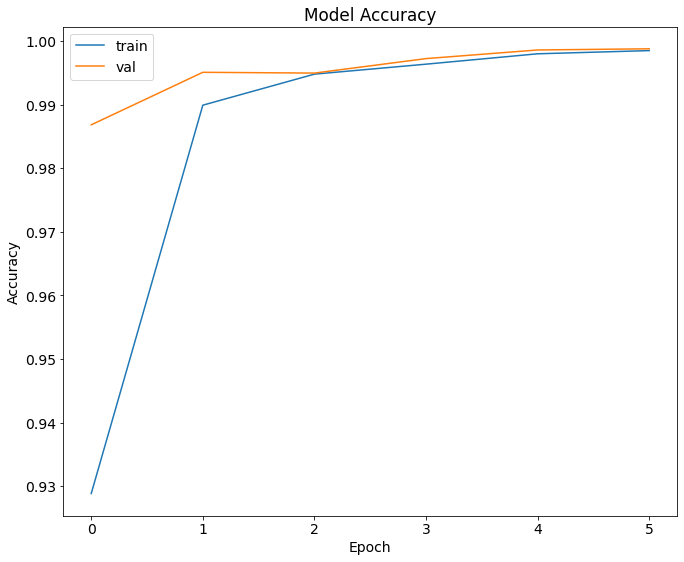

Model has training accuracy of 99.85%


In [33]:
model_config_train('range_binary_clf',6,2000,'softmax','./RangeTrainingset/binary/bin_dataset_simulink.csv')

processing dataset
10
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 200)               163200    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2010      
Total params: 165,210
Trainable params: 165,210
Non-trainable params: 0
_________________________________________________________________
None
saving as: range_multi_clf.pkl
Epoch 1/15
69/69 [==============================] - 4s 31ms/step - loss: 2.2062 - accuracy: 0.3407 - val_loss: 1.8444 - val_accuracy: 0.4516

Epoch 00001: val_loss improved from inf to 1.84438, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 2/15
69/69 [==============================] - 2s 27ms/step - loss: 1.7029 - accuracy: 0.5333 - val_loss: 1.2651 - val_accuracy: 0.6249

Epoch 00002: val_loss improved from 1.84438 to 1.26514, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 3/15
69/69 [==============================] - 2s 26ms/step - loss: 1.1663 - accuracy: 0.6540 - val_loss: 0.9298 - val_accuracy: 0.7602

Epoch 00003: val_loss improved from 1.26514 to 0.92982, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 4/15
69/69 [==============================] - 2s 24ms/step - loss: 0.8821 - accuracy: 0.7867 - val_loss: 0.7378 - val_accuracy: 0.8509

Epoch 00004: val_loss improved from 0.92982 to 0.73778, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 5/15
69/69 [==============================] - 2s 24ms/step - loss: 0.7009 - accuracy: 0.8621 - val_loss: 0.5848 - val_accuracy: 0.9039

Epoch 00005: val_loss improved from 0.73778 to 0.58483, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 6/15
69/69 [==============================] - 2s 25ms/step - loss: 0.5545 - accuracy: 0.9215 - val_loss: 0.4546 - val_accuracy: 0.9281

Epoch 00006: val_loss improved from 0.58483 to 0.45459, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 7/15
69/69 [==============================] - 2s 27ms/step - loss: 0.4293 - accuracy: 0.9267 - val_loss: 0.3478 - val_accuracy: 0.9321

Epoch 00007: val_loss improved from 0.45459 to 0.34783, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 8/15
69/69 [==============================] - 2s 24ms/step - loss: 0.3306 - accuracy: 0.9305 - val_loss: 0.2685 - val_accuracy: 0.9478

Epoch 00008: val_loss improved from 0.34783 to 0.26848, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 9/15
69/69 [==============================] - 2s 24ms/step - loss: 0.2557 - accuracy: 0.9492 - val_loss: 0.2141 - val_accuracy: 0.9594

Epoch 00009: val_loss improved from 0.26848 to 0.21405, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 10/15
69/69 [==============================] - 2s 25ms/step - loss: 0.2045 - accuracy: 0.9605 - val_loss: 0.1780 - val_accuracy: 0.9616

Epoch 00010: val_loss improved from 0.21405 to 0.17802, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 11/15
69/69 [==============================] - 2s 26ms/step - loss: 0.1734 - accuracy: 0.9621 - val_loss: 0.1545 - val_accuracy: 0.9632

Epoch 00011: val_loss improved from 0.17802 to 0.15454, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 12/15
69/69 [==============================] - 2s 25ms/step - loss: 0.1522 - accuracy: 0.9623 - val_loss: 0.1380 - val_accuracy: 0.9640

Epoch 00012: val_loss improved from 0.15454 to 0.13796, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 13/15
69/69 [==============================] - 2s 28ms/step - loss: 0.1367 - accuracy: 0.9641 - val_loss: 0.1261 - val_accuracy: 0.9643

Epoch 00013: val_loss improved from 0.13796 to 0.12615, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 14/15
69/69 [==============================] - 2s 26ms/step - loss: 0.1255 - accuracy: 0.9649 - val_loss: 0.1177 - val_accuracy: 0.9648

Epoch 00014: val_loss improved from 0.12615 to 0.11772, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


Epoch 15/15
69/69 [==============================] - 2s 26ms/step - loss: 0.1162 - accuracy: 0.9663 - val_loss: 0.1105 - val_accuracy: 0.9683

Epoch 00015: val_loss improved from 0.11772 to 0.11050, saving model to range_multi_clf.pkl


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


INFO:tensorflow:Assets written to: range_multi_clf.pkl/assets


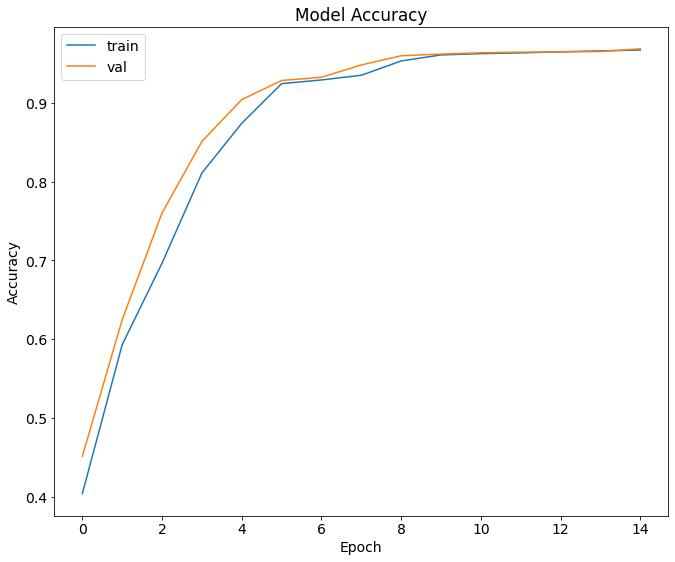

Model has training accuracy of 96.66%


In [91]:
model_config_train('range_multi_clf',15,2000,'softmax','./RangeTrainingset/multi/mul_dataset_simulink.csv')

In [39]:
binary_labels_list = ['NML','FAULT']


In [61]:
#multi_labels_list = ['AB', 'AC', 'BC', 'ABC', 'AG', 'BG', 'ABG', 'CG', 'ACG', 'BCG', 'ABCG']
multi_labels_list = ['AB', 'AC', 'BC','AG', 'BG', 'ABG', 'CG', 'ACG', 'BCG', 'ABCG']


In [92]:
binary_model = load_model('range_binary_clf.pkl')
multi_model = load_model('range_multi_clf.pkl')

In [63]:
dat = pd.read_csv('ml_test.csv')
dat = dat[dat.columns[:3]]
data = tester(binary_model,dat)


In [100]:
dat = pd.read_csv('./RangeTrainingset/2BG.csv')


{0}

In [101]:
dat

A1       A2       A3  label
0      1.00000  1.00000  1.00000      0
1      1.00000  1.00000  1.00000      0
2      1.00000  1.00000  1.00000      0
3      1.00000  1.00000  1.00000      0
4      1.00000  1.00000  1.00000      0
...        ...      ...      ...    ...
19995  0.96683  0.96686  0.96681      0
19996  0.96684  0.96686  0.96681      0
19997  0.96685  0.96685  0.96681      0
19998  0.96686  0.96684  0.96681      0
19999  0.96686  0.96683  0.96681      0

[20000 rows x 4 columns]

  Fault type Percentage
0        NML     99.07%
1      FAULT      0.93%


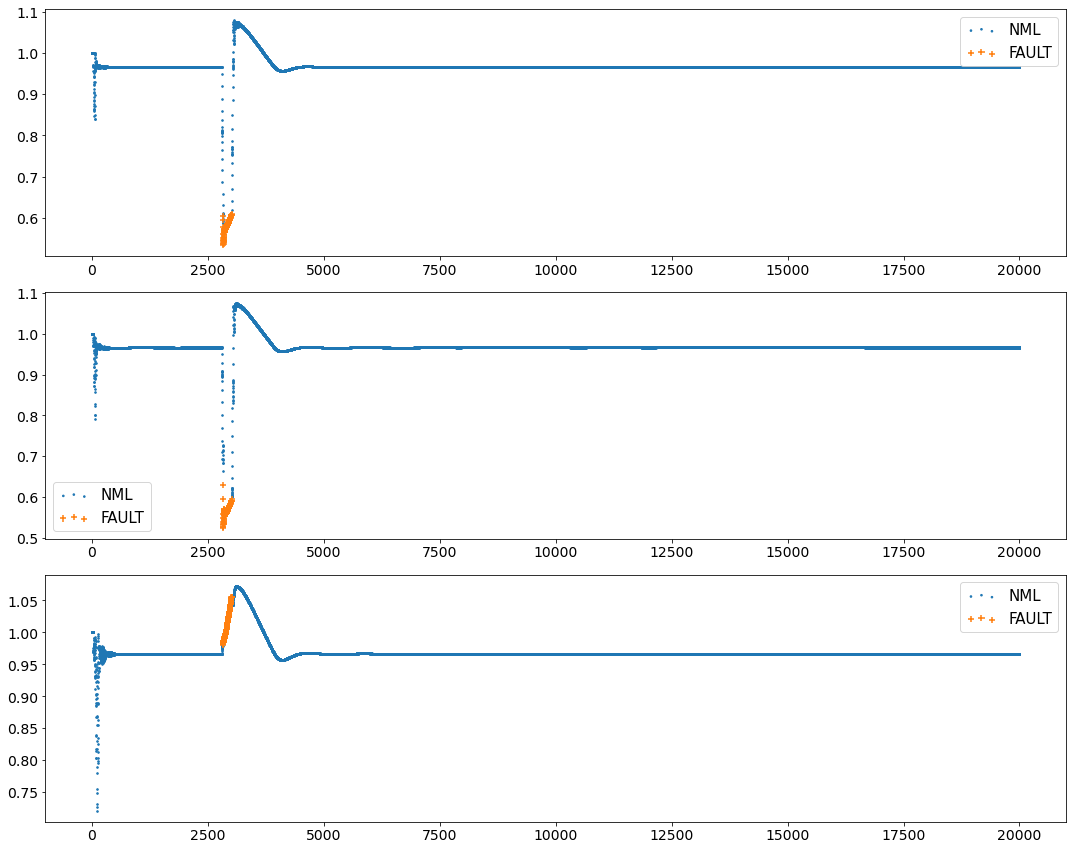

  Fault type Percentage
0         BG     100.0%


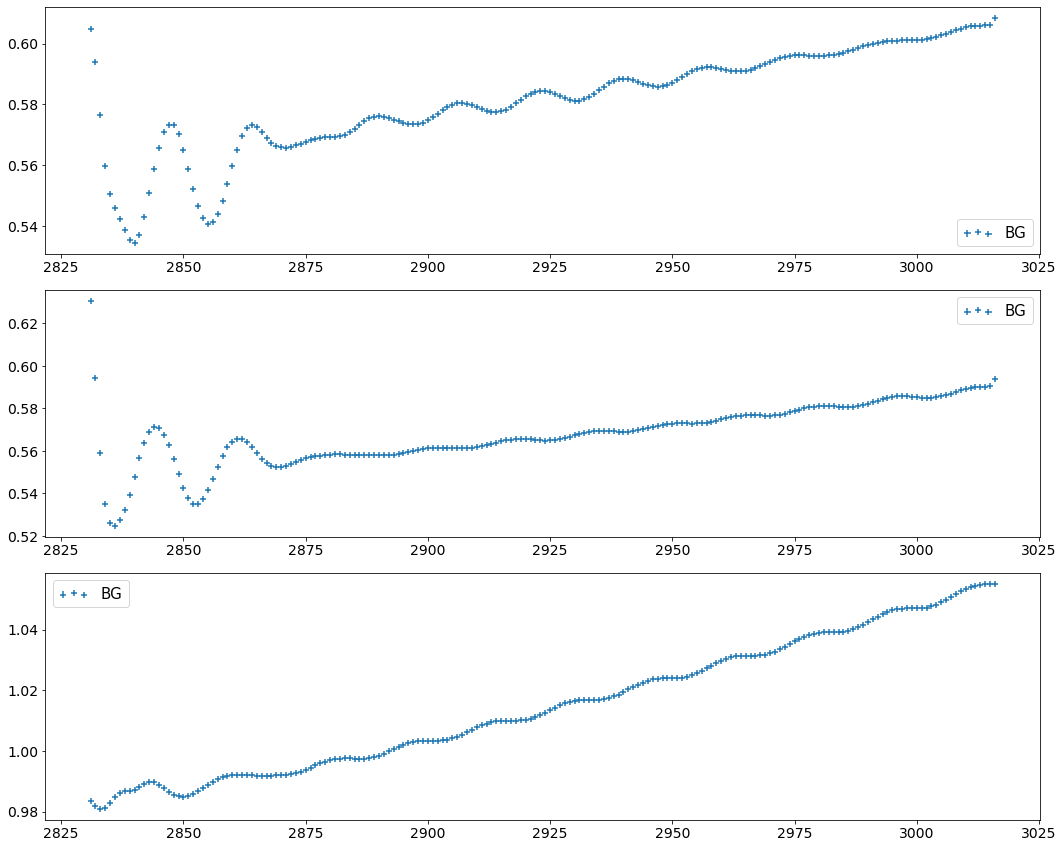

'BG'

In [102]:
dat = pd.read_csv('ml_test.csv')
dat = dat[dat.columns[:3]]
data = tester(binary_model,dat)
plotter(data,binary_labels_list,3)
data = tester(multi_model,data[data.label!=0][data.columns[:3]])
plotter(data,multi_labels_list,3)


In [26]:
binary_model = load_model('clus_binary_clf.pkl')
multi_model = load_model('clus_multi_clf.pkl')


  Fault type Percentage
0        NML     98.94%
1      FAULT      1.06%


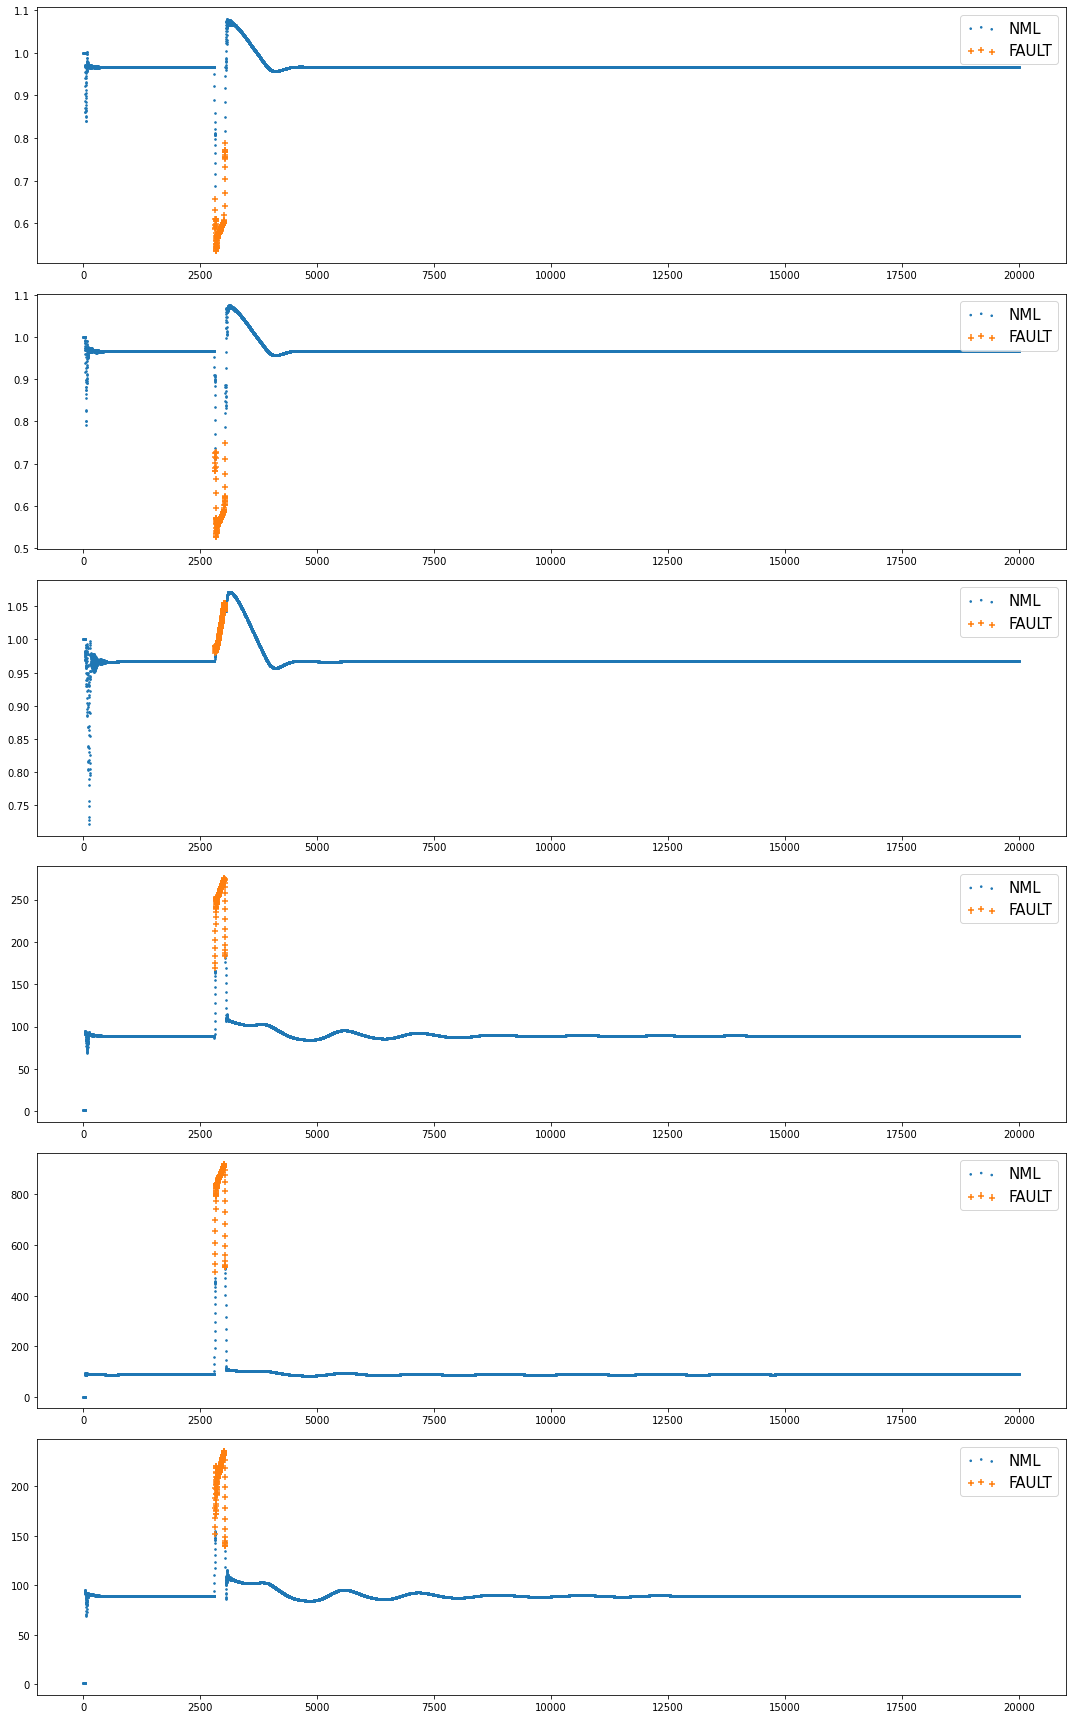

  Fault type Percentage
0         BG     100.0%


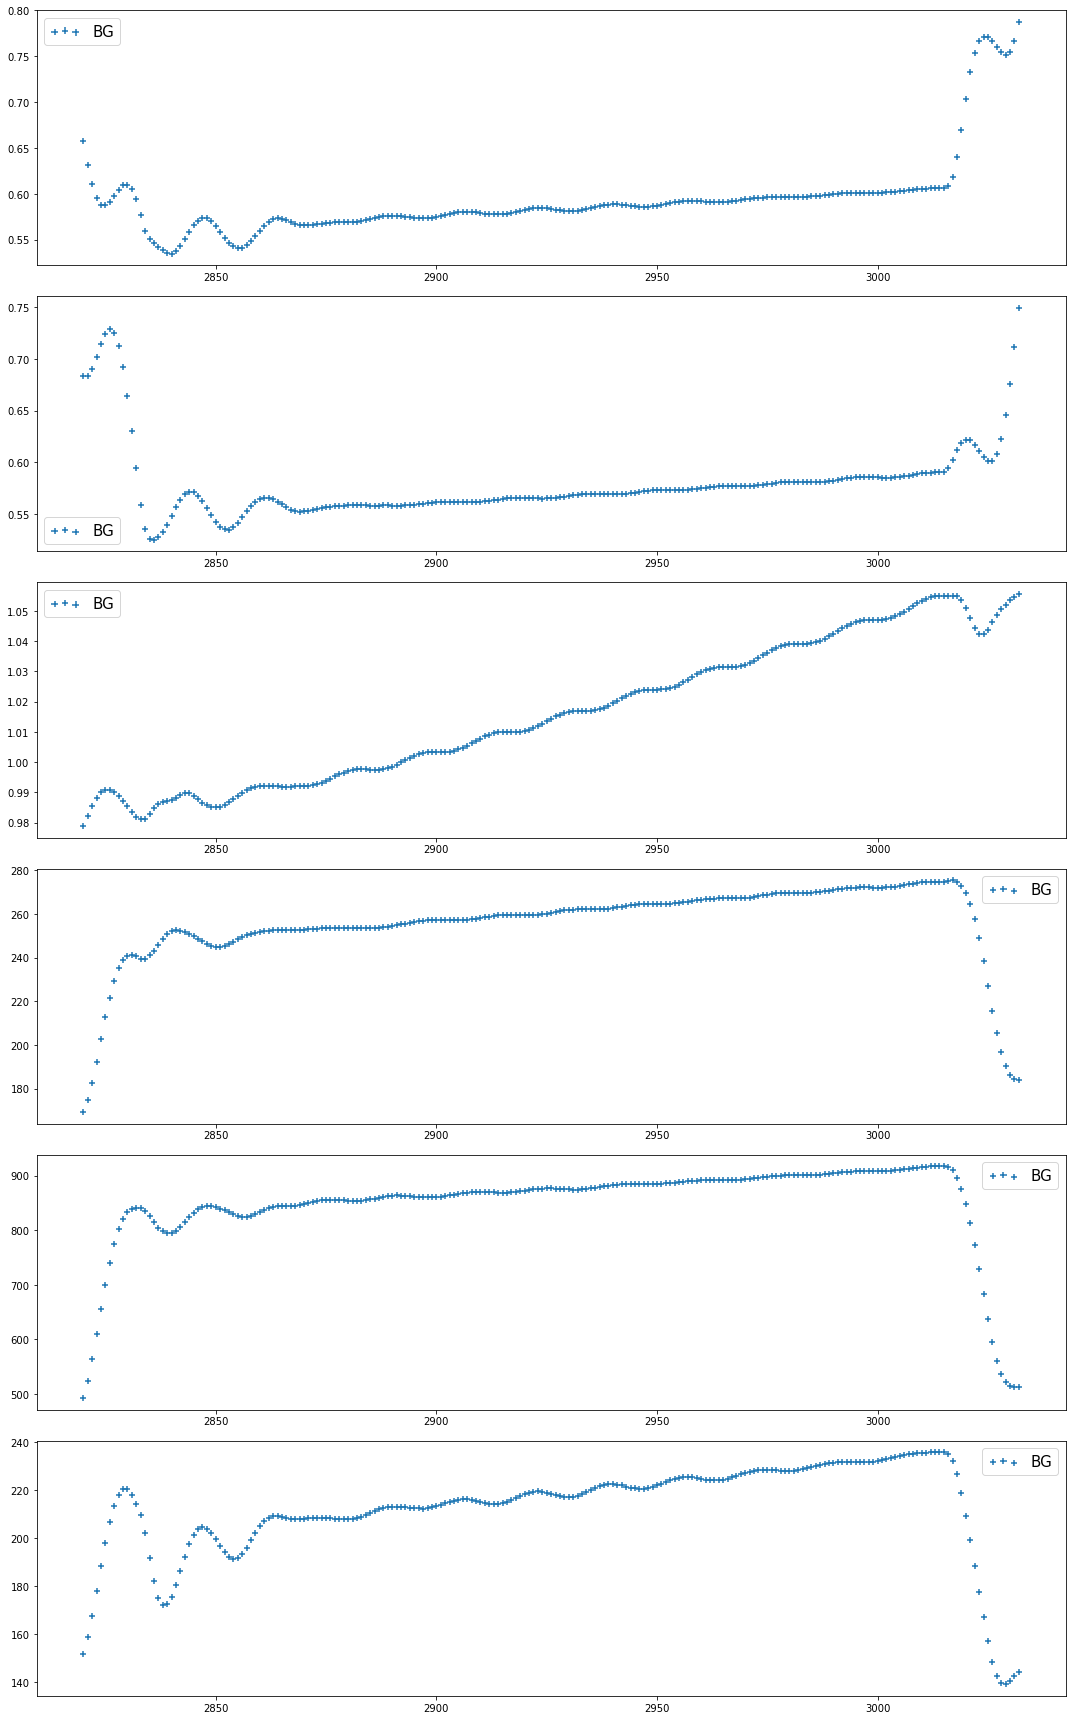

'BG'

In [28]:
dat = pd.read_csv('ml_test.csv')
#dat = dat[dat.columns[:-1]]
data = tester(binary_model,dat)
plotter(data,binary_labels_list,6)
data = tester(multi_model,data[data.label!=0])
plotter(data,multi_labels_list,6)



In [20]:
labels = np.argmax(binary_model.predict(dat[dat.columns[:-1]].values.reshape(-1,1,6)),axis=1)

In [201]:
data = tester(binary_model,dat[dat.columns[:-1]].values.reshape(-1,1,6))
plotter(data,binary_labels_list,2)
'''
data = tester(multi_model,data[data.label!=0])
plotter(data,multi_labels_list,2)
'''

columns length is  1


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [3]:
# current directory
path = "./RangeTrainingset/"

# list of file of the given path is assigned to the variable 
file_list = [each for each in list(os.walk(path))[0][-1] if ".csv" in each]


.
.
 5ABCG.csv
  Fault type Percentage
0        NML     97.65%
1      FAULT      2.35%


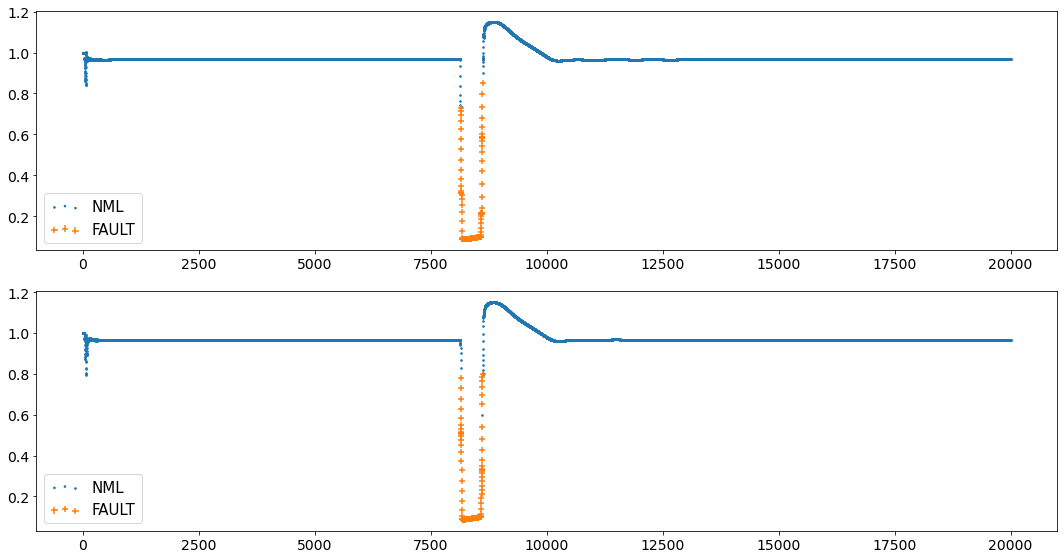

  Fault type Percentage
0        ABC     97.23%
1        ACG      1.49%
2        BCG      1.28%


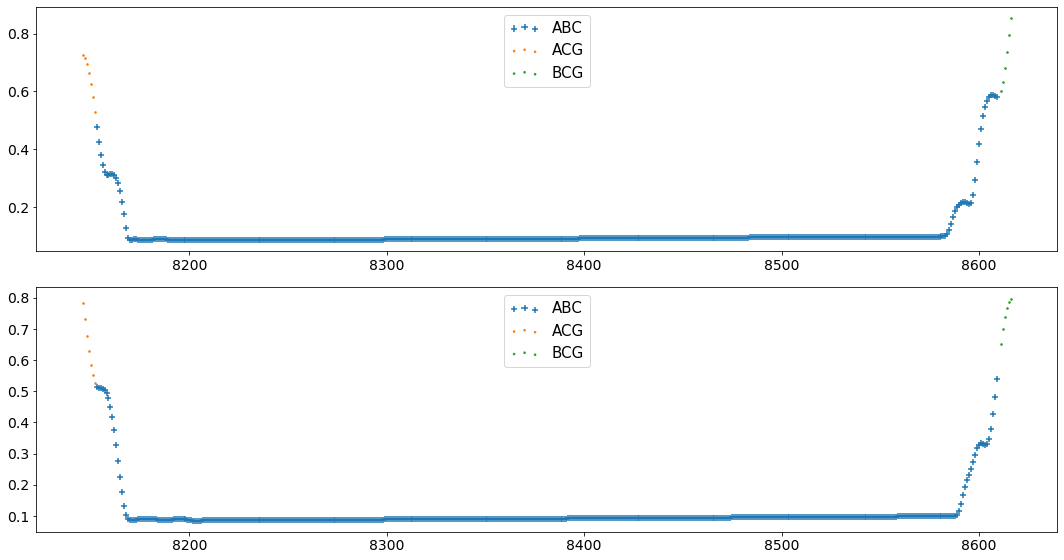


.
.
 10ABG.csv
  Fault type Percentage
0        NML     99.65%
1      FAULT      0.35%


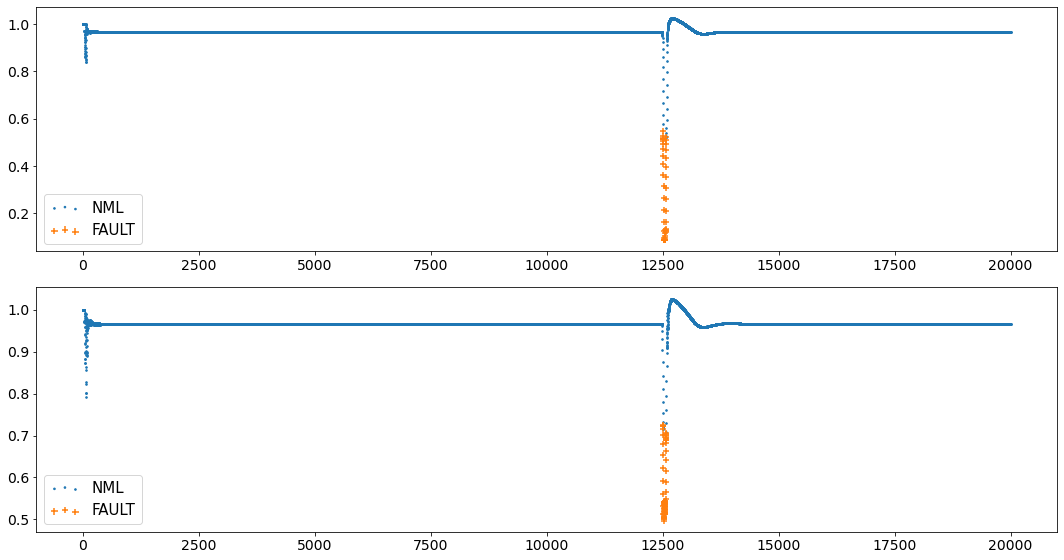

  Fault type Percentage
0        ABG     98.57%
1         AB      1.43%


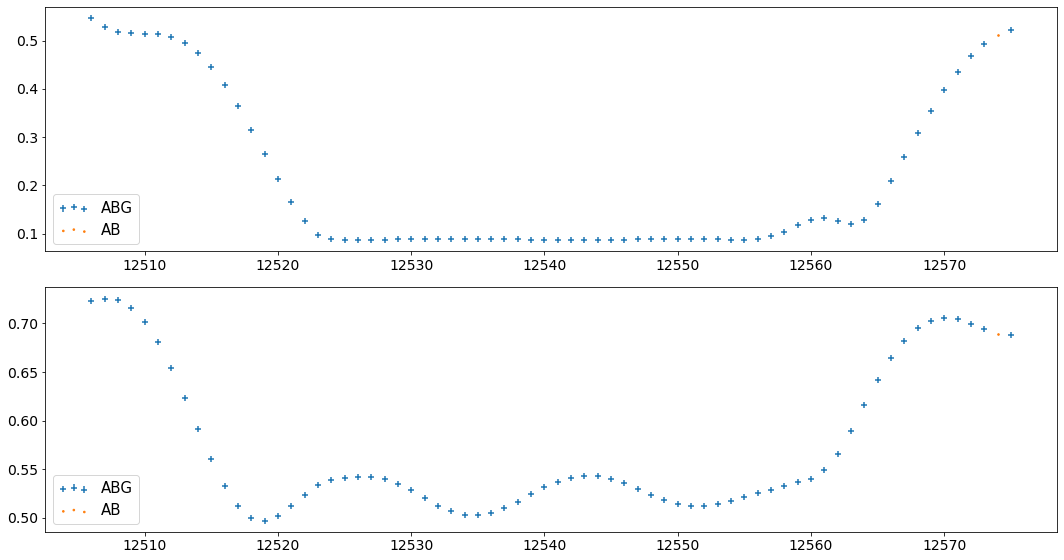


.
.
 3BC.csv
  Fault type Percentage
0        NML     99.79%
1      FAULT      0.21%


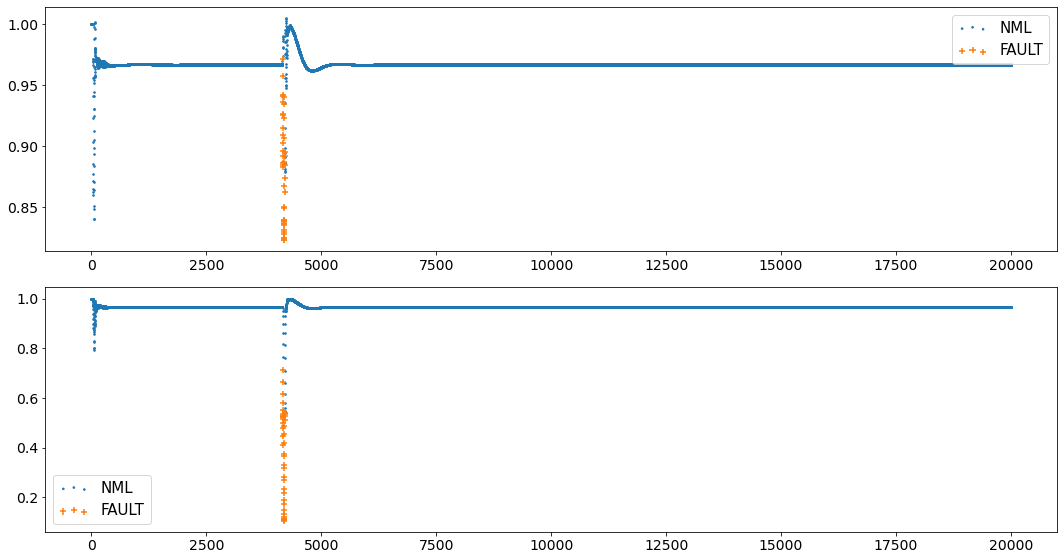

  Fault type Percentage
0         BC     92.86%
1        BCG      7.14%


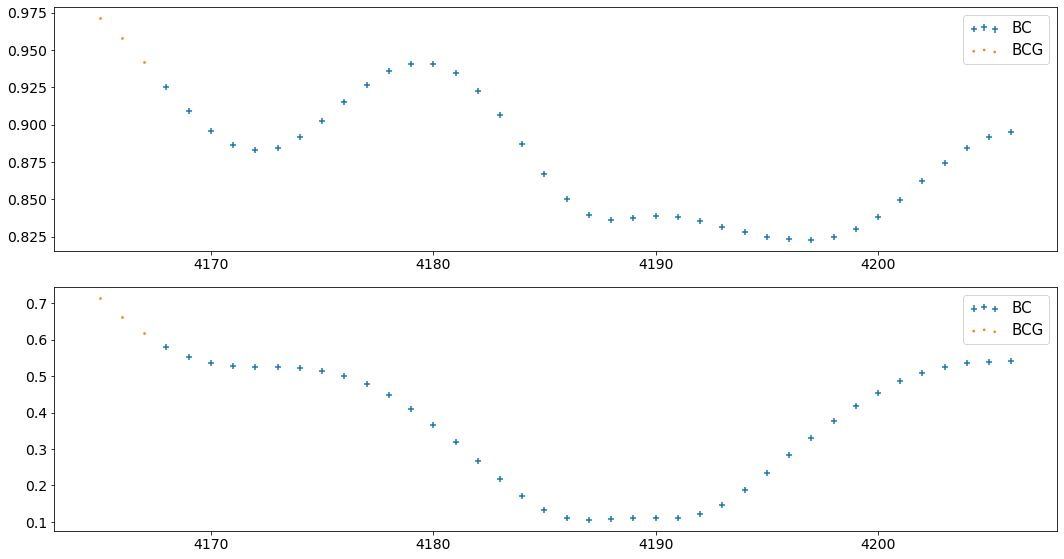


.
.
 3CG.csv
  Fault type Percentage
0        NML     87.04%
1      FAULT     12.96%


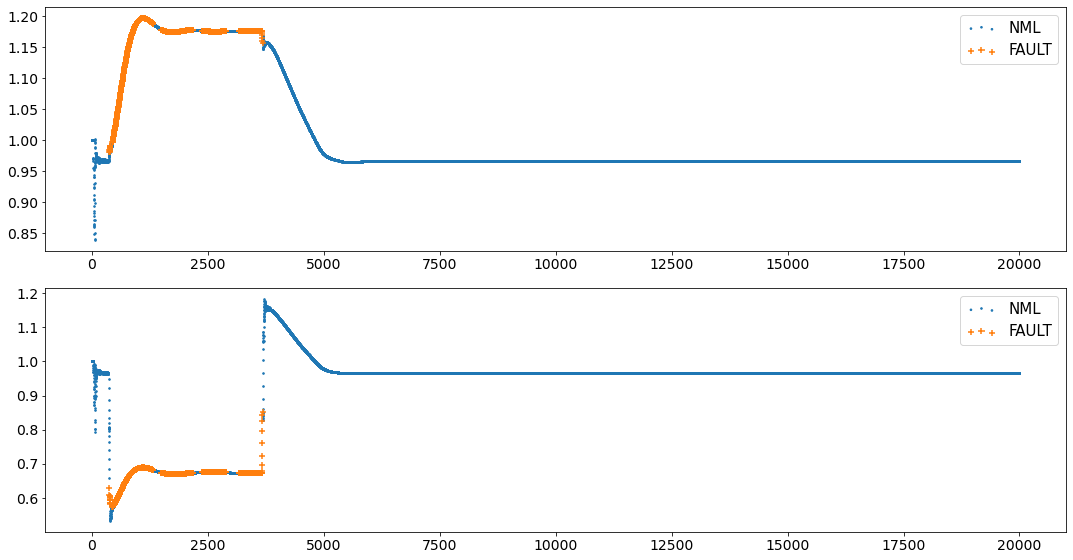

  Fault type Percentage
0         CG     100.0%


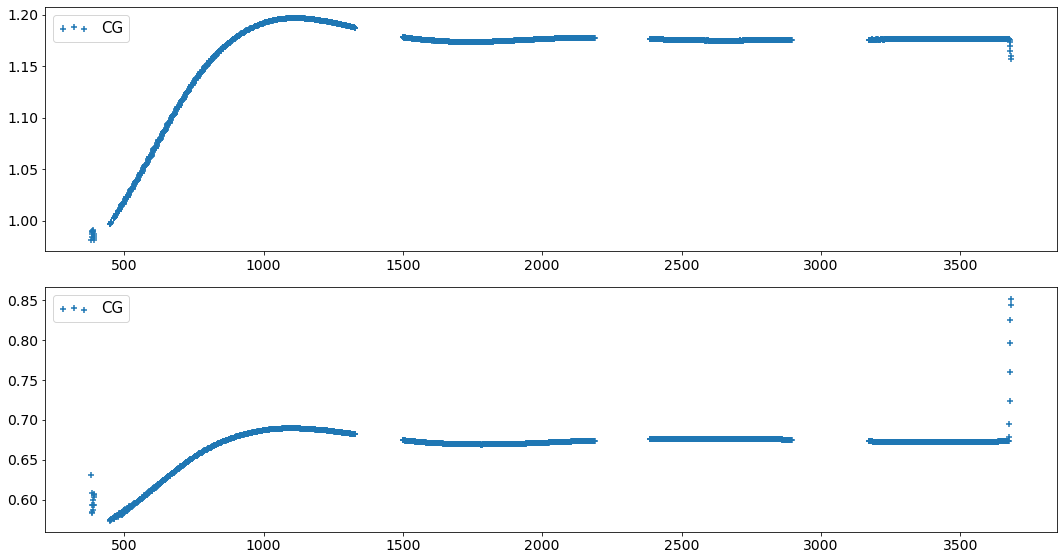


.
.
 1BCG.csv
  Fault type Percentage
0        NML     98.83%
1      FAULT      1.17%


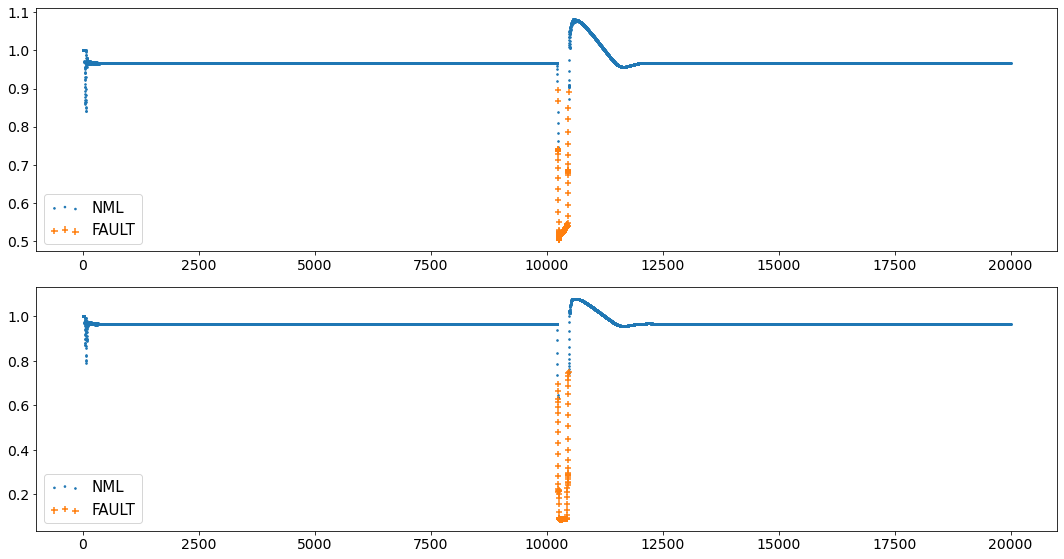

  Fault type Percentage
0        BCG     98.28%
1         BG      1.72%


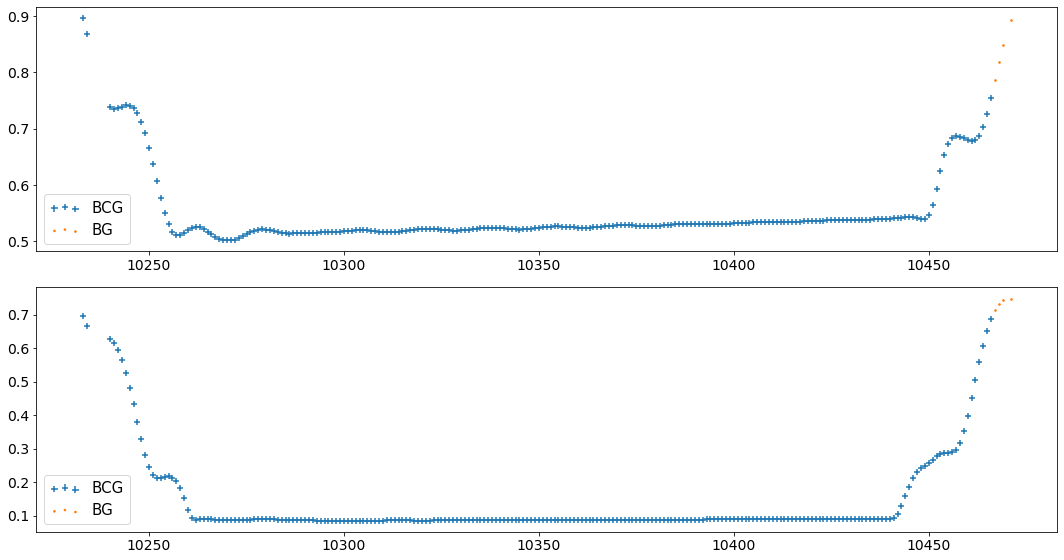


.
.
 7BG.csv
  Fault type Percentage
0        NML     87.77%
1      FAULT     12.23%


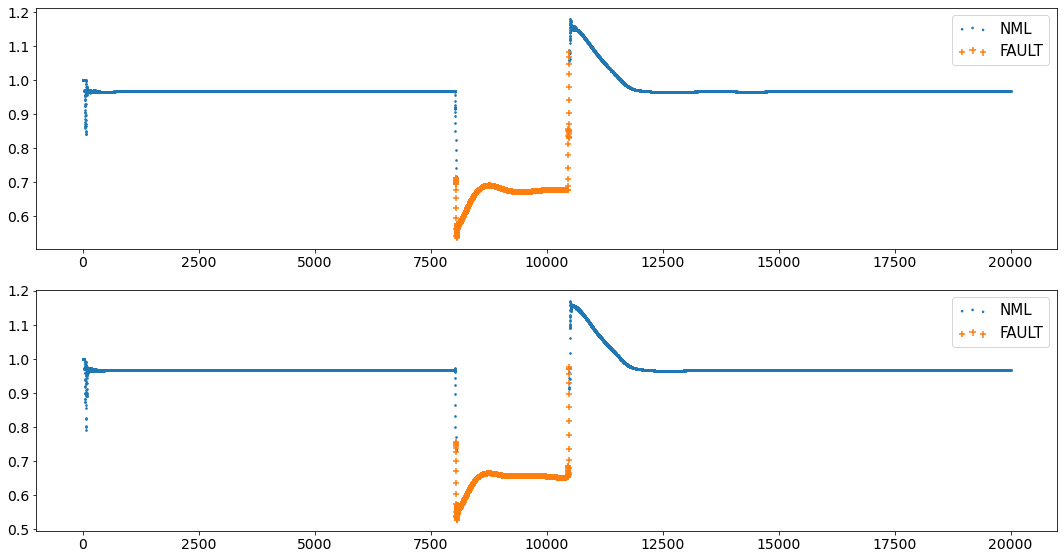

  Fault type Percentage
0         BG     100.0%


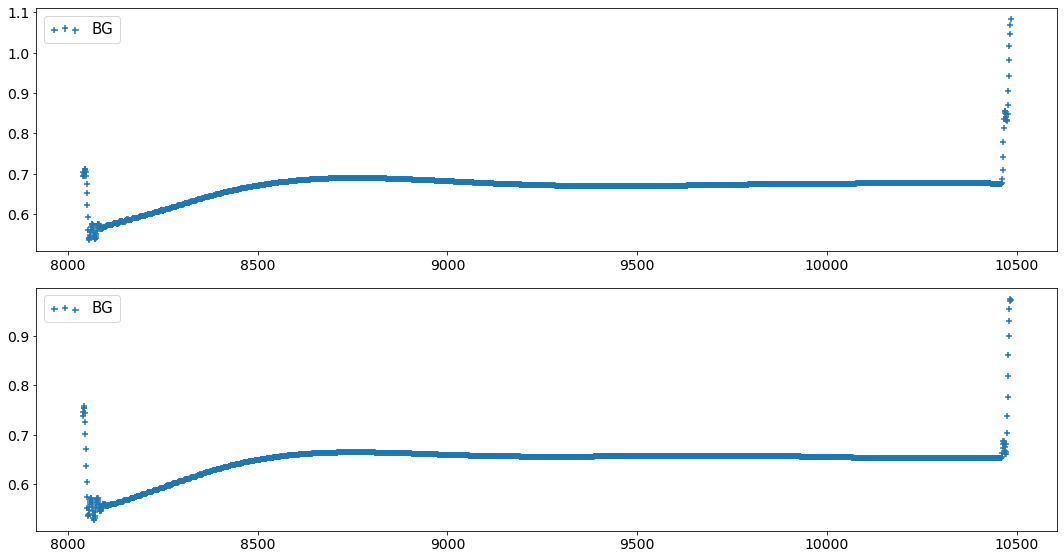


.
.
 5BG.csv
  Fault type Percentage
0        NML     61.33%
1      FAULT     38.67%


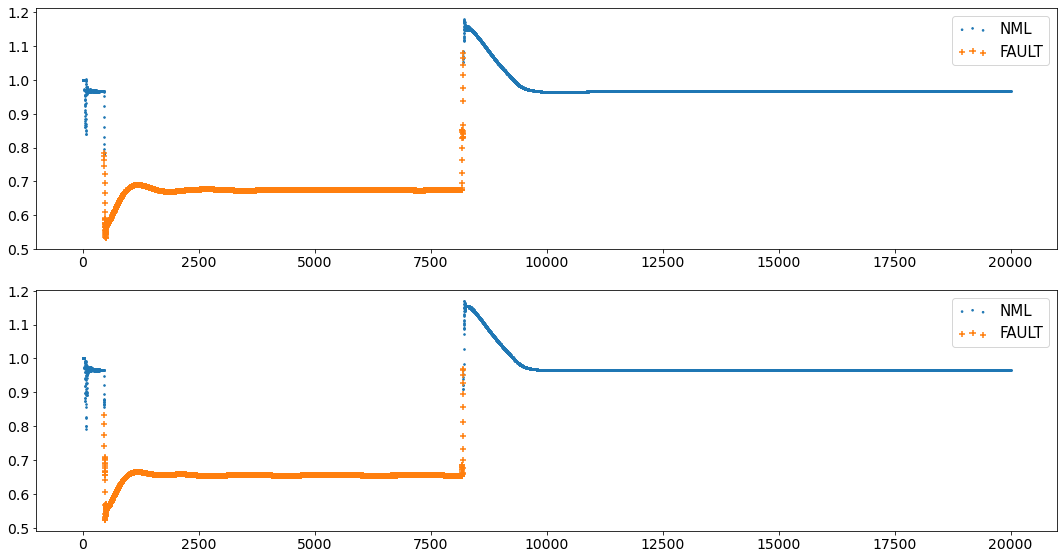

  Fault type Percentage
0         BG     100.0%


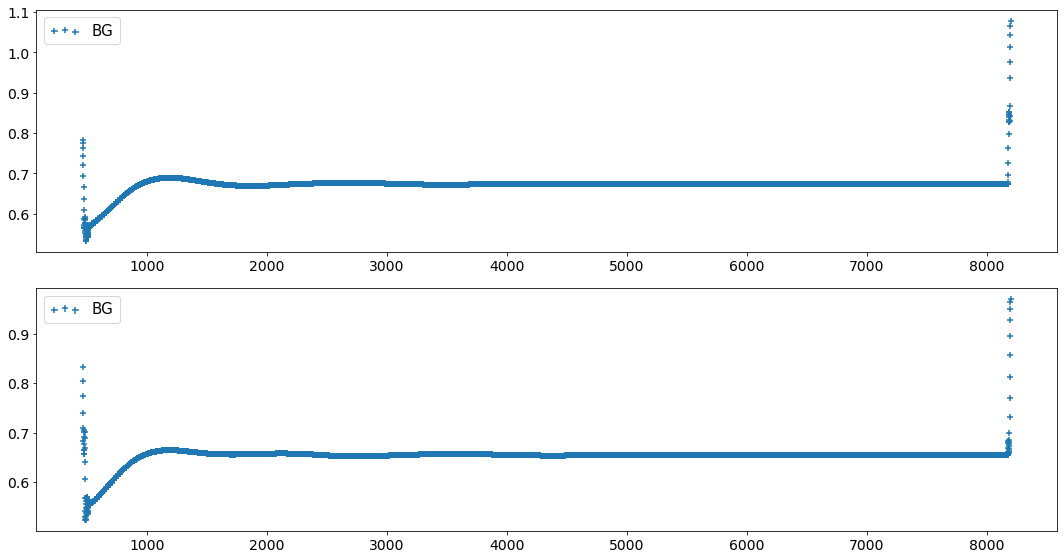


.
.
 9ABG.csv
  Fault type Percentage
0        NML     98.34%
1      FAULT      1.66%


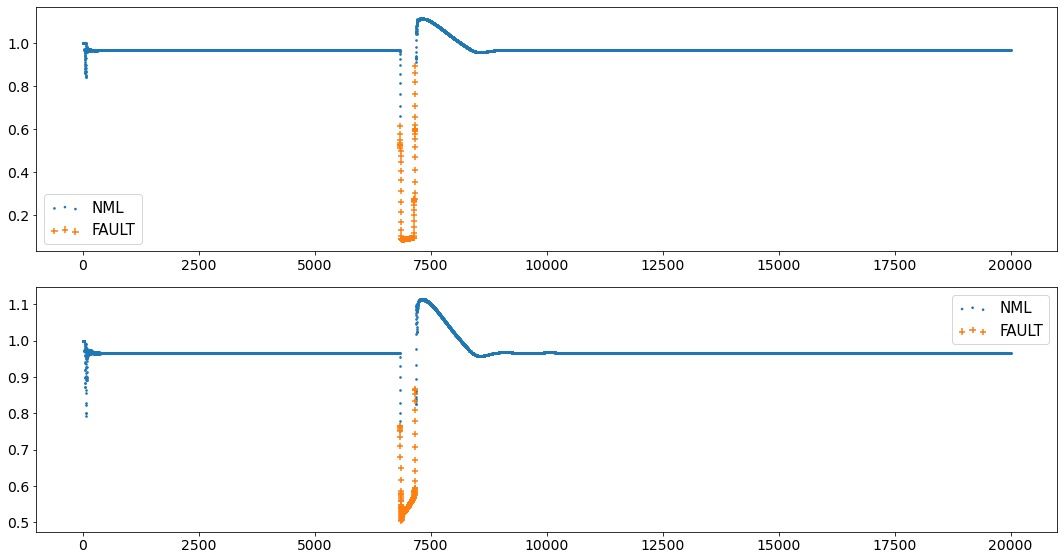

  Fault type Percentage
0        ABG     95.48%
1         BG      3.31%
2         AB       1.2%


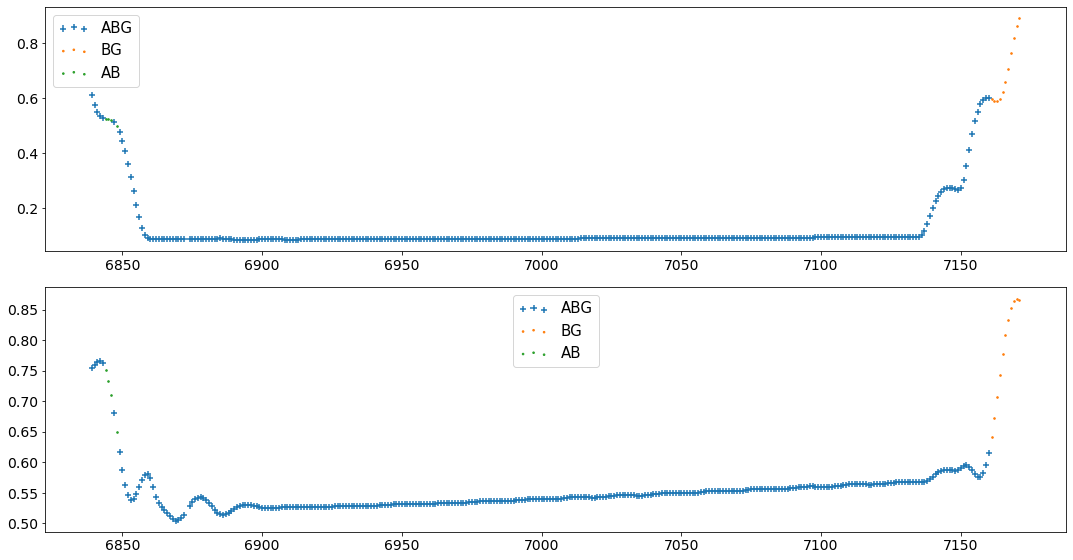


.
.
 1BC.csv
  Fault type Percentage
0        NML      74.7%
1      FAULT      25.3%


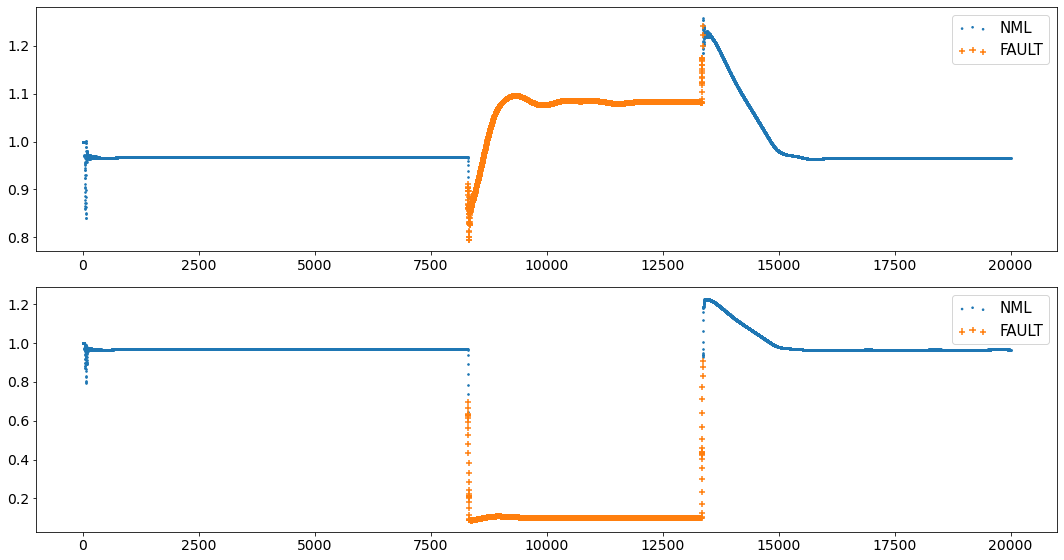

  Fault type Percentage
0         BC     99.94%
1        BCG      0.06%


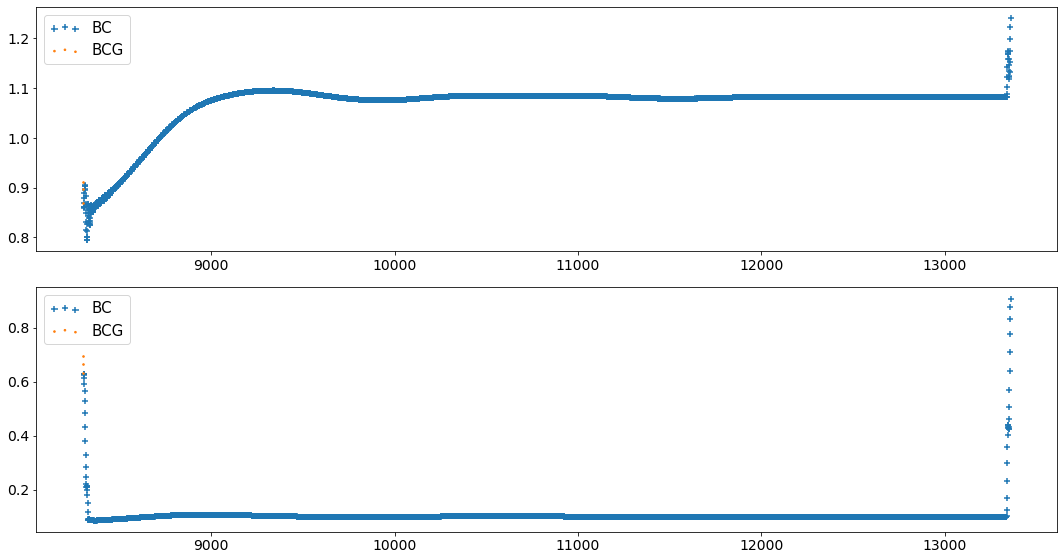


.
.
 1CG.csv
  Fault type Percentage
0        NML     99.62%
1      FAULT      0.38%


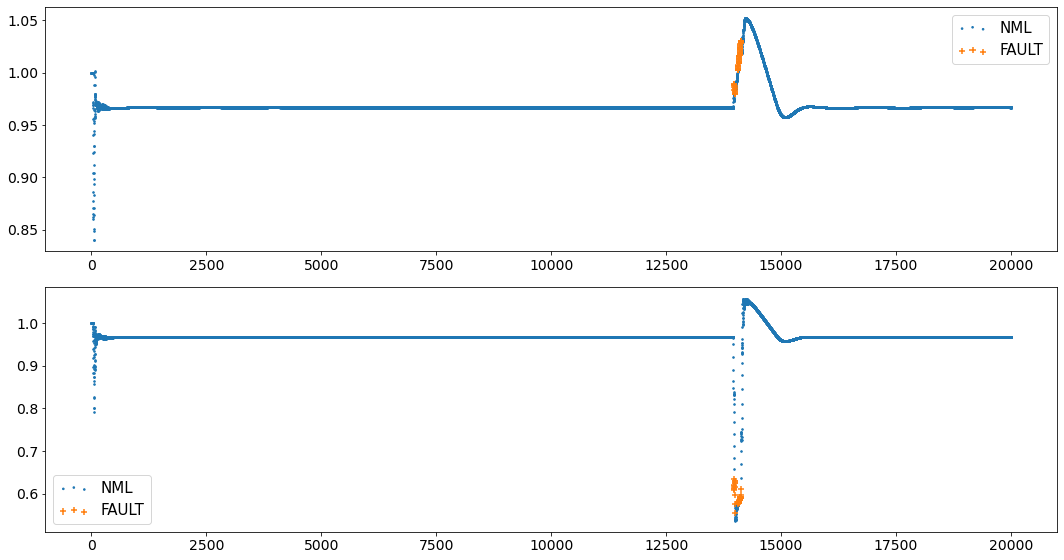

  Fault type Percentage
0         CG     100.0%


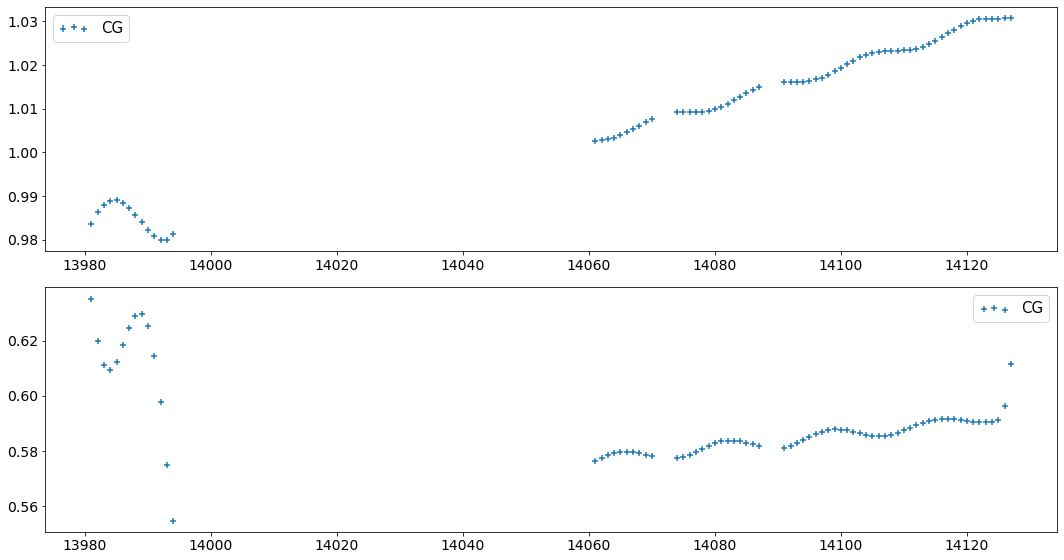


.
.
 5ABG.csv
  Fault type Percentage
0        NML      77.5%
1      FAULT      22.5%


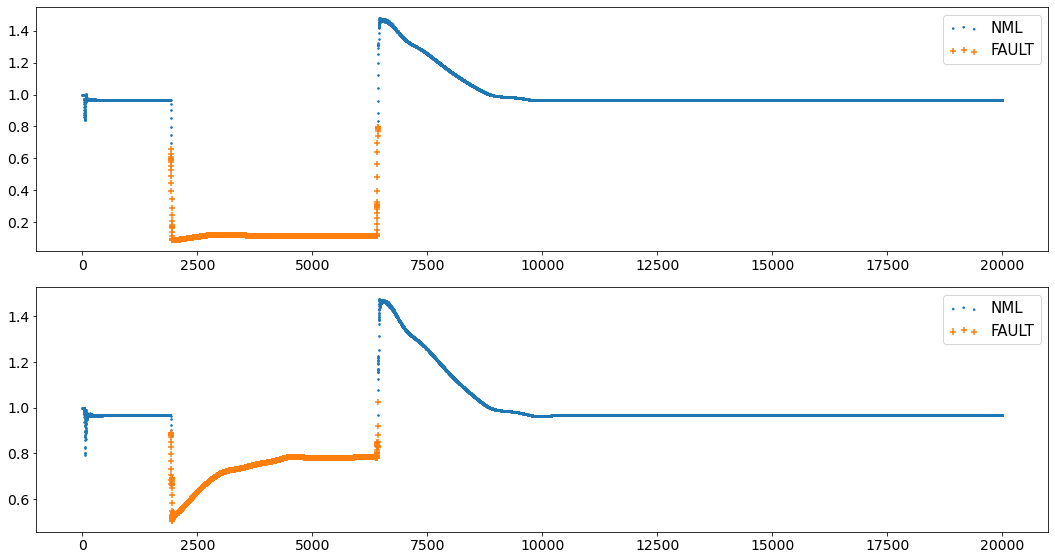

  Fault type Percentage
0        ABG     99.84%
1         AB      0.13%
2         BG      0.02%


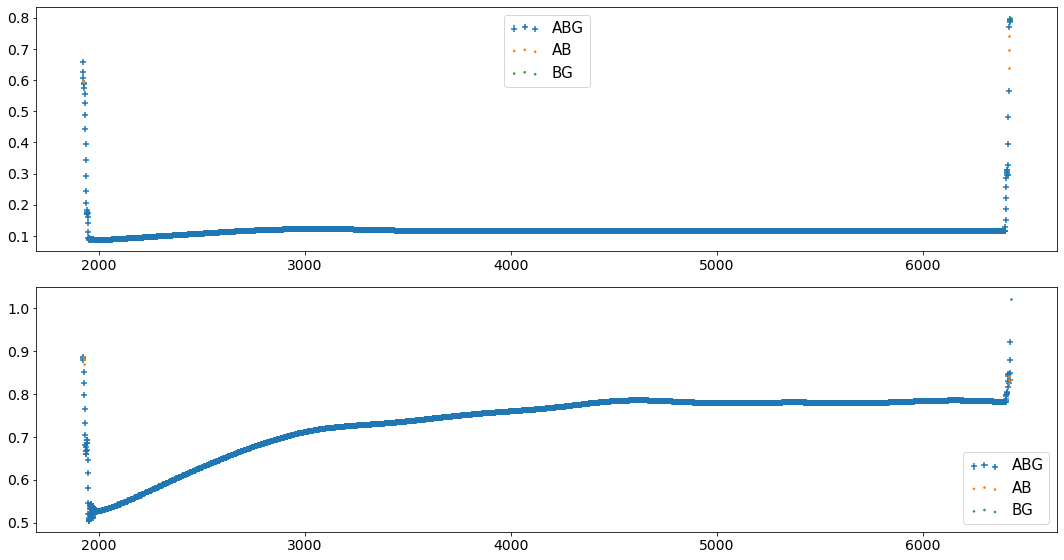


.
.
 9AG.csv
  Fault type Percentage
0        NML     66.89%
1      FAULT      33.1%


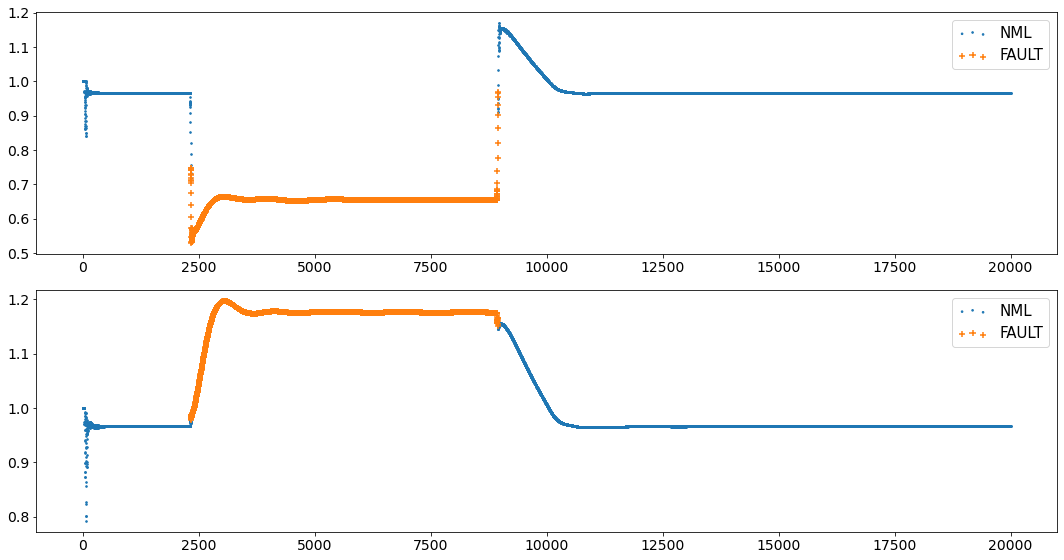

  Fault type Percentage
0         AG     100.0%


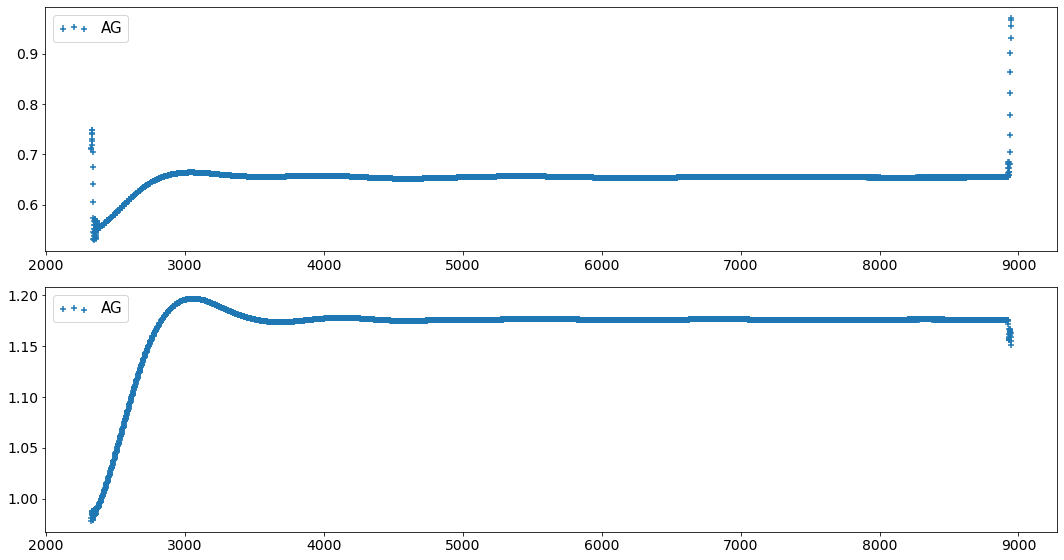


.
.
 7ABC.csv
  Fault type Percentage
0        NML     73.72%
1      FAULT     26.29%


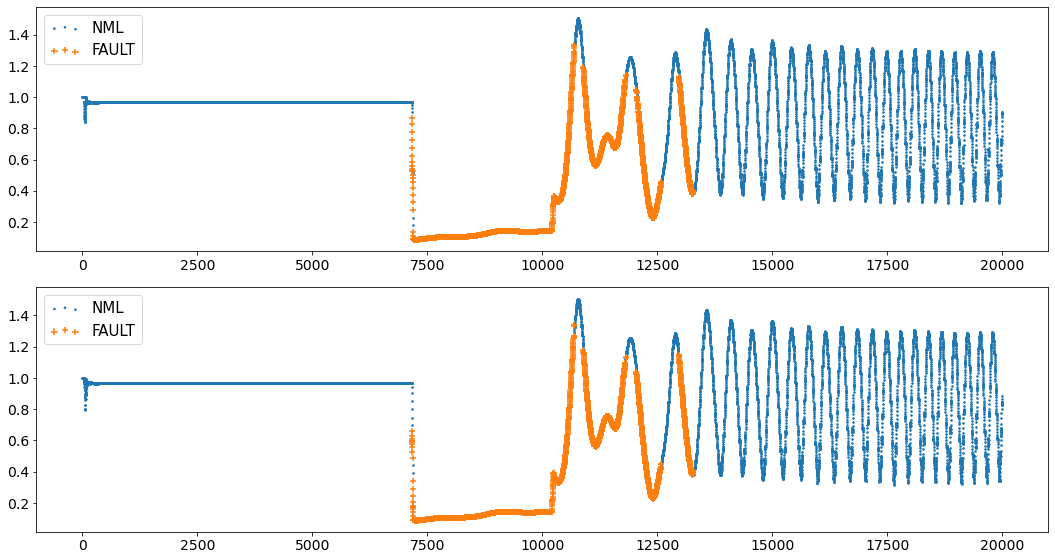

  Fault type Percentage
0        ABC     99.85%
1        BCG      0.15%


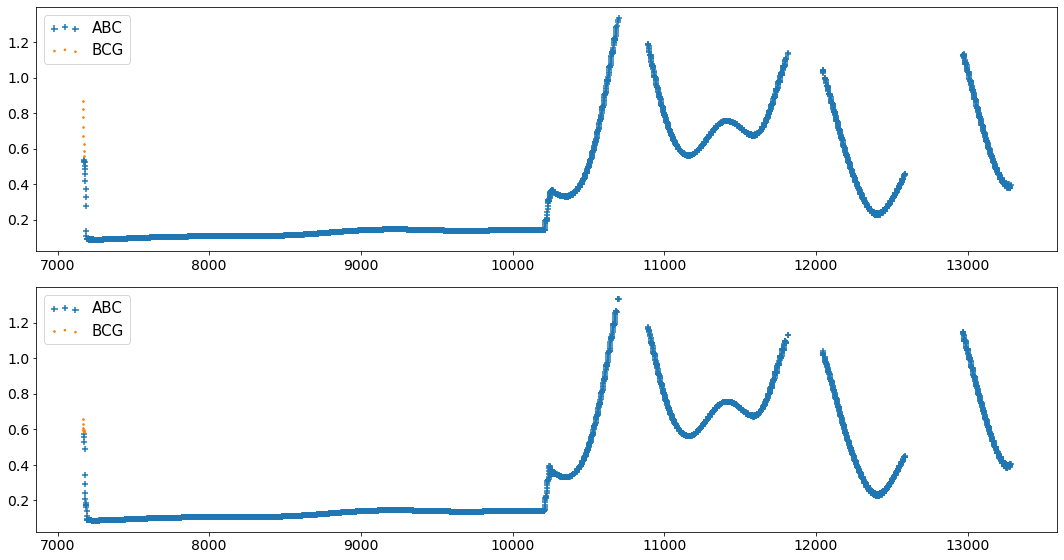


.
.
 7ACG.csv
  Fault type Percentage
0        NML     95.36%
1      FAULT      4.64%


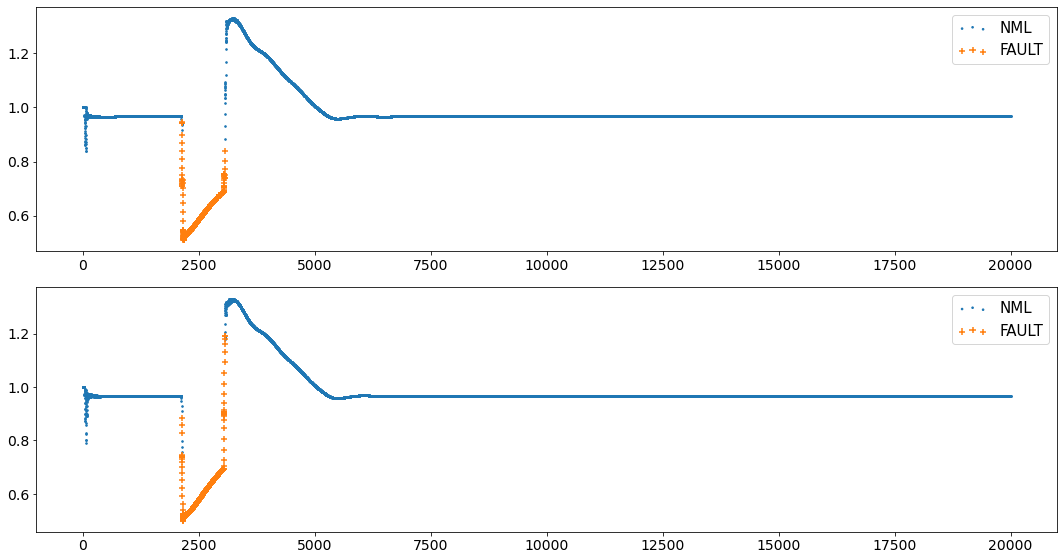

  Fault type Percentage
0        ACG     98.92%
1         CG      0.54%
2         AC      0.43%
3        ABC      0.11%


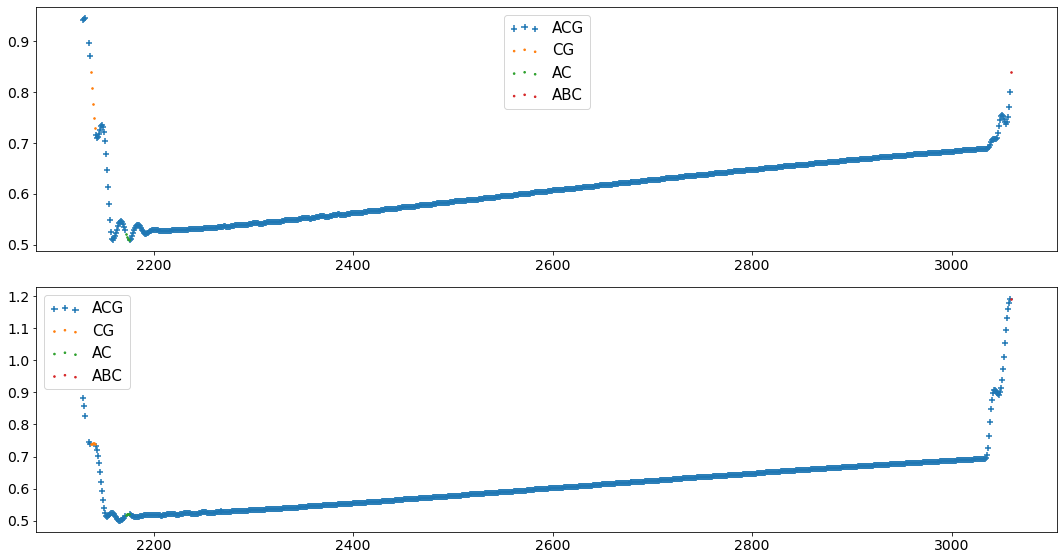


.
.
 7ABG.csv
  Fault type Percentage
0        NML     99.49%
1      FAULT      0.51%


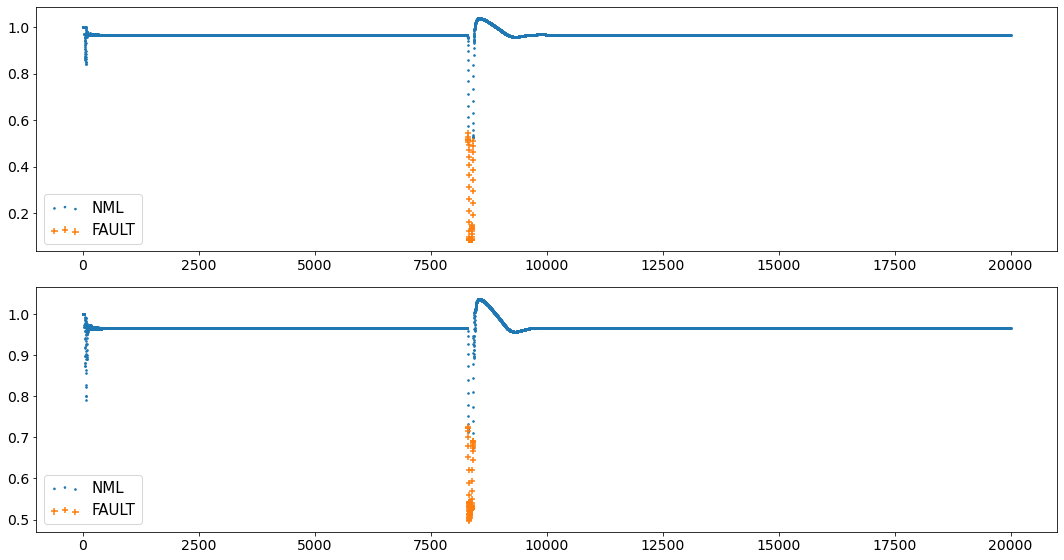

  Fault type Percentage
0        ABG     100.0%


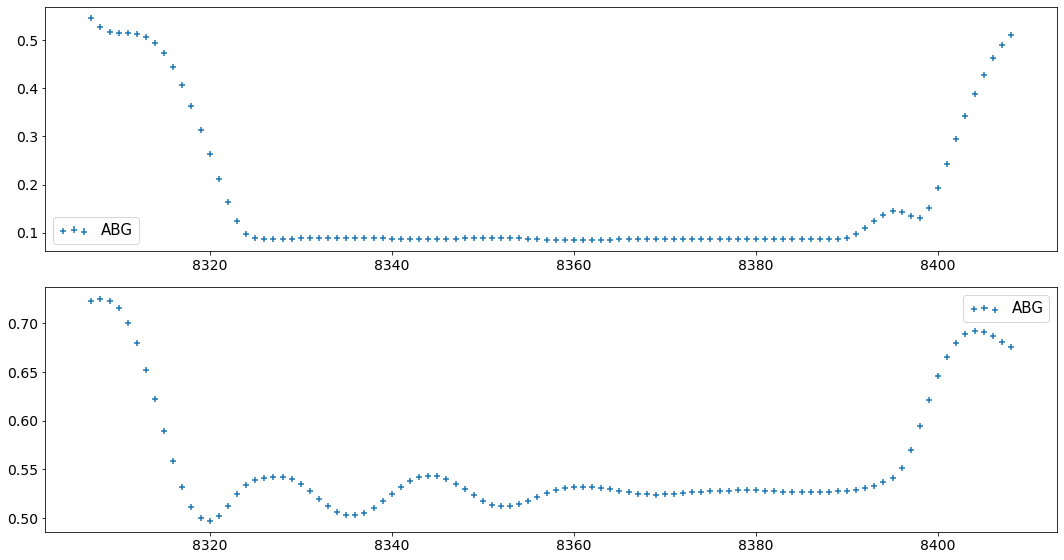


.
.
 9AC.csv
  Fault type Percentage
0        NML     97.98%
1      FAULT      2.02%


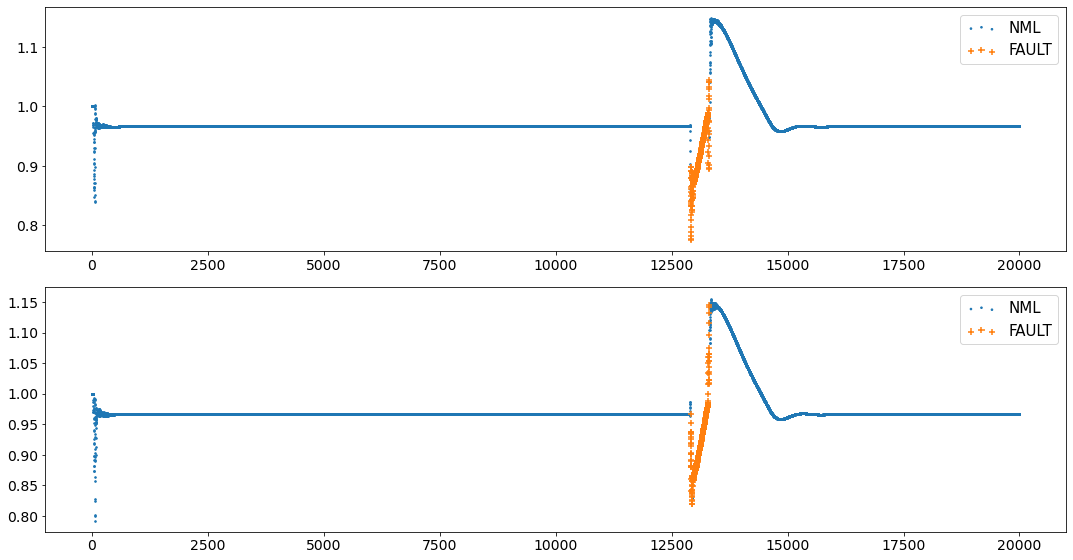

  Fault type Percentage
0         AC     97.77%
1        ACG      2.23%


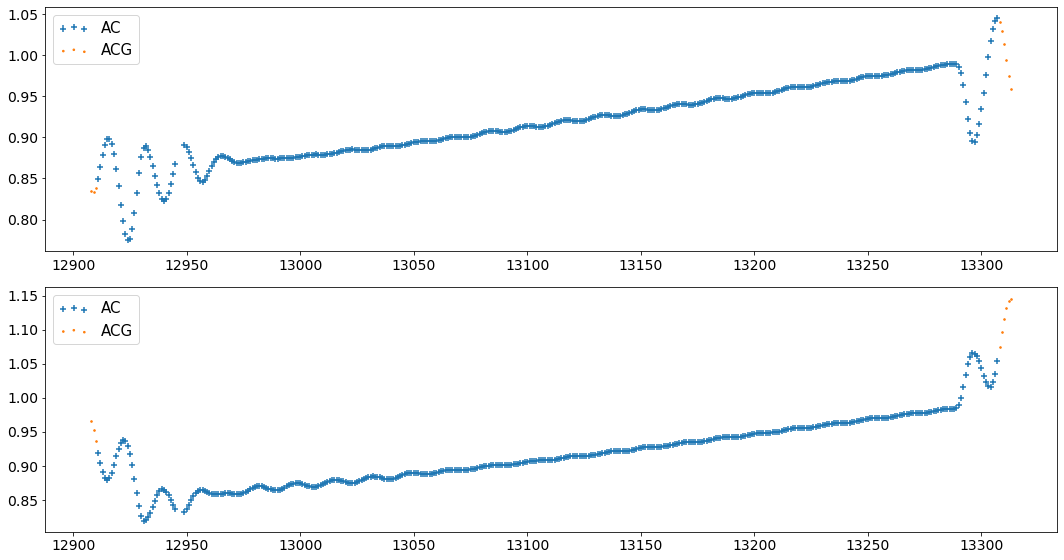


.
.
 1BG.csv
  Fault type Percentage
0        NML     86.89%
1      FAULT     13.11%


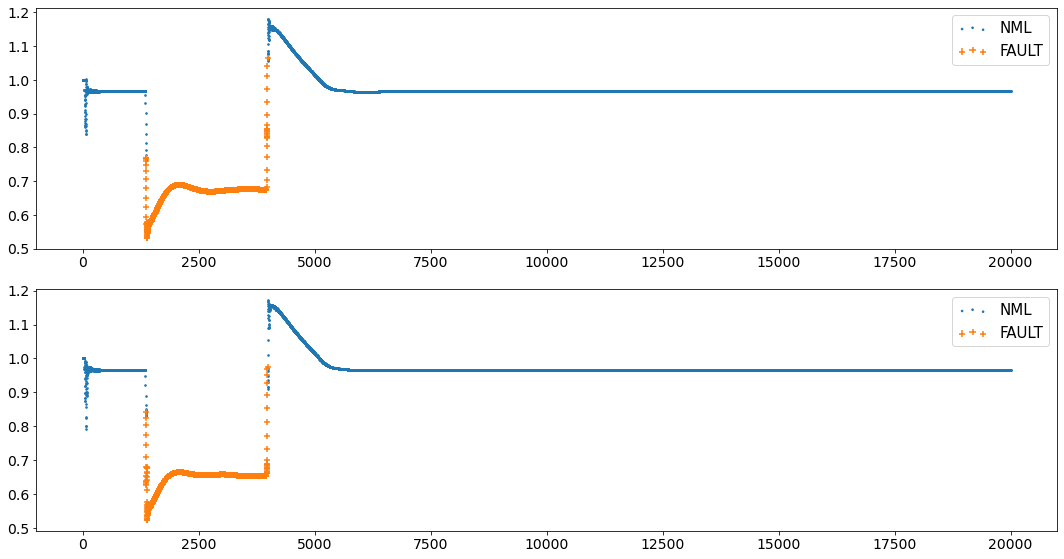

  Fault type Percentage
0         BG     100.0%


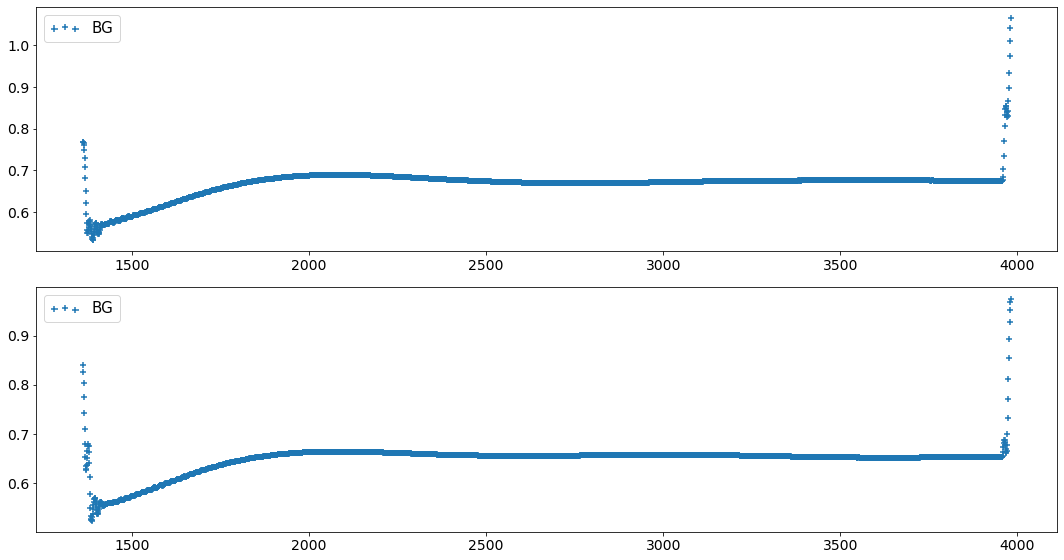


.
.
 5ABC.csv
  Fault type Percentage
0        NML     70.22%
1      FAULT     29.79%


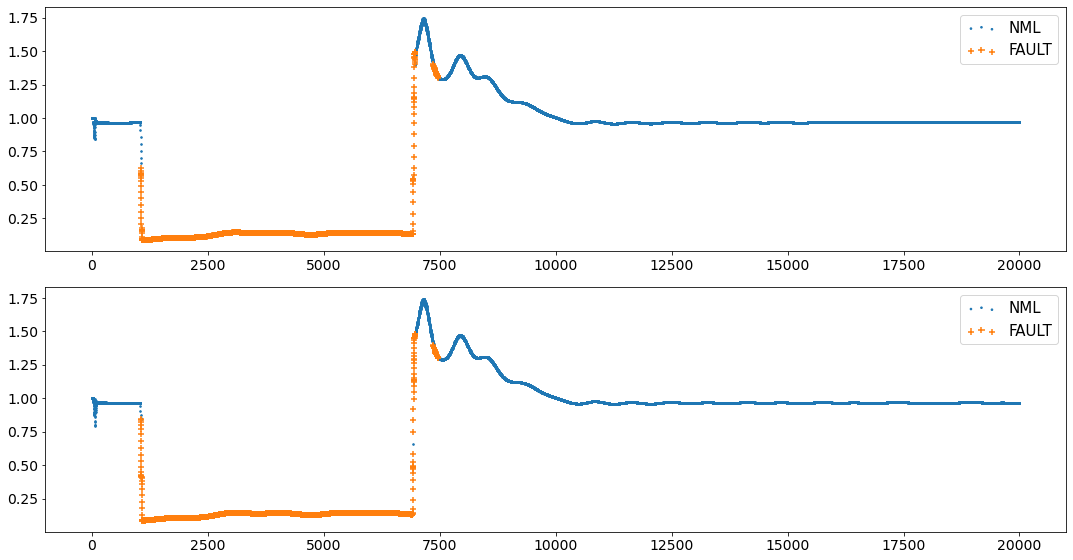

  Fault type Percentage
0        ABC     99.88%
1        ABG      0.12%


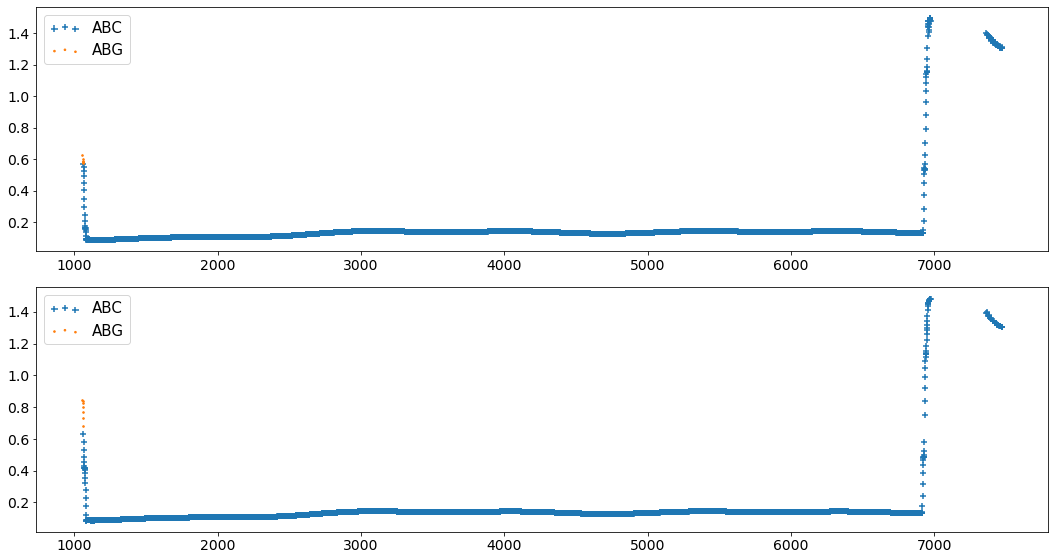


.
.
 5ACG.csv
  Fault type Percentage
0        NML     98.85%
1      FAULT      1.15%


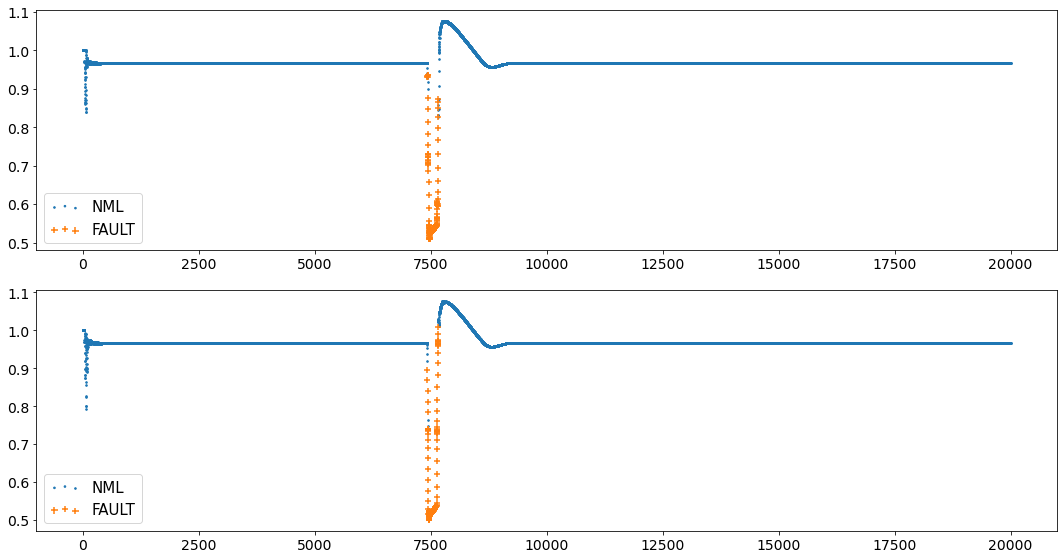

  Fault type Percentage
0        ACG     93.91%
1         AG      3.91%
2         AC       1.3%
3         CG      0.87%


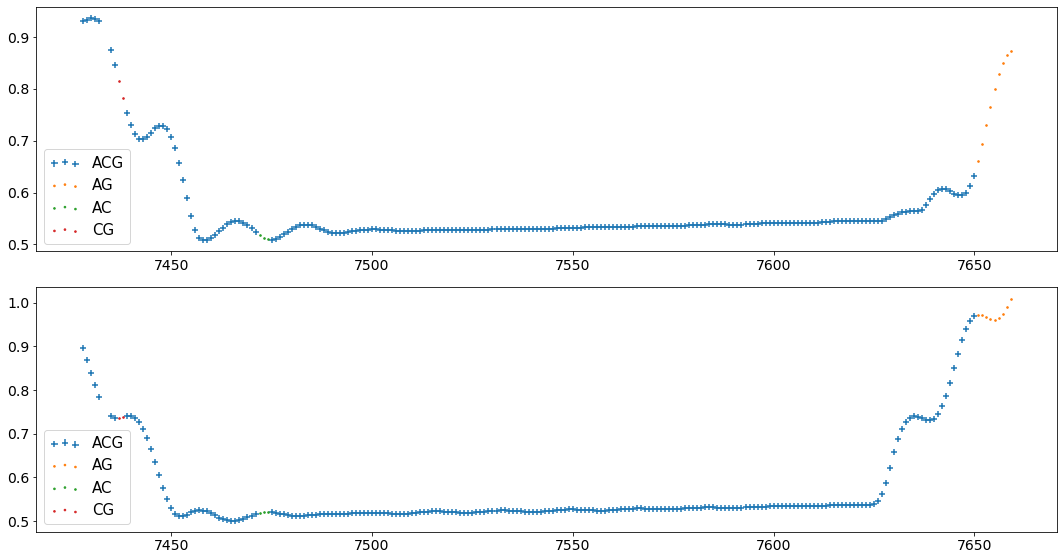


.
.
 9AB.csv
  Fault type Percentage
0        NML      79.6%
1      FAULT      20.4%


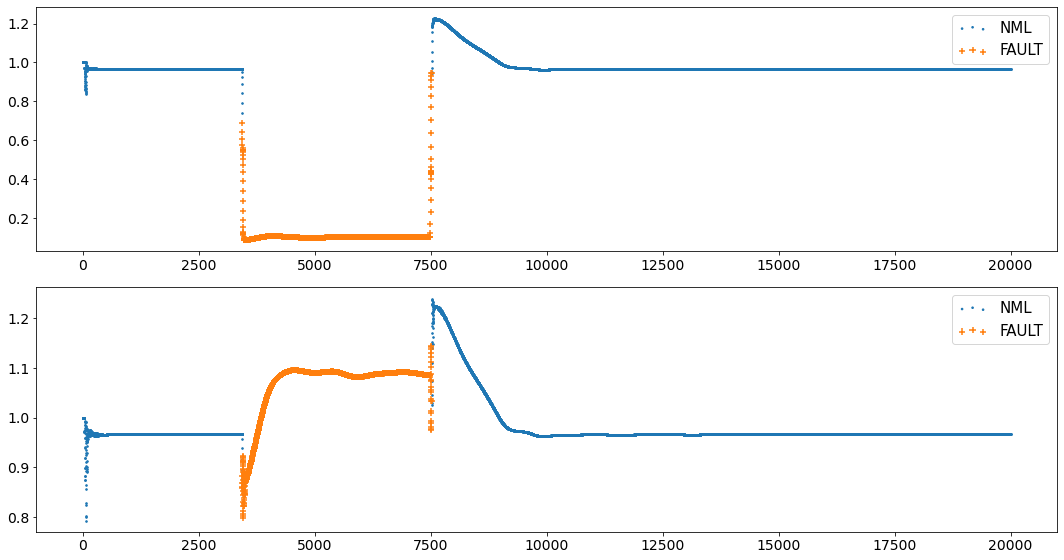

  Fault type Percentage
0         AB     99.95%
1        ABG      0.05%


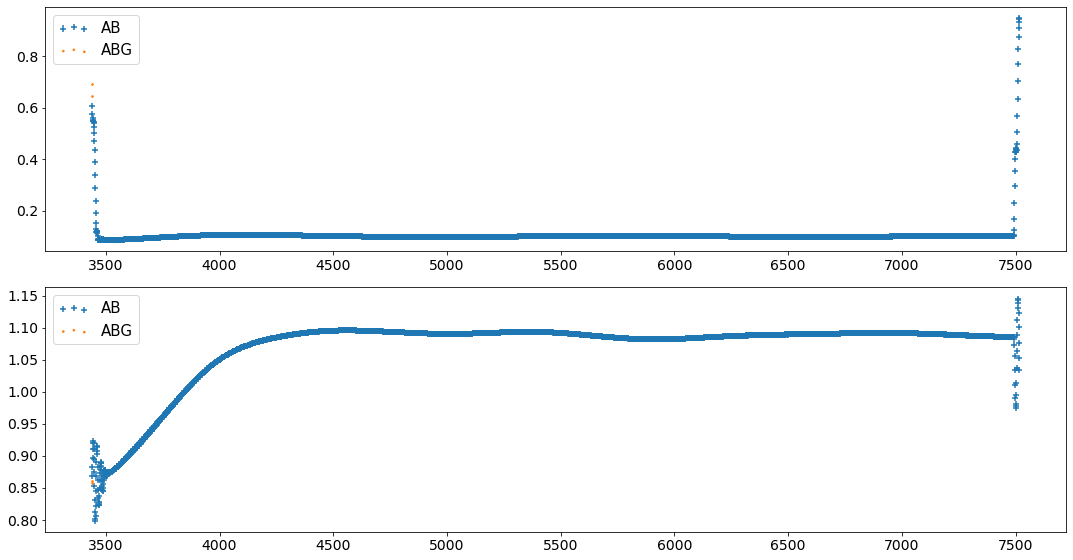


.
.
 9ACG.csv
  Fault type Percentage
0        NML     89.22%
1      FAULT     10.79%


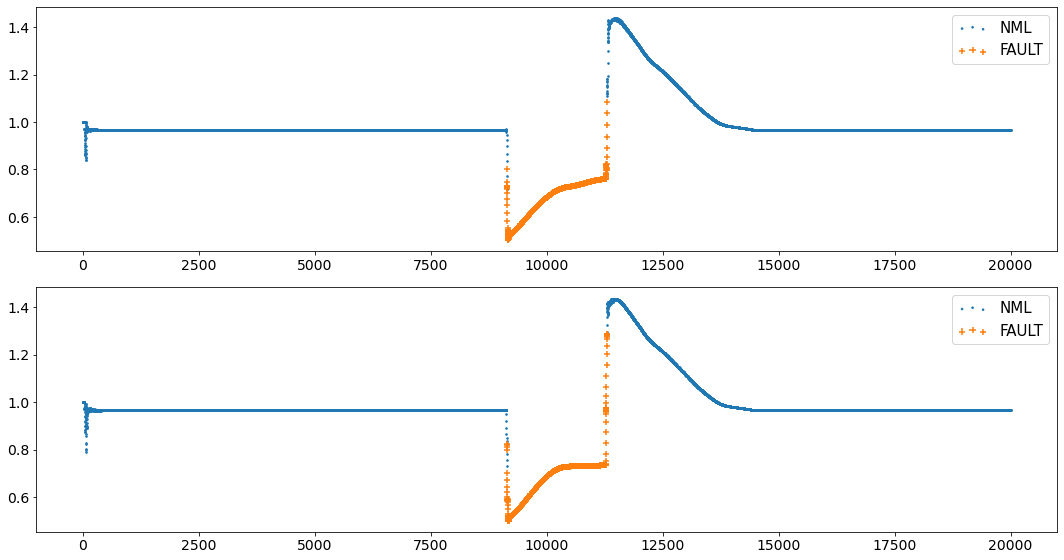

  Fault type Percentage
0        ACG     99.54%
1         AG      0.23%
2        ABC      0.19%
3         AC      0.05%


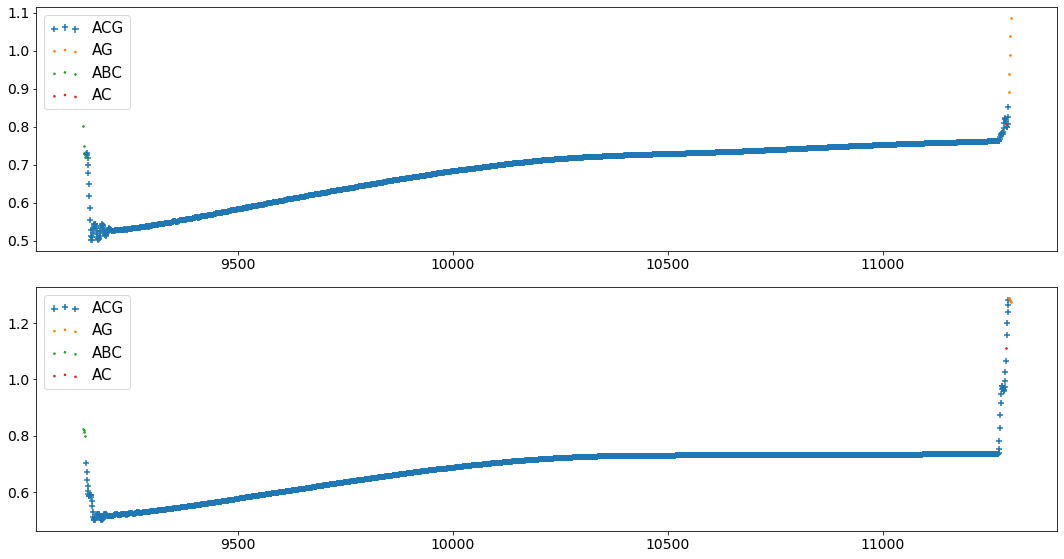


.
.
 9ABC.csv
  Fault type Percentage
0        NML      63.3%
1      FAULT      36.7%


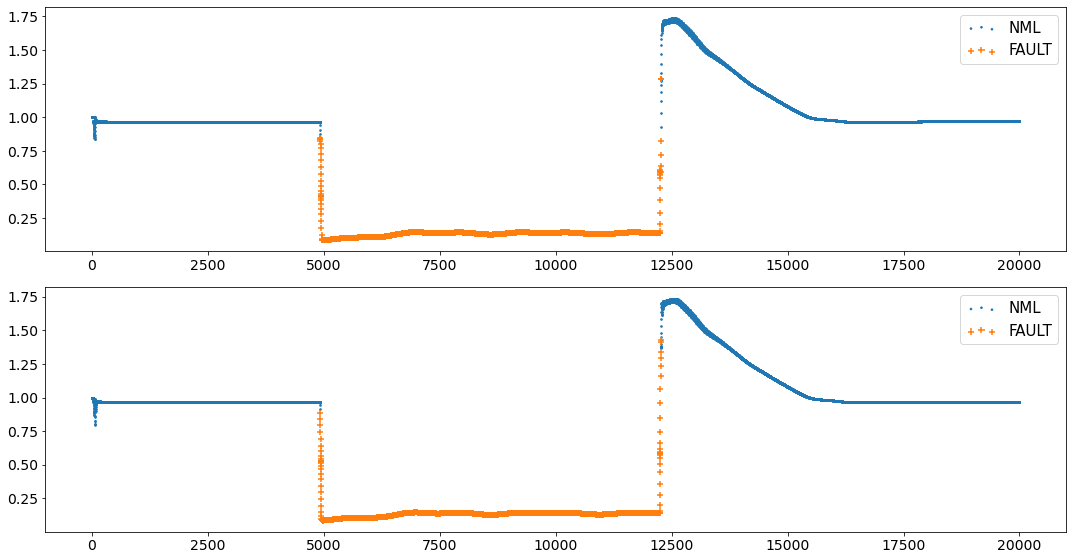

  Fault type Percentage
0        ABC      99.8%
1        ACG      0.15%
2        ABG      0.03%
3         AC      0.01%
4       ABCG      0.01%


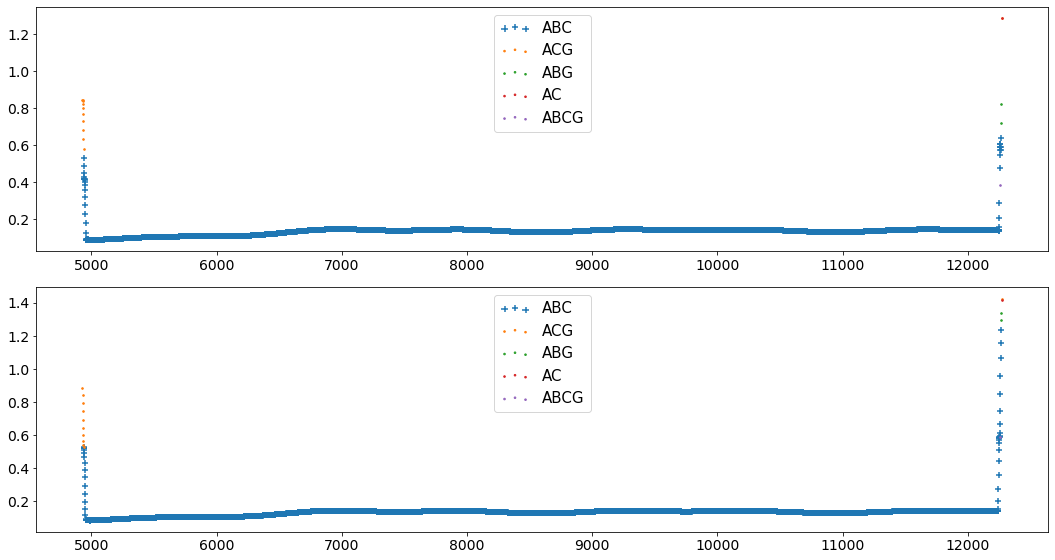


.
.
 5BC.csv
  Fault type Percentage
0        NML     99.64%
1      FAULT      0.36%


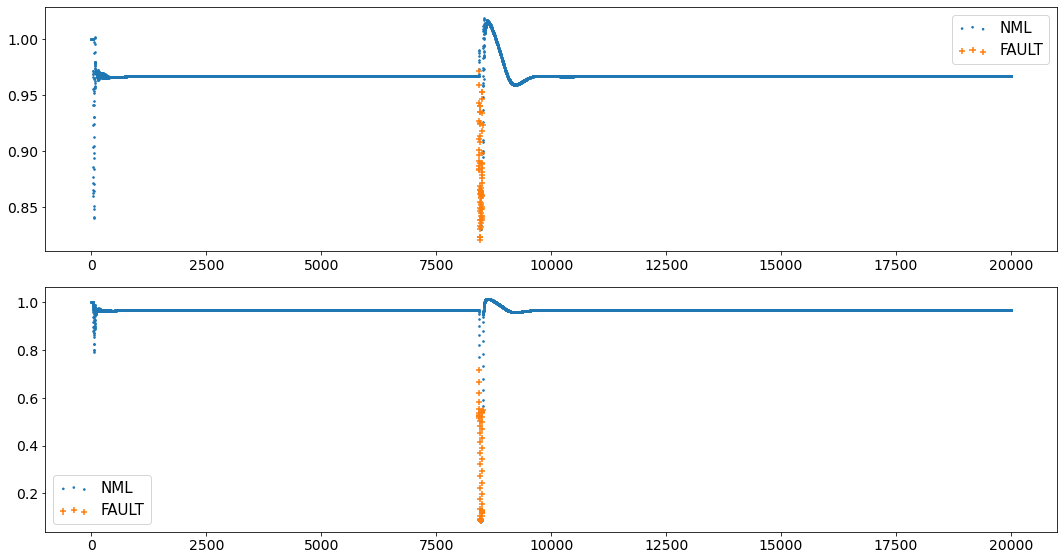

  Fault type Percentage
0         BC     94.52%
1        BCG      5.48%


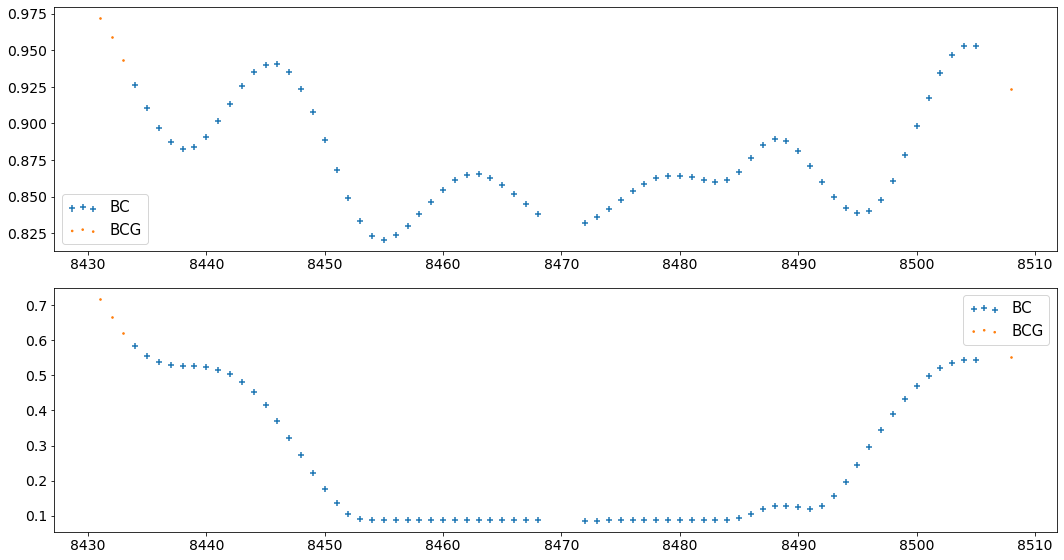


.
.
 5CG.csv
  Fault type Percentage
0        NML     86.86%
1      FAULT     13.13%


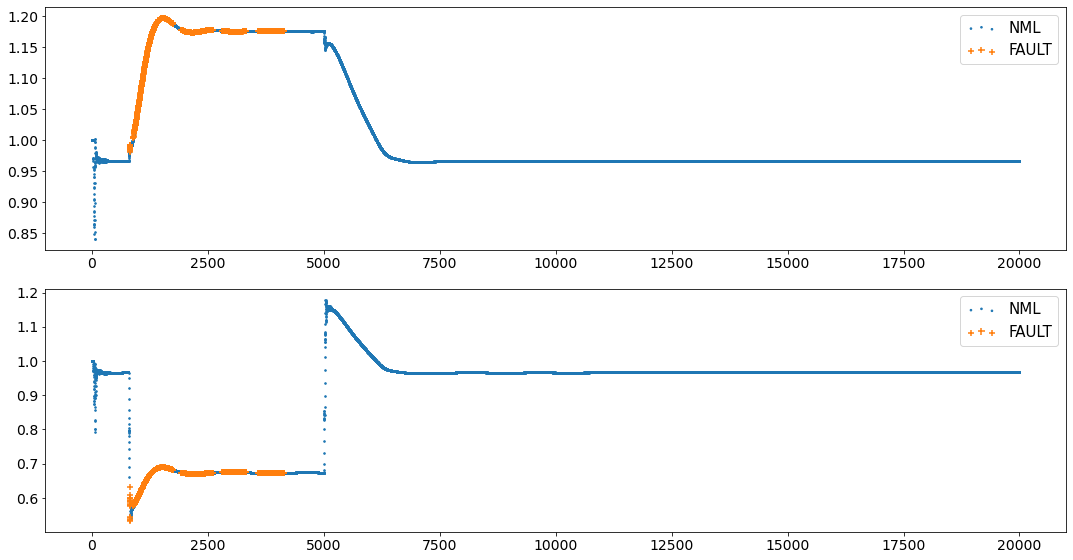

  Fault type Percentage
0         CG     100.0%


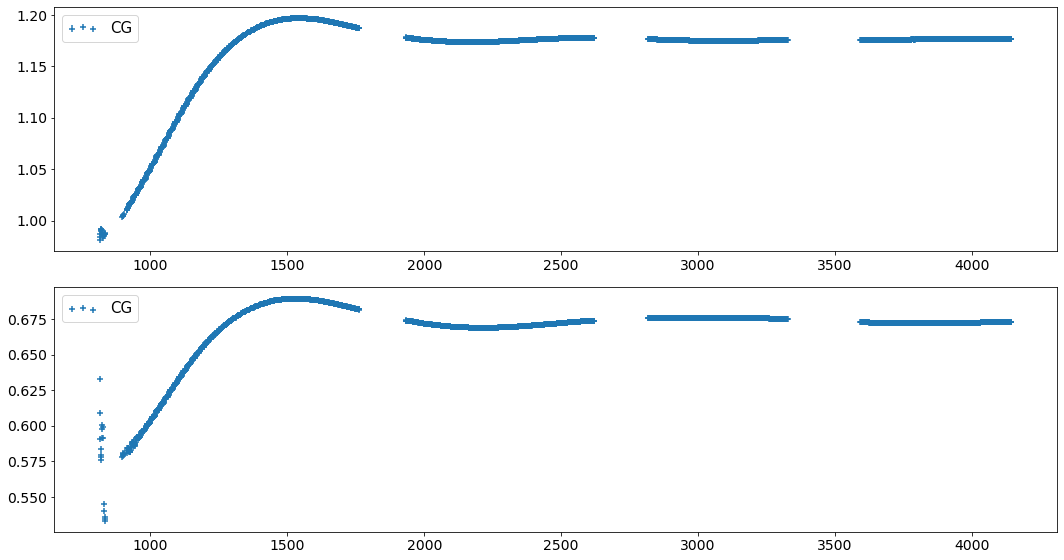


.
.
 4ABCG.csv
  Fault type Percentage
0        NML     93.19%
1      FAULT       6.8%


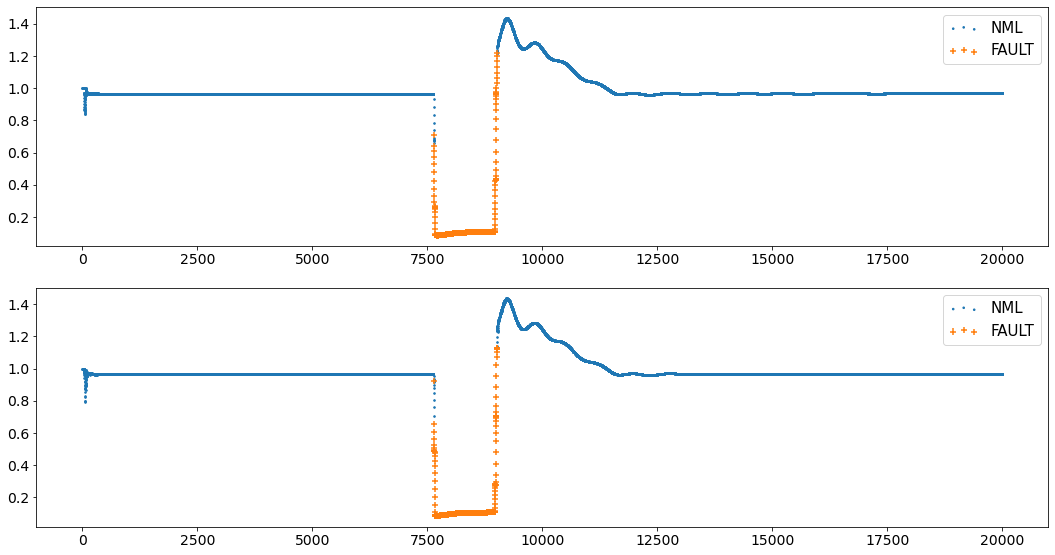

  Fault type Percentage
0        ABC     99.27%
1        ACG      0.66%
2        ABG      0.07%


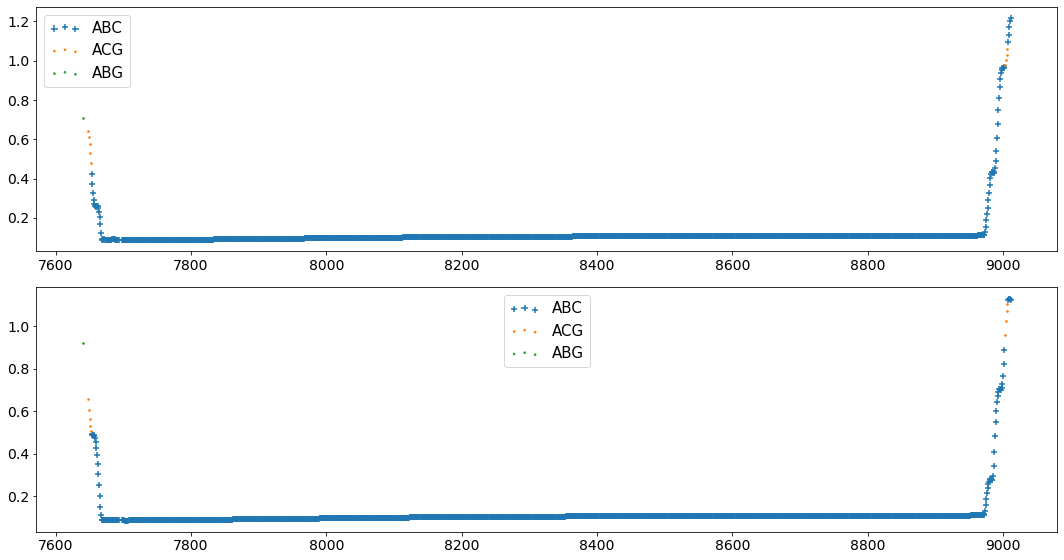


.
.
 7BC.csv
  Fault type Percentage
0        NML     99.46%
1      FAULT      0.54%


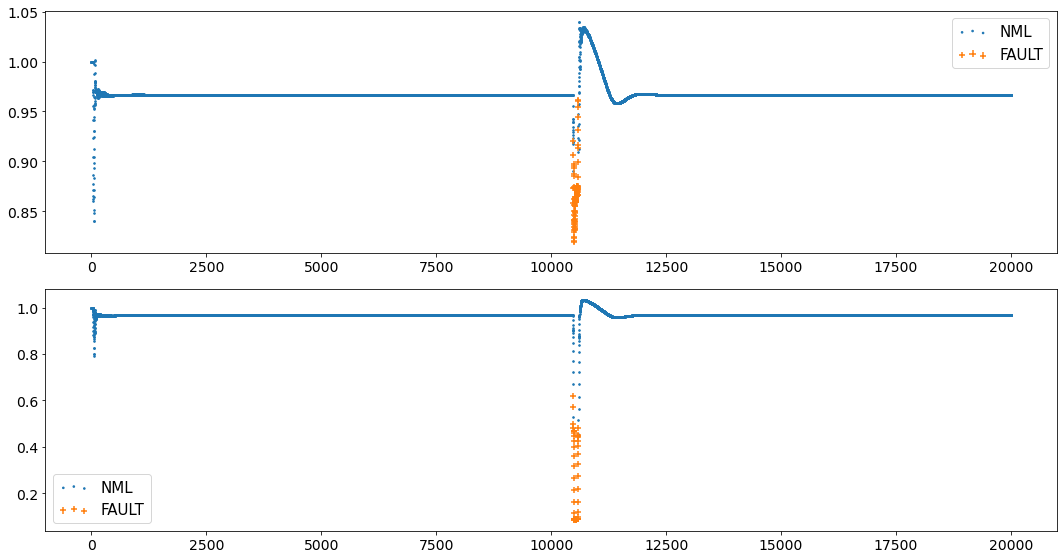

  Fault type Percentage
0         BC      96.3%
1        BCG       3.7%


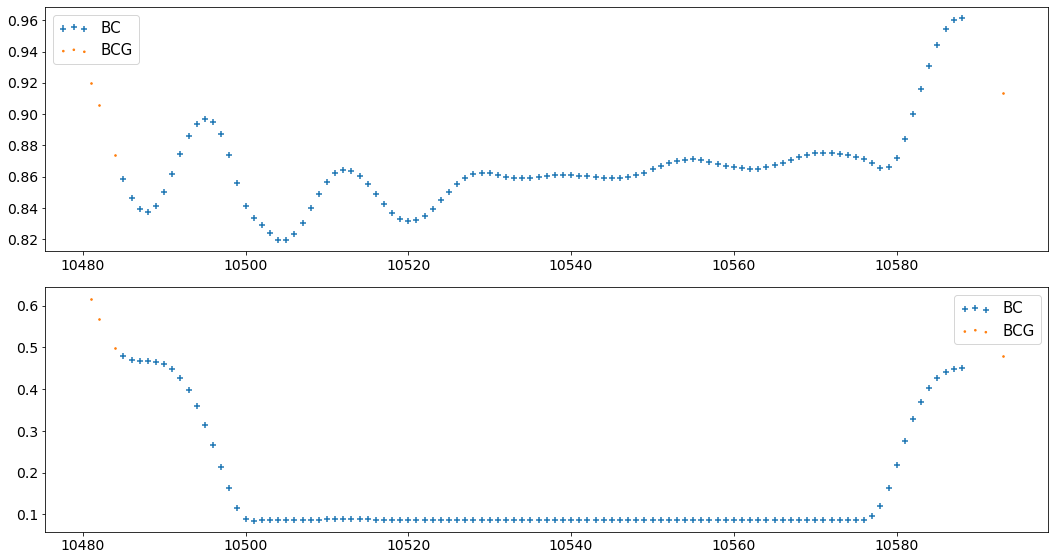


.
.
 7CG.csv
  Fault type Percentage
0        NML     86.83%
1      FAULT     13.16%


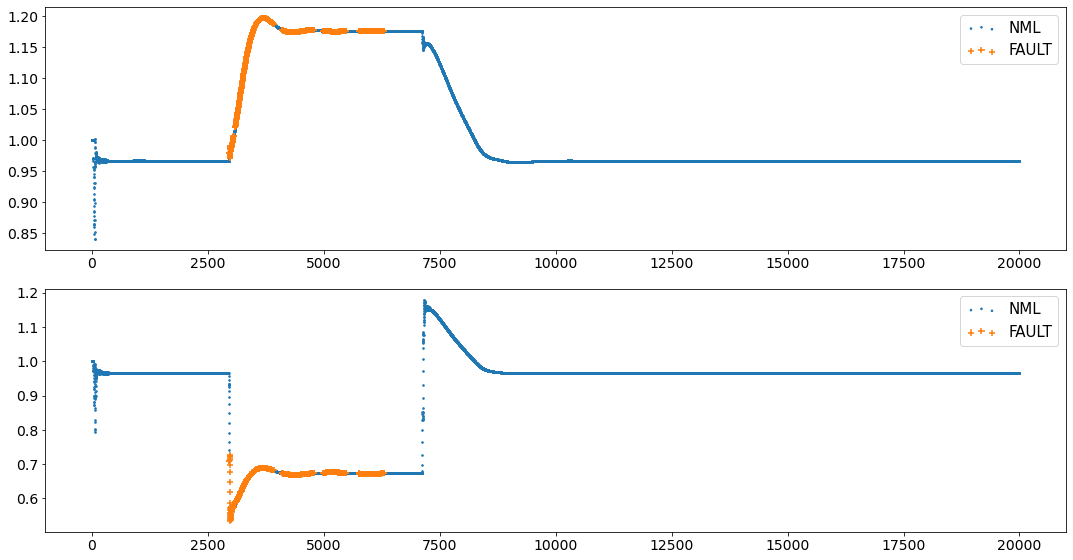

  Fault type Percentage
0         CG     100.0%


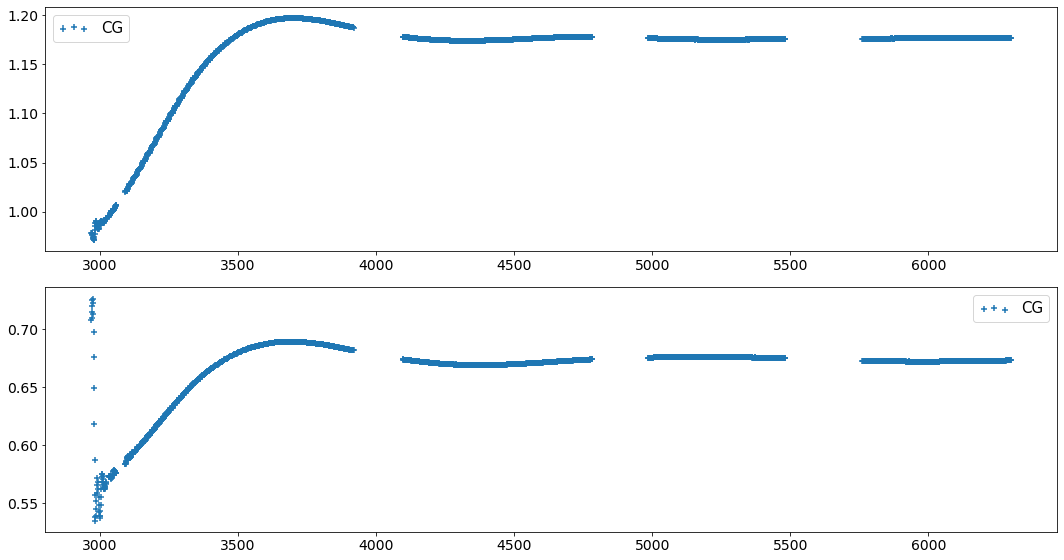


.
.
 10ACG.csv
  Fault type Percentage
0        NML     87.84%
1      FAULT     12.16%


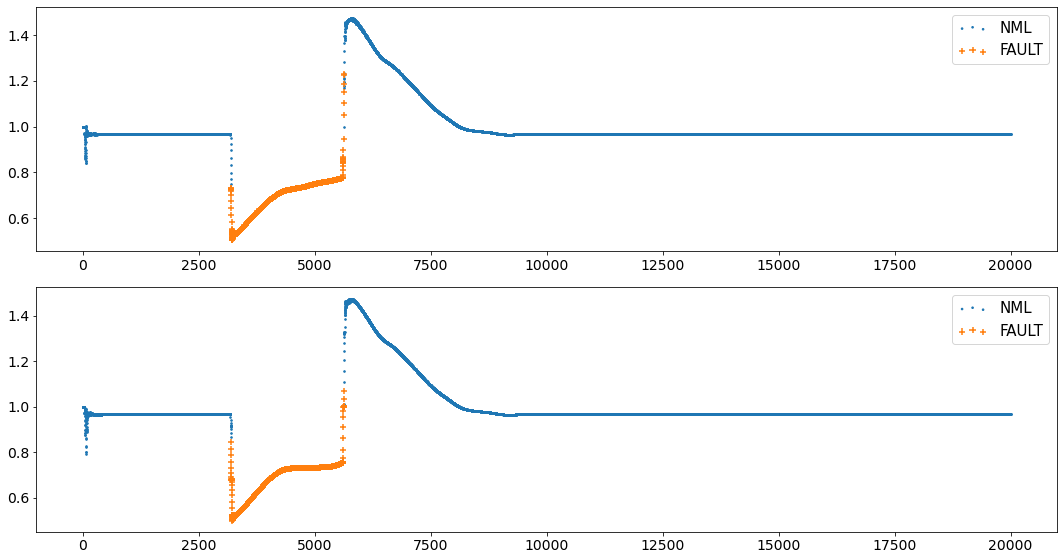

  Fault type Percentage
0        ACG     99.88%
1         AG      0.08%
2         CG      0.04%


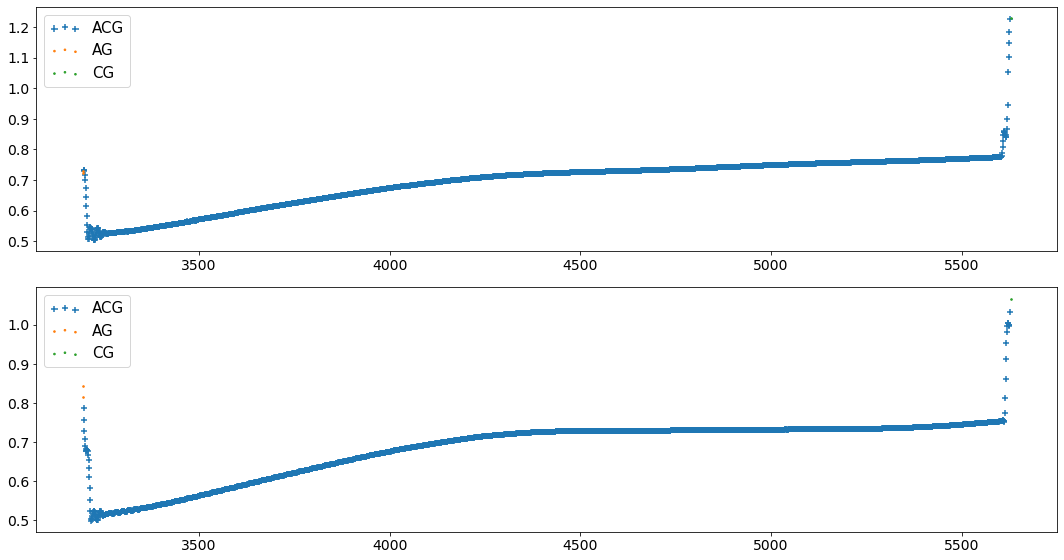


.
.
 3BG.csv
  Fault type Percentage
0        NML     94.13%
1      FAULT      5.87%


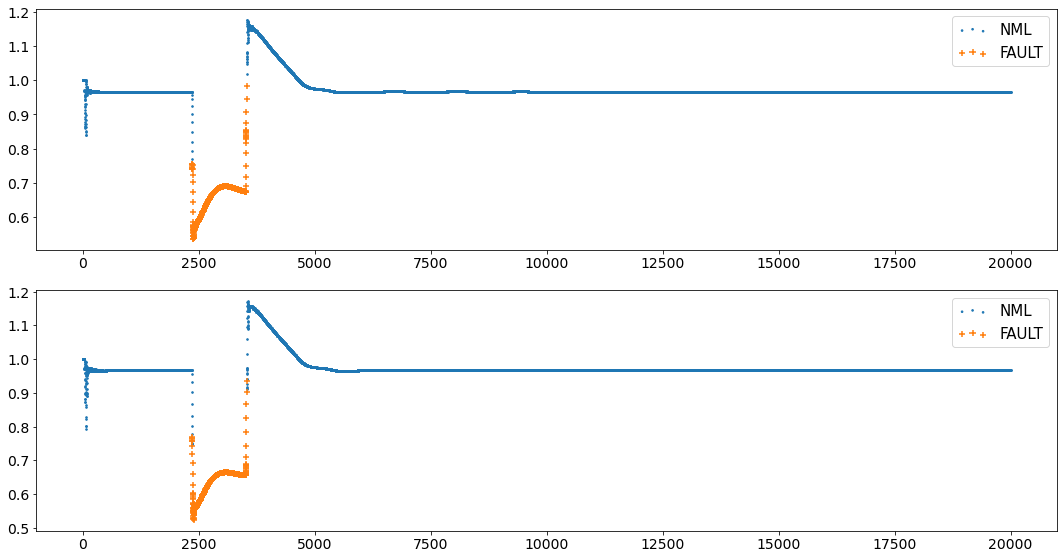

  Fault type Percentage
0         BG     100.0%


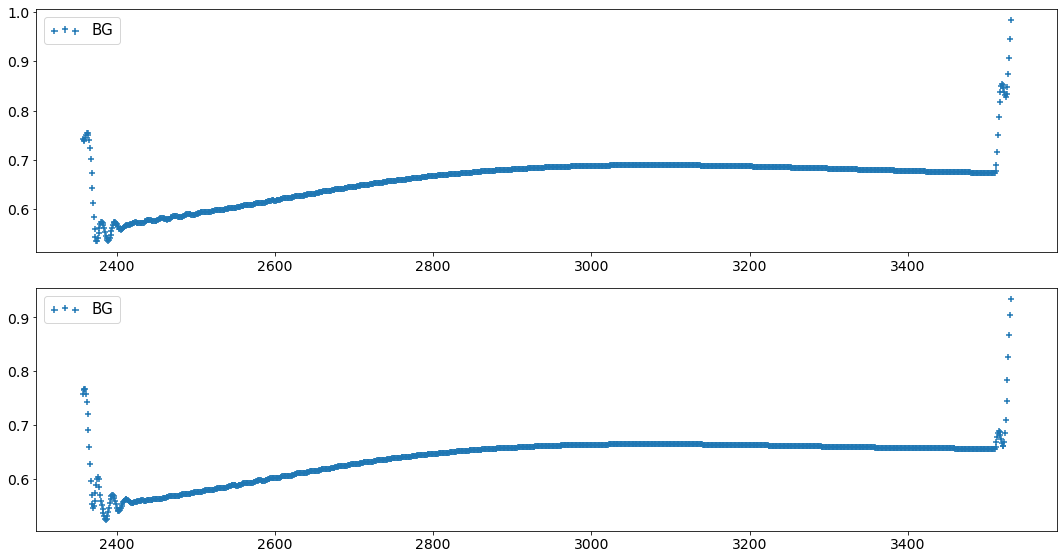


.
.
 10ABC.csv
  Fault type Percentage
0        NML     90.67%
1      FAULT      9.34%


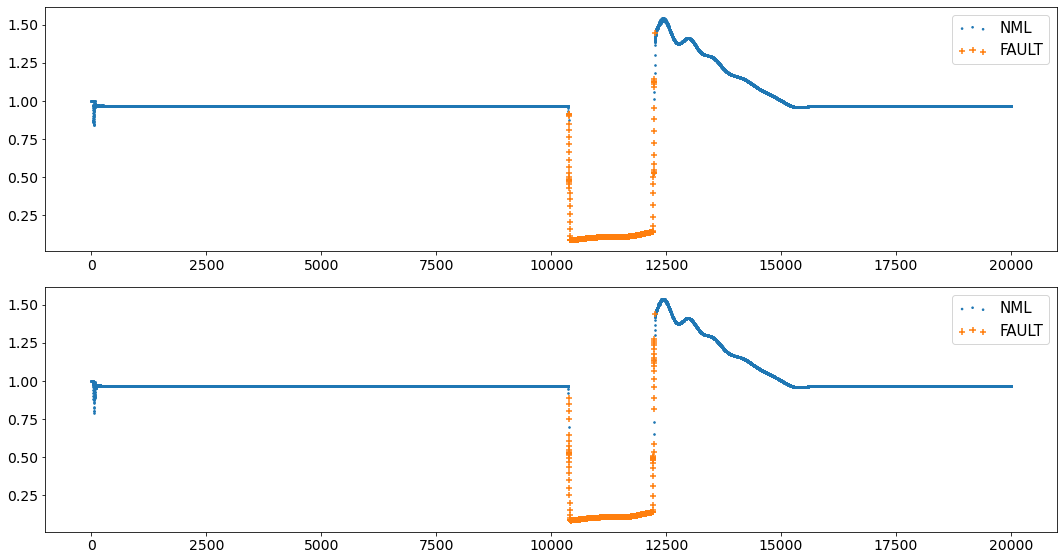

  Fault type Percentage
0        ABC     99.41%
1        ACG      0.37%
2        BCG      0.21%


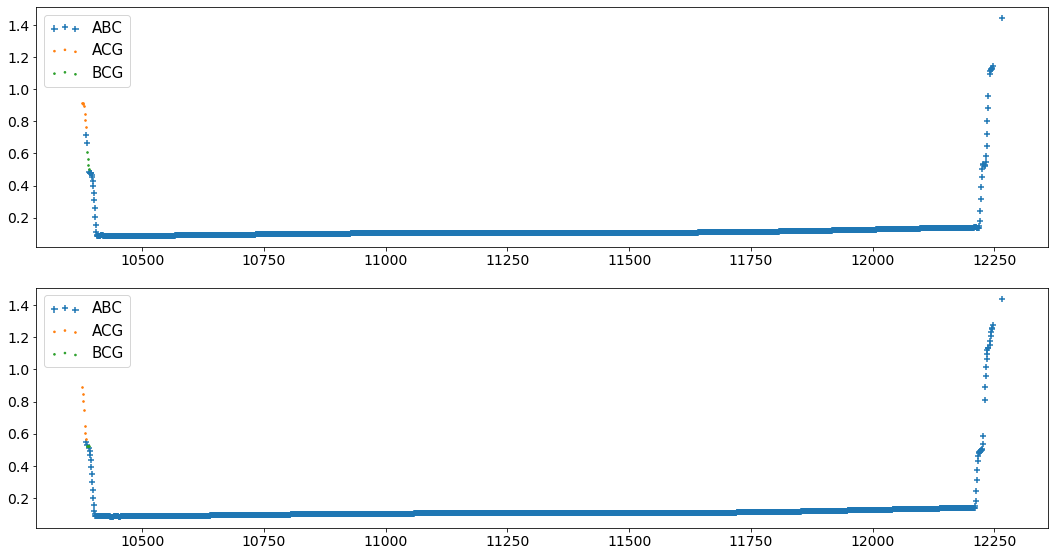


.
.
 3BCG.csv
  Fault type Percentage
0        NML     95.13%
1      FAULT      4.87%


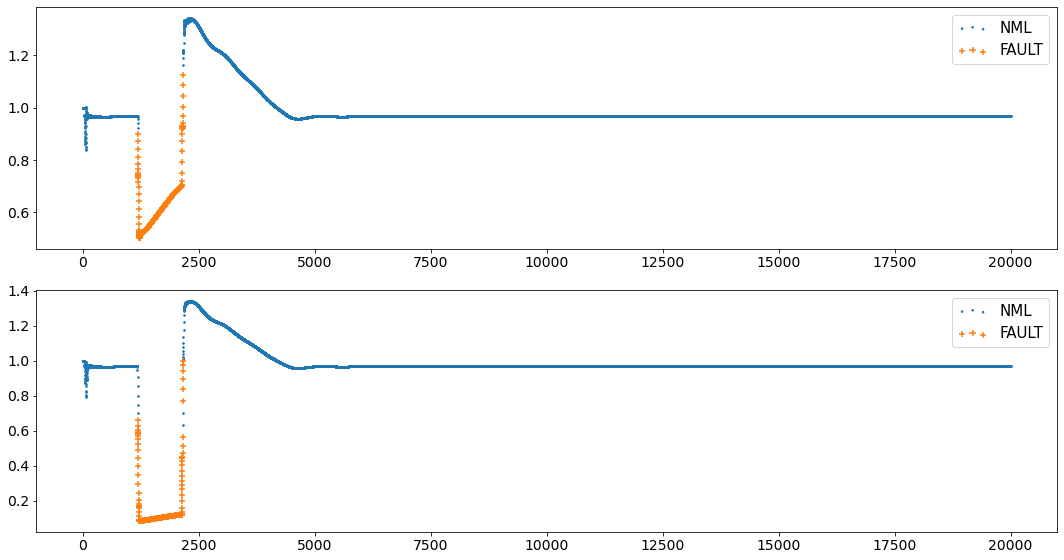

  Fault type Percentage
0        BCG     100.0%


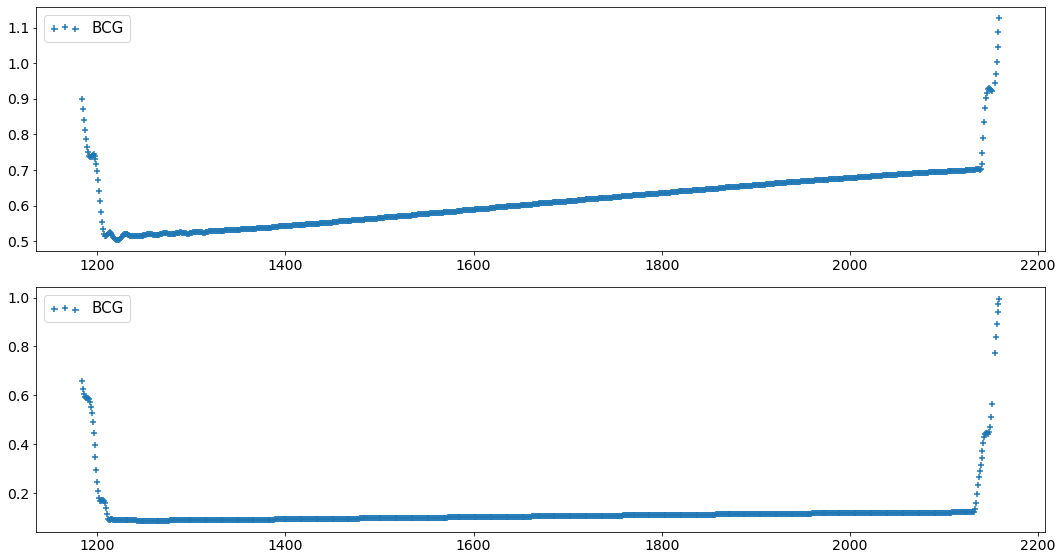


.
.
 4BG.csv
  Fault type Percentage
0        NML     73.52%
1      FAULT     26.48%


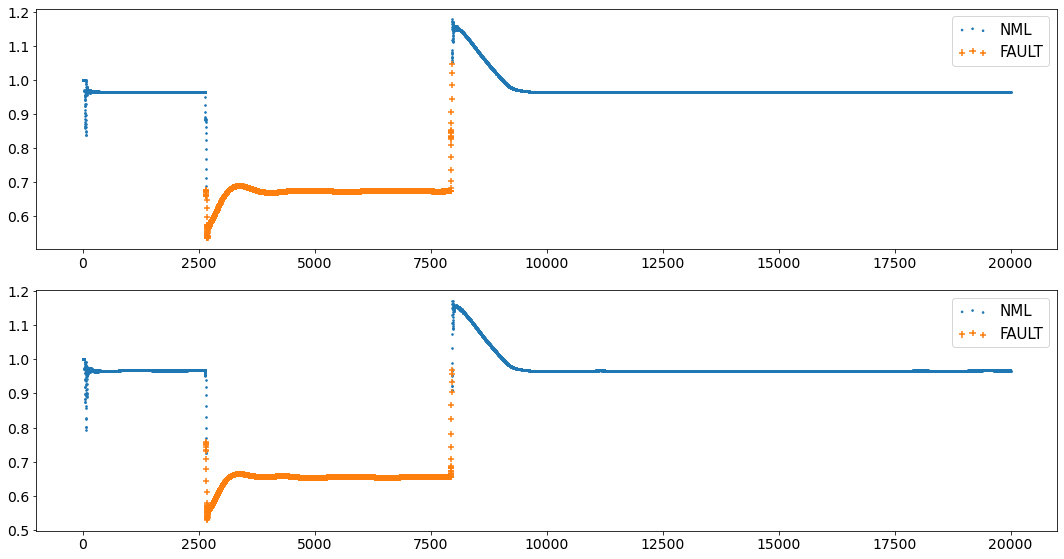

  Fault type Percentage
0         BG     100.0%


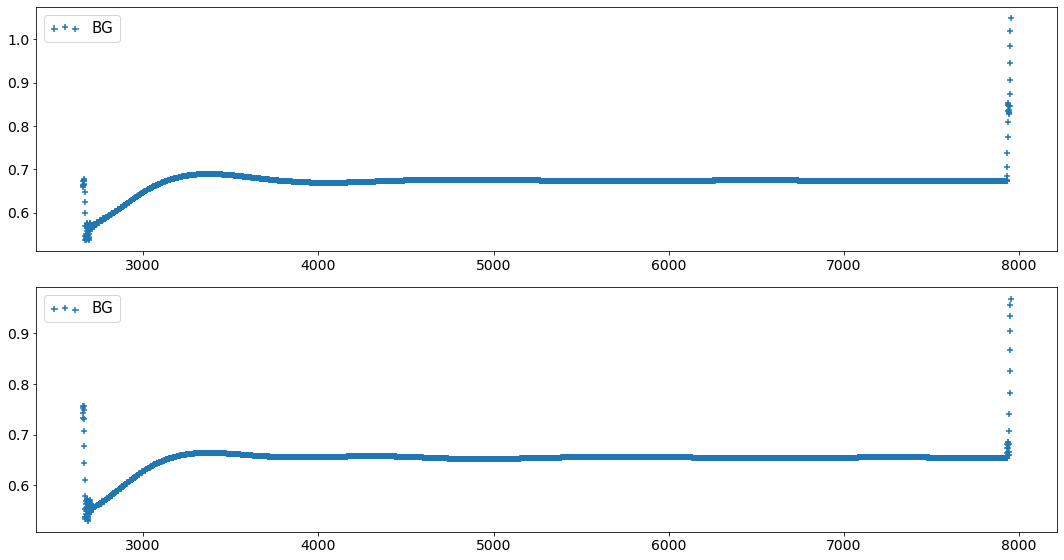


.
.
 1ABC.csv
  Fault type Percentage
0        NML     73.52%
1      FAULT     26.48%


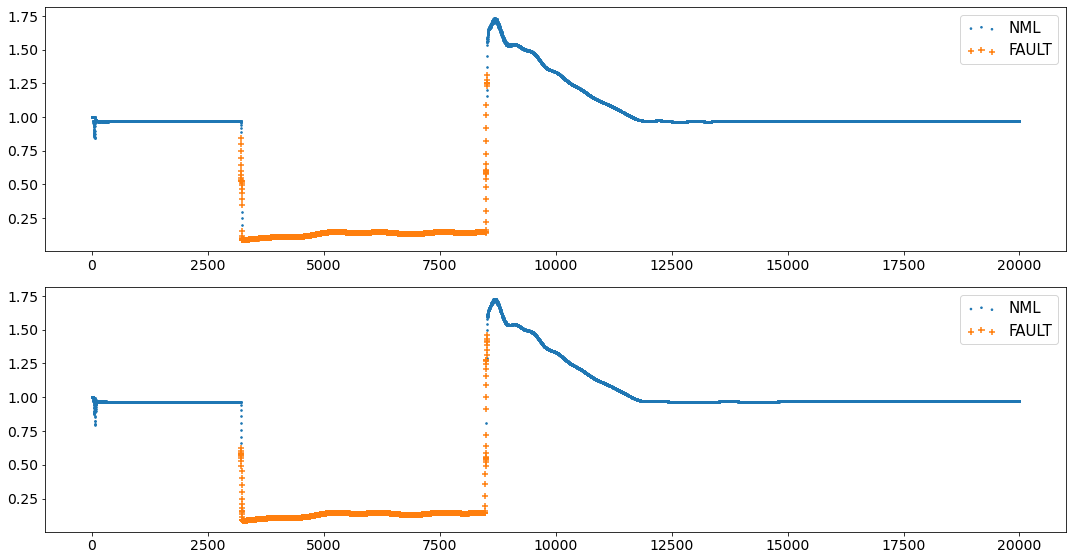

  Fault type Percentage
0        ABC     99.85%
1        BCG      0.15%


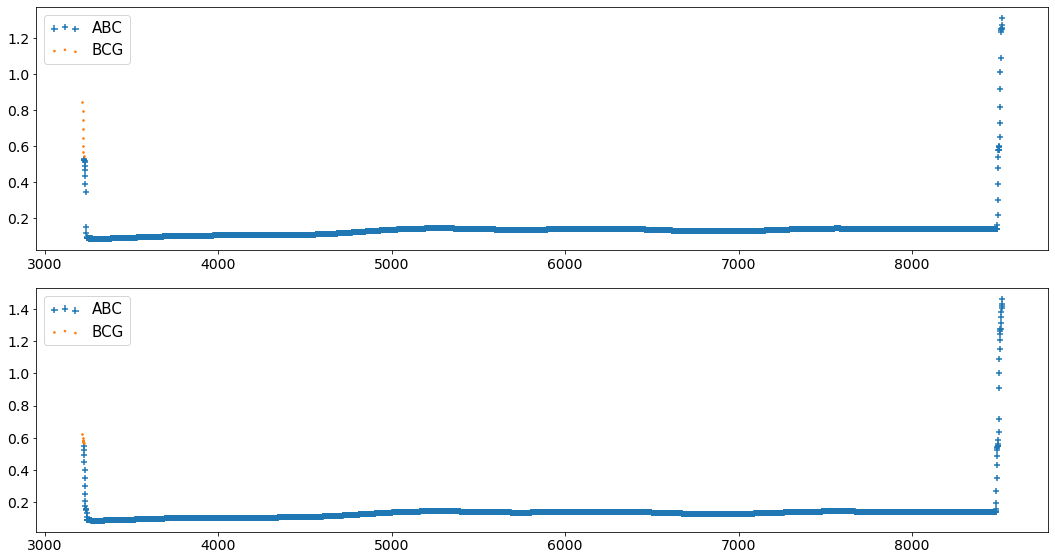


.
.
 1ACG.csv
  Fault type Percentage
0        NML     95.19%
1      FAULT      4.82%


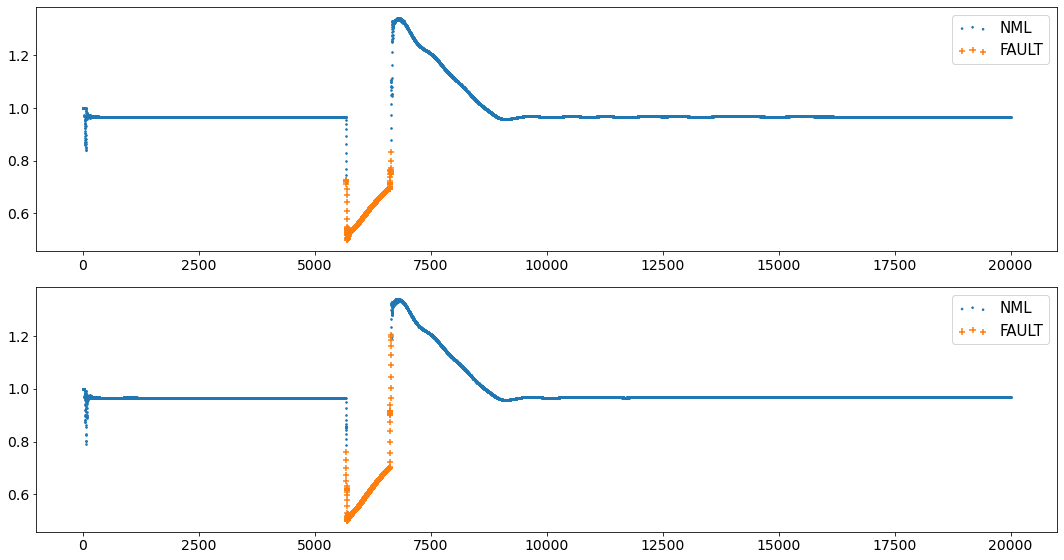

  Fault type Percentage
0        ACG     100.0%


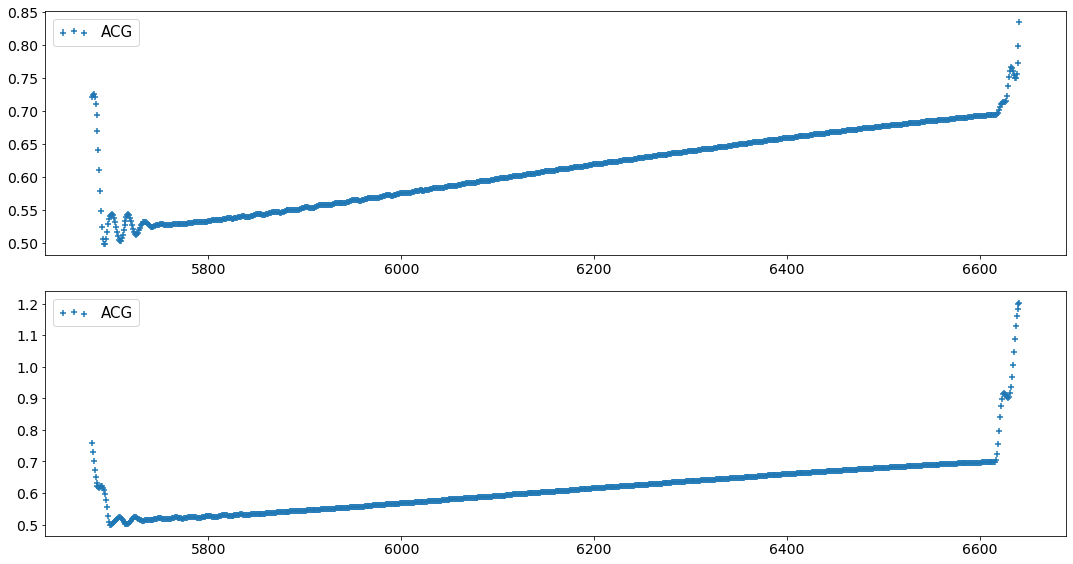


.
.
 8AG.csv
  Fault type Percentage
0        NML     97.46%
1      FAULT      2.54%


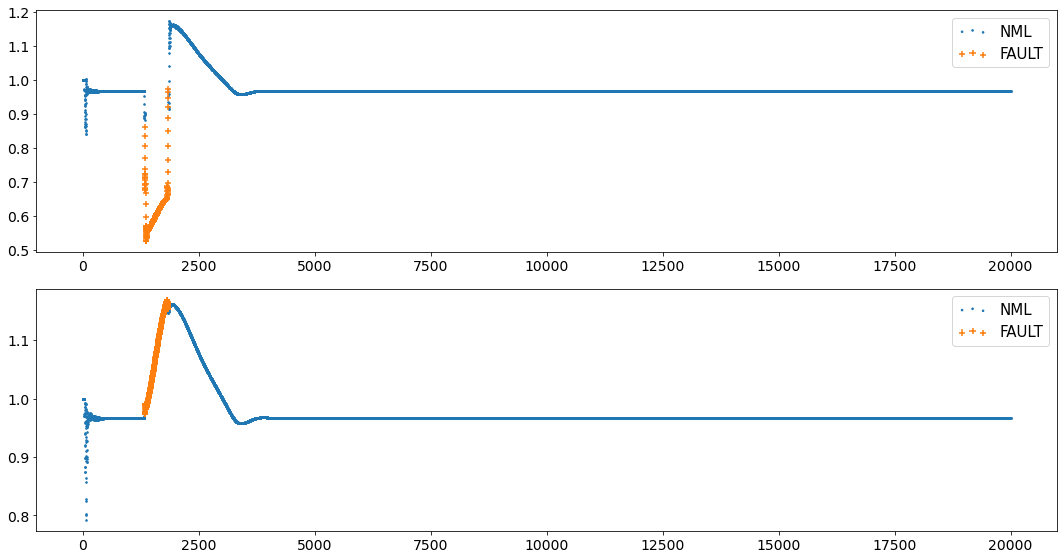

  Fault type Percentage
0         AG     100.0%


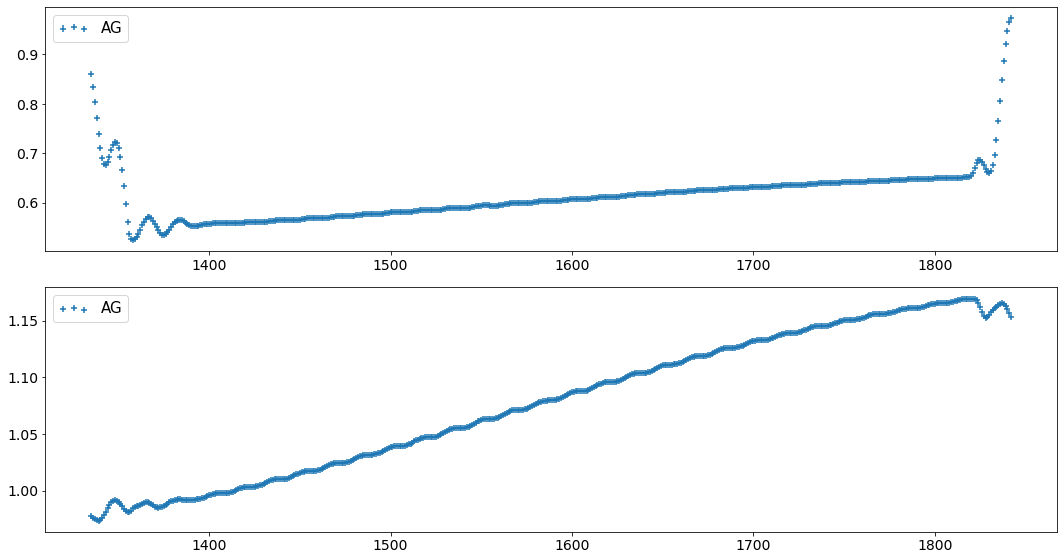


.
.
 3ABG.csv
  Fault type Percentage
0        NML     98.49%
1      FAULT      1.51%


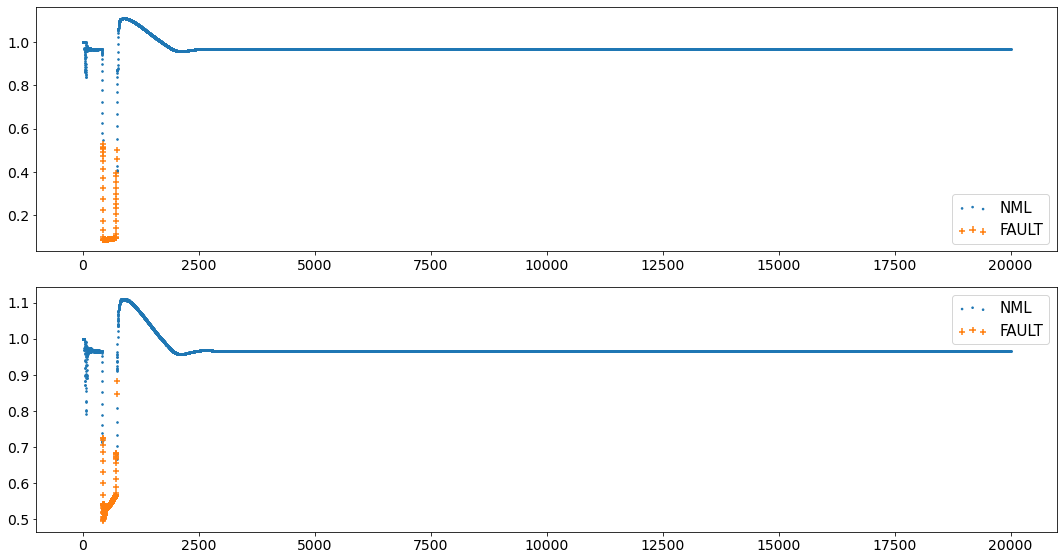

  Fault type Percentage
0        ABG     100.0%


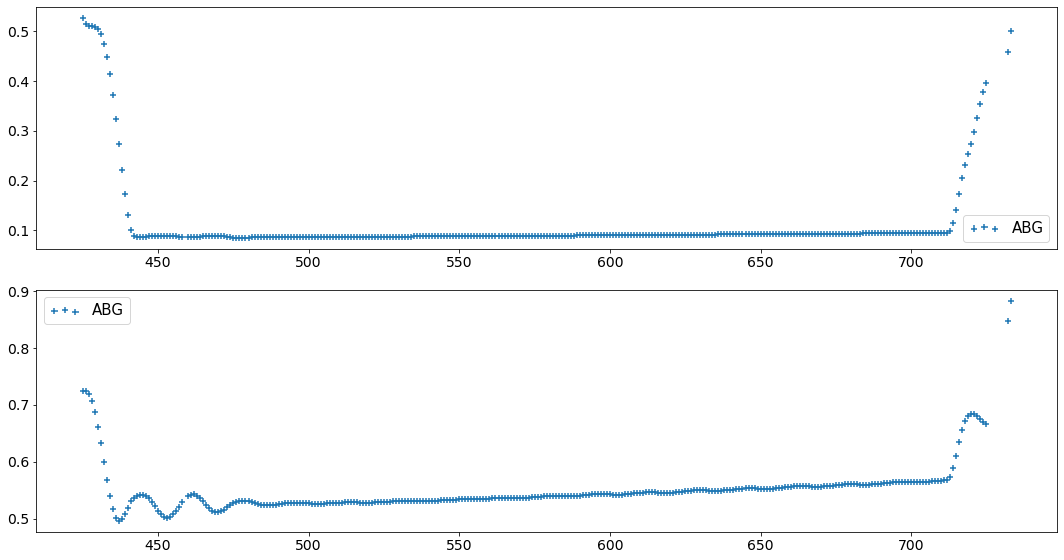


.
.
 10AC.csv
  Fault type Percentage
0        NML     98.02%
1      FAULT      1.99%


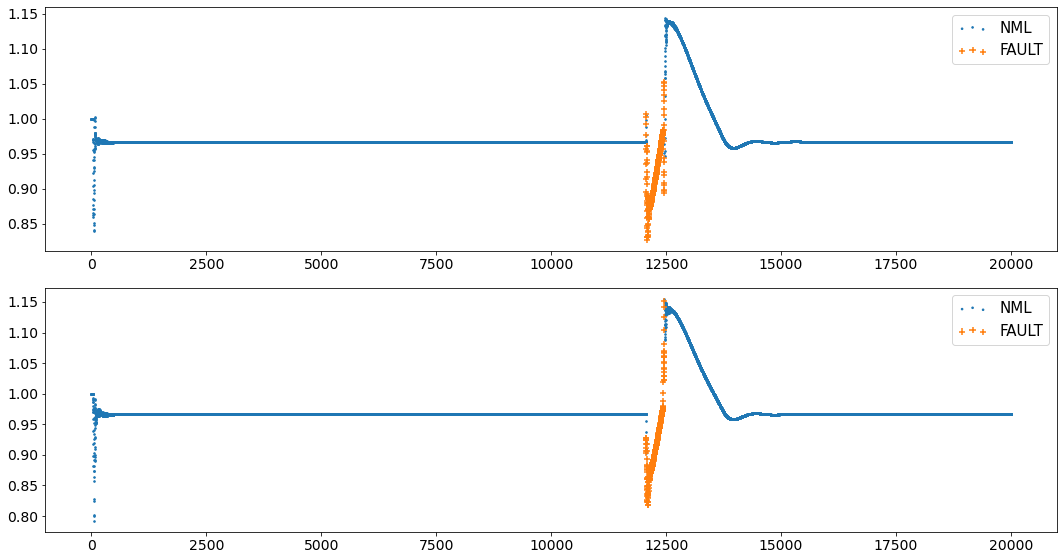

  Fault type Percentage
0         AC     93.45%
1        ACG      6.55%


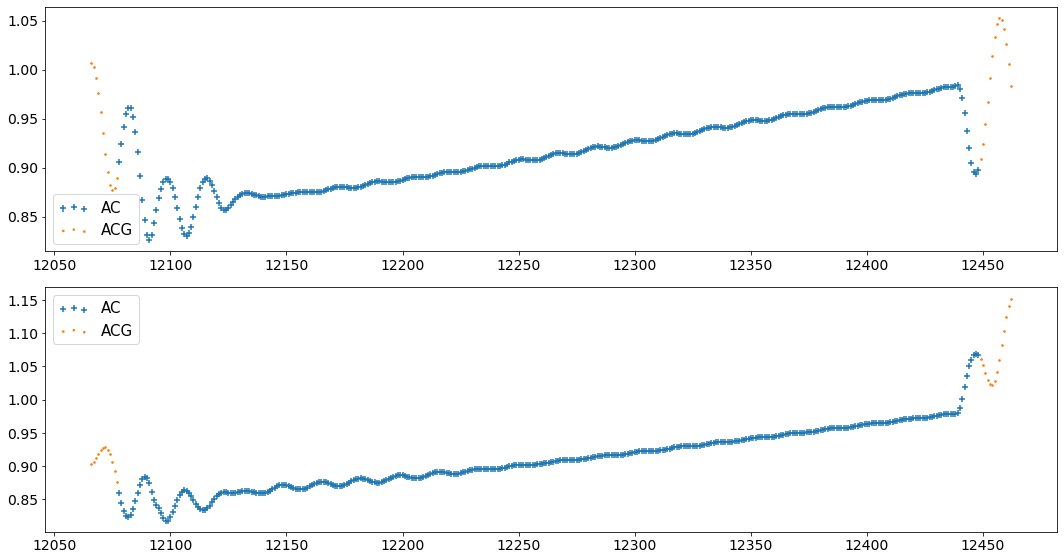


.
.
 7BCG.csv
  Fault type Percentage
0        NML     88.49%
1      FAULT     11.51%


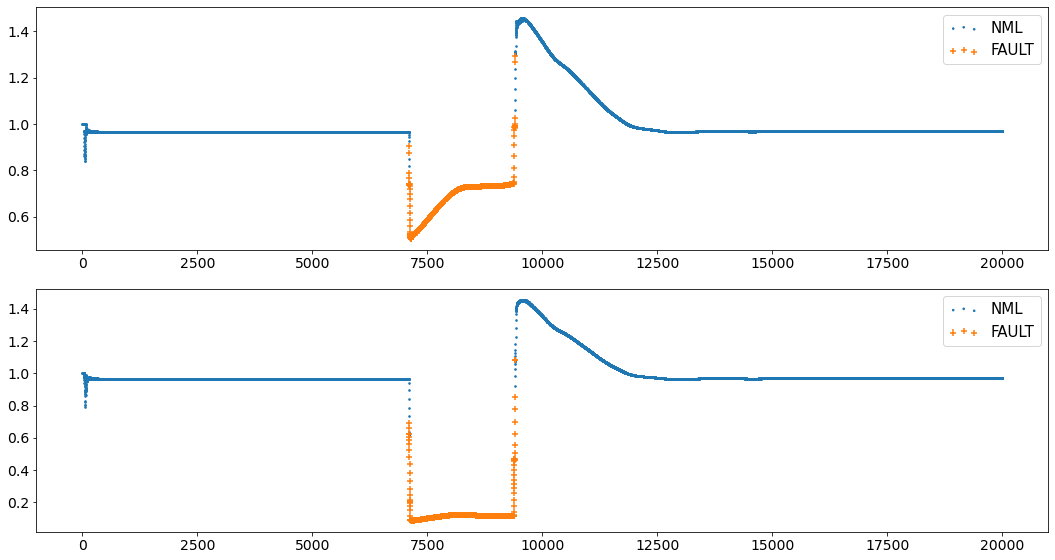

  Fault type Percentage
0        BCG     99.91%
1         AB      0.09%


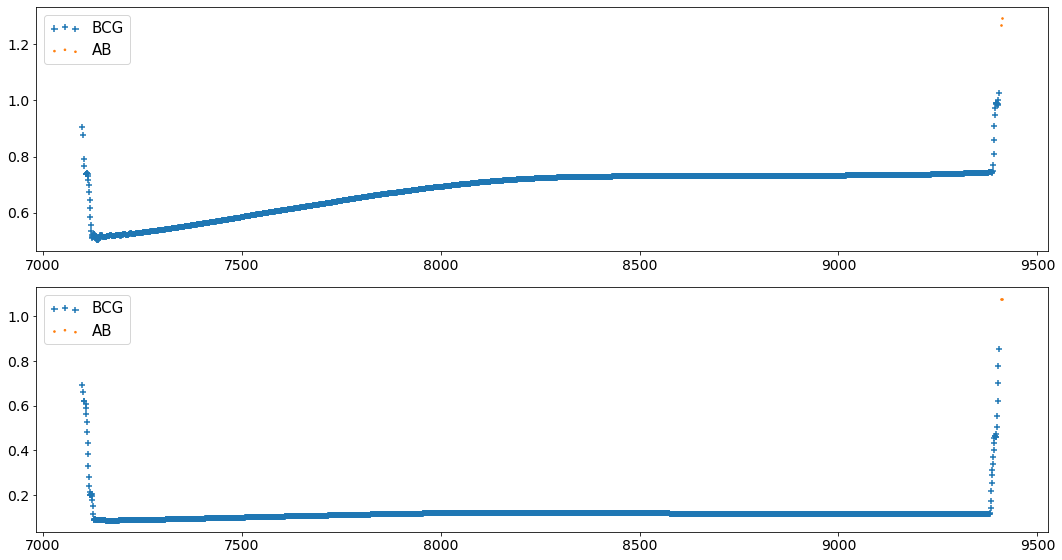


.
.
 6ABCG.csv
  Fault type Percentage
0        NML     92.98%
1      FAULT      7.02%


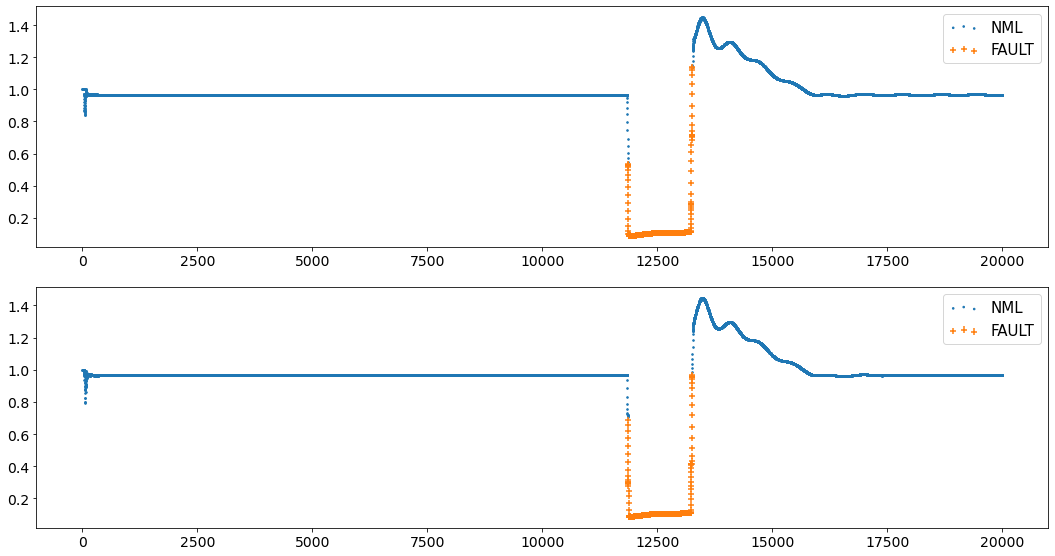

  Fault type Percentage
0        ABC     99.29%
1        ABG      0.36%
2        BCG      0.21%
3       ABCG      0.14%


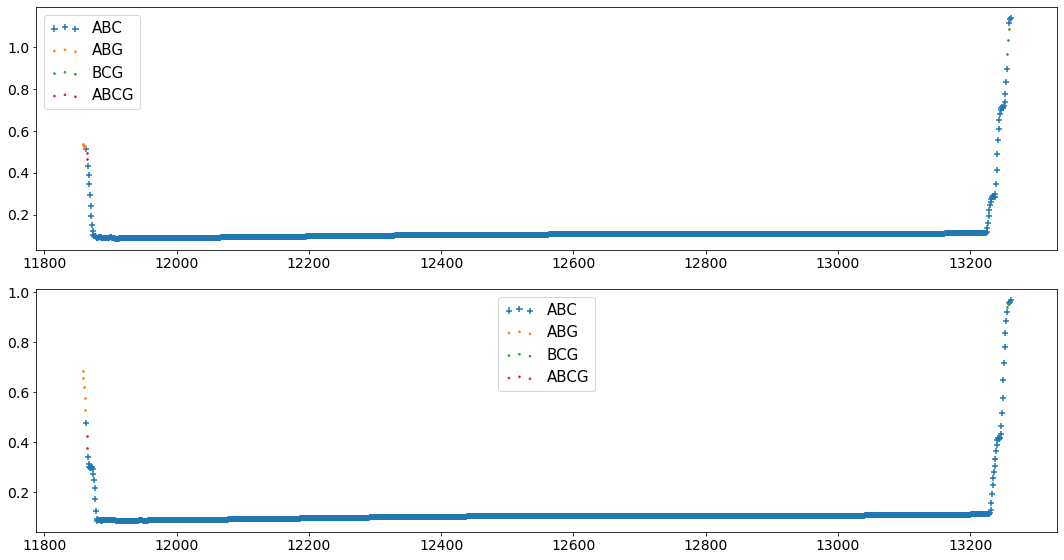


.
.
 6BG.csv
  Fault type Percentage
0        NML     81.39%
1      FAULT     18.61%


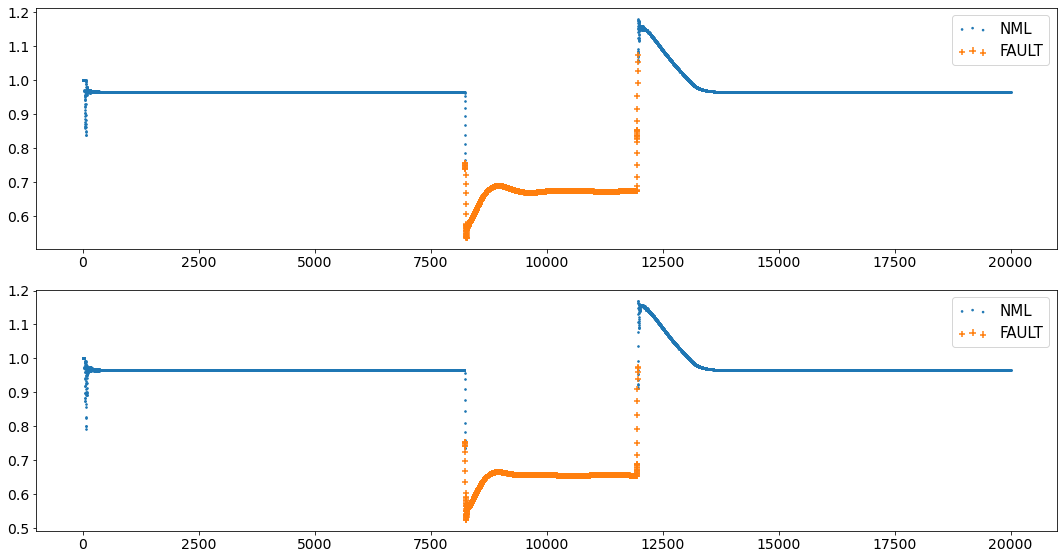

  Fault type Percentage
0         BG     100.0%


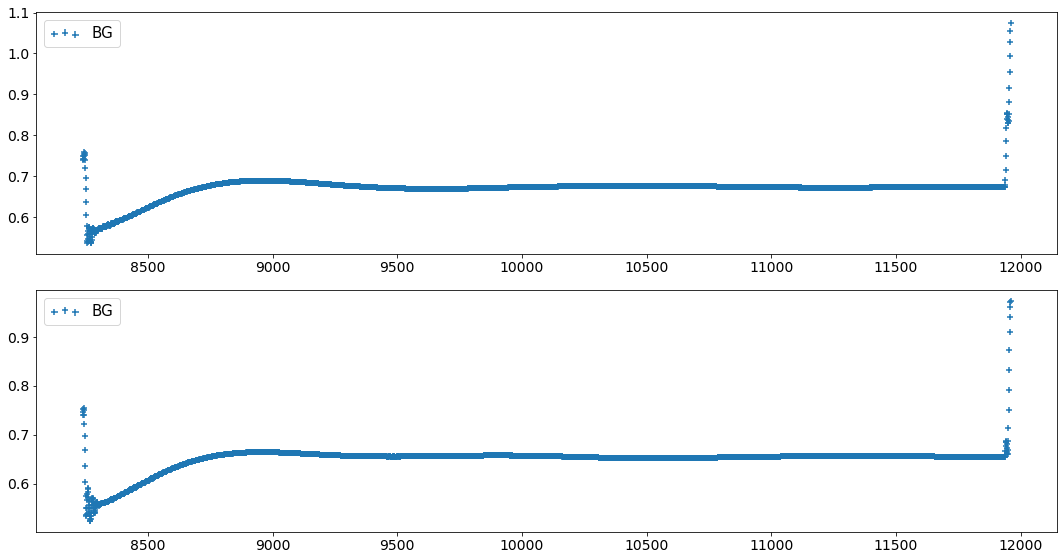


.
.
 10AB.csv
  Fault type Percentage
0        NML     98.58%
1      FAULT      1.42%


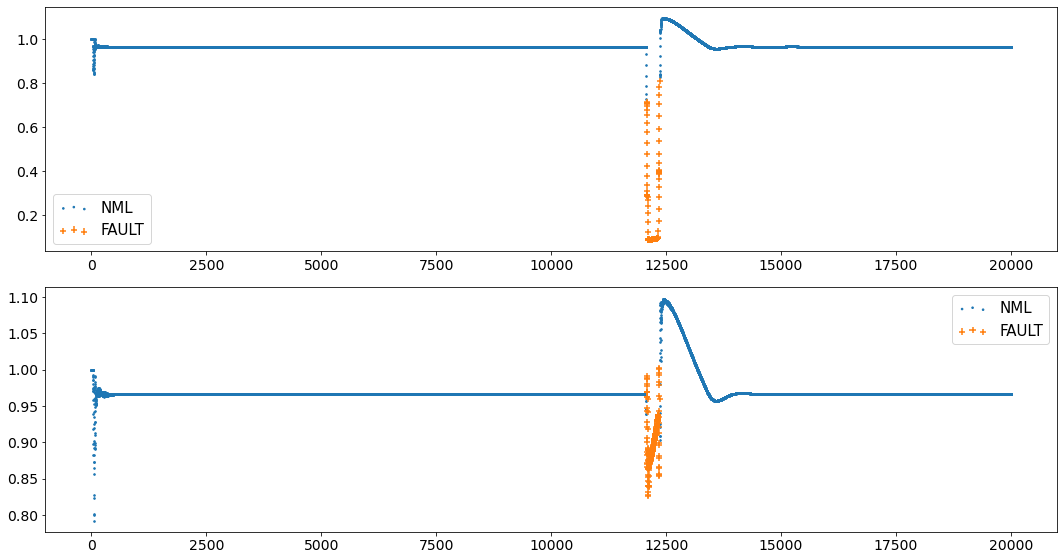

  Fault type Percentage
0         AB      94.7%
1        ABG       5.3%


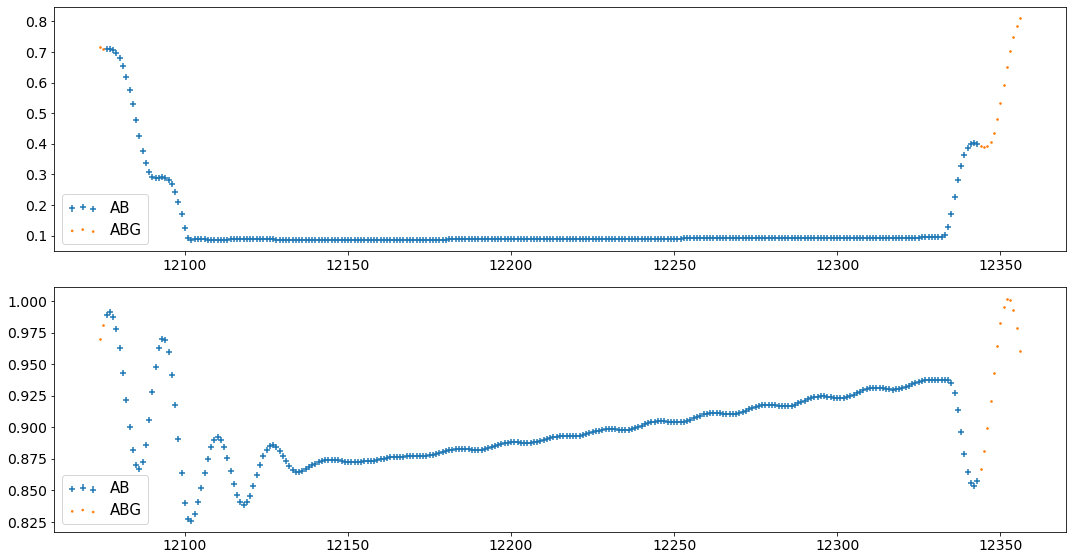


.
.
 2BC.csv
  Fault type Percentage
0        NML     96.92%
1      FAULT      3.08%


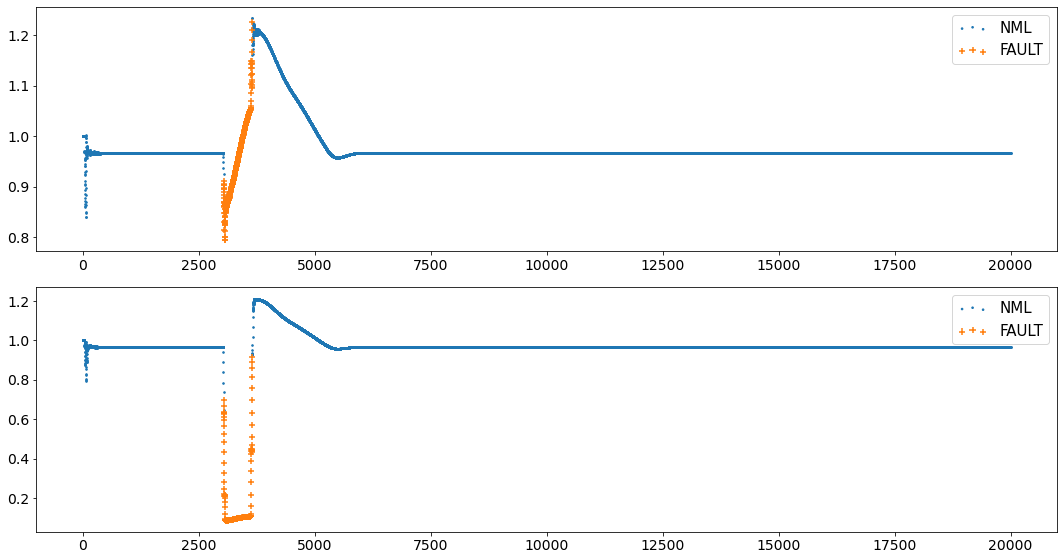

  Fault type Percentage
0         BC     97.24%
1        BCG      2.76%


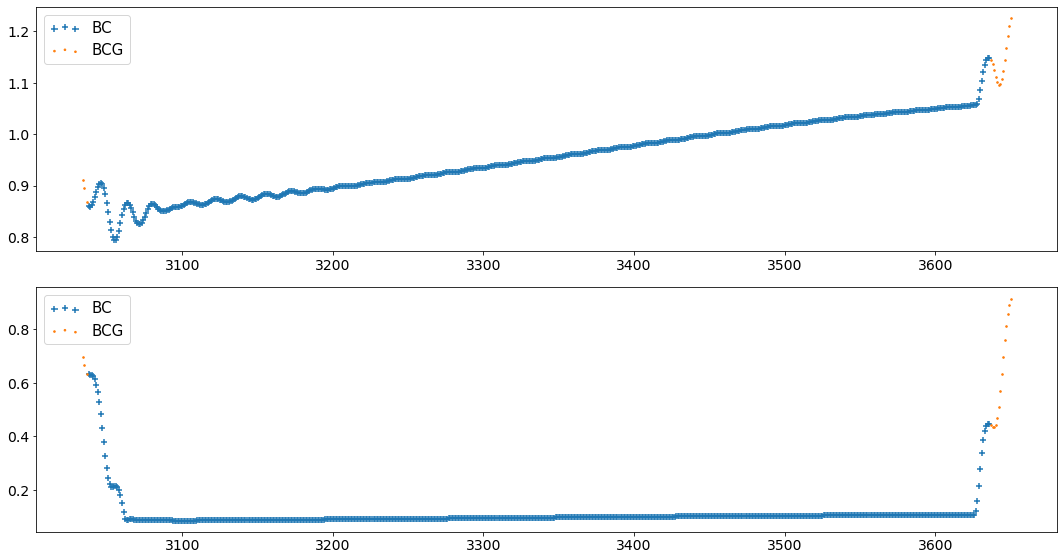


.
.
 2CG.csv
  Fault type Percentage
0        NML     86.83%
1      FAULT     13.17%


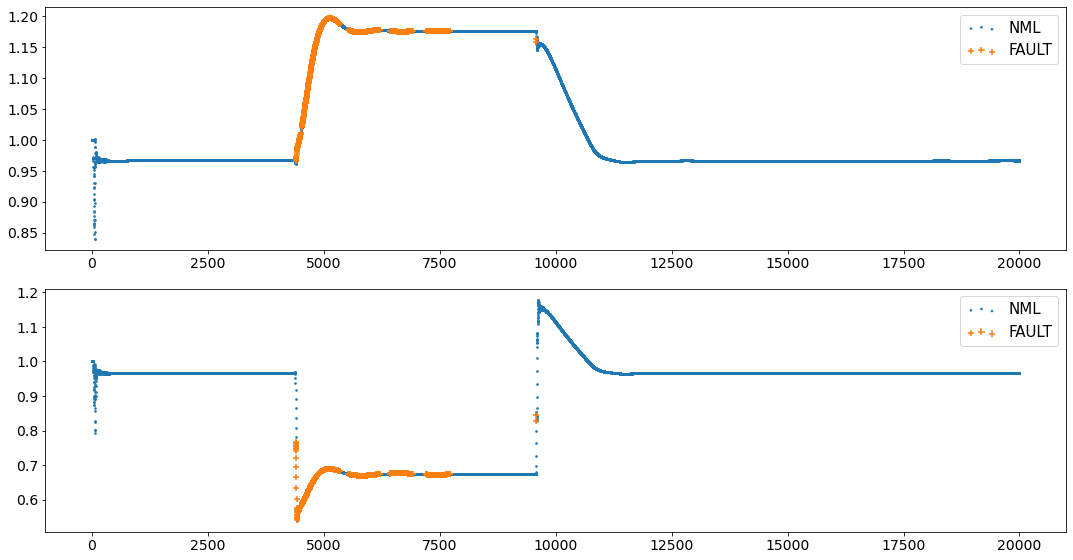

  Fault type Percentage
0         CG     100.0%


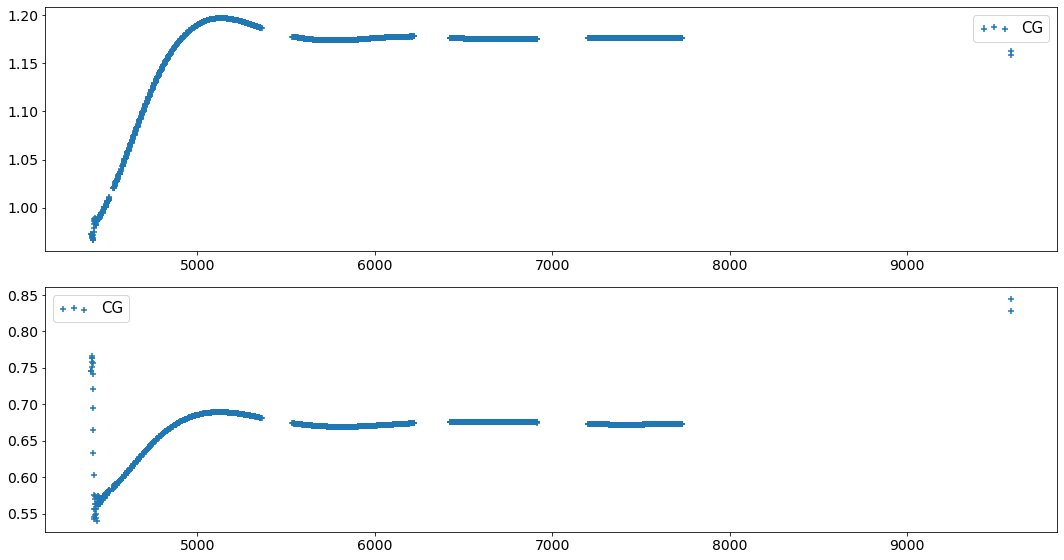


.
.
 5BCG.csv
  Fault type Percentage
0        NML     84.38%
1      FAULT     15.62%


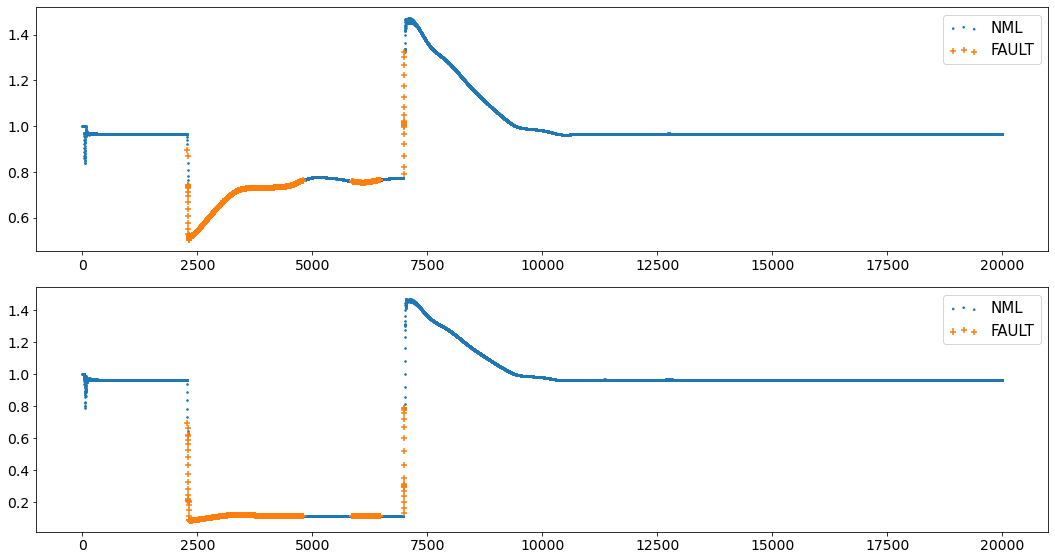

  Fault type Percentage
0        BCG     100.0%


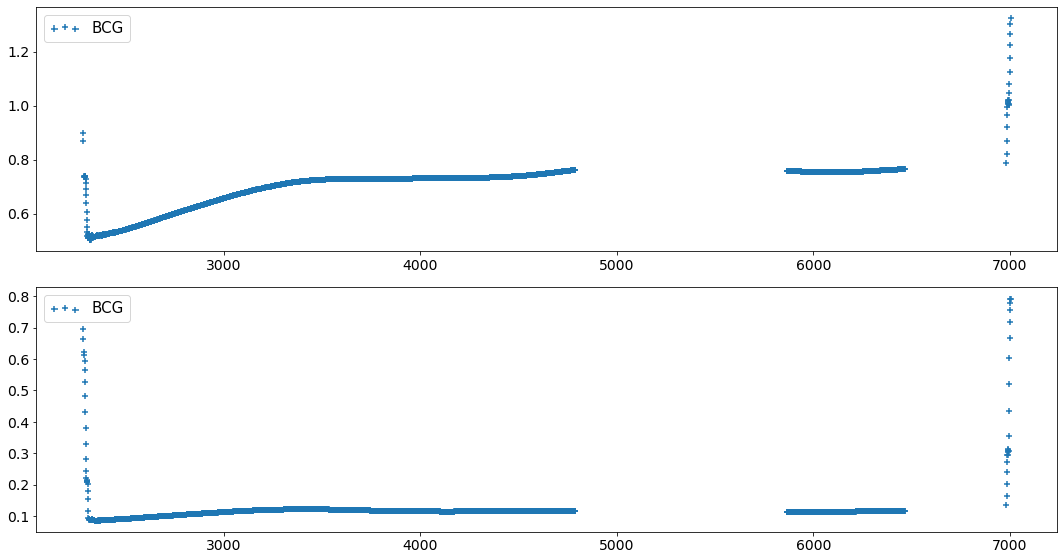


.
.
 2BG.csv
  Fault type Percentage
0        NML     99.15%
1      FAULT      0.85%


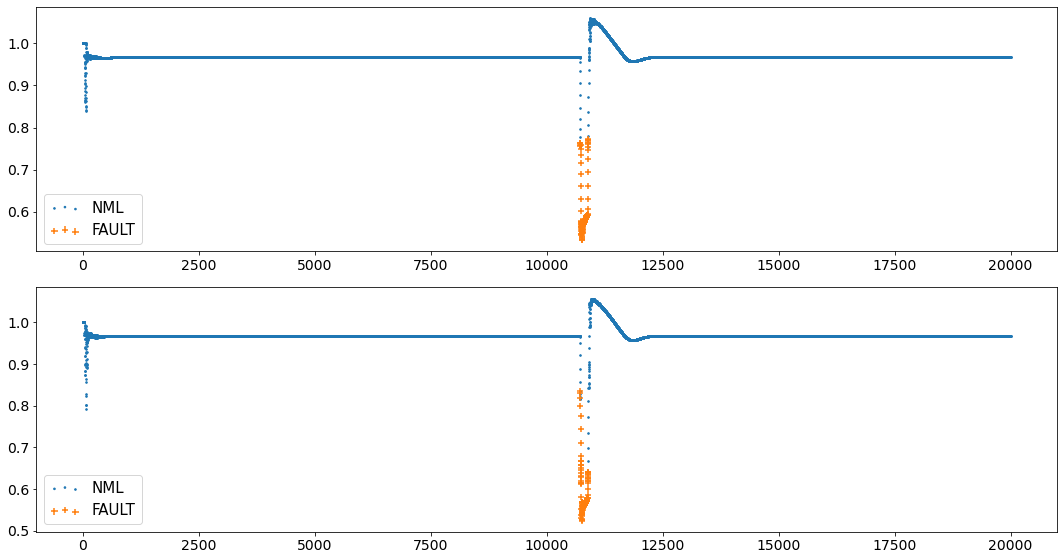

  Fault type Percentage
0         BG     100.0%


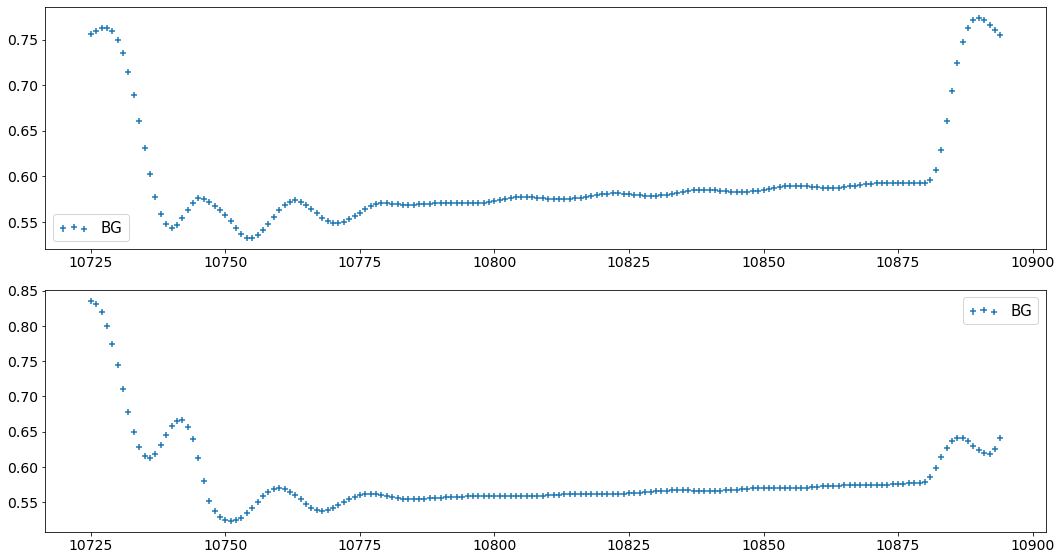


.
.
 6BC.csv
  Fault type Percentage
0        NML     84.38%
1      FAULT     15.62%


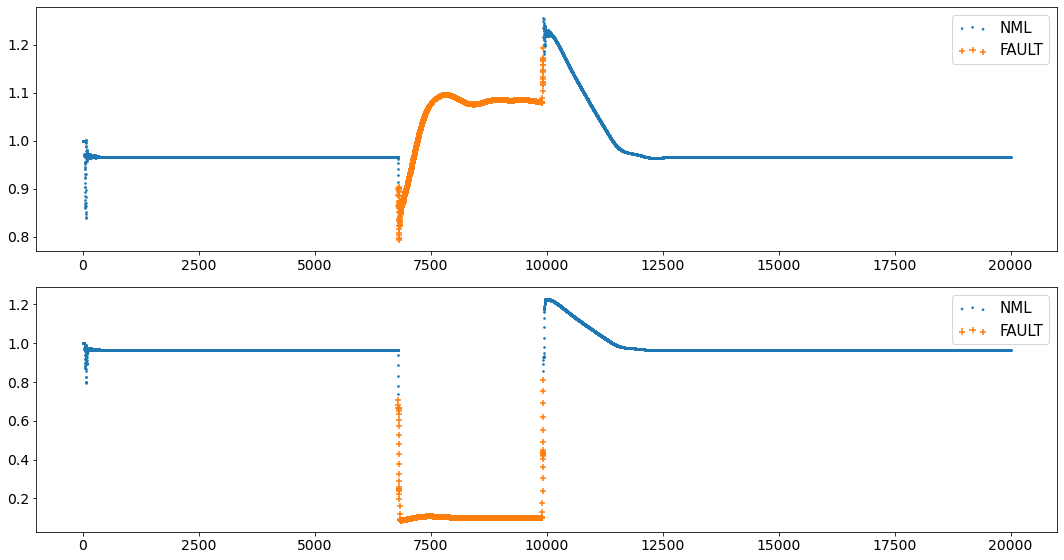

  Fault type Percentage
0         BC      99.9%
1        BCG       0.1%


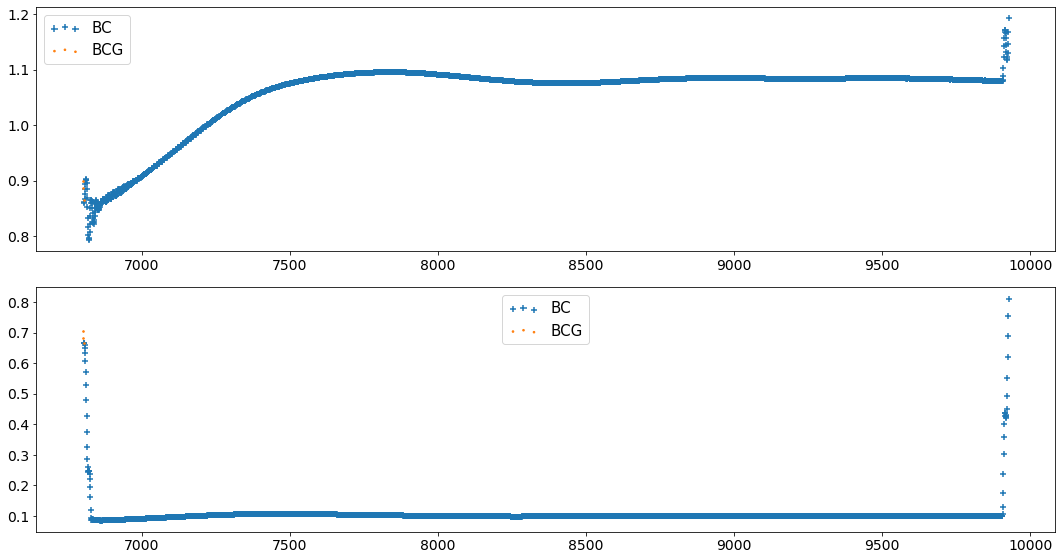


.
.
 6CG.csv
  Fault type Percentage
0        NML     86.89%
1      FAULT     13.11%


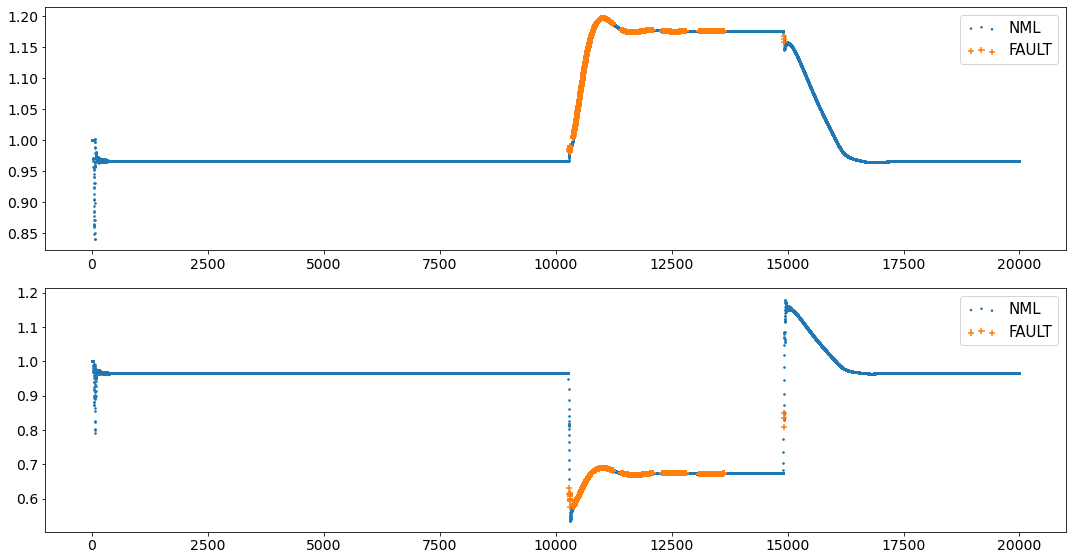

  Fault type Percentage
0         CG     100.0%


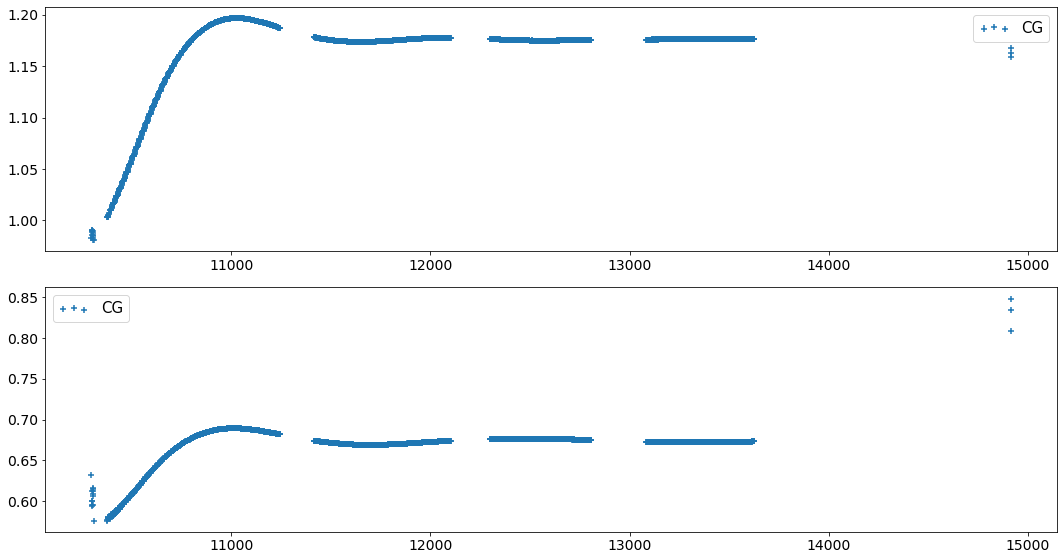


.
.
 7ABCG.csv
  Fault type Percentage
0        NML     95.85%
1      FAULT      4.15%


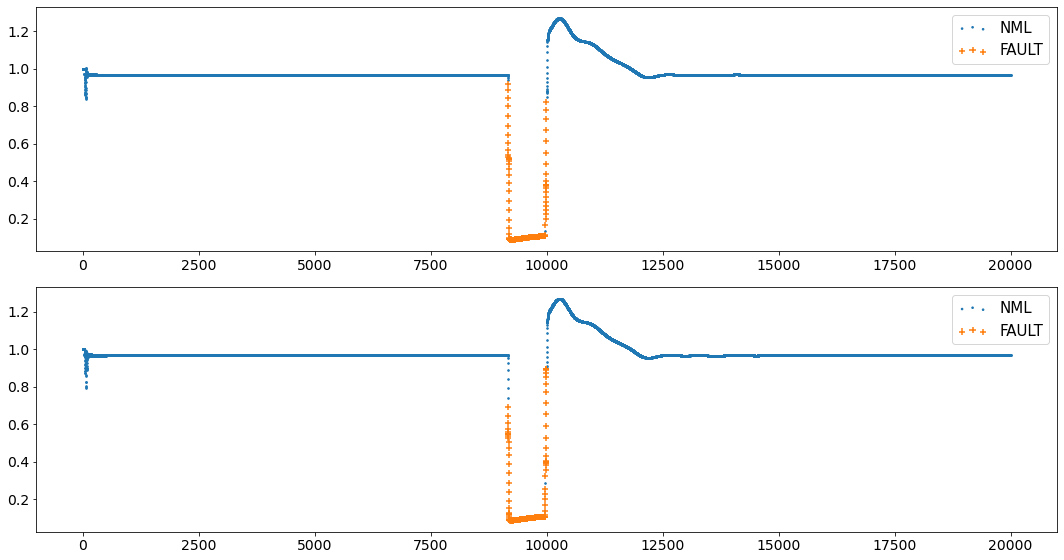

  Fault type Percentage
0        ABC     98.43%
1        BCG      1.08%
2        ABG      0.36%
3       ABCG      0.12%


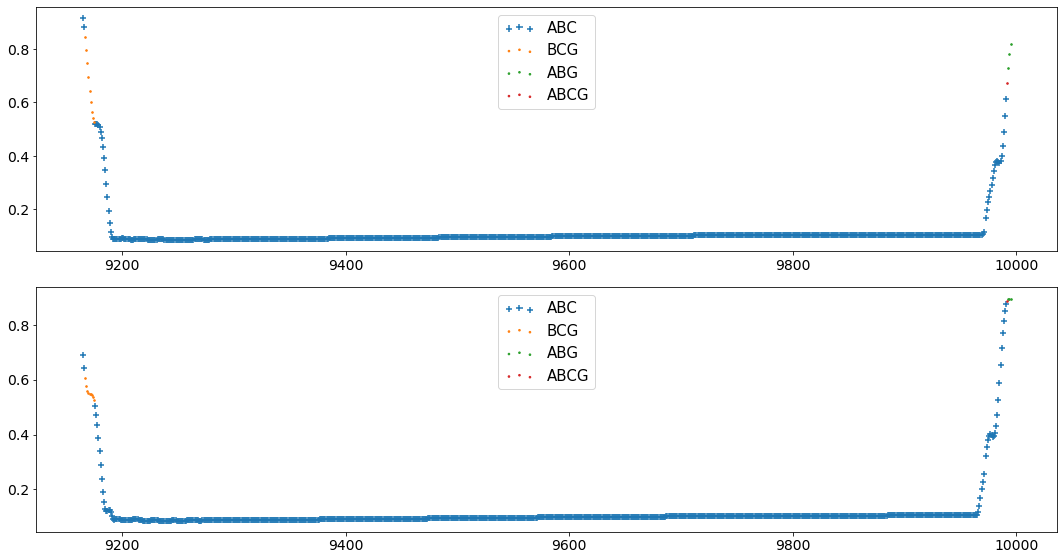


.
.
 9BCG.csv
  Fault type Percentage
0        NML     84.88%
1      FAULT     15.12%


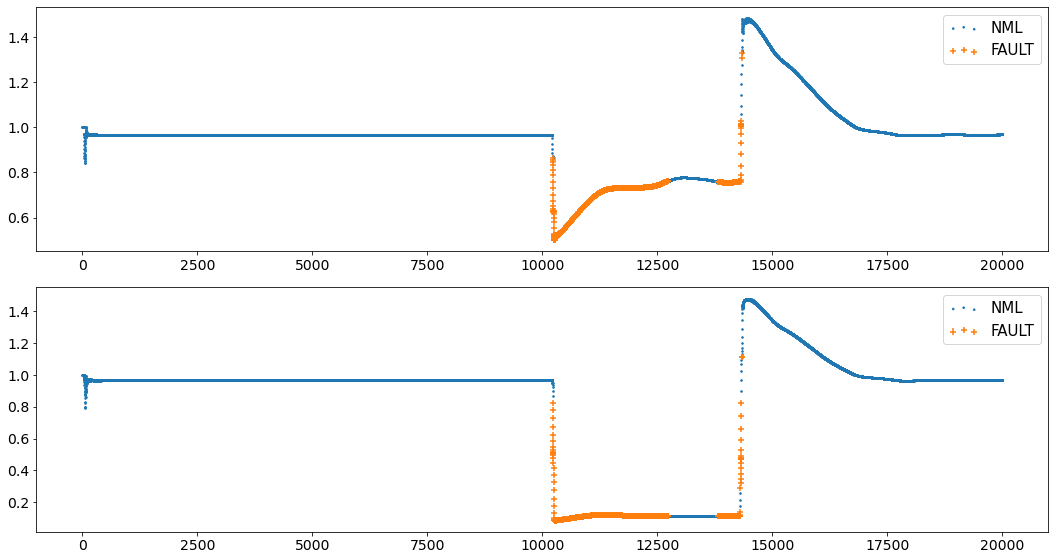

  Fault type Percentage
0        BCG      99.7%
1         CG       0.1%
2         AB      0.07%
3        ACG      0.07%
4        ABC      0.07%


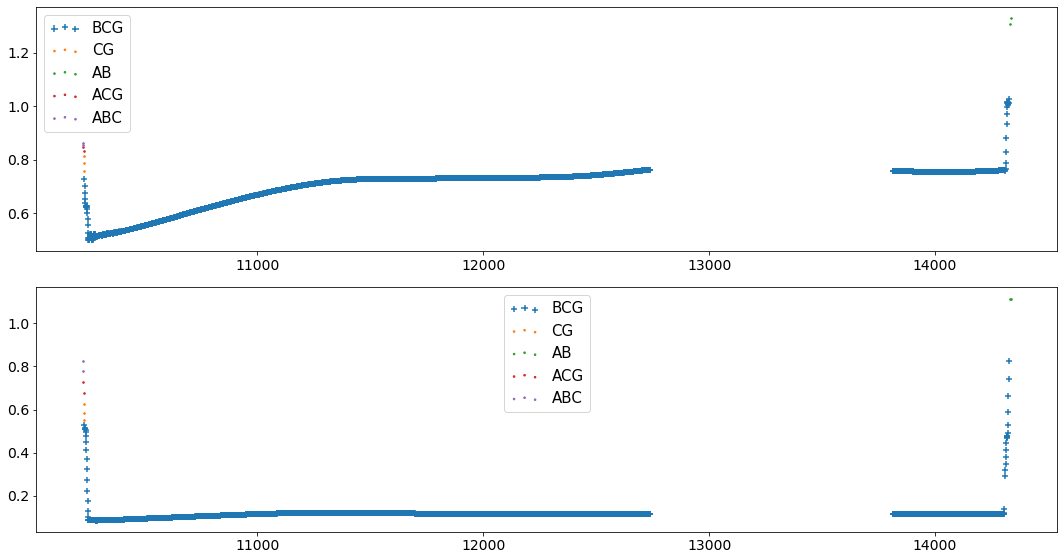


.
.
 10AG.csv
  Fault type Percentage
0        NML     91.24%
1      FAULT      8.76%


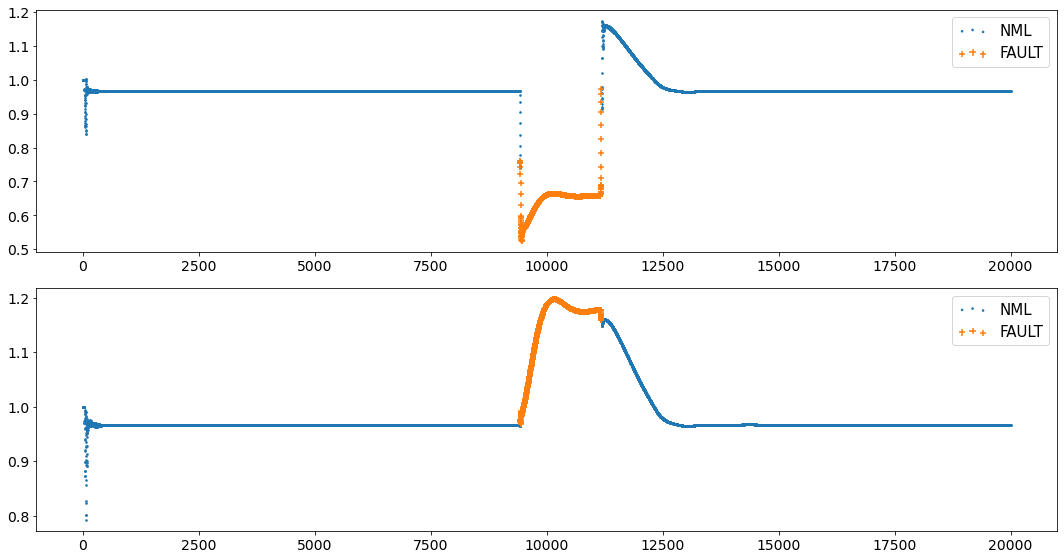

  Fault type Percentage
0         AG     100.0%


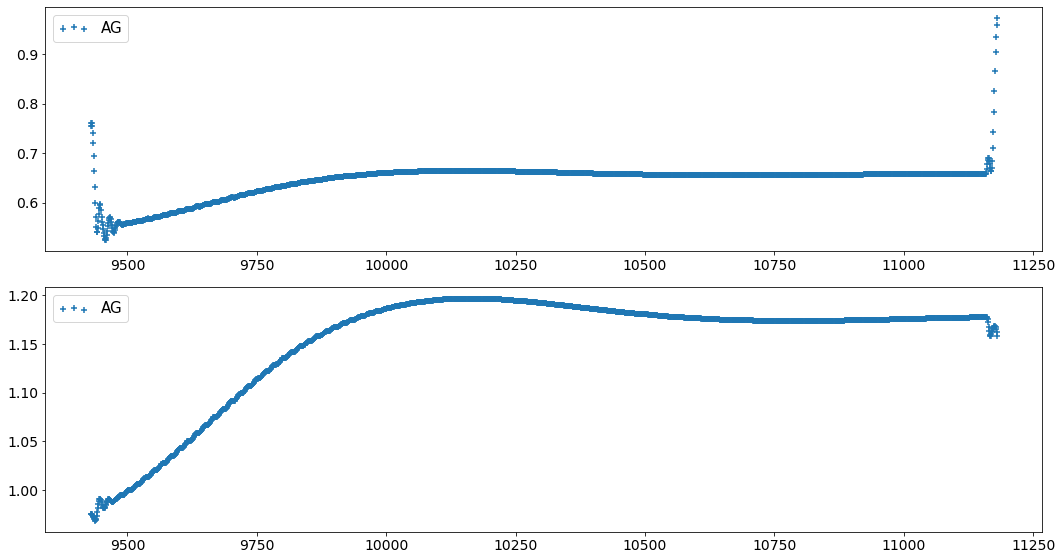


.
.
 3ABC.csv
  Fault type Percentage
0        NML     96.83%
1      FAULT      3.17%


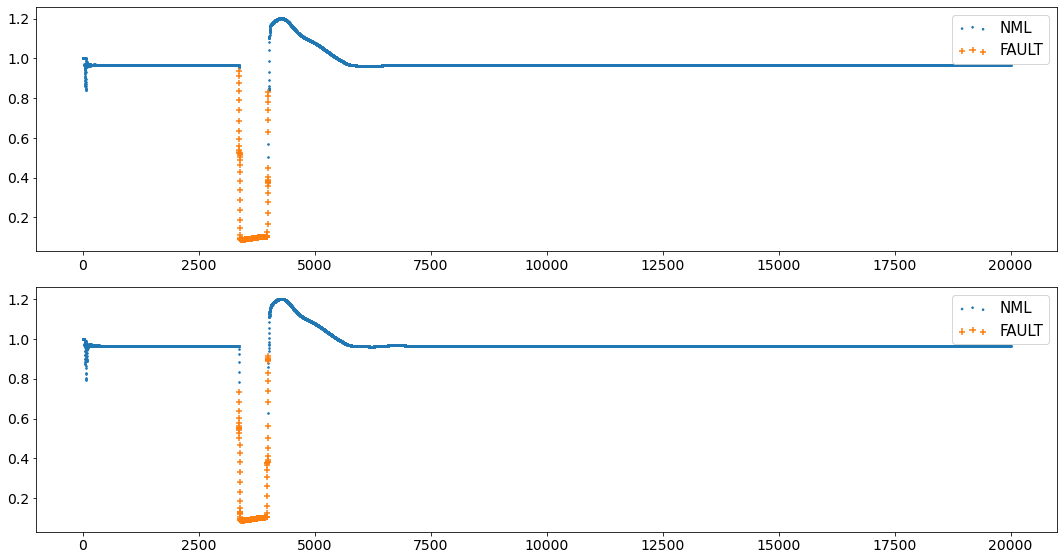

  Fault type Percentage
0        ABC     97.32%
1        BCG      1.57%
2        ABG      0.94%
3        ACG      0.16%


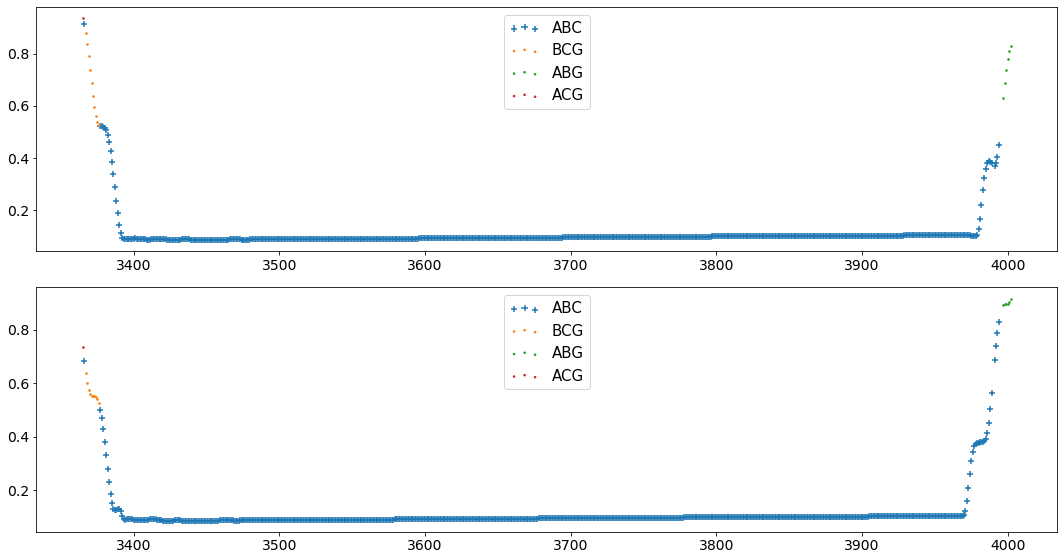


.
.
 3ACG.csv
  Fault type Percentage
0        NML     85.78%
1      FAULT     14.22%


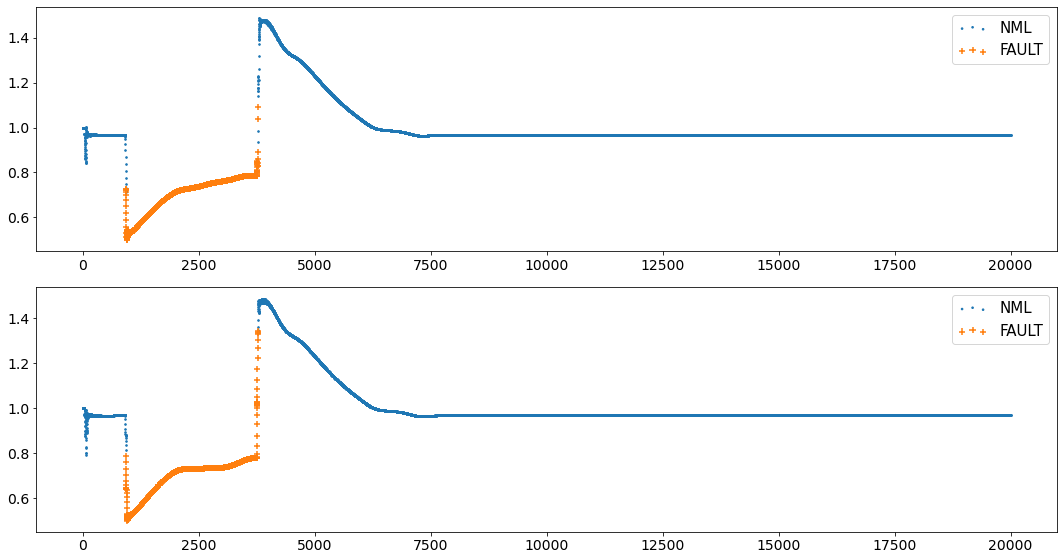

  Fault type Percentage
0        ACG     99.89%
1         AG      0.11%


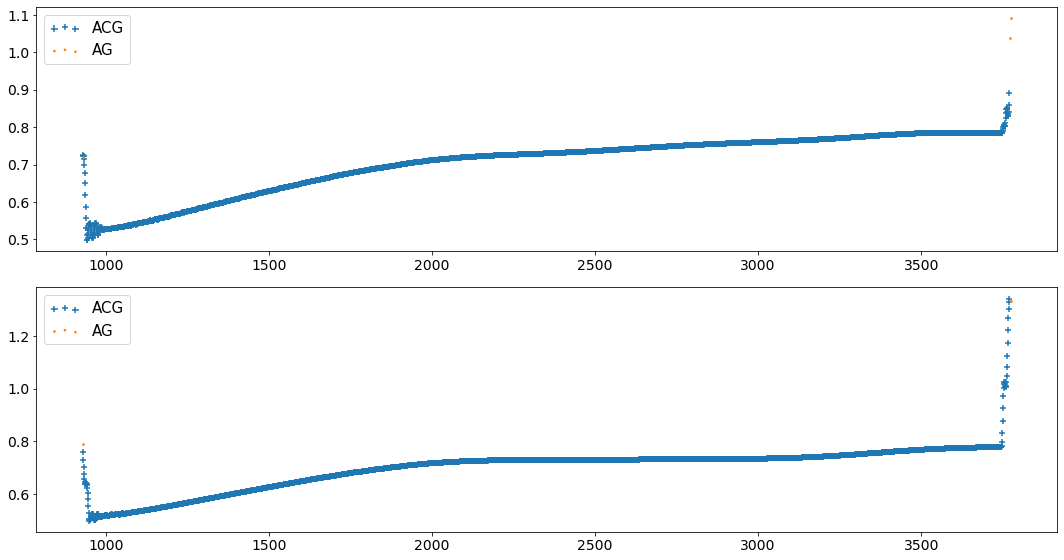


.
.
 8AC.csv
  Fault type Percentage
0        NML     93.22%
1      FAULT      6.79%


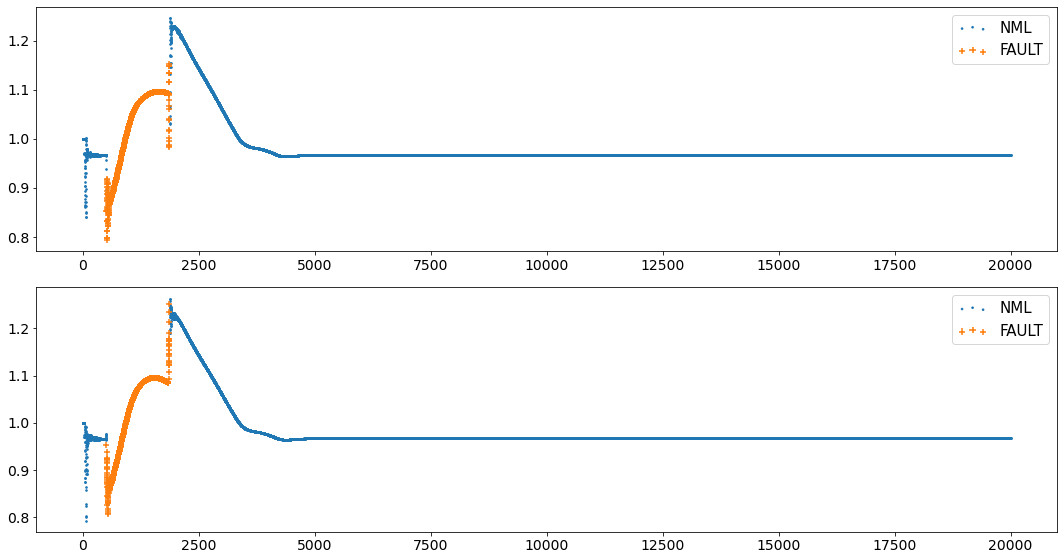

  Fault type Percentage
0         AC     99.71%
1        ACG      0.29%


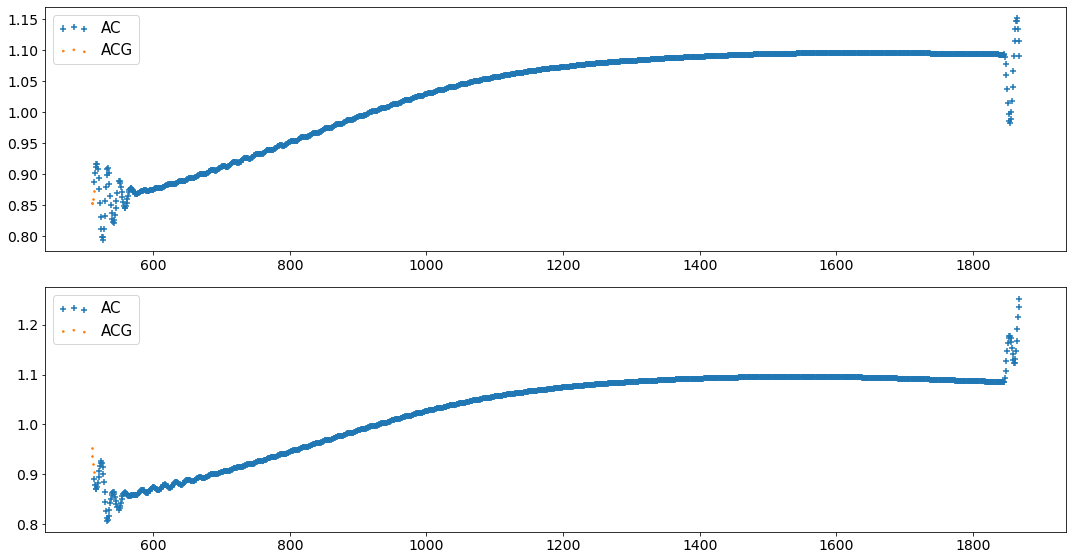


.
.
 4BC.csv
  Fault type Percentage
0        NML     84.76%
1      FAULT     15.24%


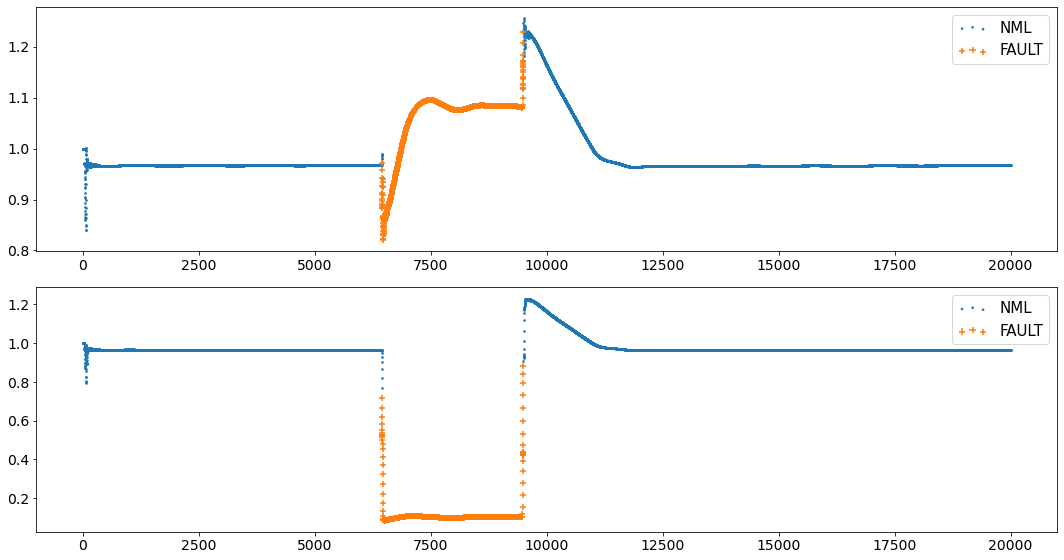

  Fault type Percentage
0         BC      99.9%
1        BCG       0.1%


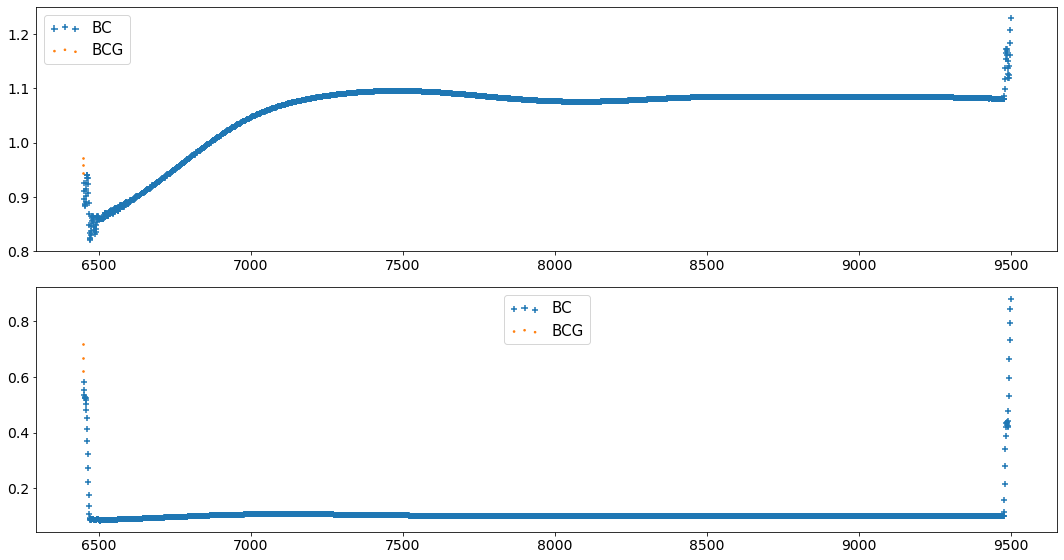


.
.
 4CG.csv
  Fault type Percentage
0        NML     92.93%
1      FAULT      7.07%


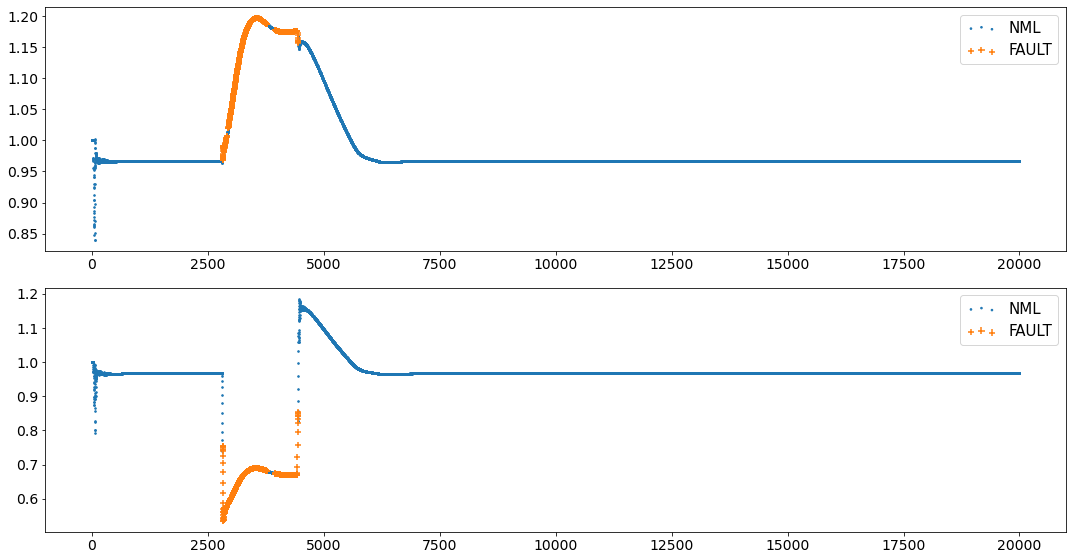

  Fault type Percentage
0         CG     100.0%


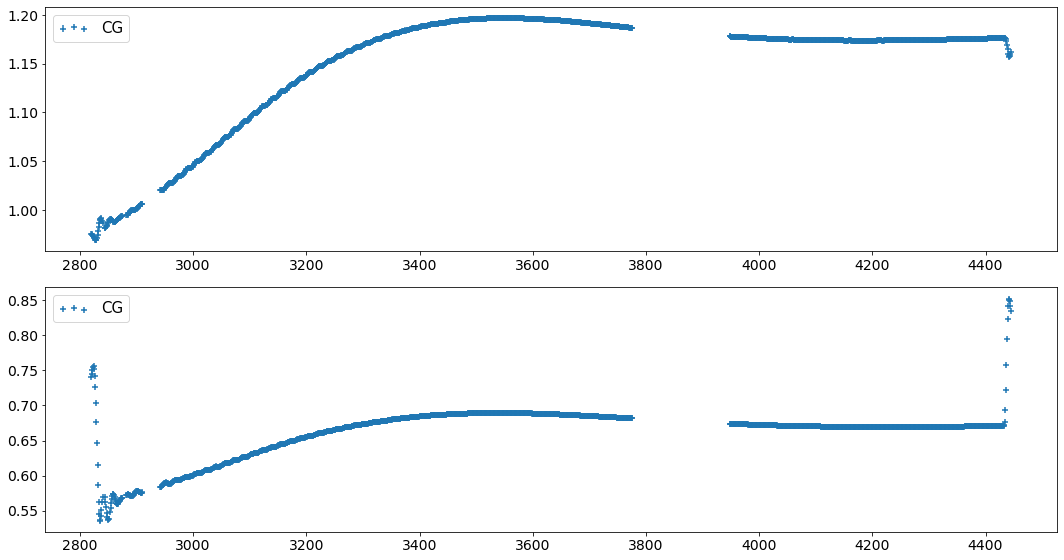


.
.
 1ABG.csv
  Fault type Percentage
0        NML     77.79%
1      FAULT     22.21%


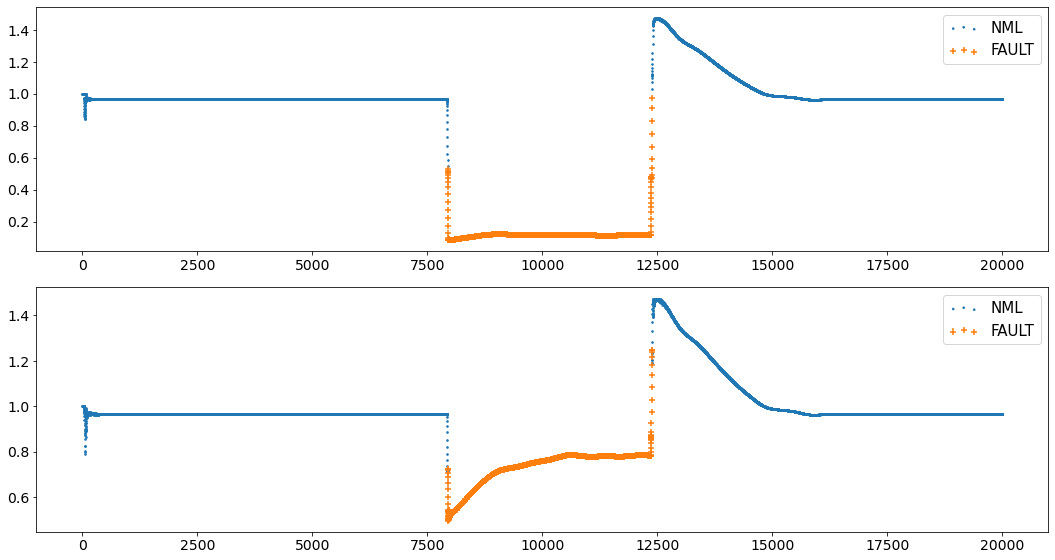

  Fault type Percentage
0        ABG     99.66%
1         AB      0.34%


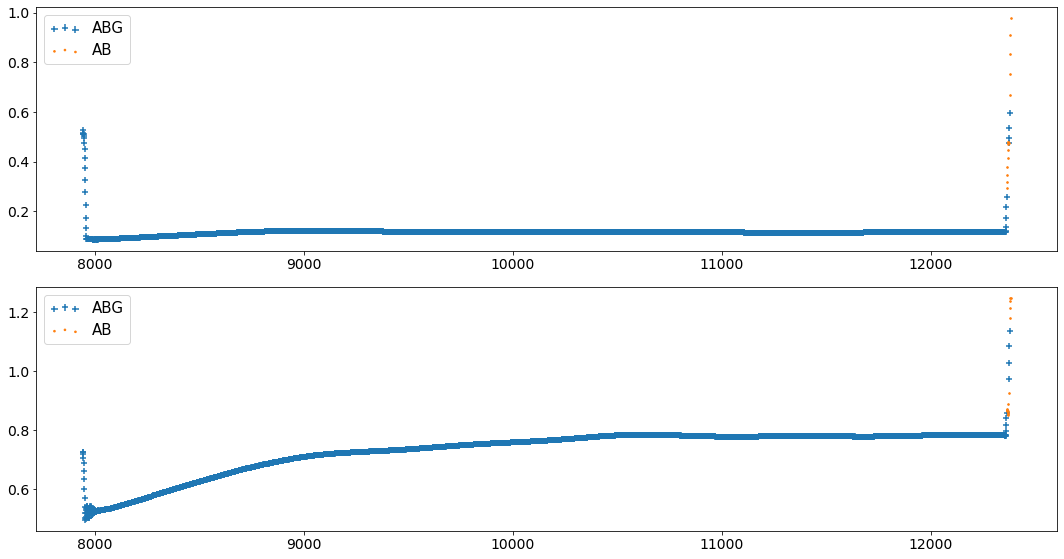


.
.
 8AB.csv
  Fault type Percentage
0        NML     97.97%
1      FAULT      2.02%


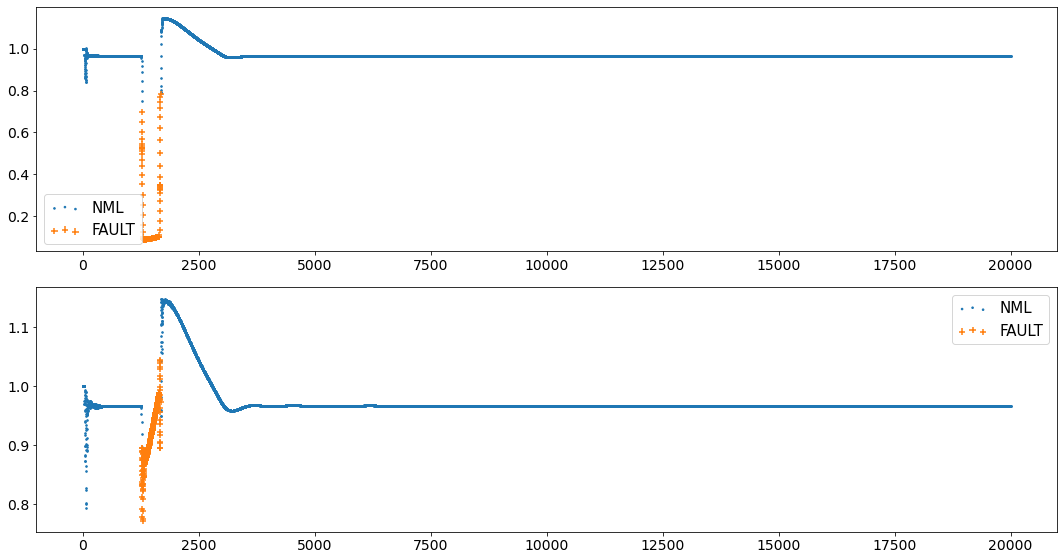

  Fault type Percentage
0         AB     97.53%
1        ABG      1.73%
2         AG      0.74%


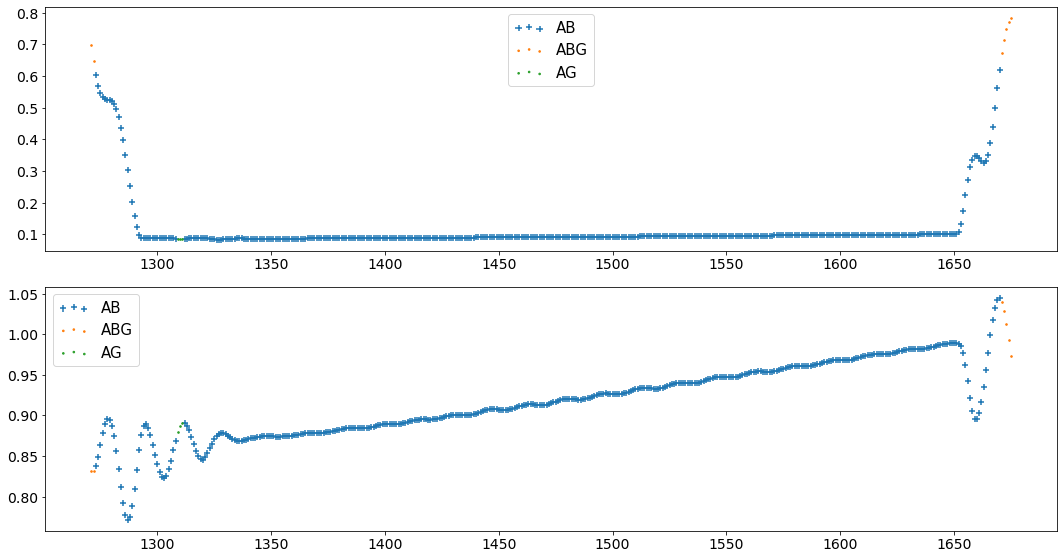


.
.
 10BCG.csv
  Fault type Percentage
0        NML     96.58%
1      FAULT      3.42%


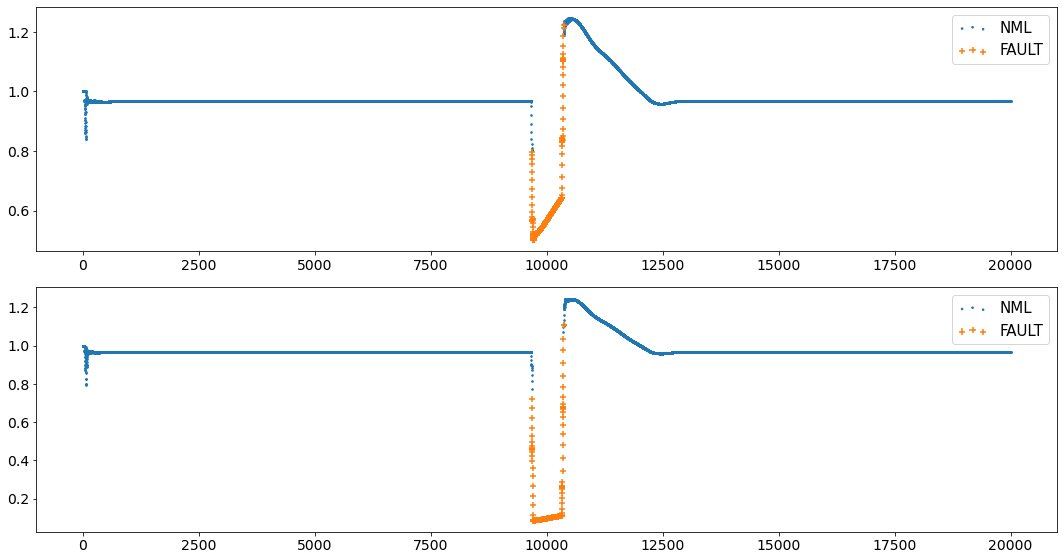

  Fault type Percentage
0        BCG     97.36%
1        ABC      1.61%
2         CG      0.88%
3        ACG      0.15%


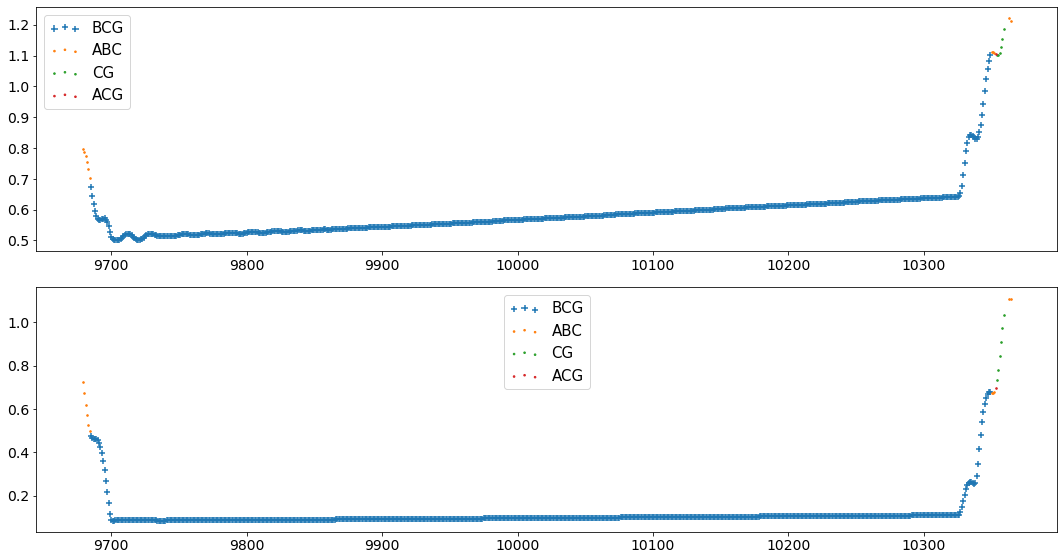


.
.
 8CG.csv
  Fault type Percentage
0        NML     99.56%
1      FAULT      0.45%


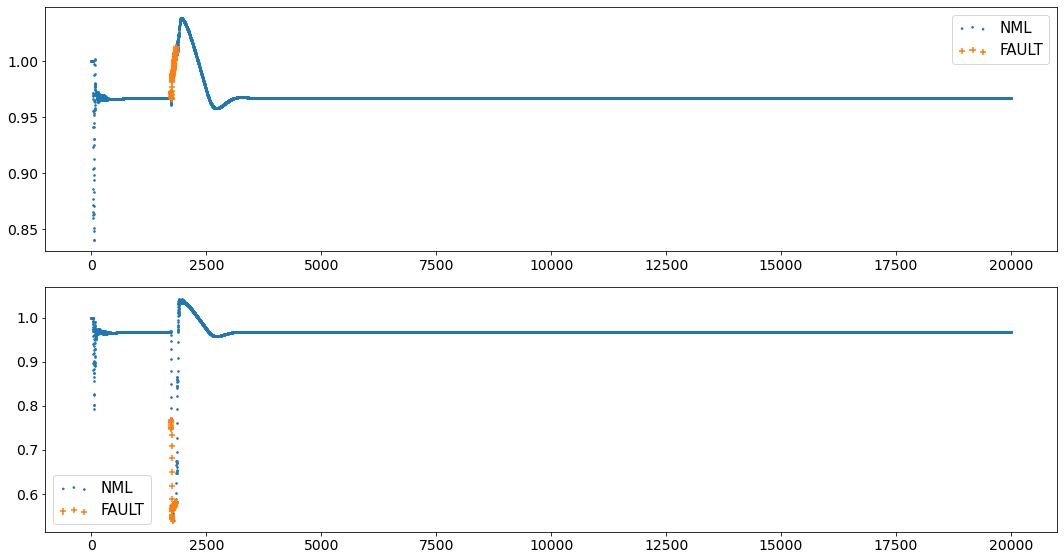

  Fault type Percentage
0         CG     100.0%


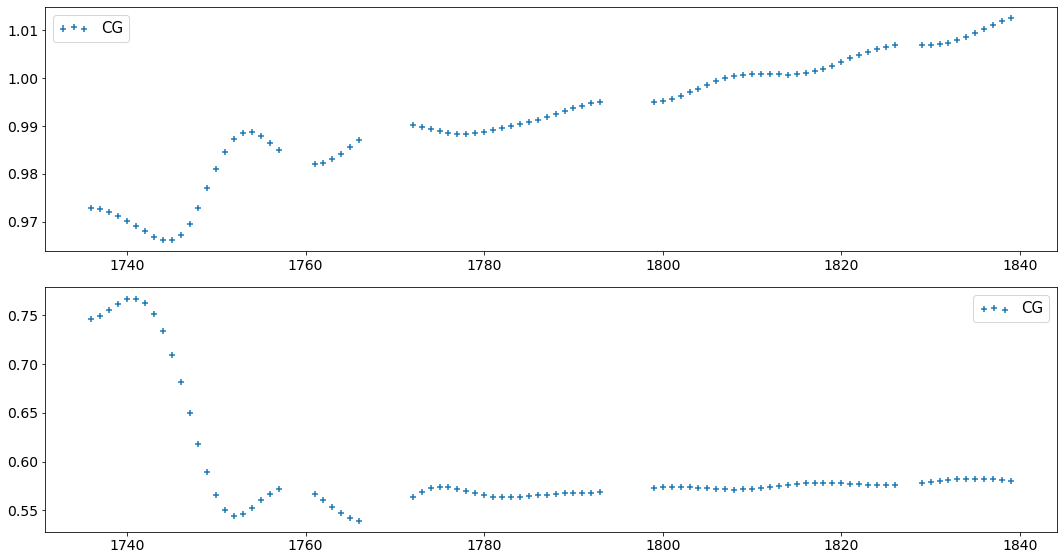


.
.
 8BC.csv
  Fault type Percentage
0        NML      99.8%
1      FAULT       0.2%


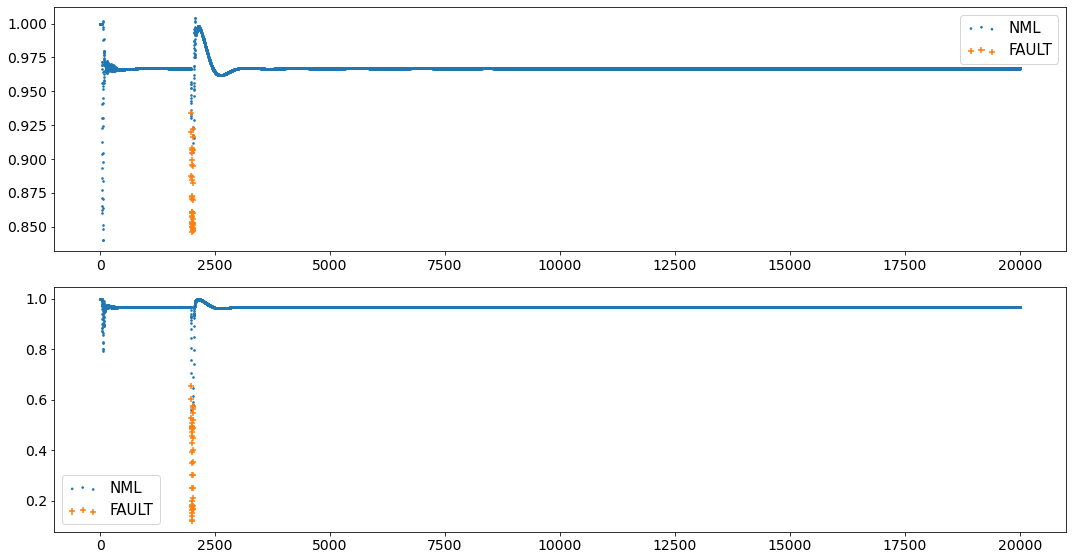

  Fault type Percentage
0         BC      92.5%
1        BCG       7.5%


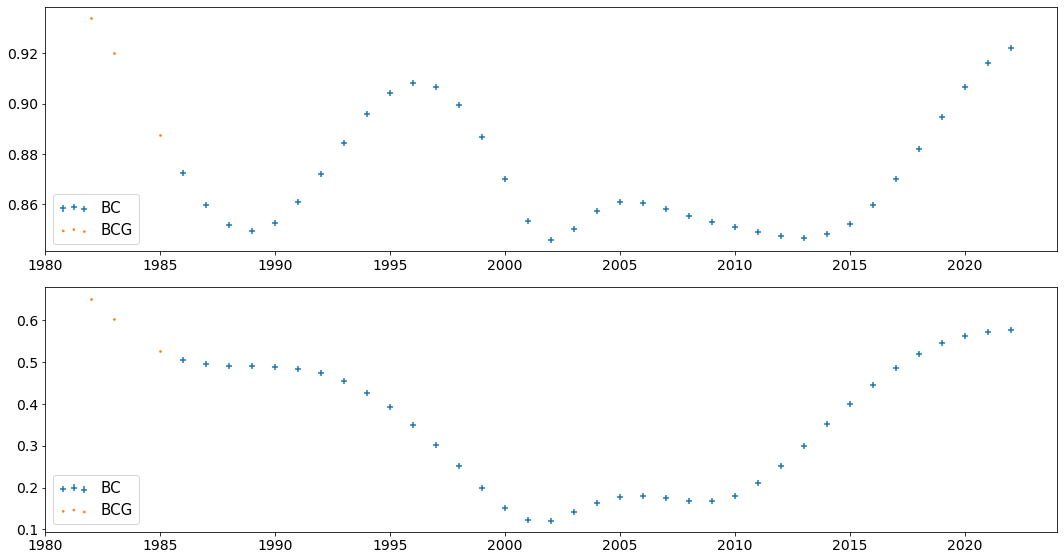


.
.
 4AB.csv
  Fault type Percentage
0        NML     97.65%
1      FAULT      2.35%


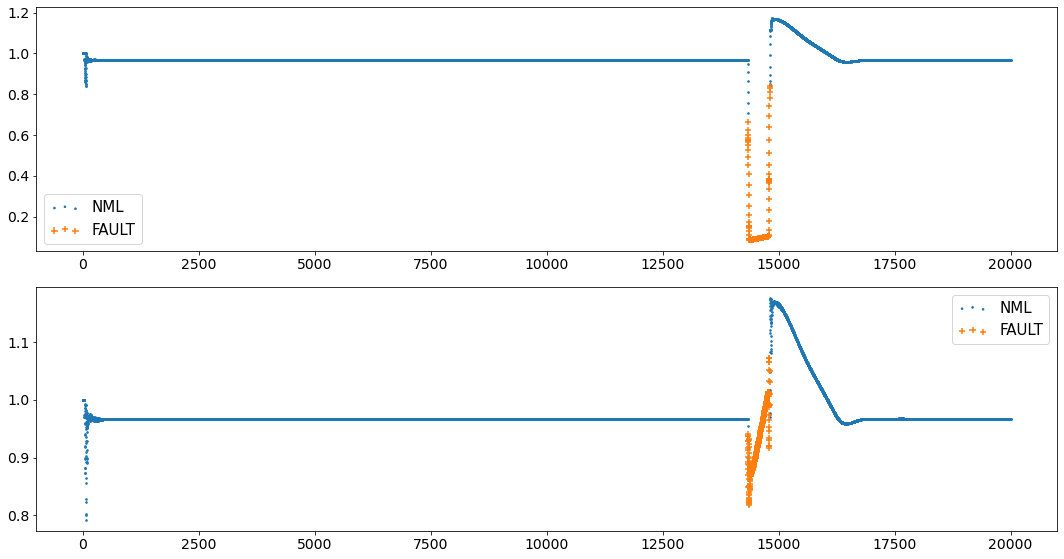

  Fault type Percentage
0         AB     96.81%
1        ABG      3.19%


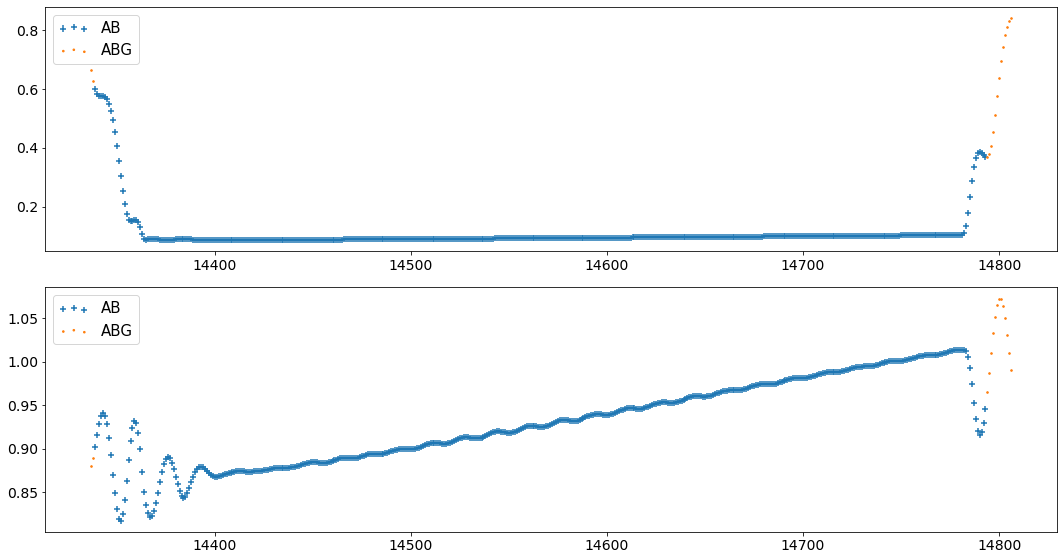


.
.
 6ACG.csv
  Fault type Percentage
0        NML     64.81%
1      FAULT     35.19%


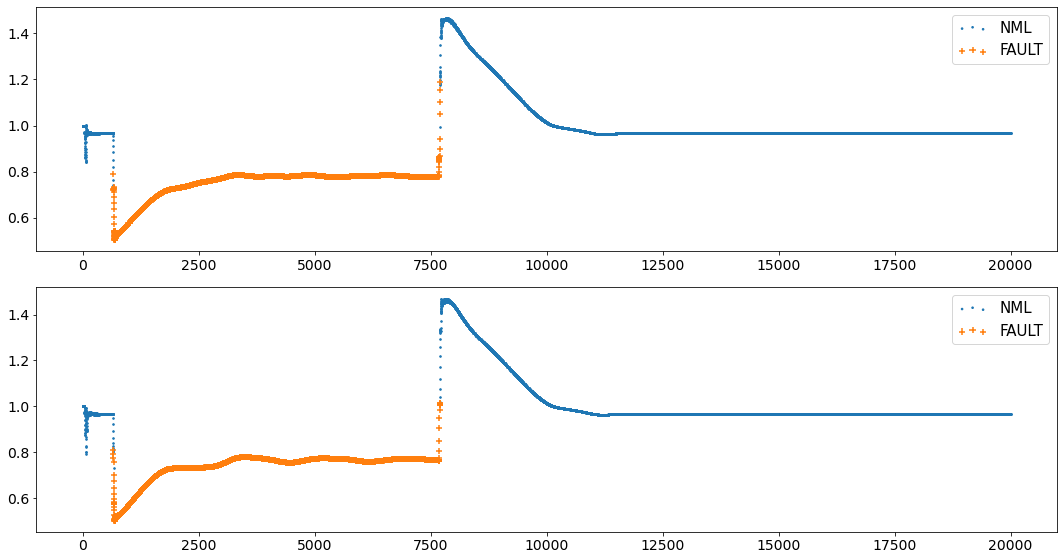

  Fault type Percentage
0        ACG     99.94%
1        ABC      0.06%


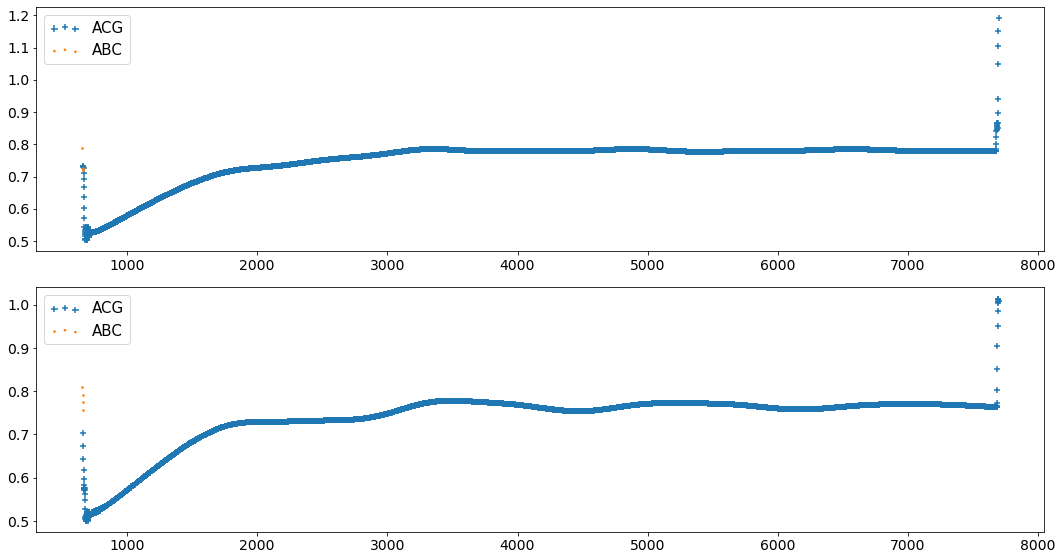


.
.
 6ABC.csv
  Fault type Percentage
0        NML     96.59%
1      FAULT      3.41%


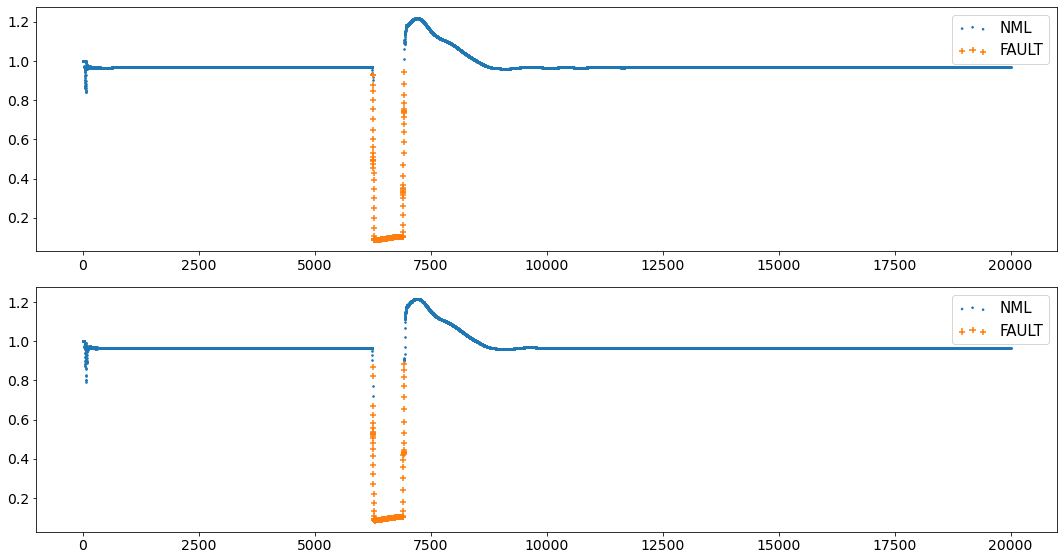

  Fault type Percentage
0        ABC      97.8%
1        BCG      1.61%
2        ACG      0.59%


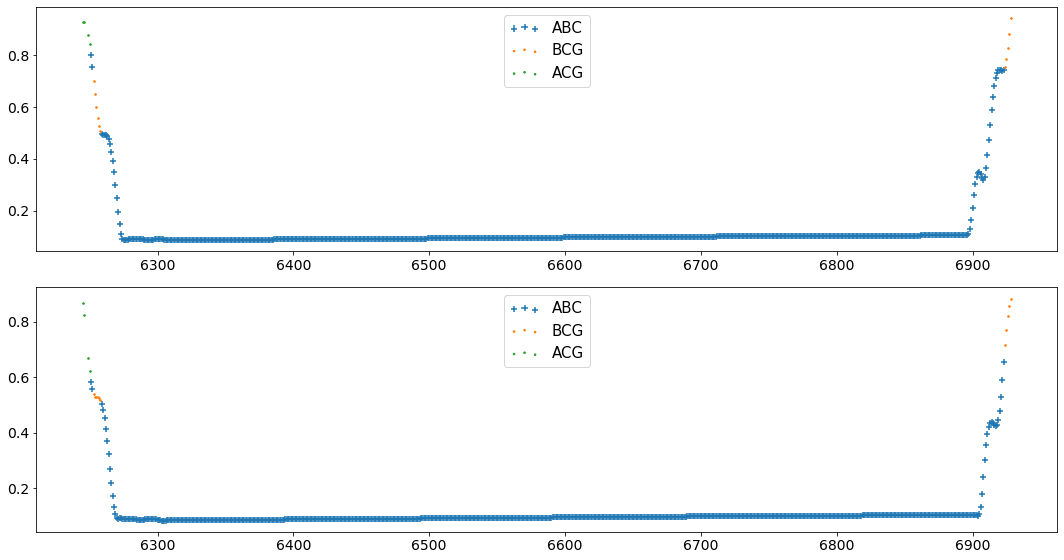


.
.
 8ABG.csv
  Fault type Percentage
0        NML     95.88%
1      FAULT      4.12%


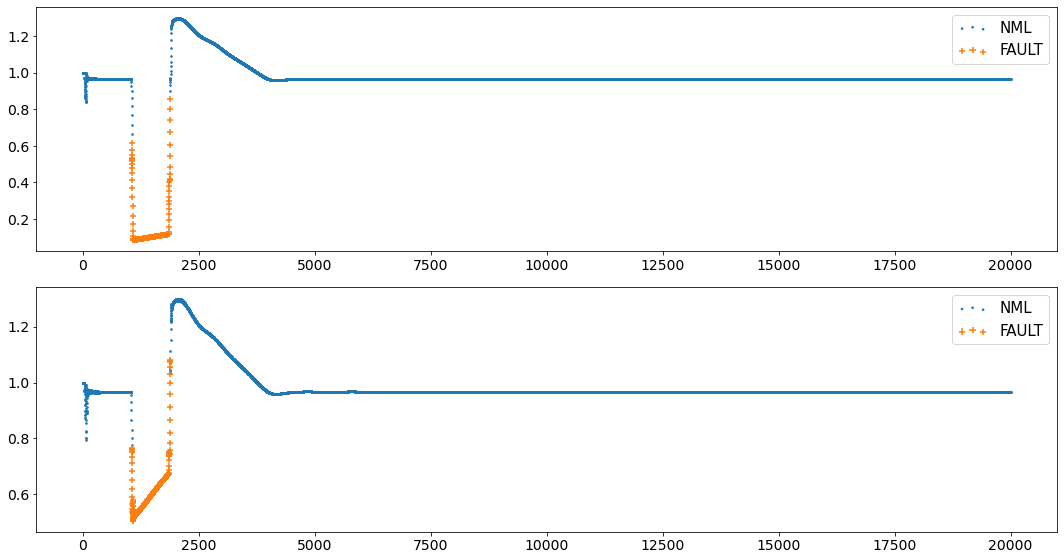

  Fault type Percentage
0        ABG     99.76%
1         AB      0.24%


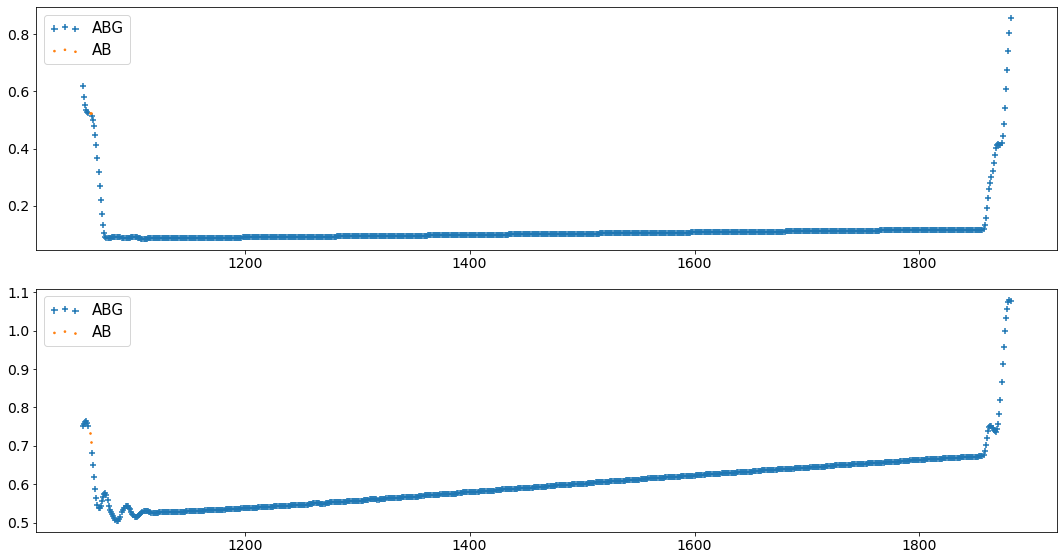


.
.
 4AC.csv
  Fault type Percentage
0        NML     96.73%
1      FAULT      3.27%


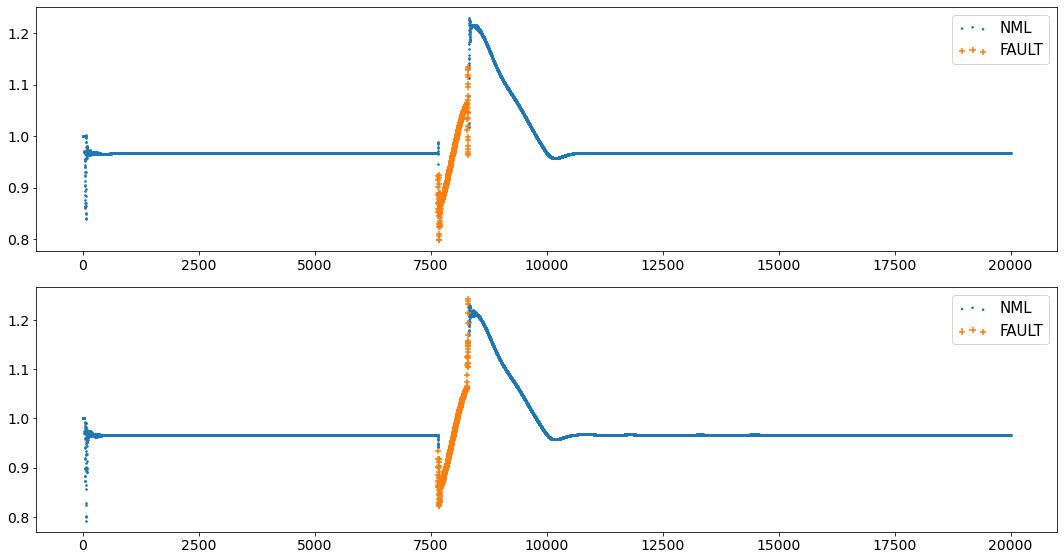

  Fault type Percentage
0         AC     97.24%
1        ACG      2.76%


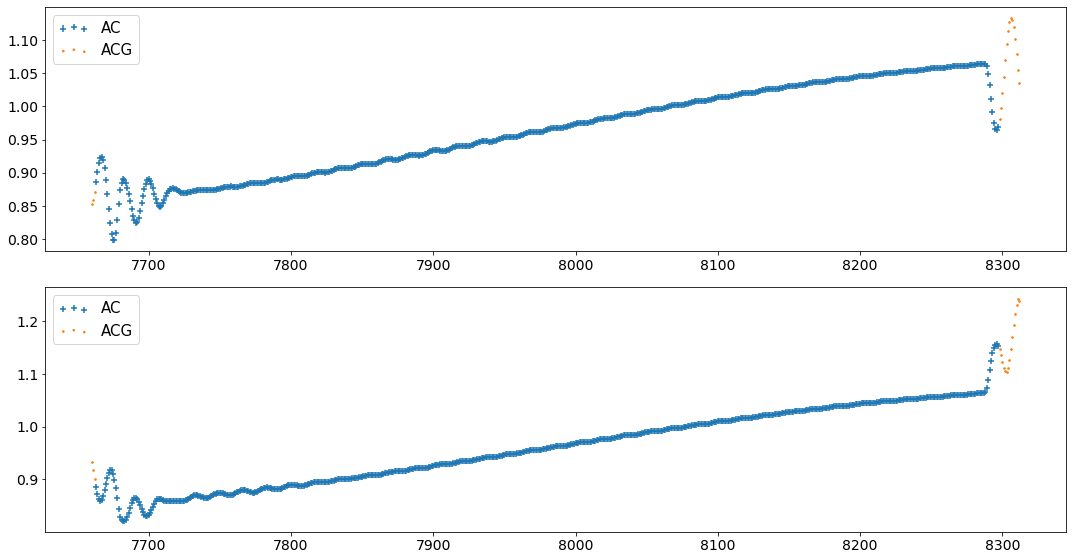


.
.
 4ABG.csv
  Fault type Percentage
0        NML     91.38%
1      FAULT      8.62%


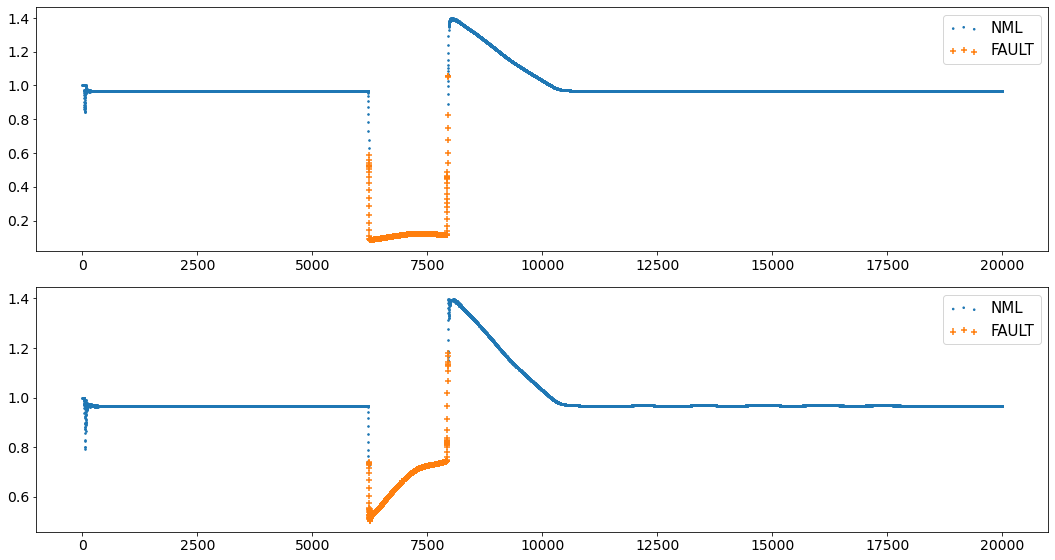

  Fault type Percentage
0        ABG     99.83%
1         AG      0.17%


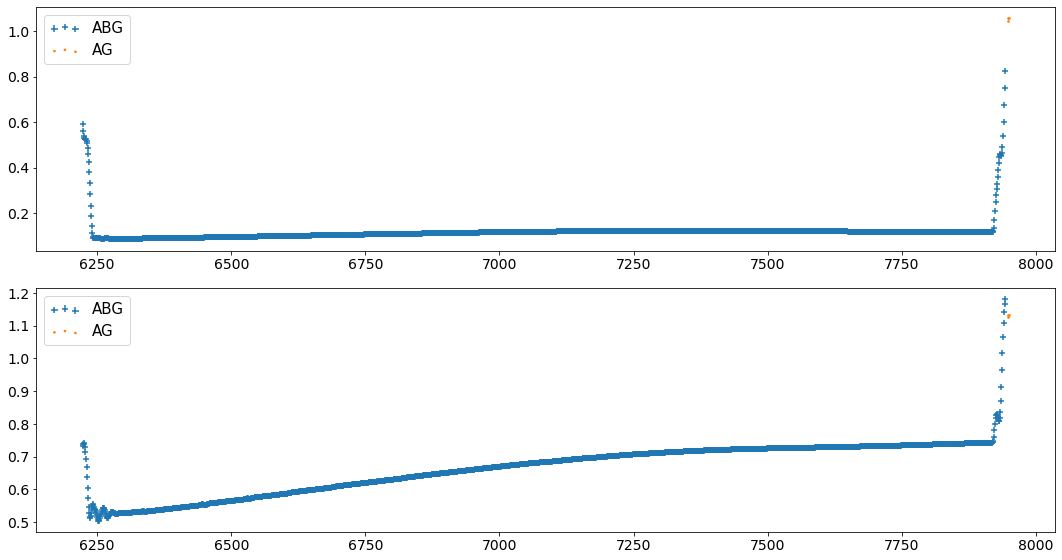


.
.
 2AG.csv
  Fault type Percentage
0        NML     95.11%
1      FAULT      4.89%


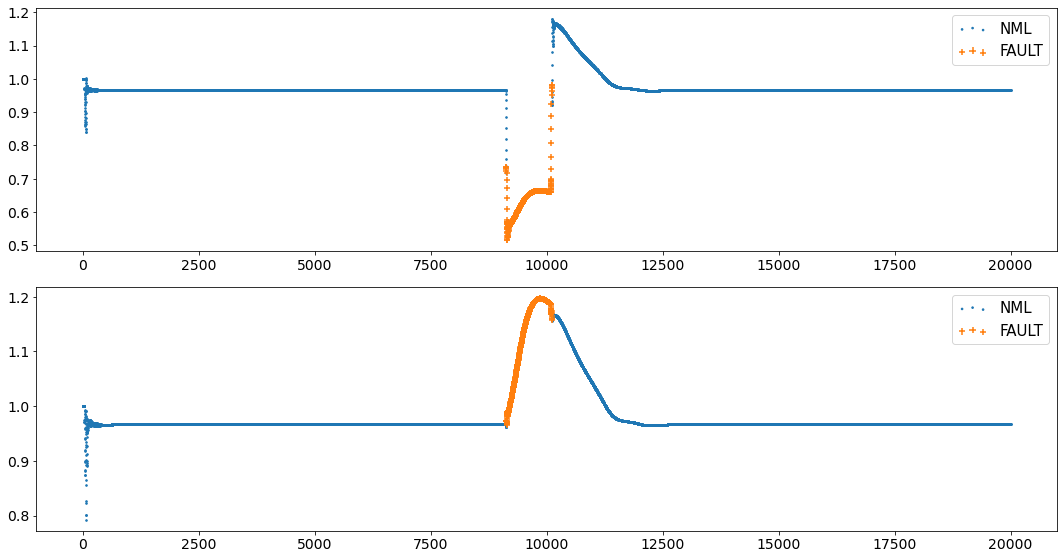

  Fault type Percentage
0         AG     100.0%


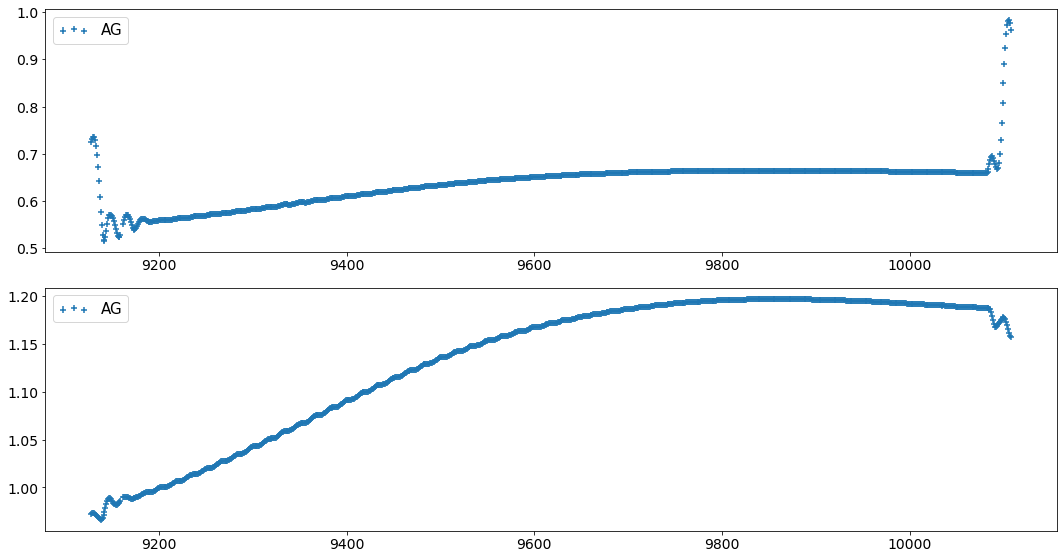


.
.
 6AC.csv
  Fault type Percentage
0        NML     96.66%
1      FAULT      3.35%


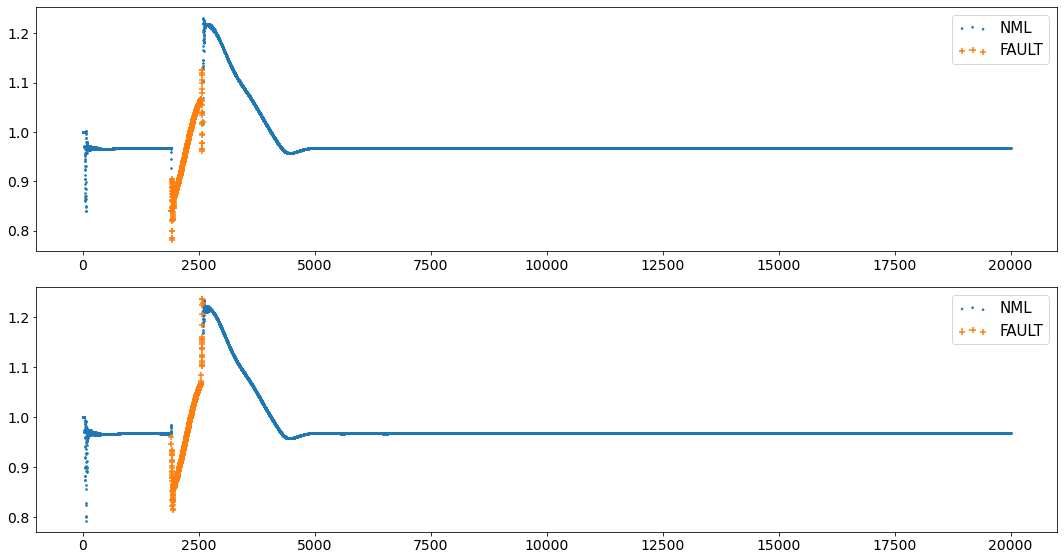

  Fault type Percentage
0         AC     97.16%
1        ACG      2.54%
2         CG       0.3%


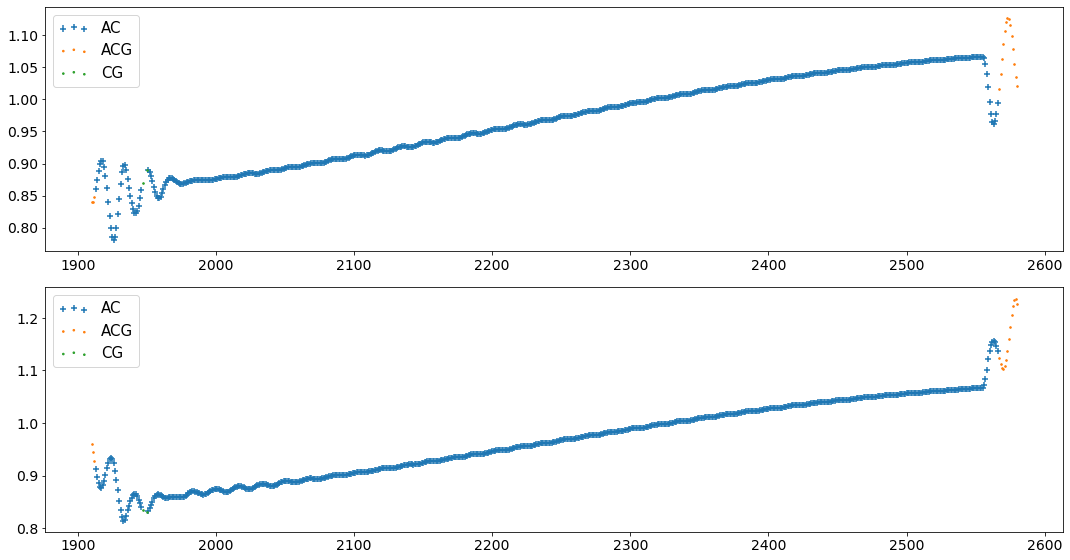


.
.
 6AB.csv
  Fault type Percentage
0        NML     93.31%
1      FAULT       6.7%


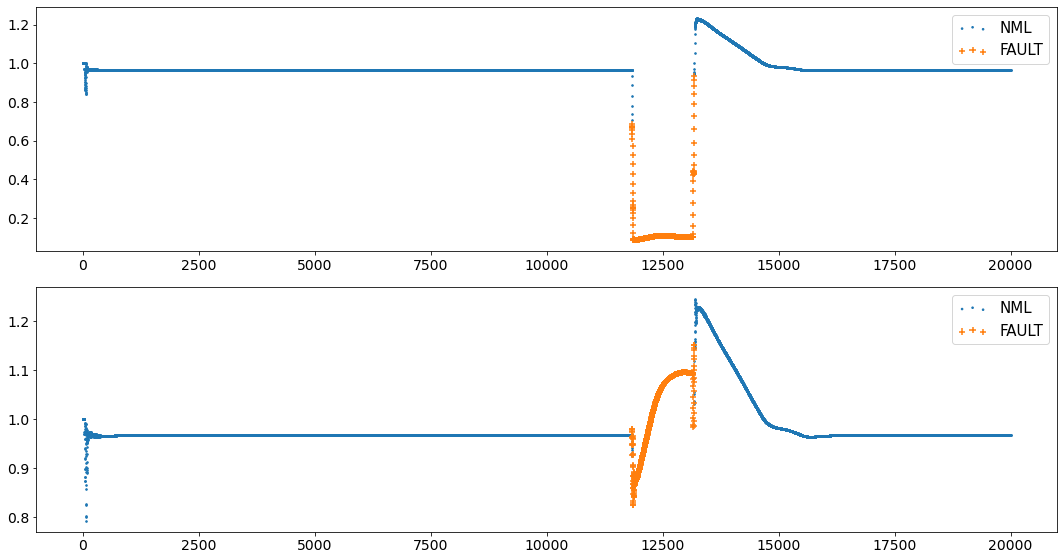

  Fault type Percentage
0         AB     99.85%
1        ABG      0.15%


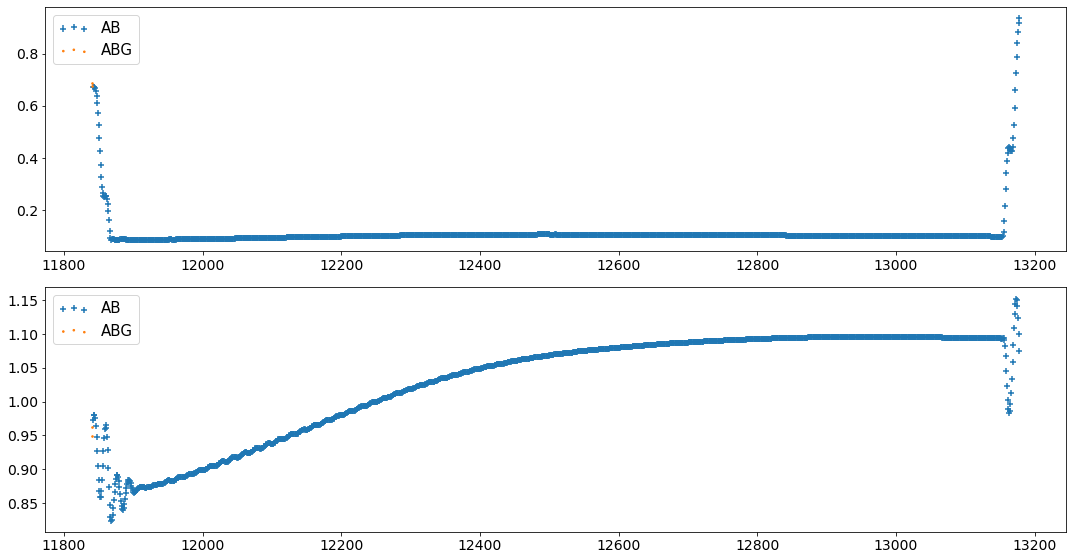


.
.
 2ABCG.csv
  Fault type Percentage
0        NML     73.22%
1      FAULT     26.78%


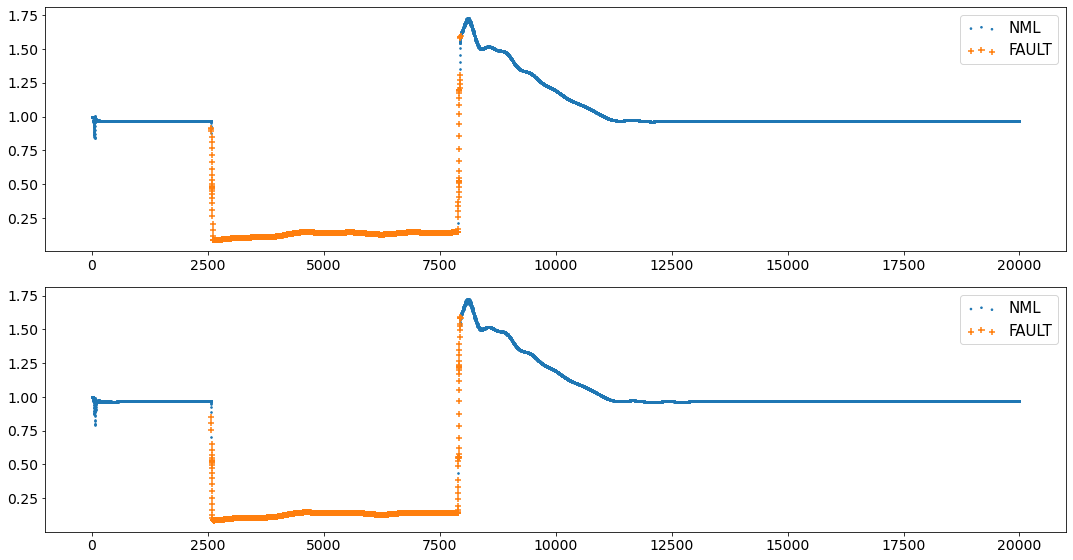

  Fault type Percentage
0        ABC     99.81%
1        ACG      0.11%
2        BCG      0.06%
3       ABCG      0.02%


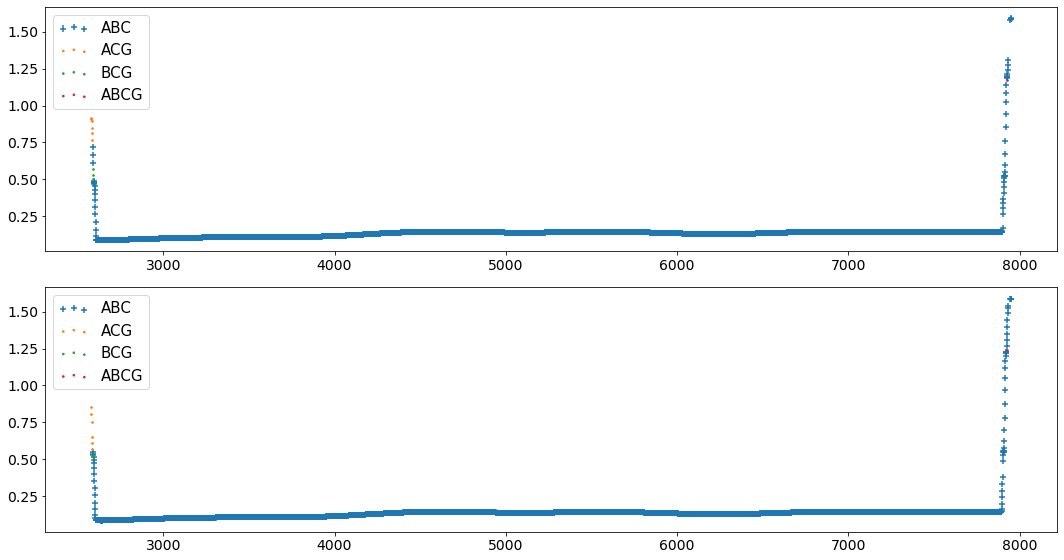


.
.
 10BG.csv
  Fault type Percentage
0        NML     97.62%
1      FAULT      2.38%


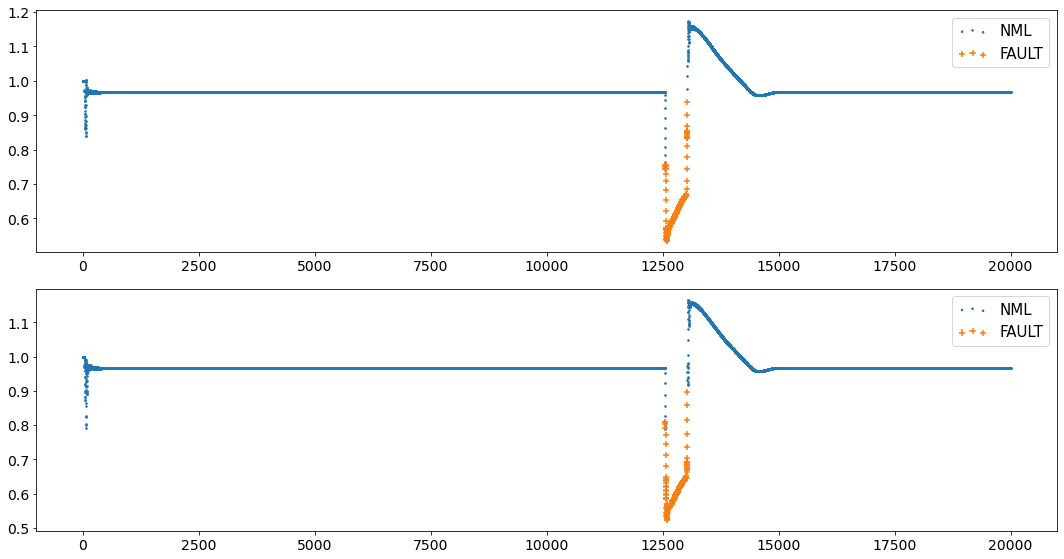

  Fault type Percentage
0         BG     100.0%


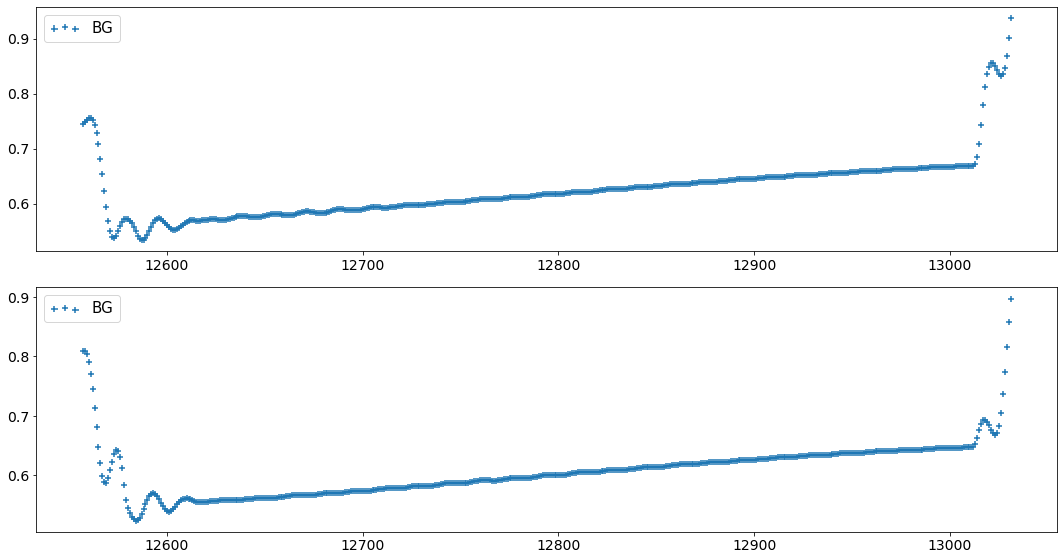


.
.
 2AB.csv
  Fault type Percentage
0        NML     86.14%
1      FAULT     13.87%


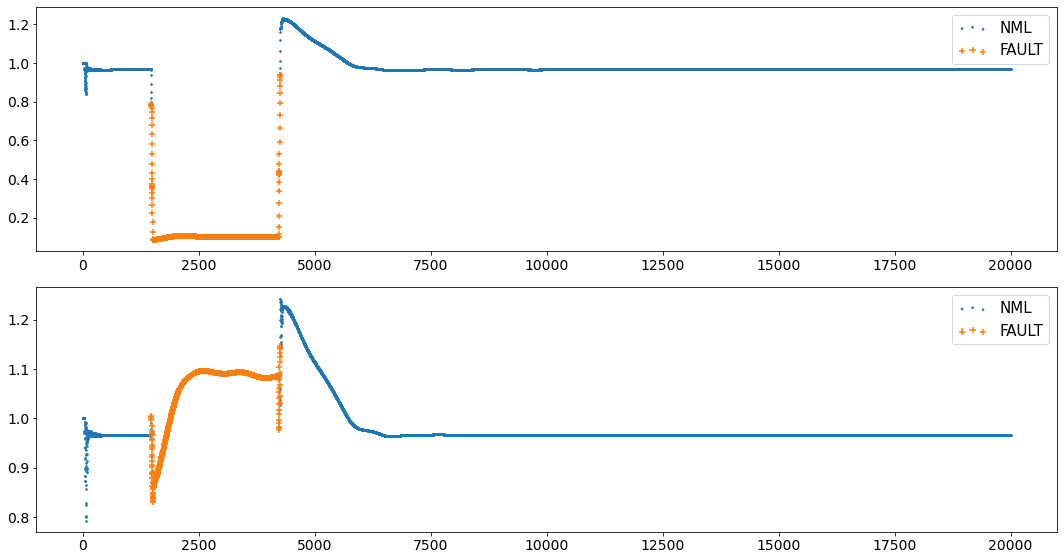

  Fault type Percentage
0         AB     99.78%
1        ABG      0.22%


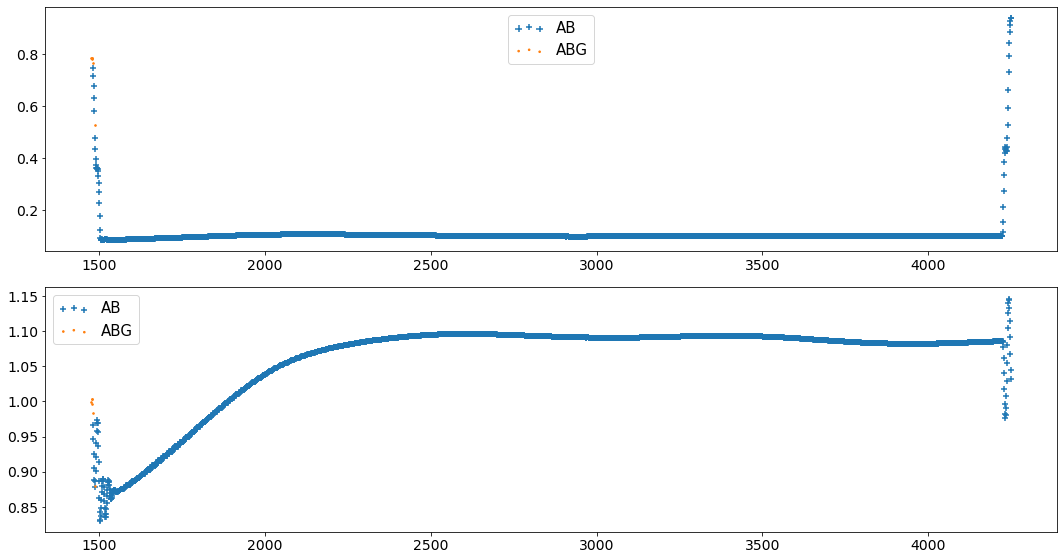


.
.
 2BCG.csv
  Fault type Percentage
0        NML     99.61%
1      FAULT      0.39%


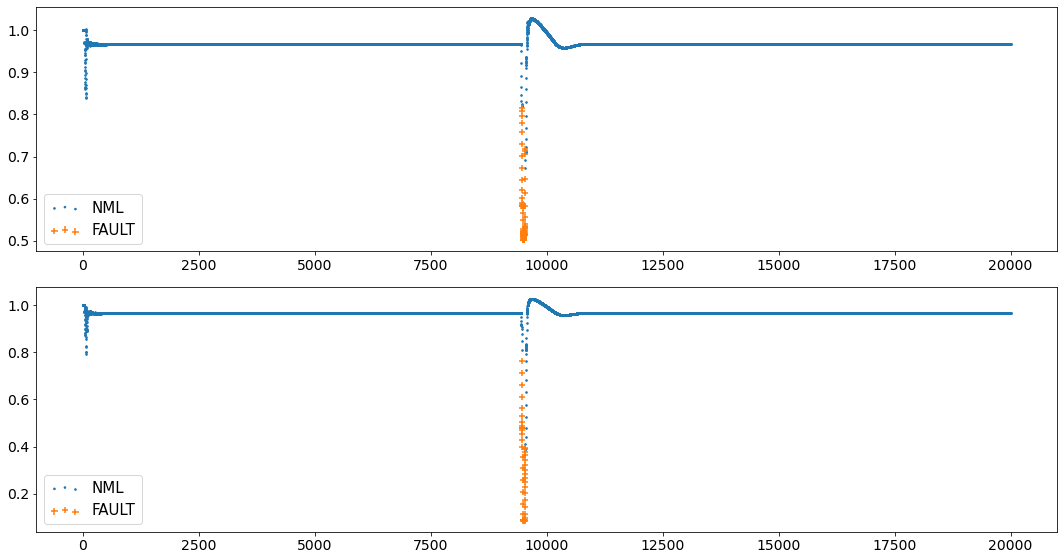

  Fault type Percentage
0        BCG     84.42%
1        ABC      6.49%
2         BG       3.9%
3         BC       3.9%
4       ABCG       1.3%


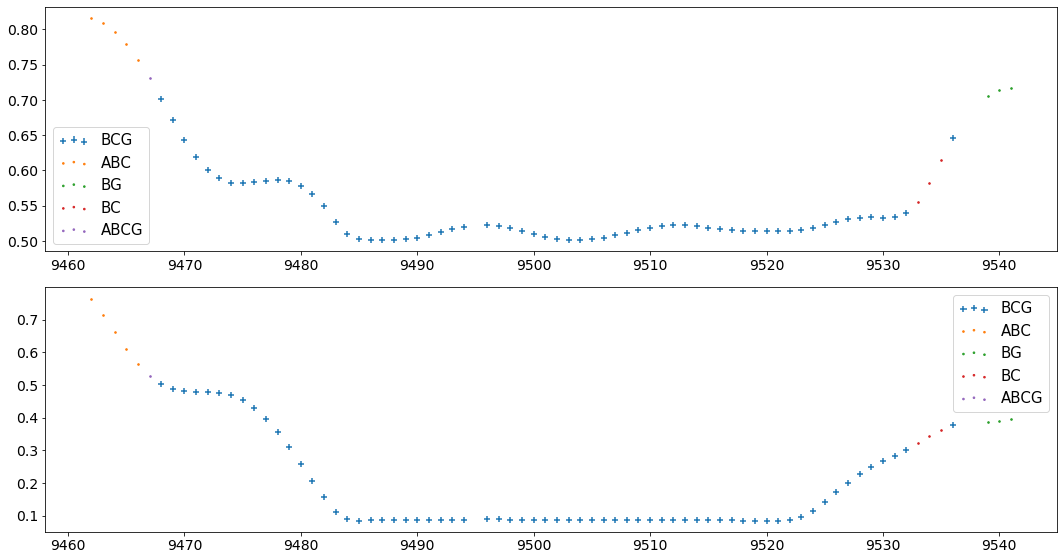


.
.
 10BC.csv
  Fault type Percentage
0        NML     89.87%
1      FAULT     10.13%


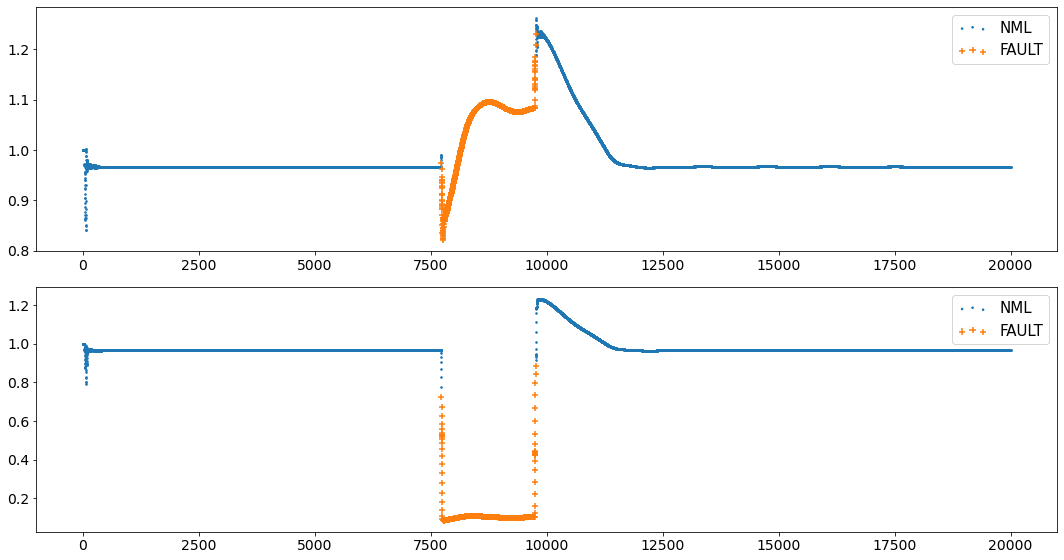

  Fault type Percentage
0         BC     99.85%
1        BCG      0.15%


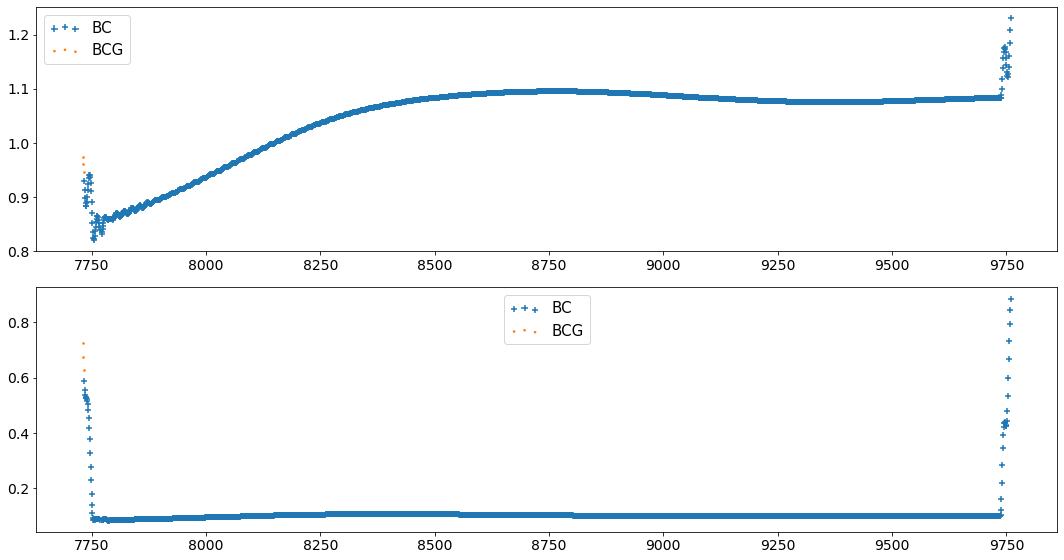


.
.
 10CG.csv
  Fault type Percentage
0        NML     94.76%
1      FAULT      5.24%


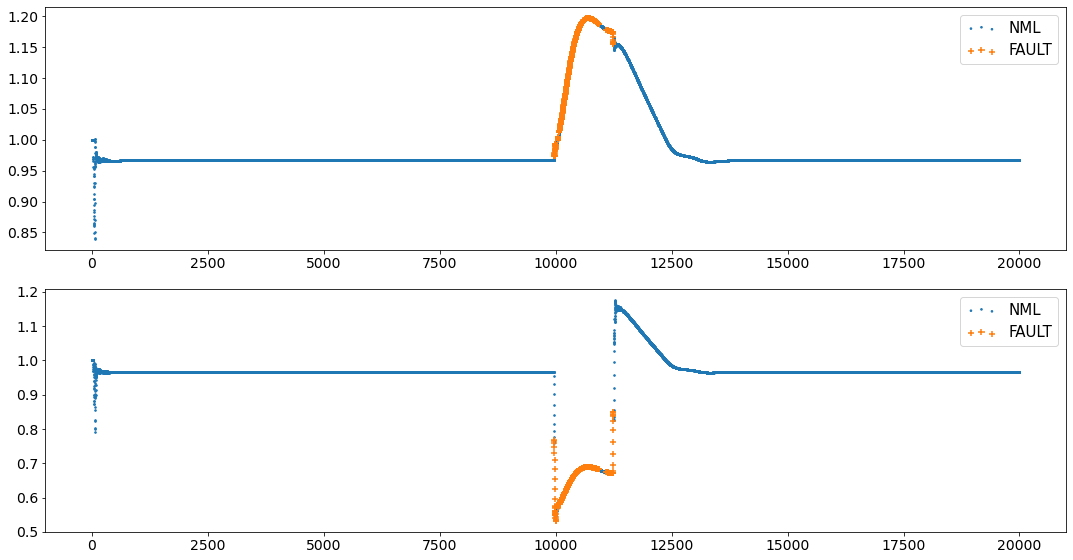

  Fault type Percentage
0         CG     100.0%


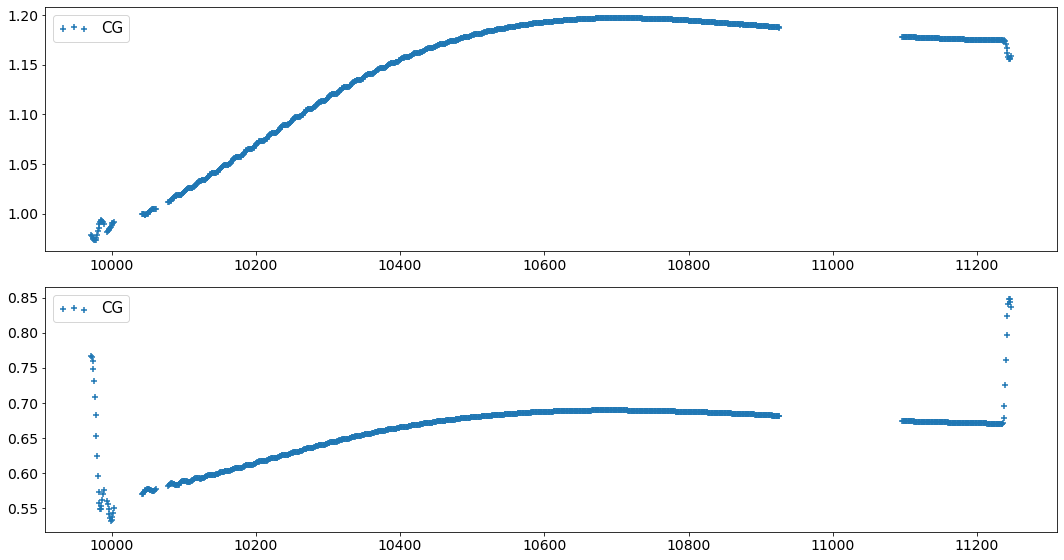


.
.
 10ABCG.csv
  Fault type Percentage
0        NML      88.4%
1      FAULT      11.6%


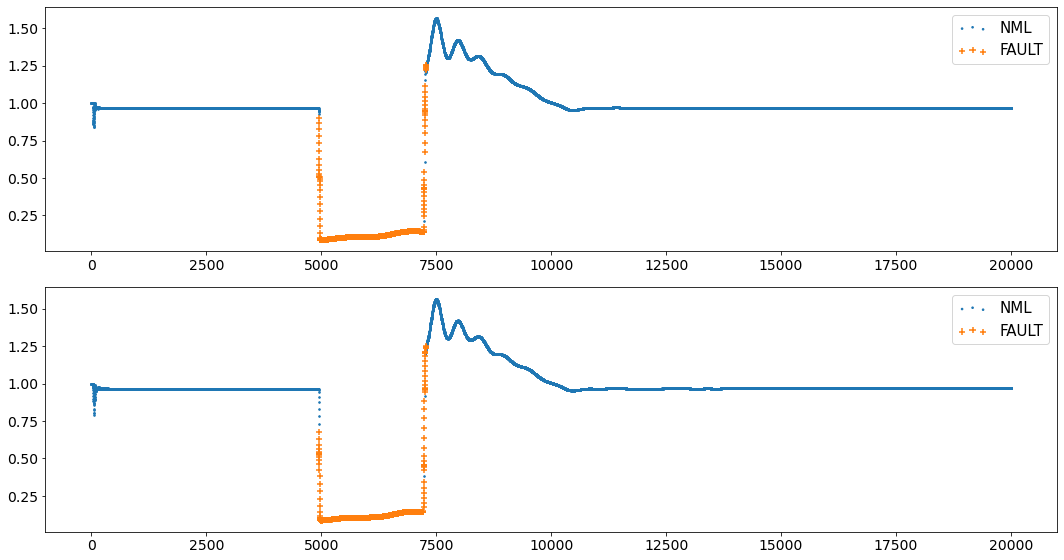

  Fault type Percentage
0        ABC     99.66%
1        BCG       0.3%
2        ACG      0.04%


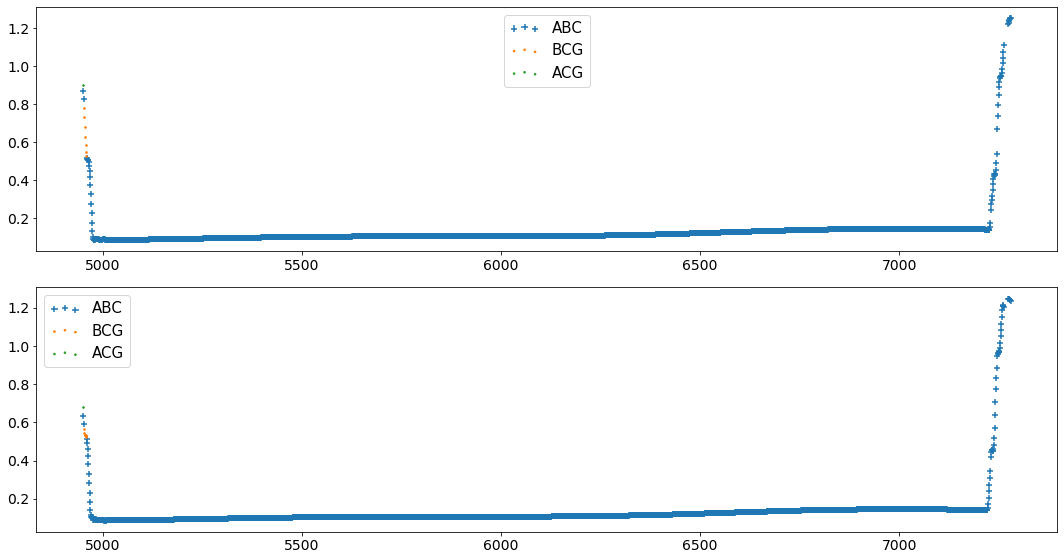


.
.
 6AG.csv
  Fault type Percentage
0        NML     77.25%
1      FAULT     22.75%


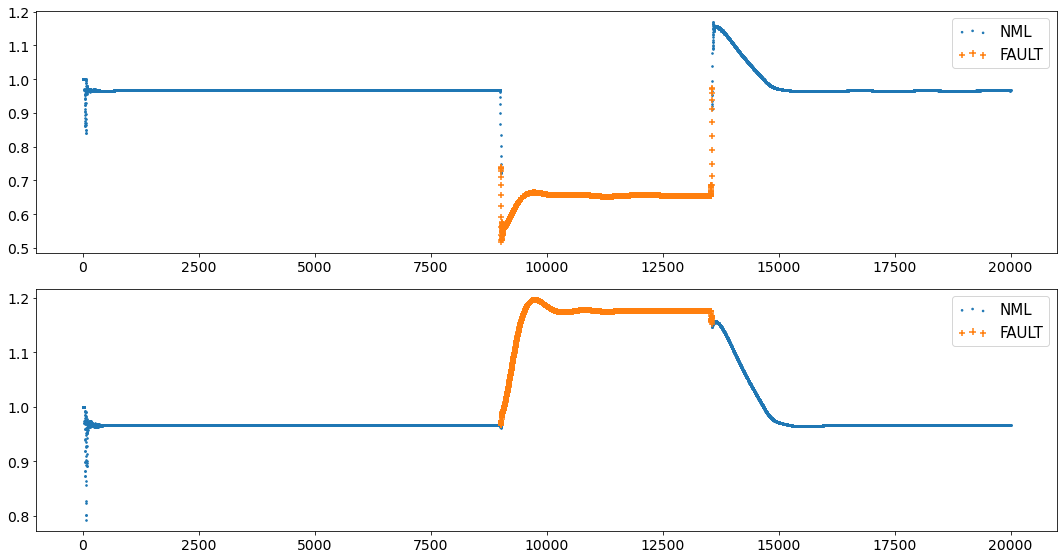

  Fault type Percentage
0         AG     100.0%


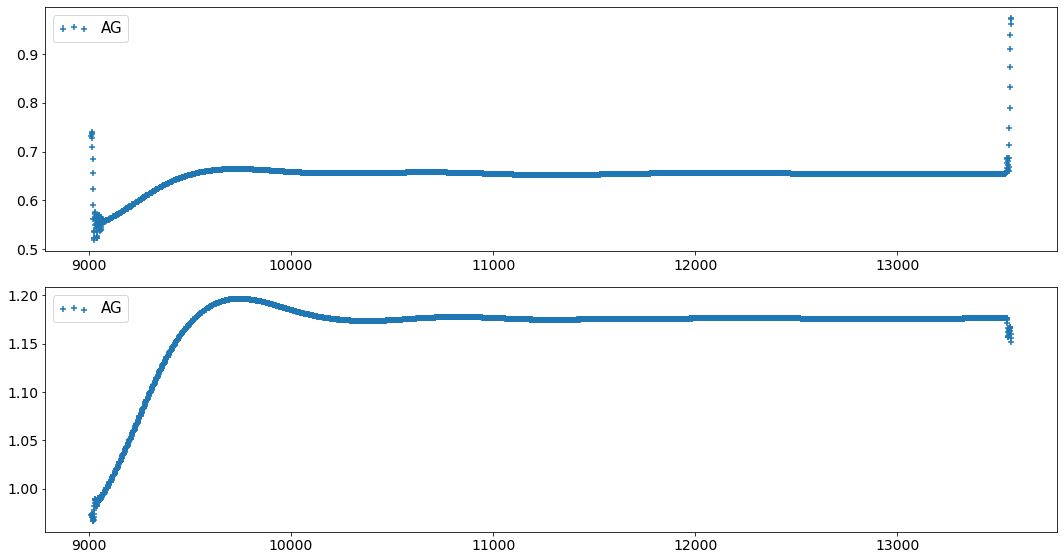


.
.
 3ABCG.csv
  Fault type Percentage
0        NML     99.11%
1      FAULT       0.9%


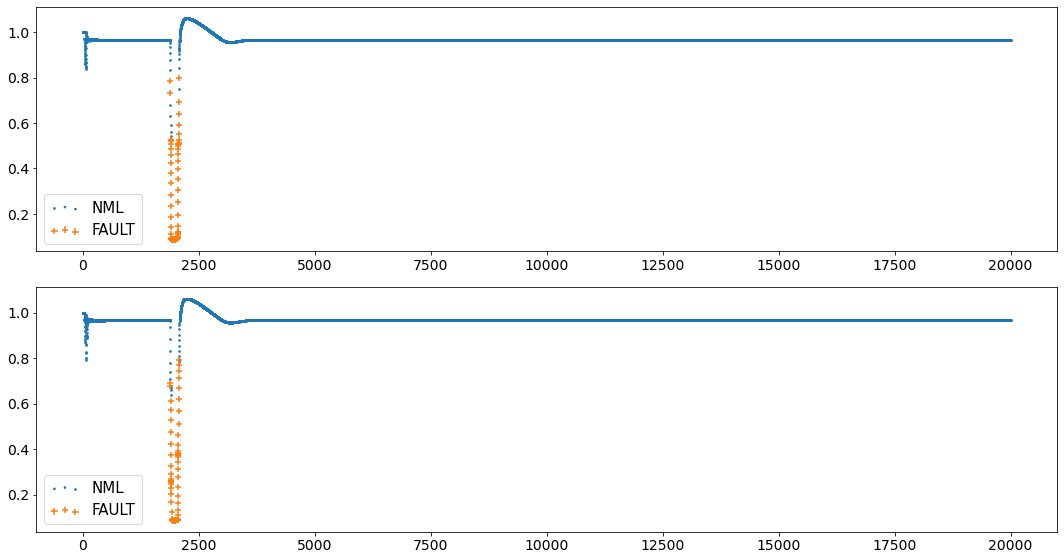

  Fault type Percentage
0        ABC     94.41%
1        BCG      3.35%
2        ABG      2.23%


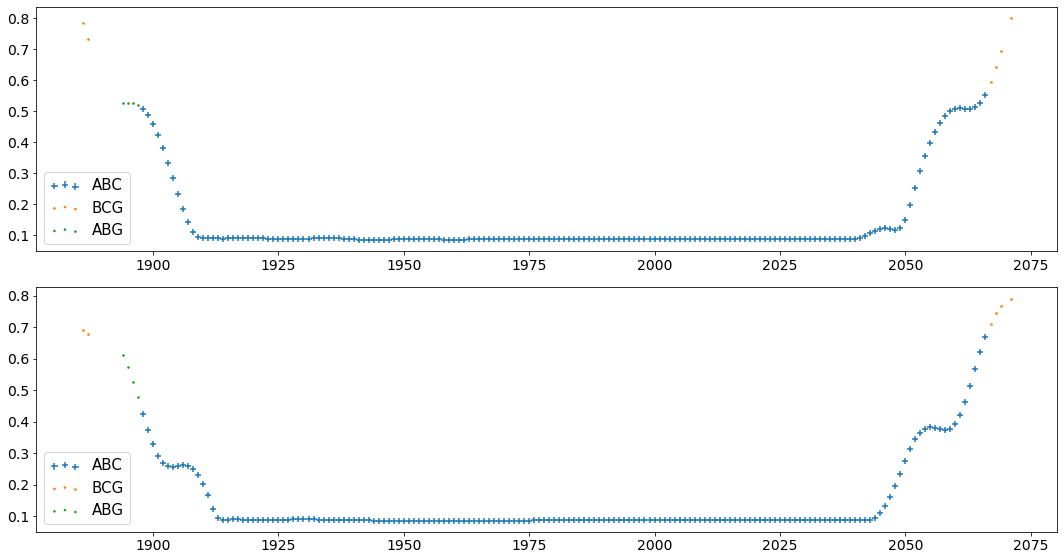


.
.
 2AC.csv
  Fault type Percentage
0        NML     99.83%
1      FAULT      0.17%


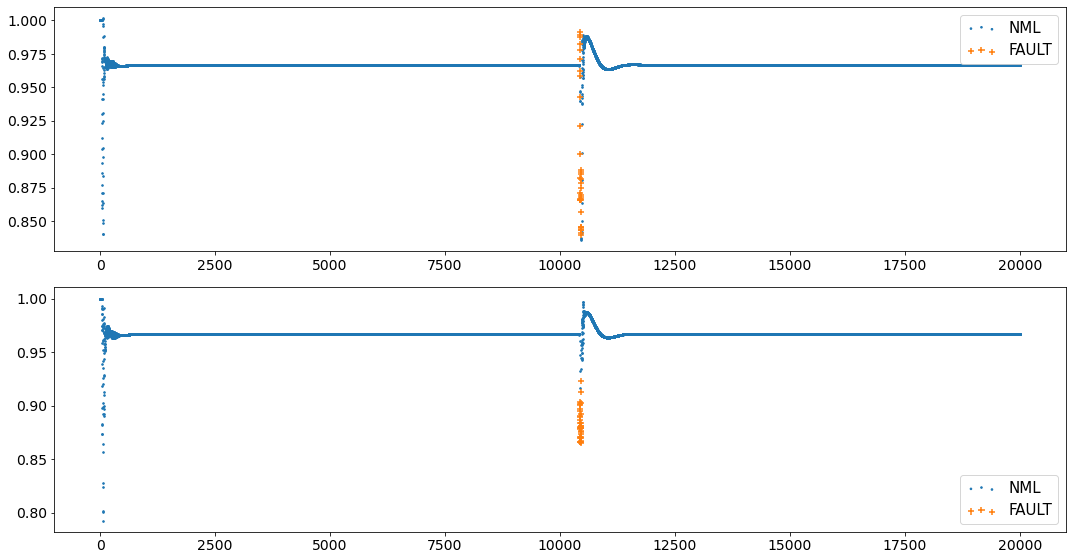

  Fault type Percentage
0         AC     85.29%
1        ACG     14.71%


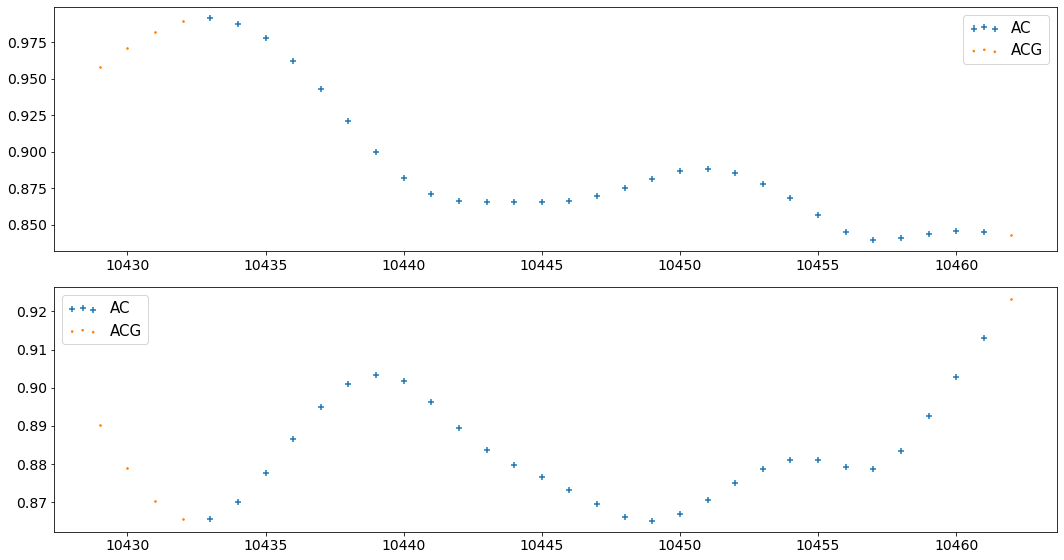


.
.
 4ACG.csv
  Fault type Percentage
0        NML     99.48%
1      FAULT      0.52%


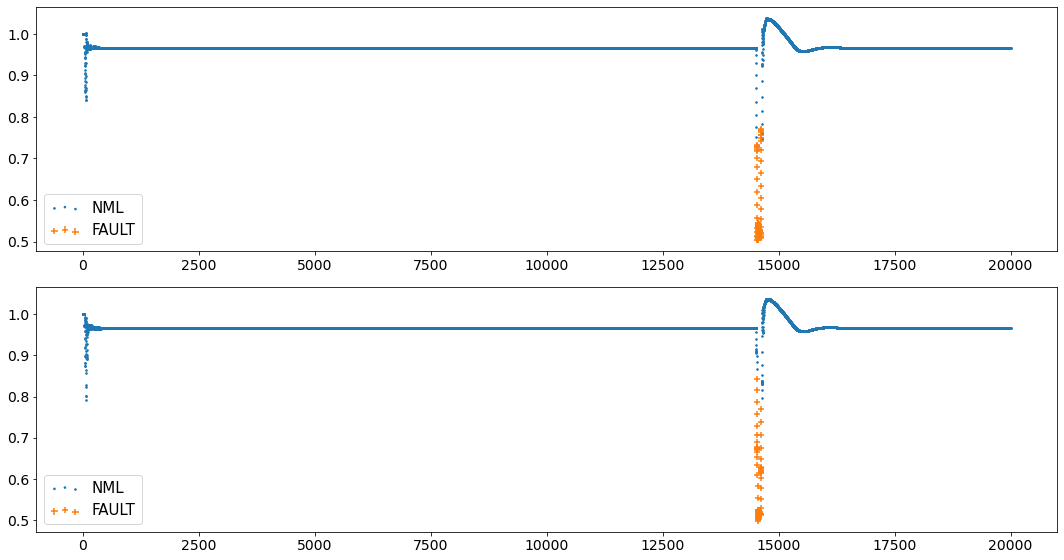

  Fault type Percentage
0        ACG     96.15%
1         AG      2.88%
2         CG      0.96%


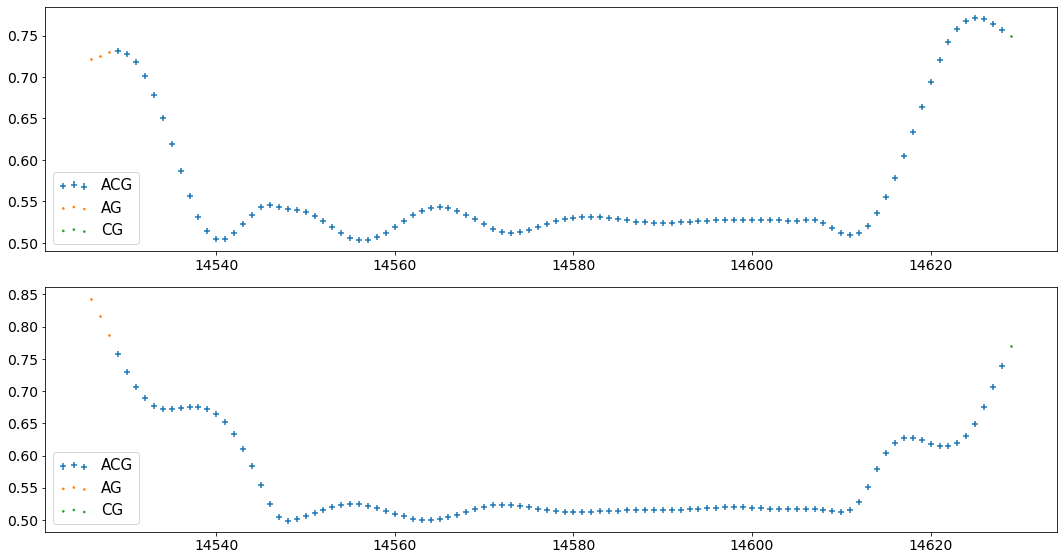


.
.
 4ABC.csv
  Fault type Percentage
0        NML     78.43%
1      FAULT     21.57%


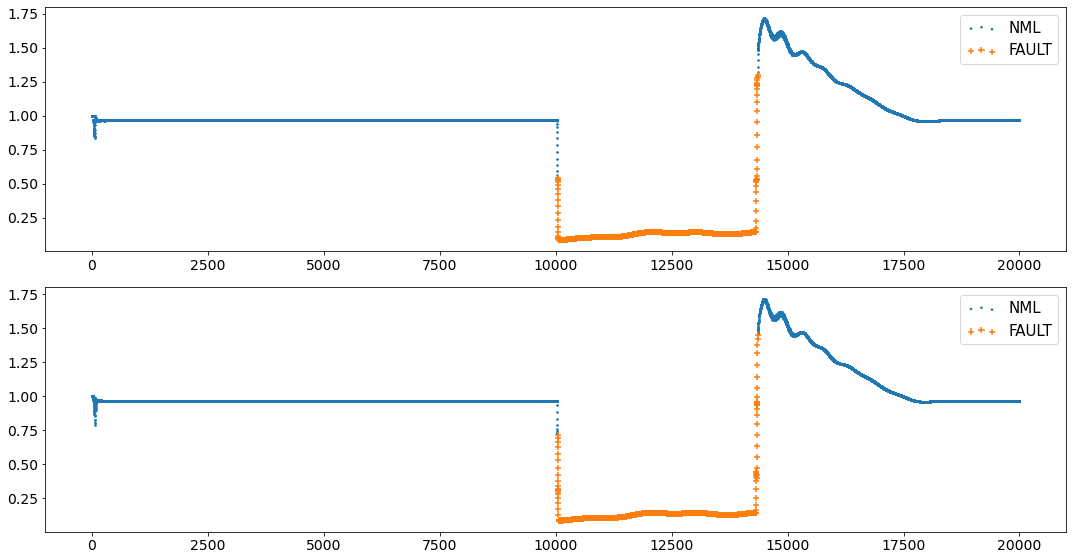

  Fault type Percentage
0        ABC     99.63%
1        ABG      0.14%
2        ACG      0.09%
3        BCG      0.07%
4       ABCG      0.07%


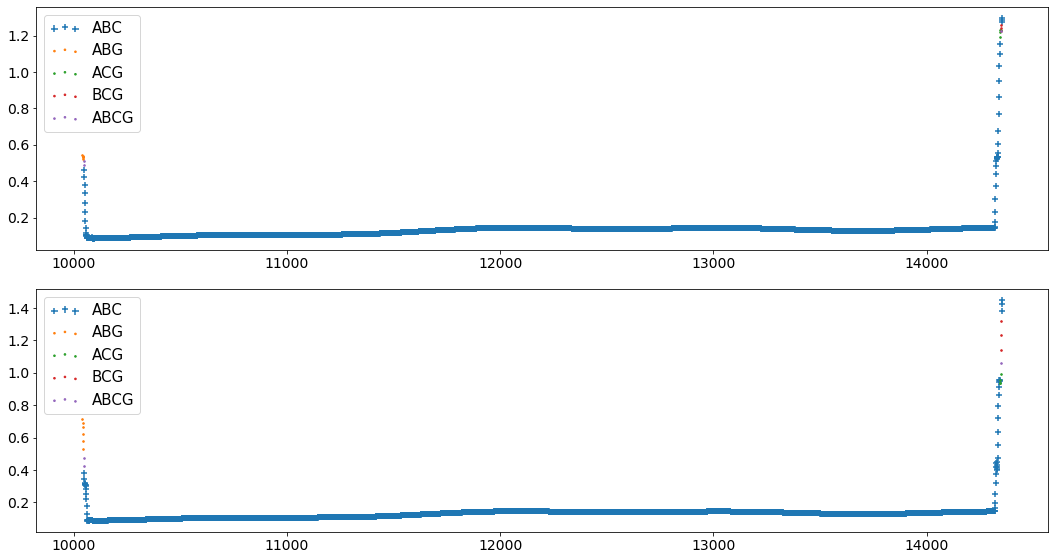


.
.
 8ABC.csv
  Fault type Percentage
0        NML     94.14%
1      FAULT      5.87%


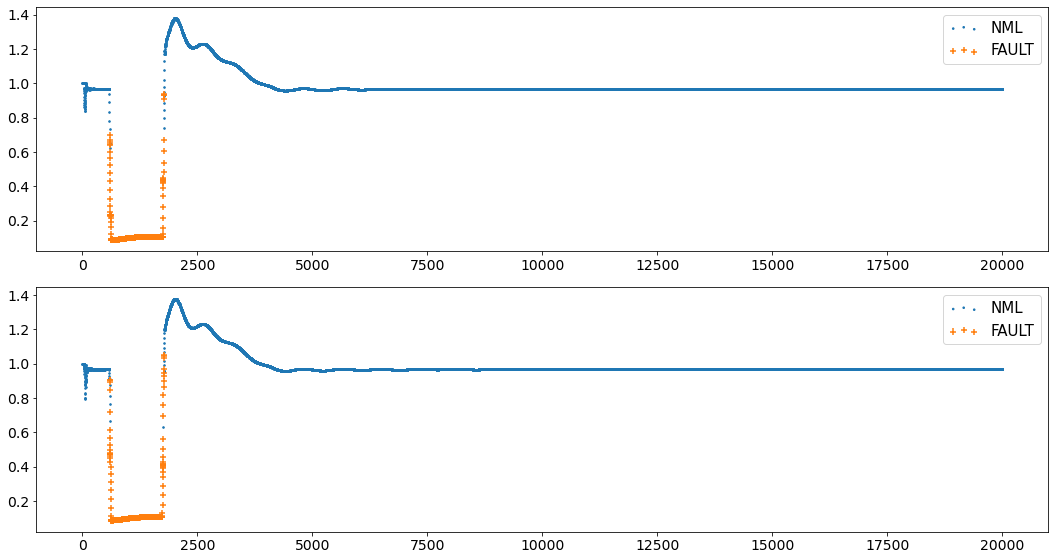

  Fault type Percentage
0        ABC     99.15%
1        ACG      0.43%
2        ABG      0.43%


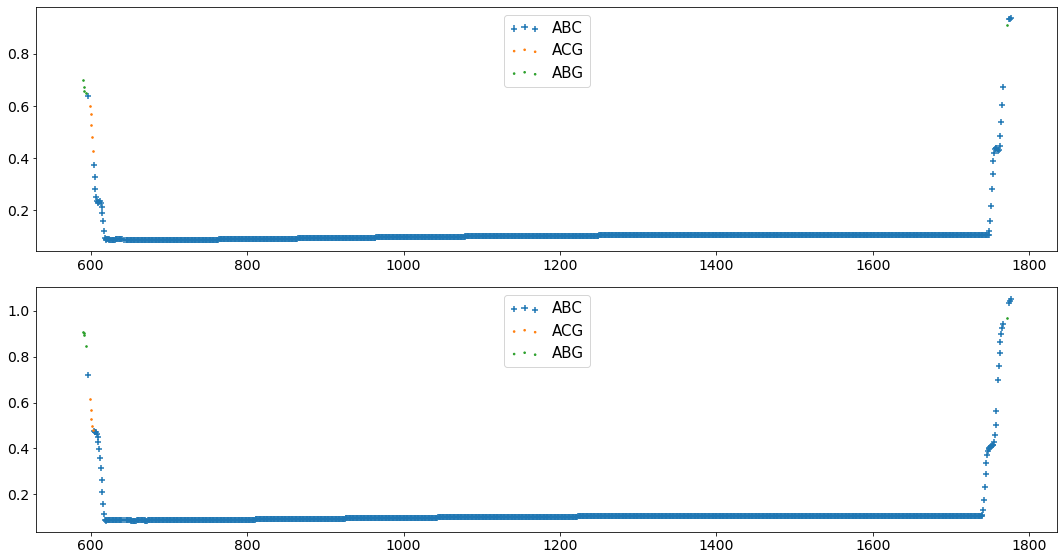


.
.
 8ACG.csv
  Fault type Percentage
0        NML      99.8%
1      FAULT       0.2%


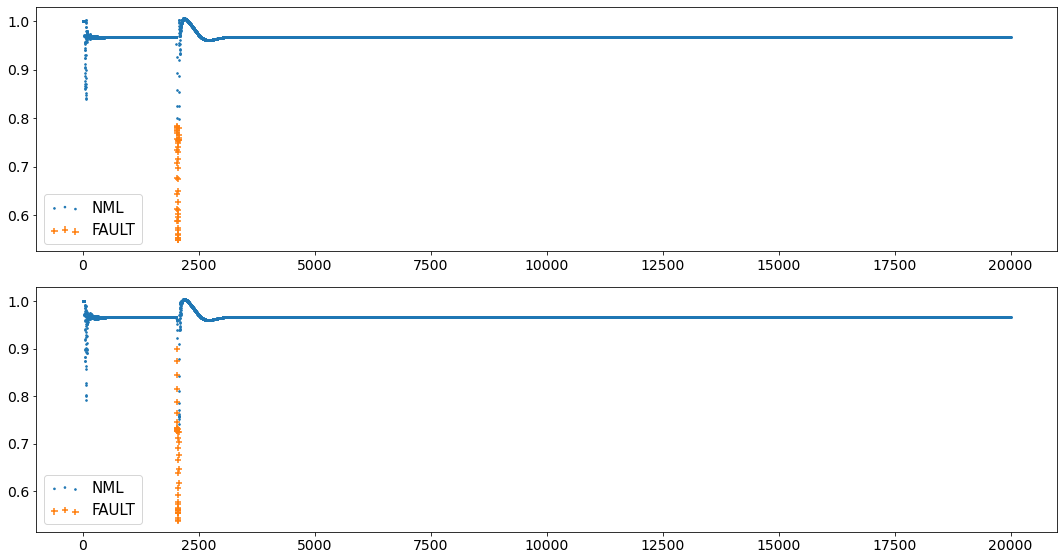

  Fault type Percentage
0        ACG      80.0%
1         CG      15.0%
2         AC       5.0%


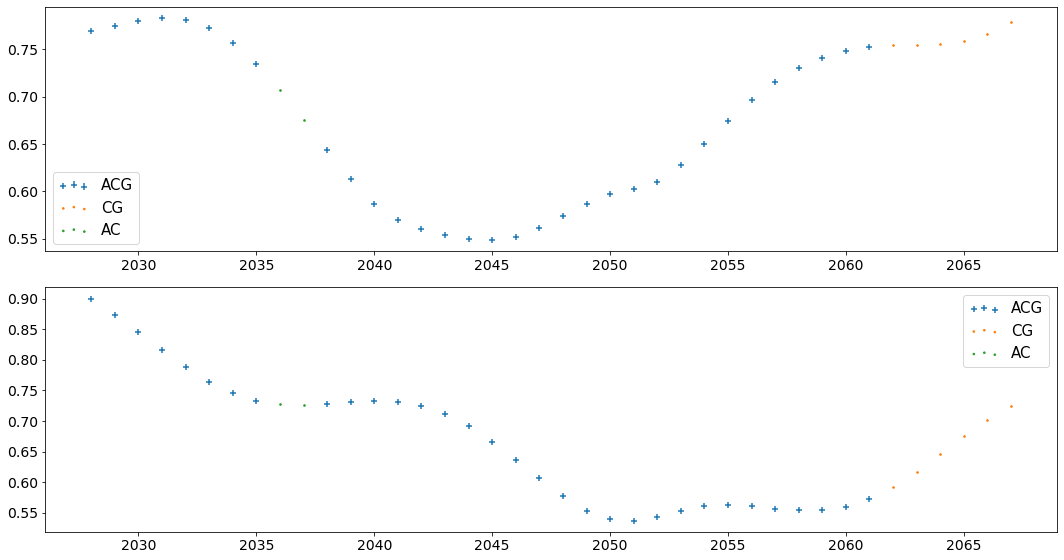


.
.
 4AG.csv
  Fault type Percentage
0        NML     74.24%
1      FAULT     25.76%


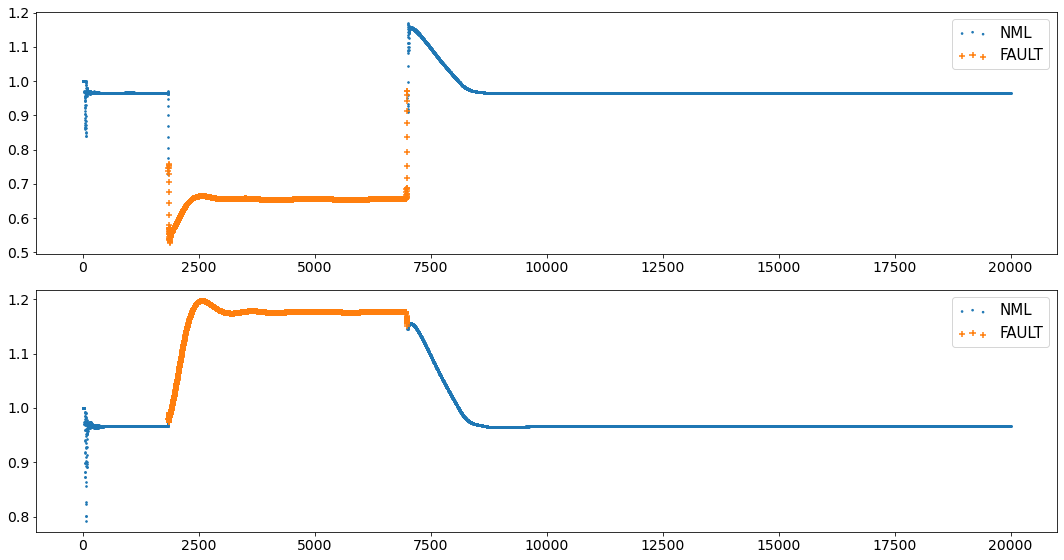

  Fault type Percentage
0         AG     100.0%


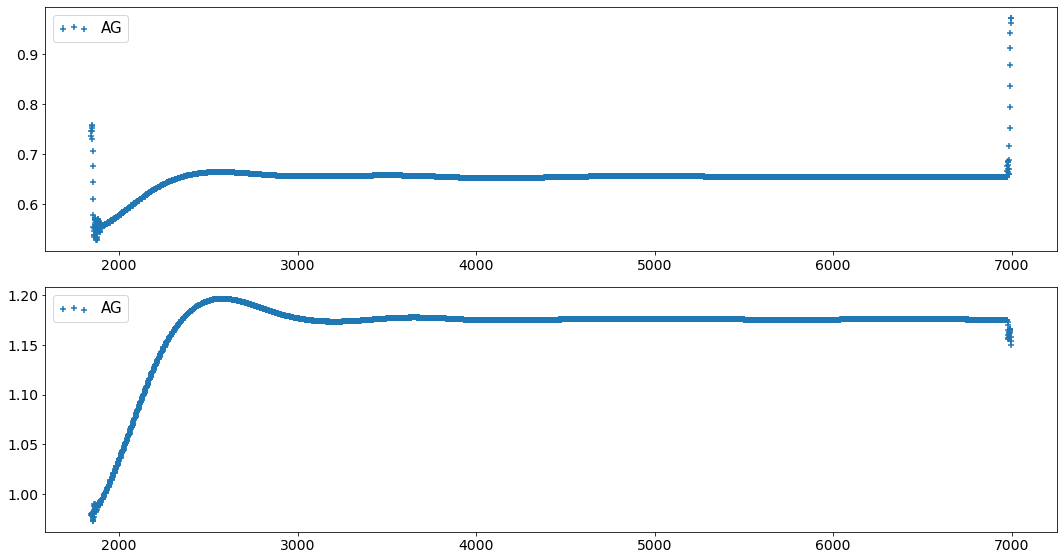


.
.
 6ABG.csv
  Fault type Percentage
0        NML     61.62%
1      FAULT     38.38%


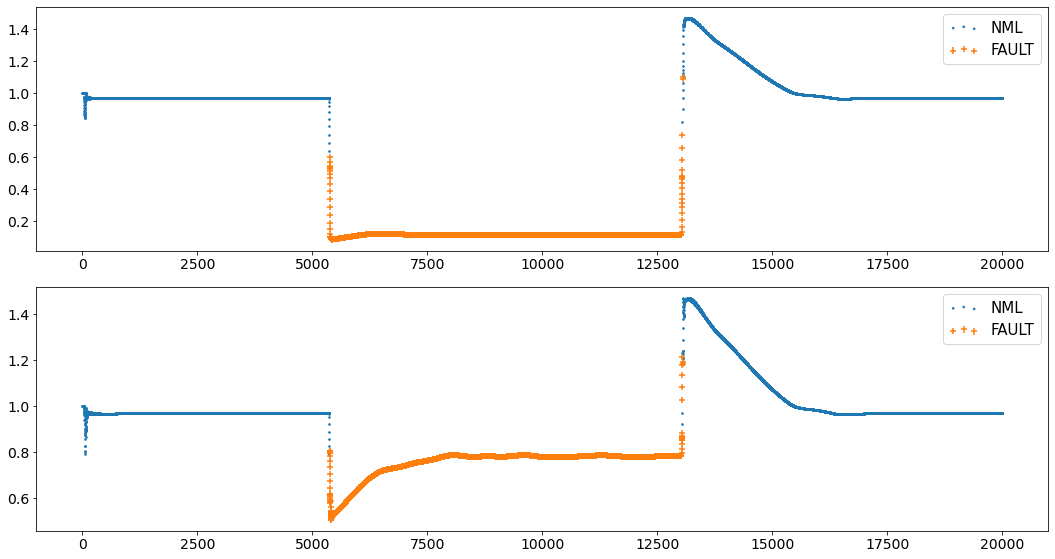

  Fault type Percentage
0        ABG     99.79%
1         AB      0.18%
2         AG      0.03%


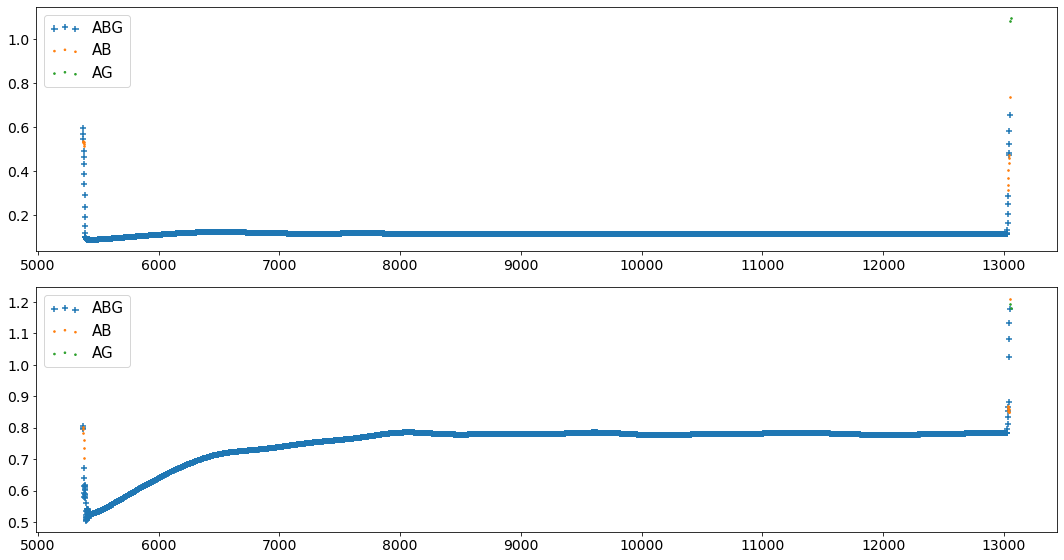


.
.
 8BG.csv
  Fault type Percentage
0        NML     95.35%
1      FAULT      4.65%


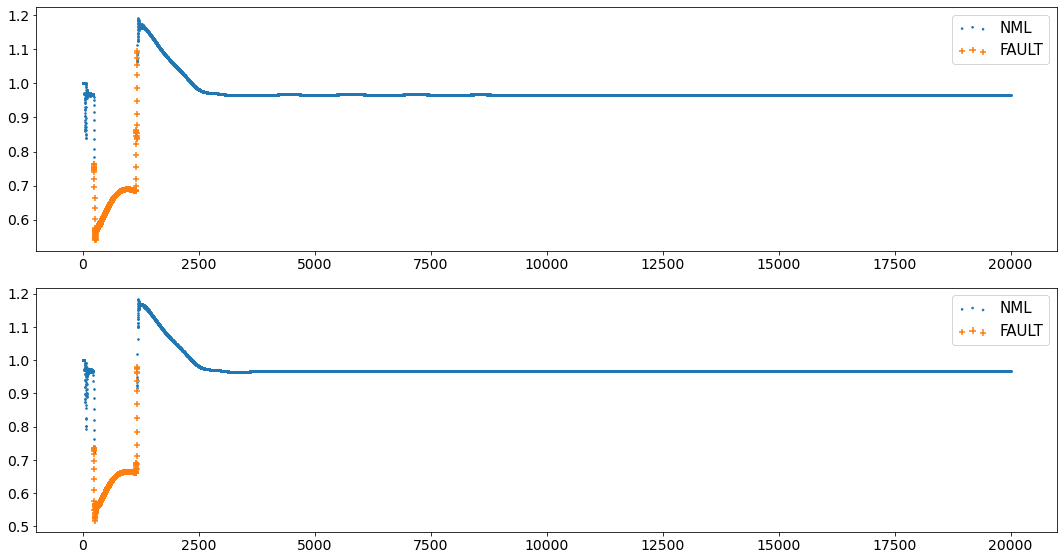

  Fault type Percentage
0         BG     100.0%


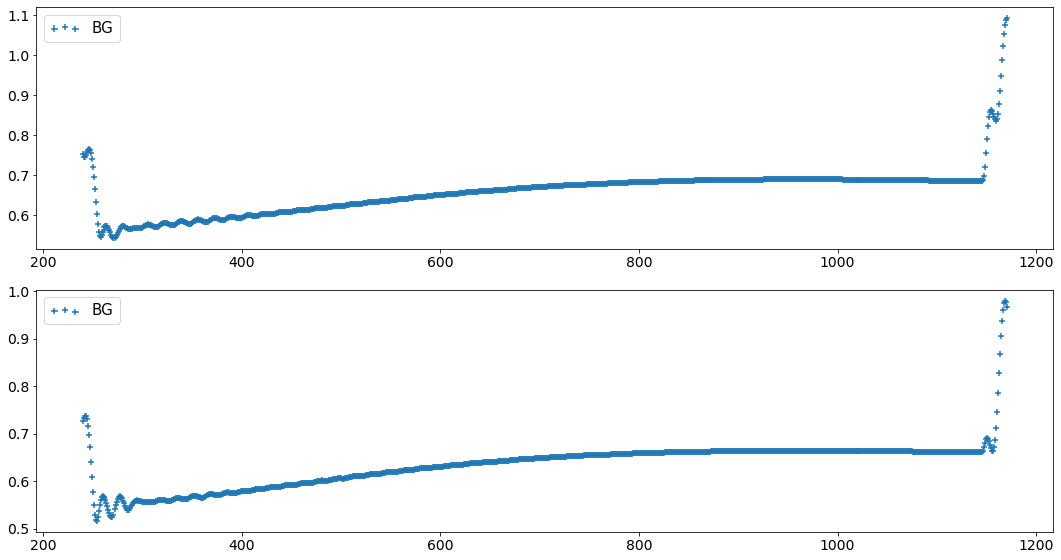


.
.
 7AC.csv
  Fault type Percentage
0        NML     91.55%
1      FAULT      8.45%


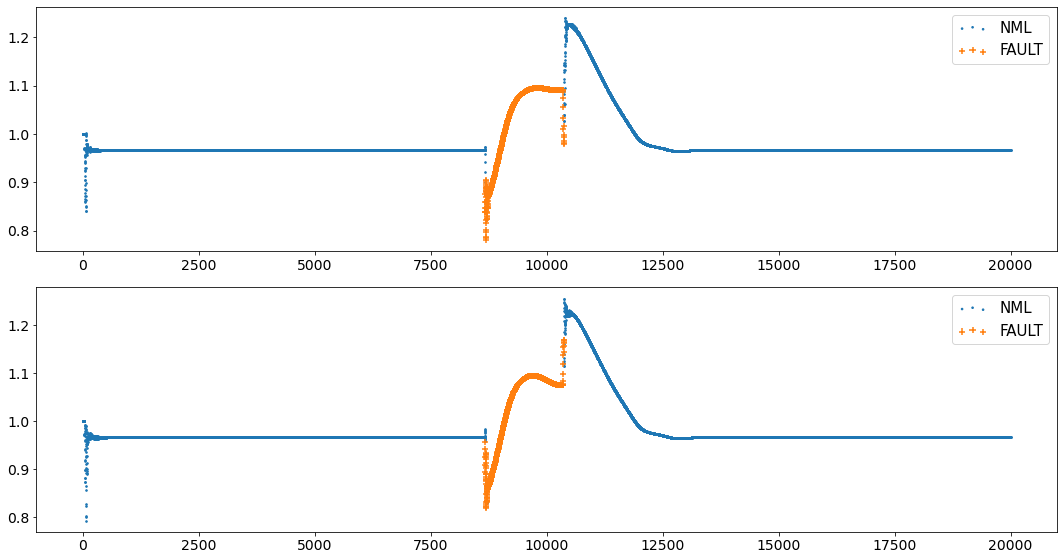

  Fault type Percentage
0         AC     99.53%
1        ACG      0.41%
2         CG      0.06%


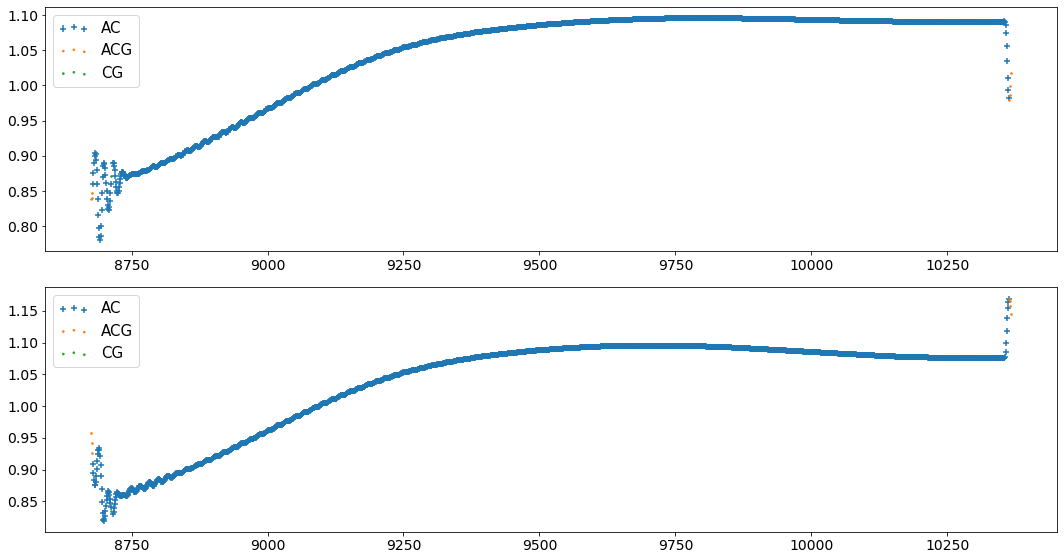


.
.
 3AG.csv
  Fault type Percentage
0        NML     90.14%
1      FAULT      9.86%


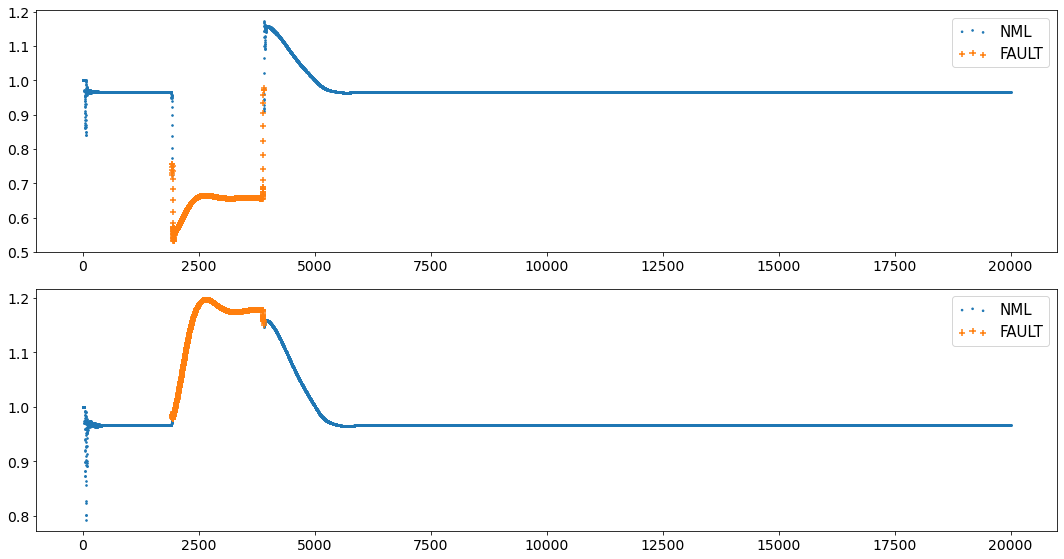

  Fault type Percentage
0         AG     100.0%


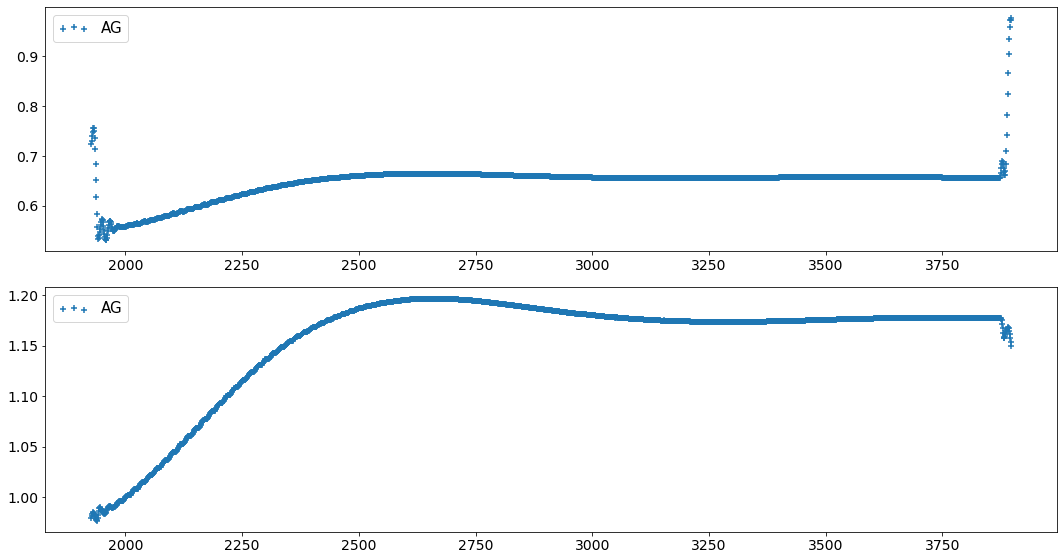


.
.
 1ABCG.csv
  Fault type Percentage
0        NML     99.42%
1      FAULT      0.58%


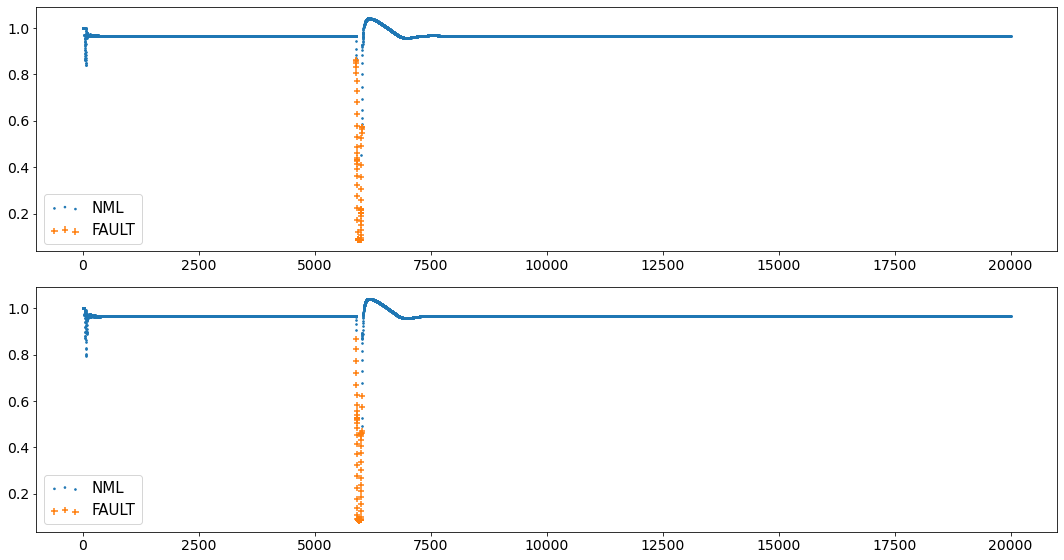

  Fault type Percentage
0        ABC     88.79%
1        ACG      7.76%
2        ABG      3.45%


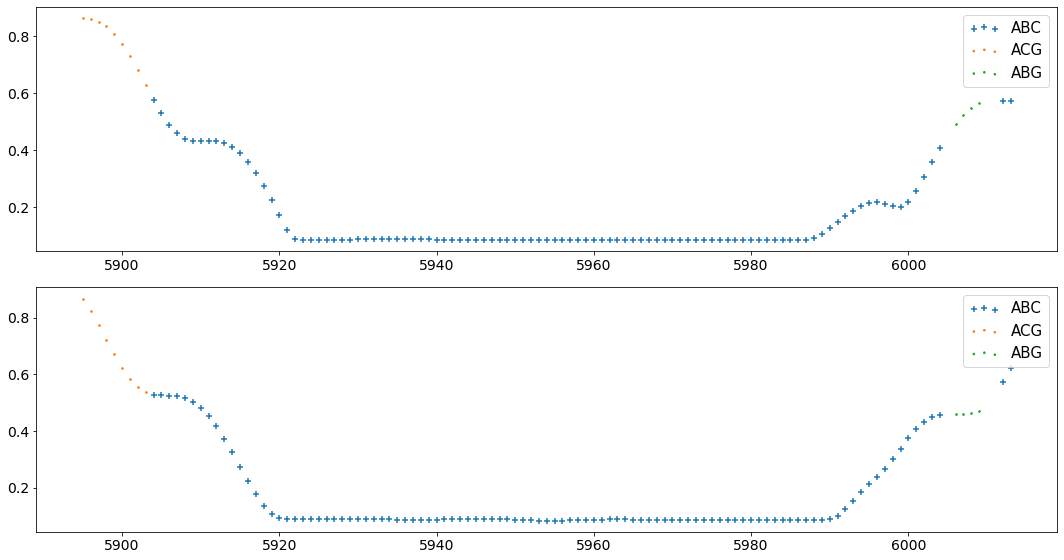


.
.
 7AB.csv
  Fault type Percentage
0        NML     69.53%
1      FAULT     30.46%


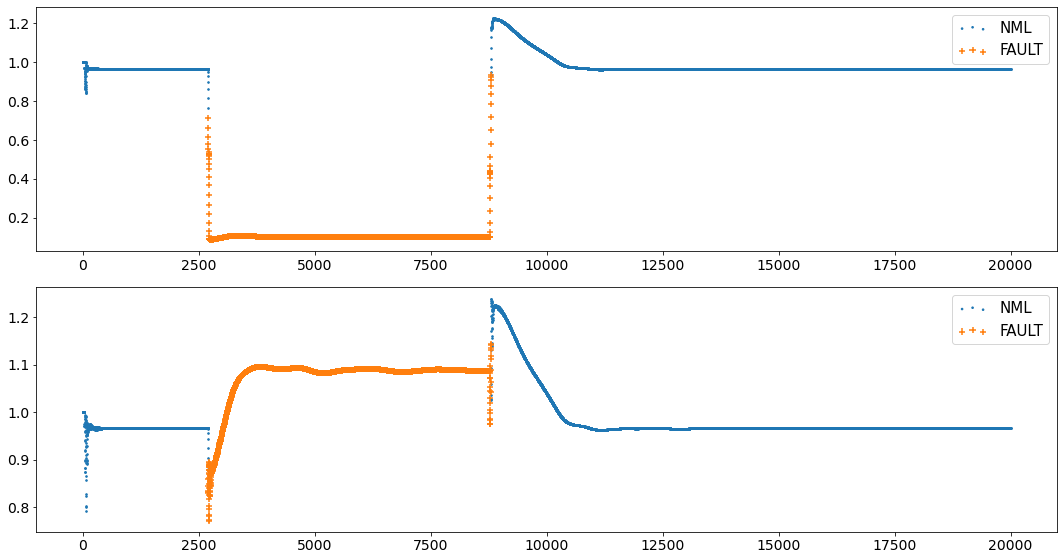

  Fault type Percentage
0         AB     99.92%
1         AG      0.05%
2        ABG      0.03%


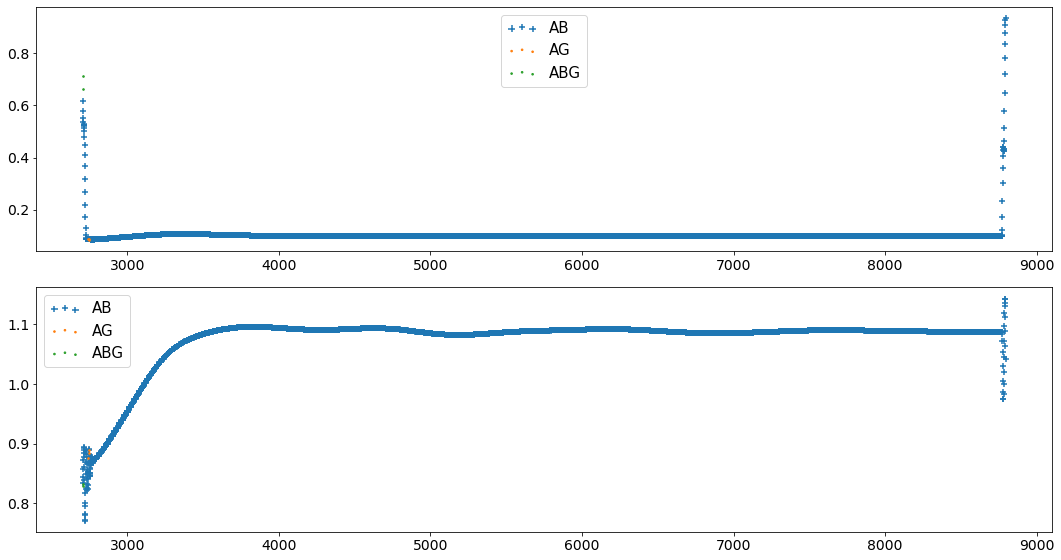


.
.
 6BCG.csv
  Fault type Percentage
0        NML     87.36%
1      FAULT     12.64%


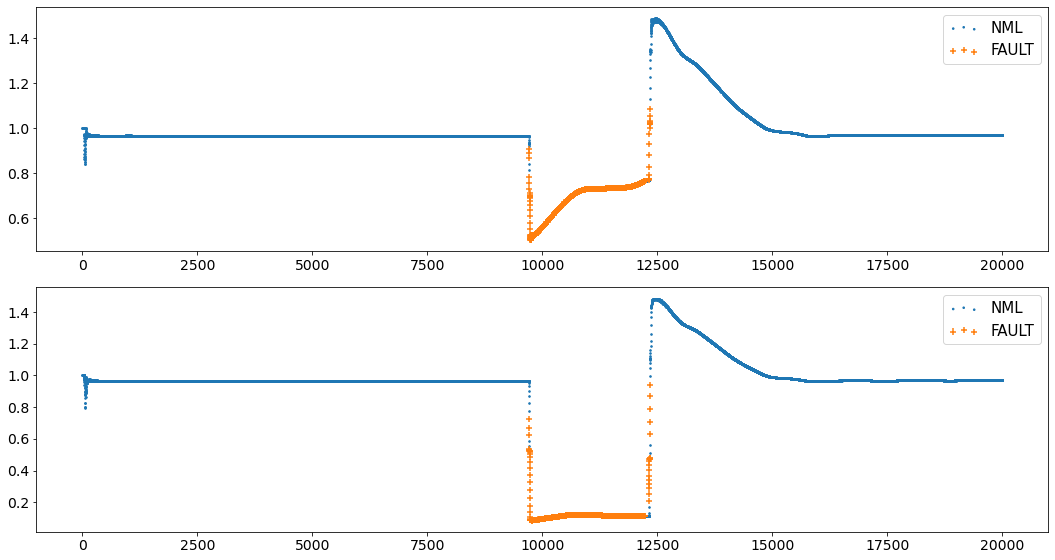

  Fault type Percentage
0        BCG     99.45%
1         BC      0.44%
2         CG      0.12%


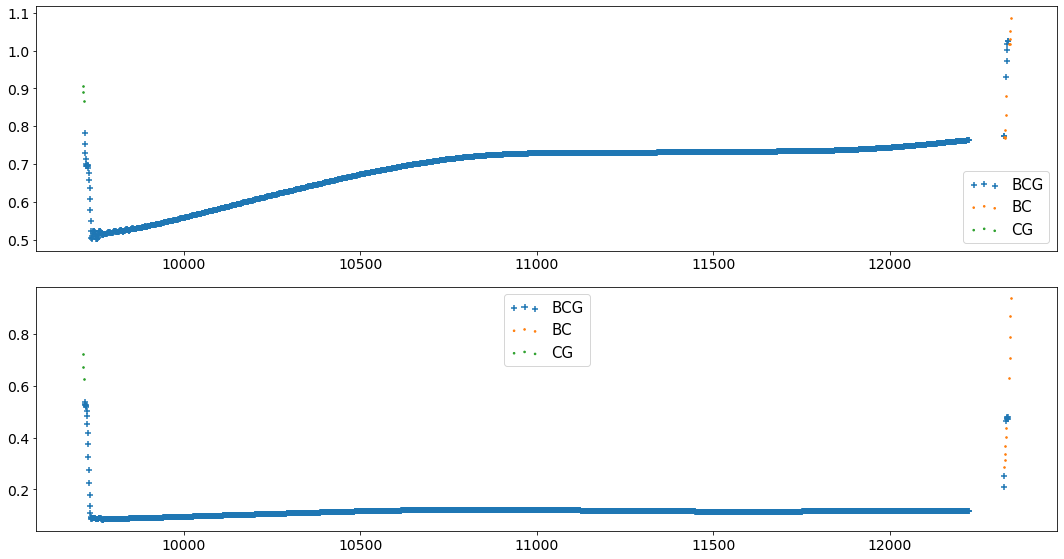


.
.
 5AB.csv
  Fault type Percentage
0        NML      92.0%
1      FAULT       8.0%


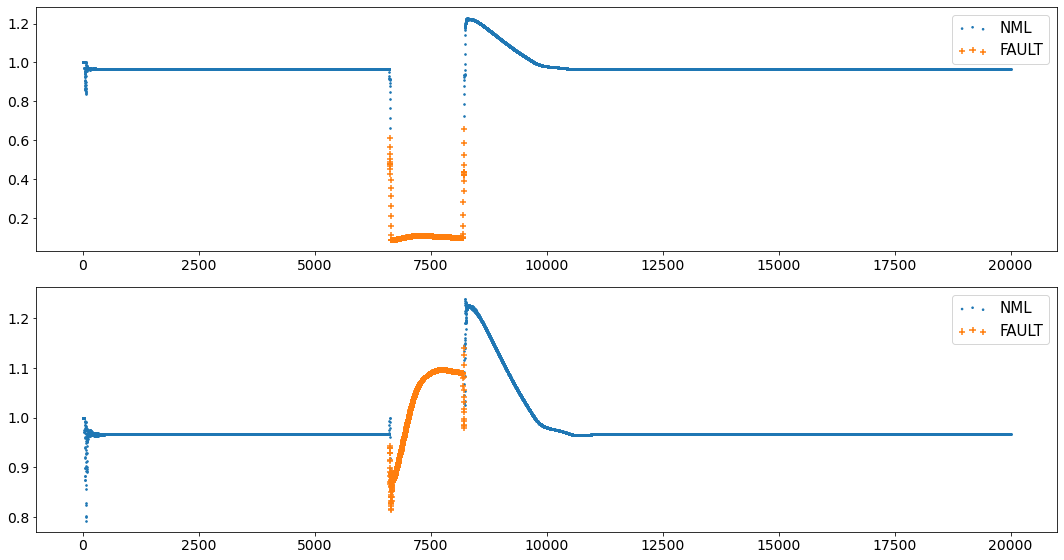

  Fault type Percentage
0         AB     99.25%
1        ABG      0.75%


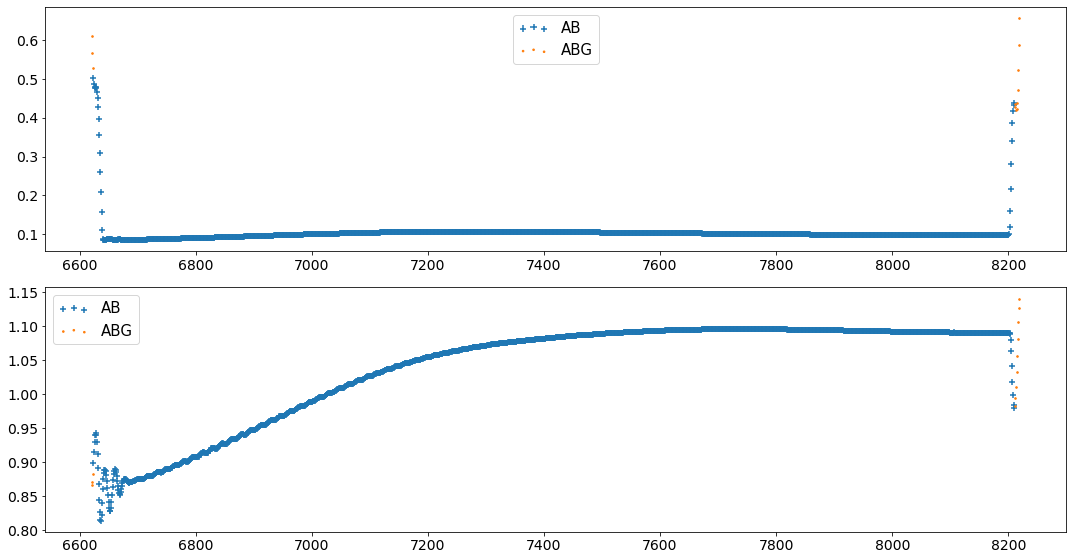


.
.
 9CG.csv
  Fault type Percentage
0        NML      86.9%
1      FAULT      13.1%


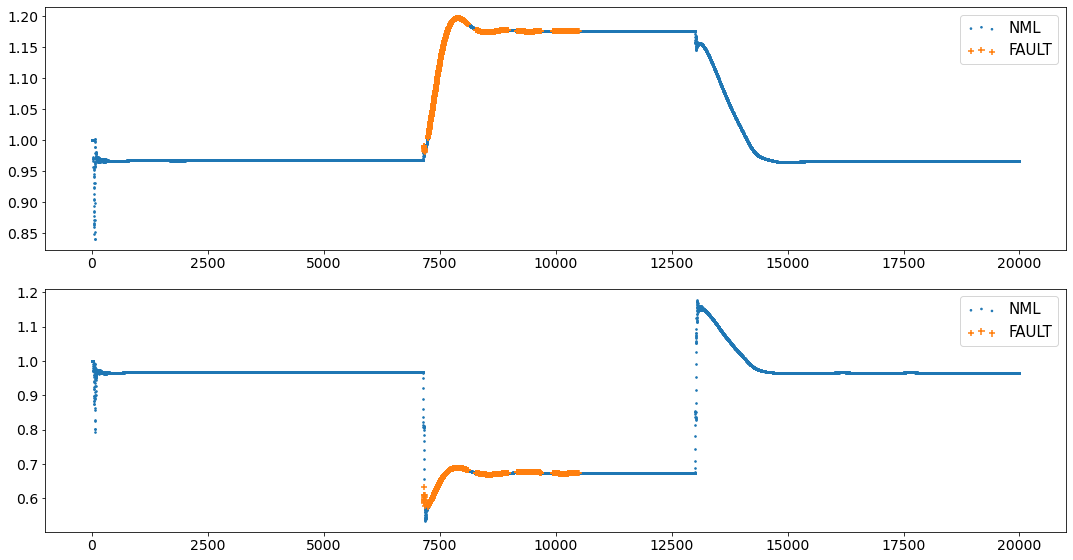

  Fault type Percentage
0         CG     100.0%


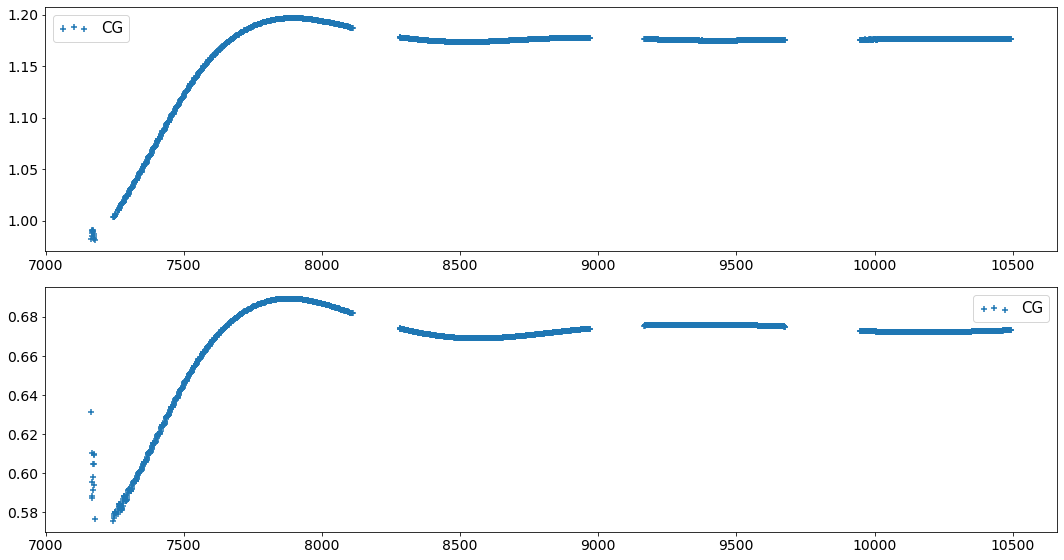


.
.
 9BC.csv
  Fault type Percentage
0        NML     83.41%
1      FAULT     16.59%


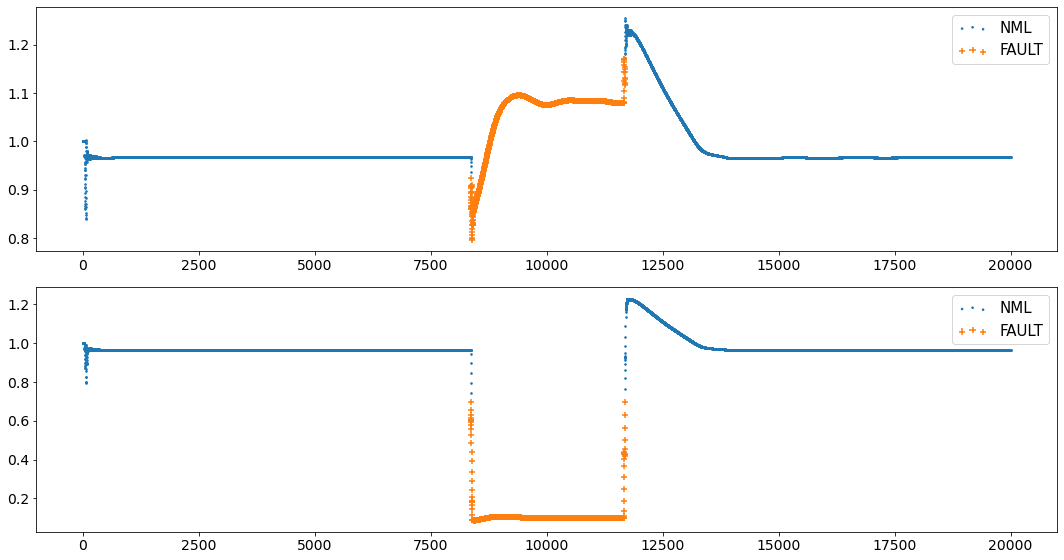

  Fault type Percentage
0         BC     99.88%
1        BCG      0.12%


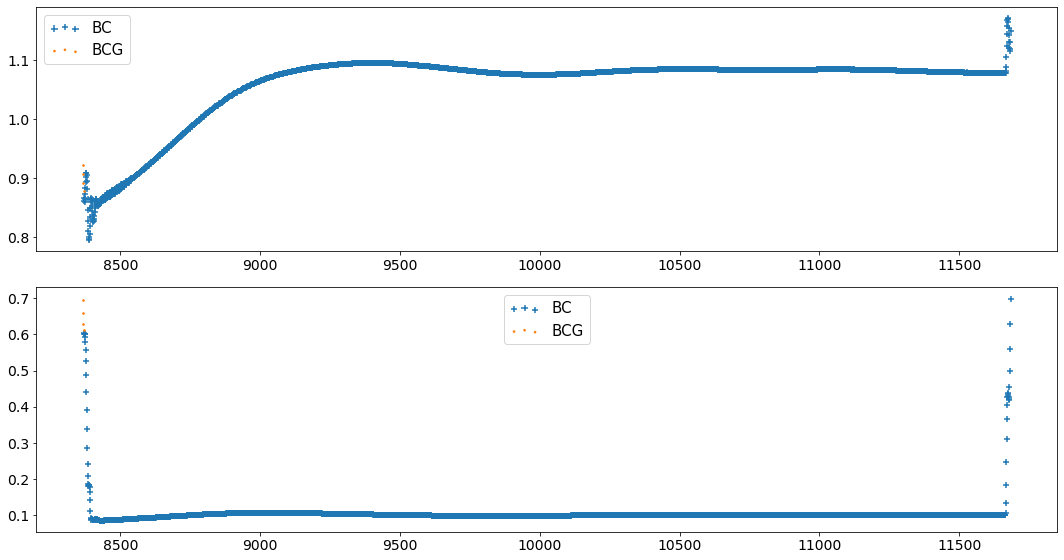


.
.
 2ABG.csv
  Fault type Percentage
0        NML     89.38%
1      FAULT     10.62%


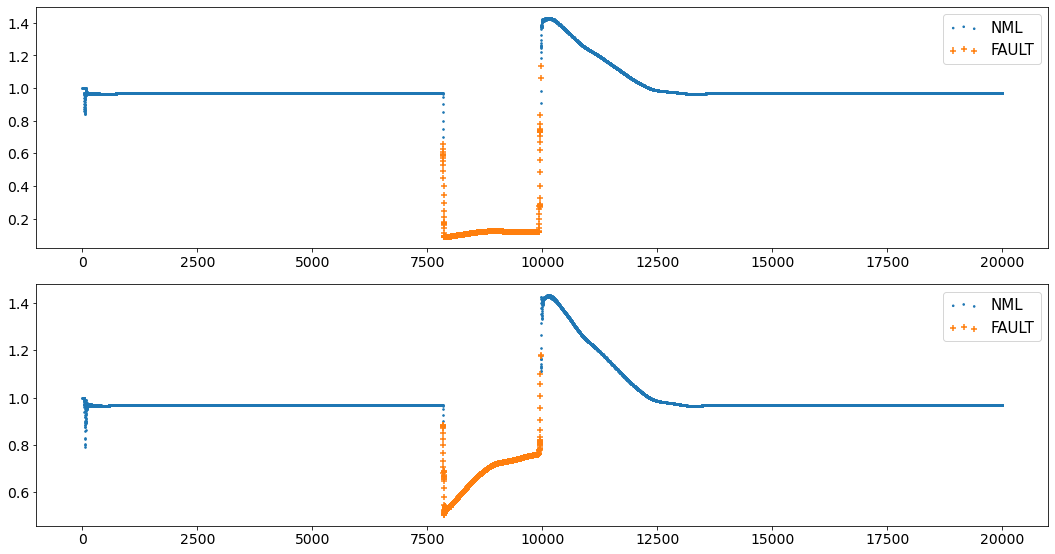

  Fault type Percentage
0        ABG     99.34%
1         AB      0.47%
2         BG      0.19%


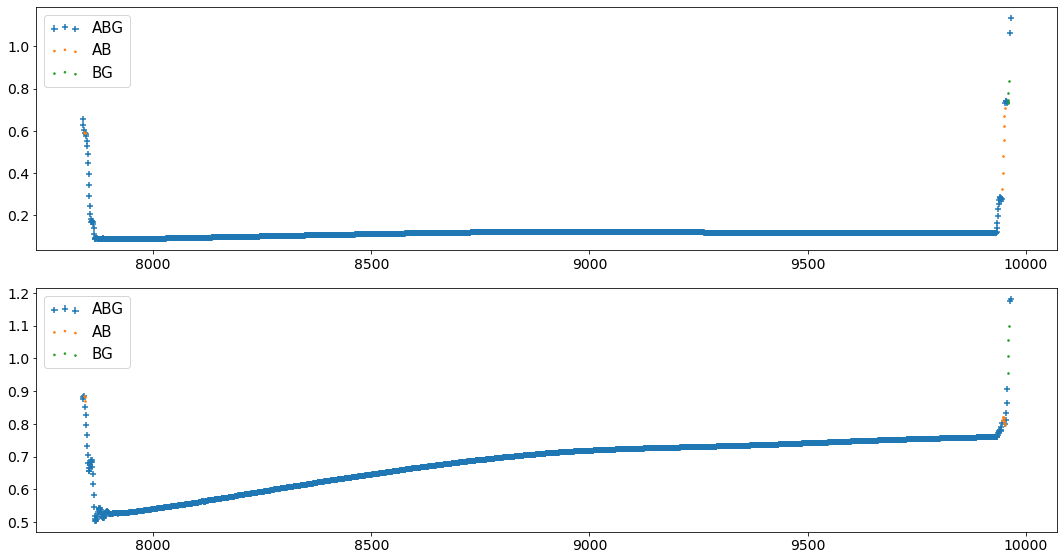


.
.
 1AG.csv
  Fault type Percentage
0        NML     51.97%
1      FAULT     48.03%


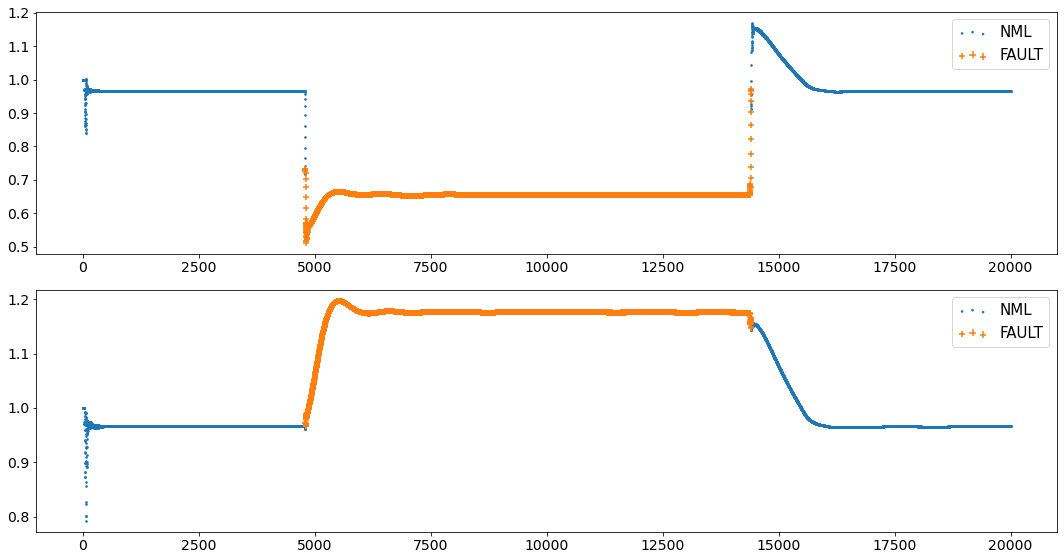

  Fault type Percentage
0         AG     100.0%


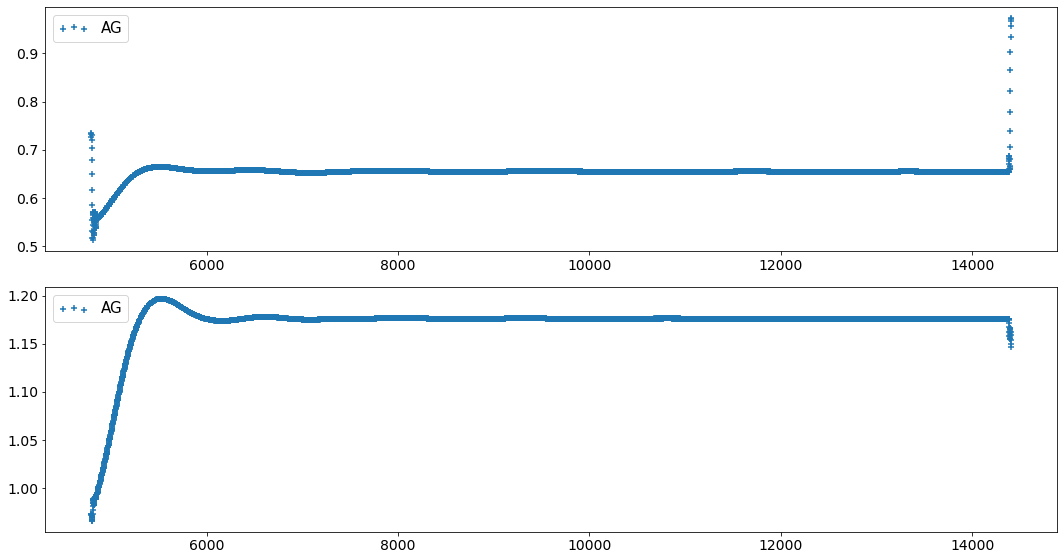


.
.
 8ABCG.csv
  Fault type Percentage
0        NML     97.52%
1      FAULT      2.48%


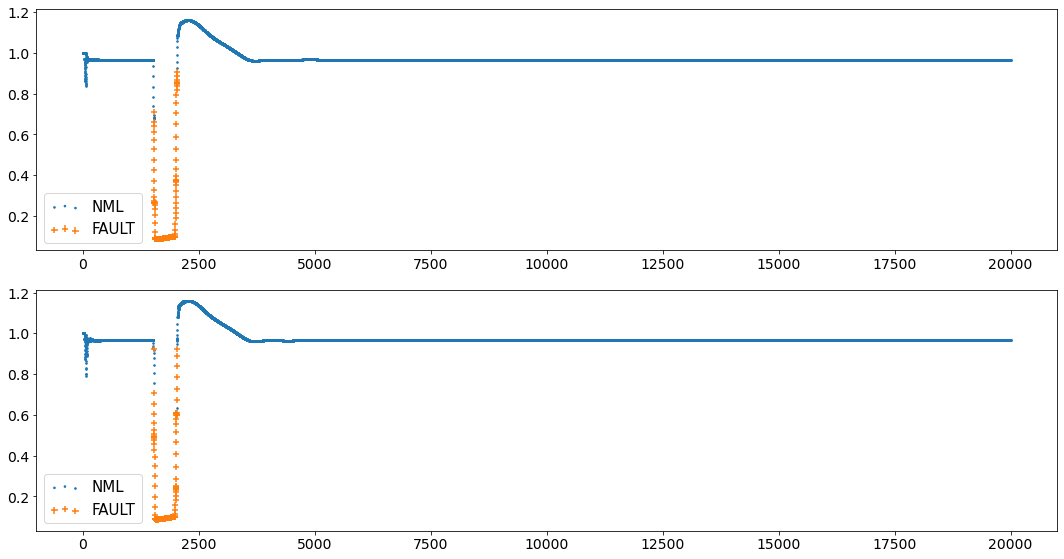

  Fault type Percentage
0        ABC     96.98%
1        ACG      2.22%
2         CG       0.6%
3        ABG       0.2%


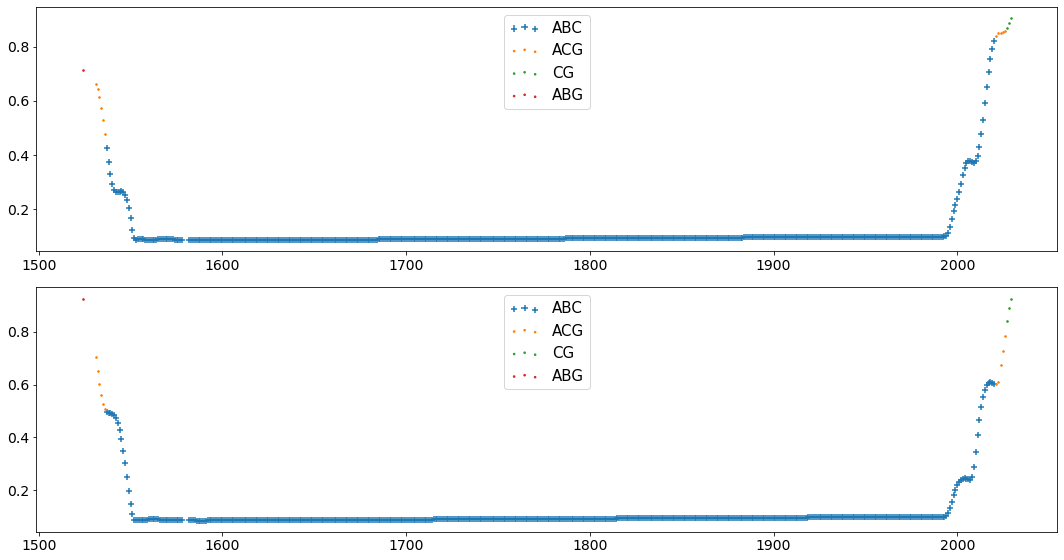


.
.
 5AC.csv
  Fault type Percentage
0        NML     72.94%
1      FAULT     27.06%


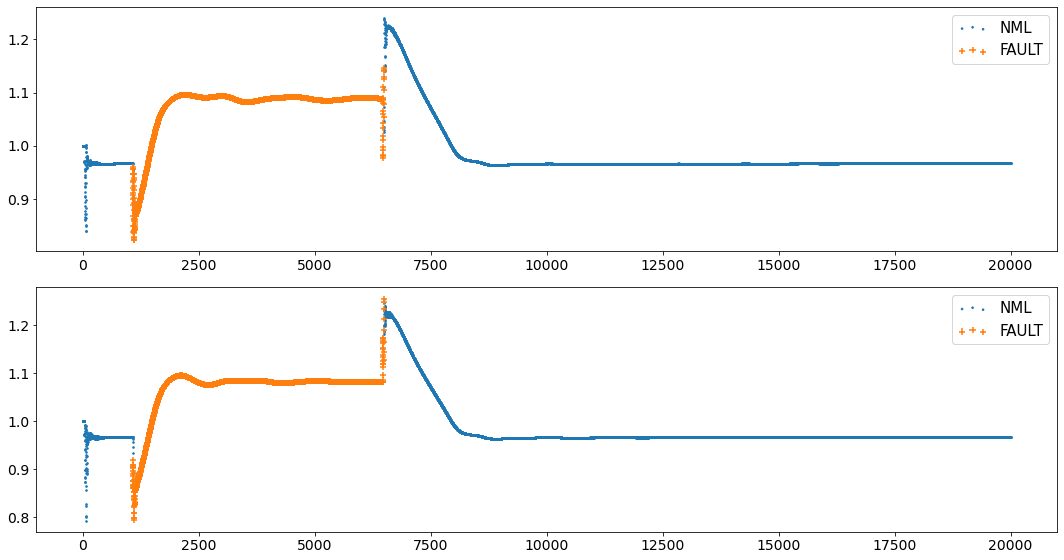

  Fault type Percentage
0         AC     99.93%
1        ACG      0.07%


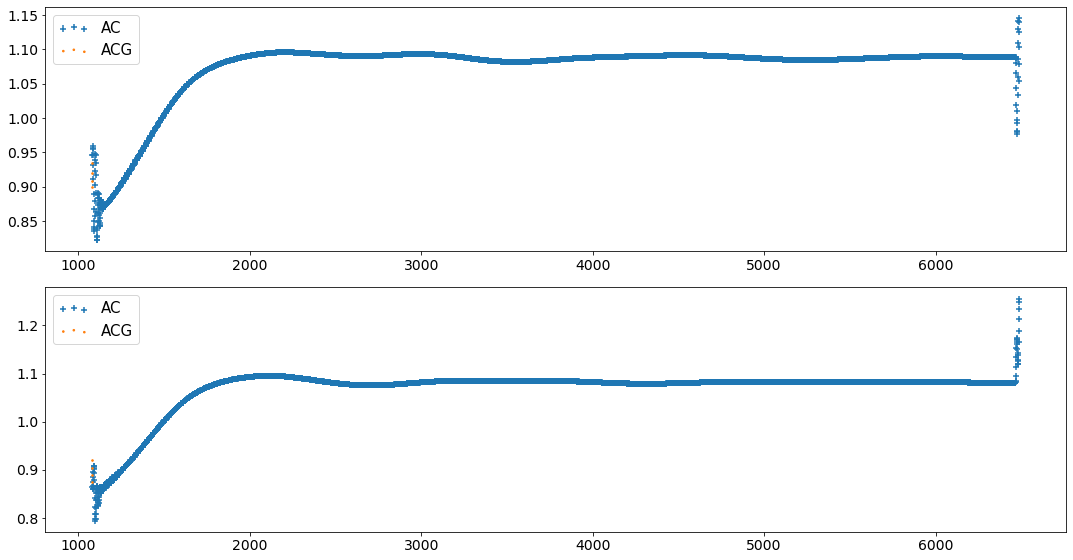


.
.
 5AG.csv
  Fault type Percentage
0        NML     91.24%
1      FAULT      8.76%


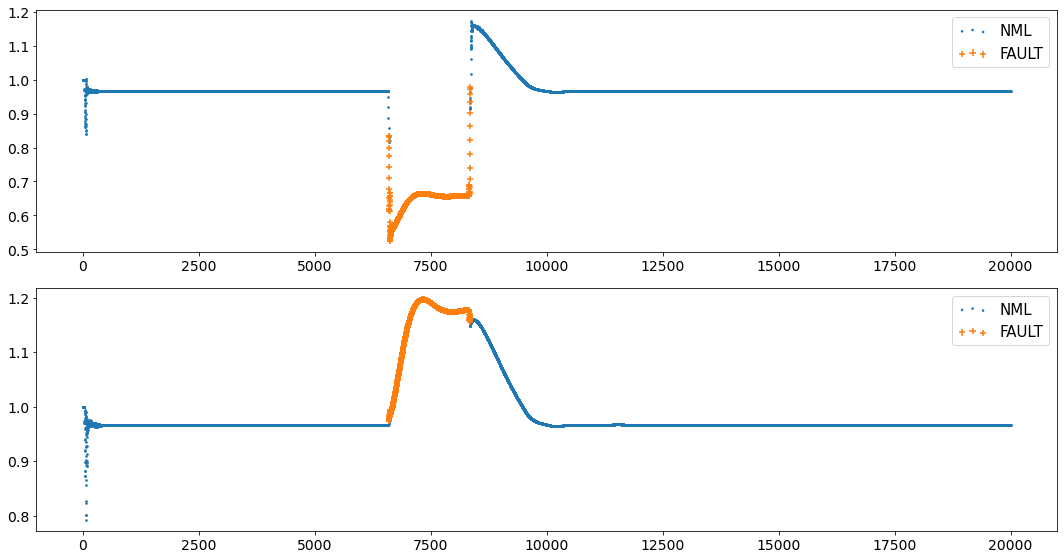

  Fault type Percentage
0         AG     100.0%


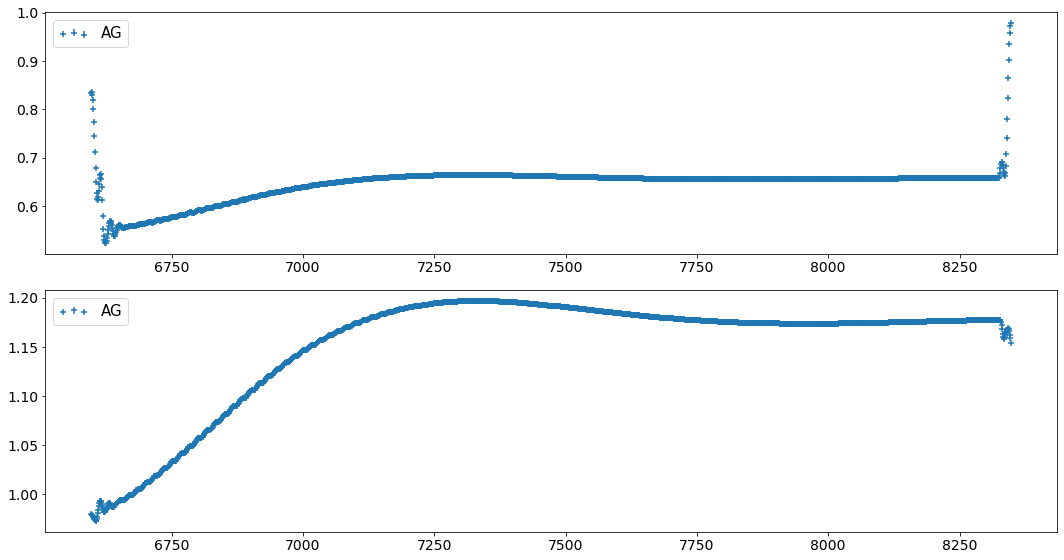


.
.
 1AC.csv
  Fault type Percentage
0        NML     97.64%
1      FAULT      2.36%


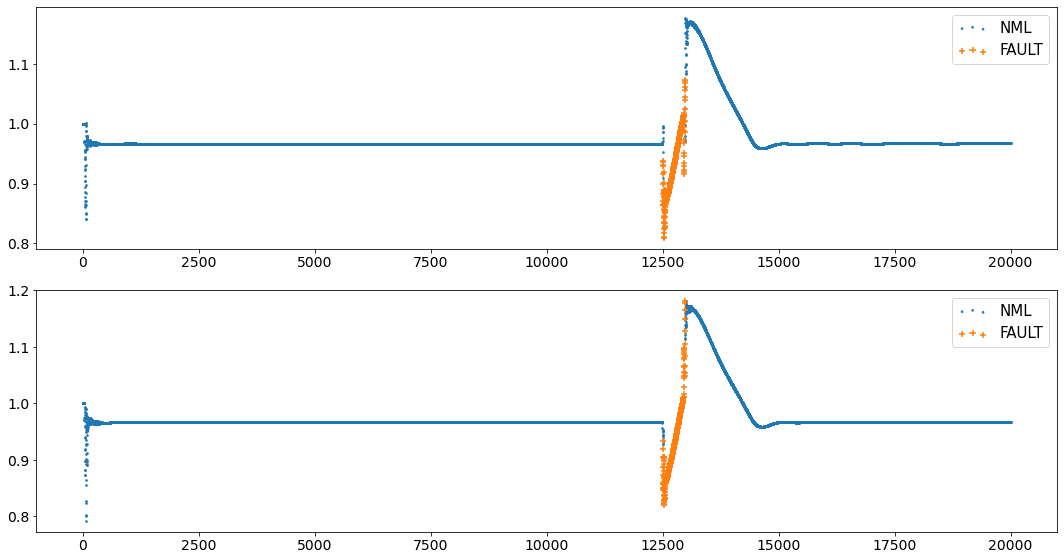

  Fault type Percentage
0         AC     96.61%
1        ACG      3.39%


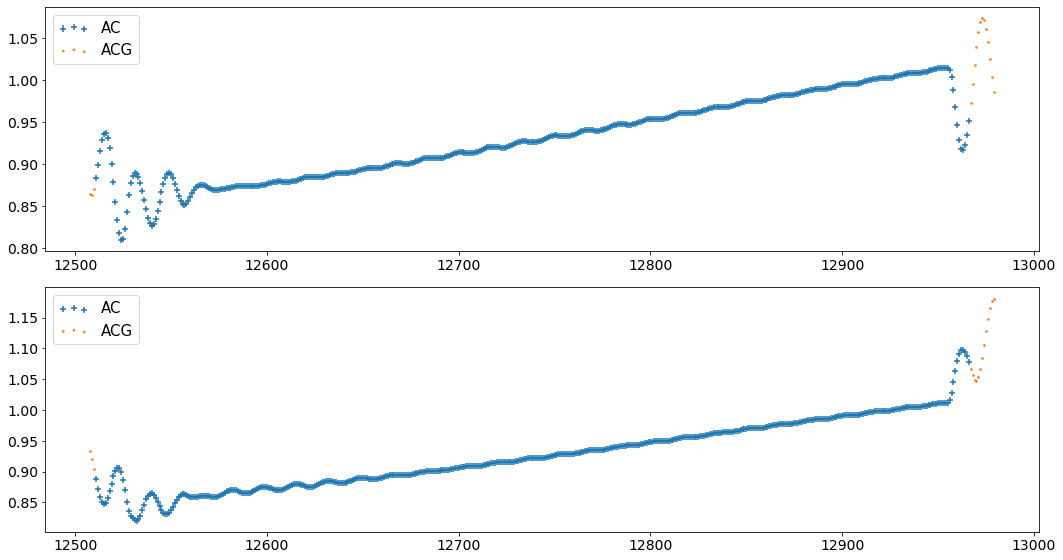


.
.
 2ACG.csv
  Fault type Percentage
0        NML     99.67%
1      FAULT      0.33%


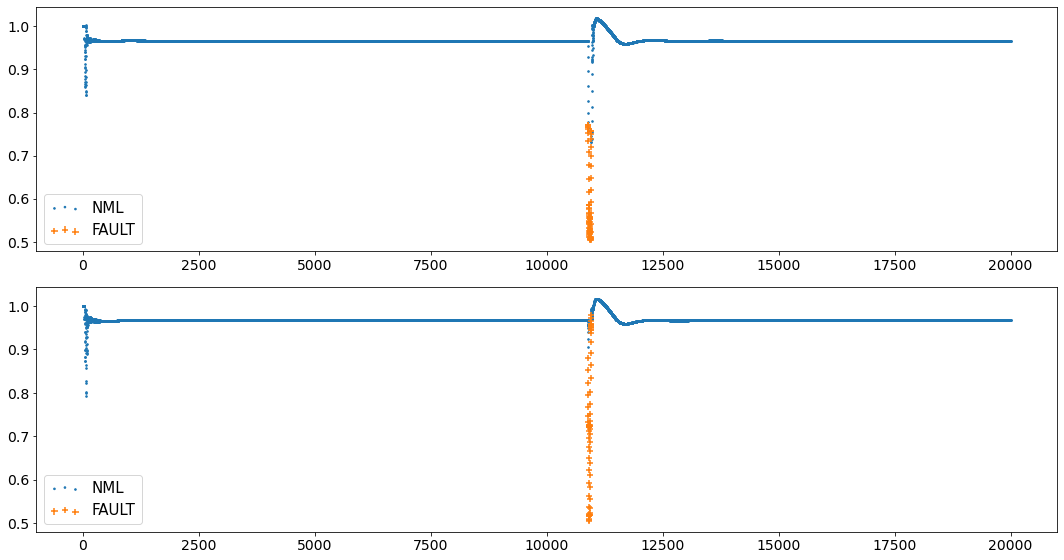

  Fault type Percentage
0        ACG     58.46%
1         AG     35.38%
2        ABC      6.15%


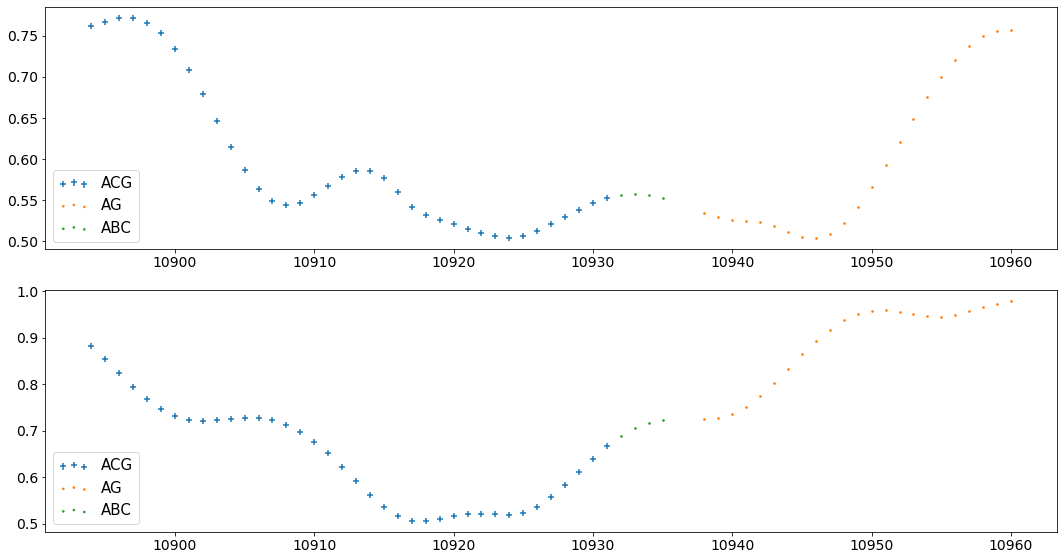


.
.
 1AB.csv
  Fault type Percentage
0        NML     94.67%
1      FAULT      5.33%


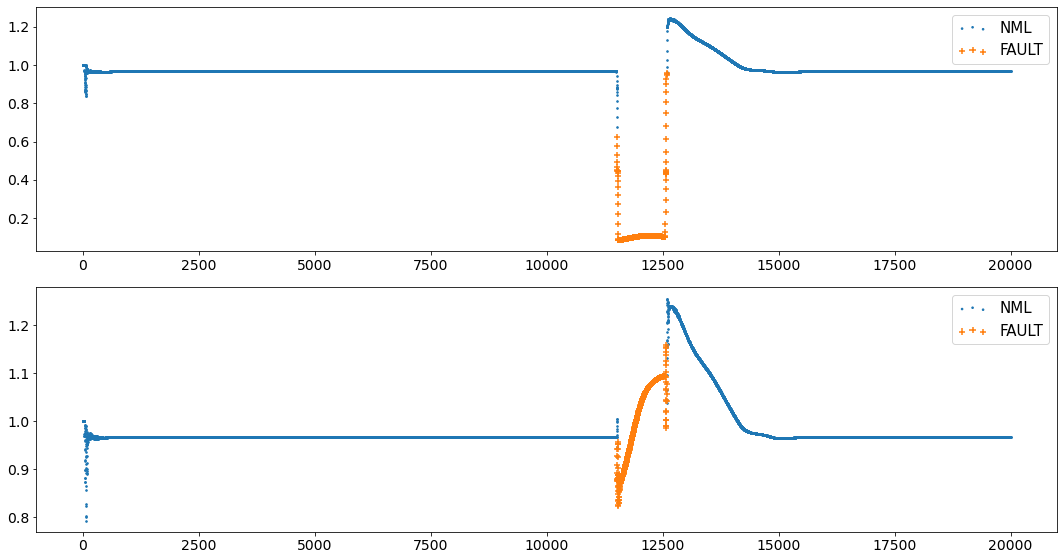

  Fault type Percentage
0         AB     99.53%
1        ABG      0.47%


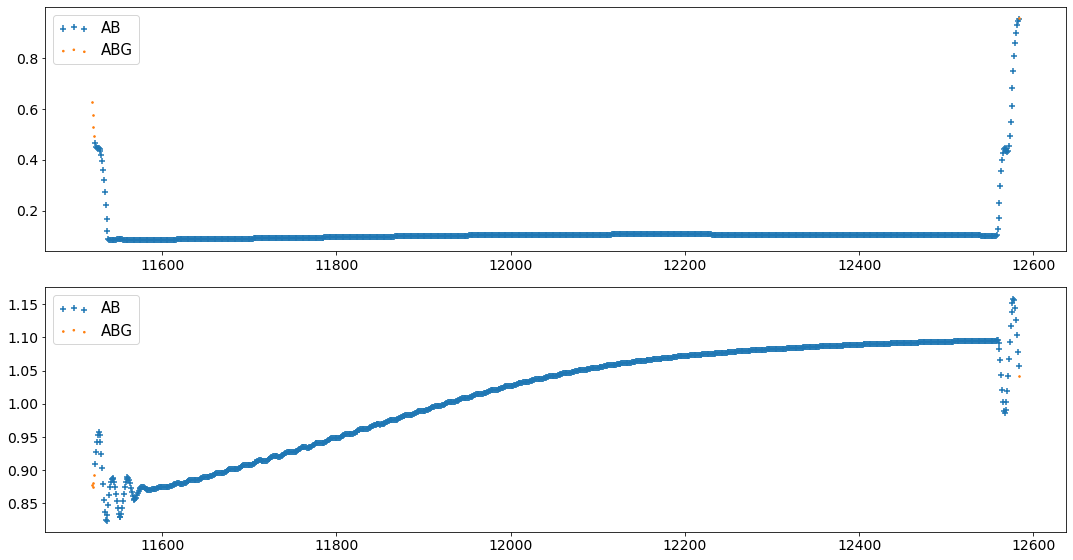


.
.
 2ABC.csv
  Fault type Percentage
0        NML     88.38%
1      FAULT     11.62%


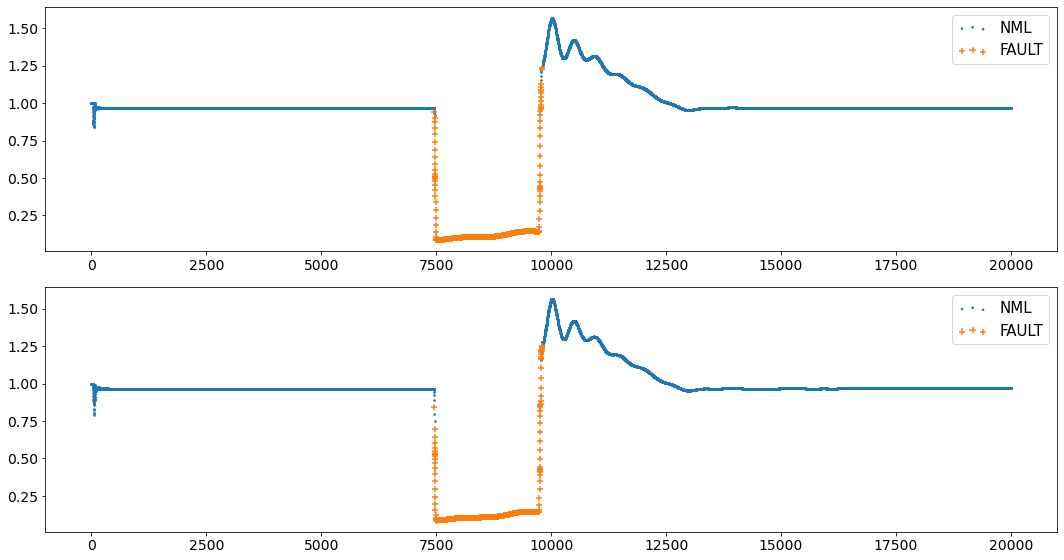

  Fault type Percentage
0        ABC     99.61%
1        BCG      0.26%
2        ACG      0.13%


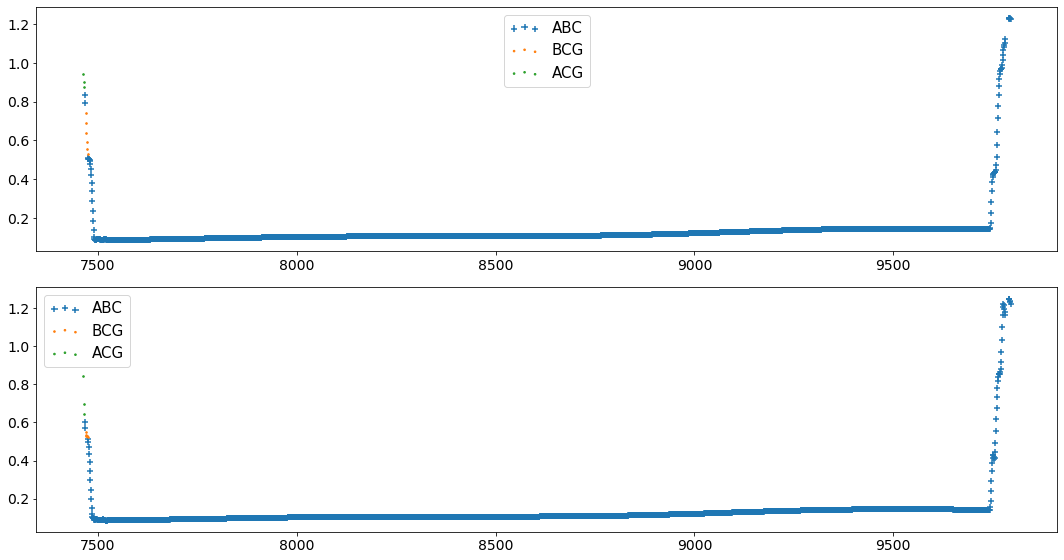


.
.
 9BG.csv
  Fault type Percentage
0        NML     91.33%
1      FAULT      8.68%


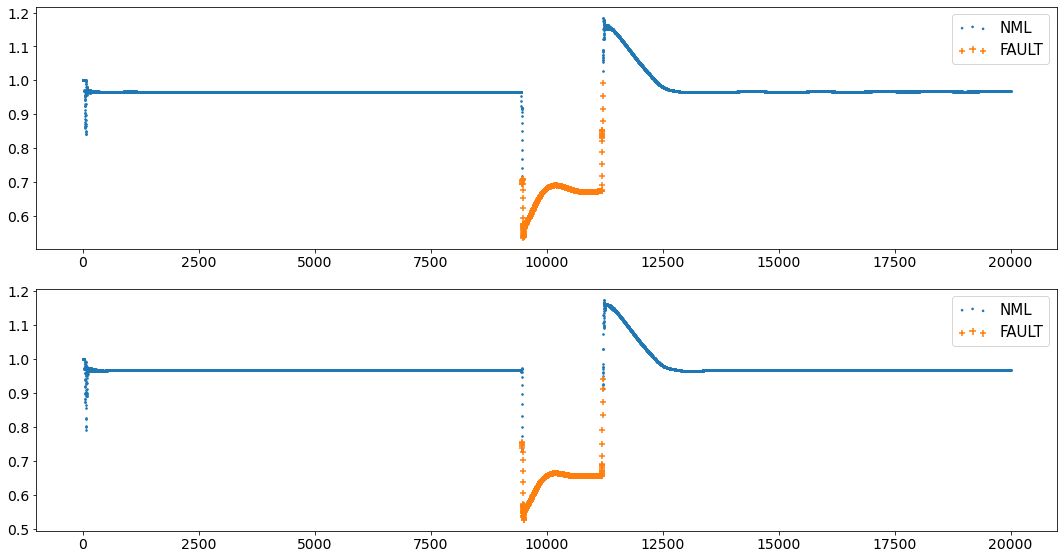

  Fault type Percentage
0         BG     100.0%


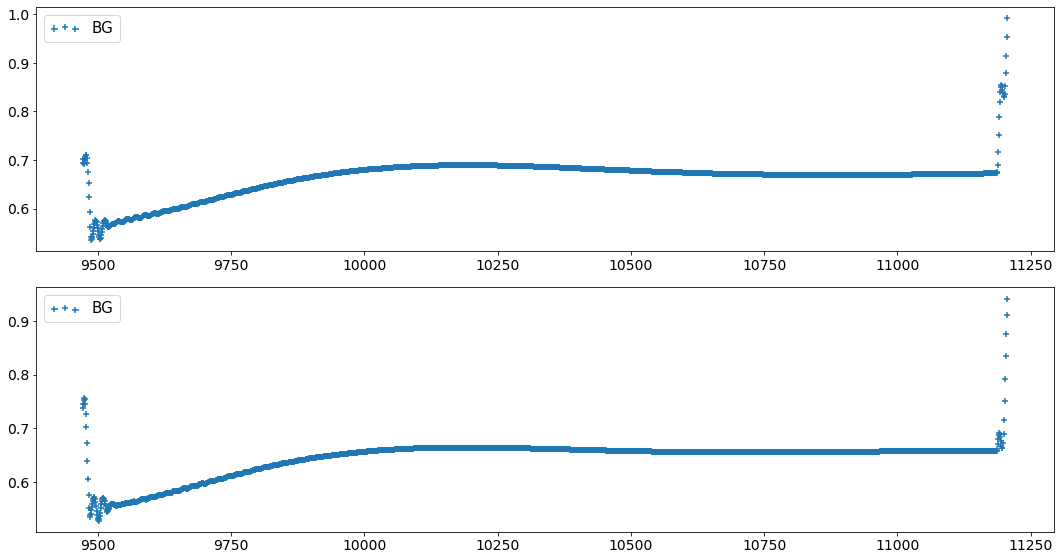


.
.
 9ABCG.csv
  Fault type Percentage
0        NML     78.05%
1      FAULT     21.95%


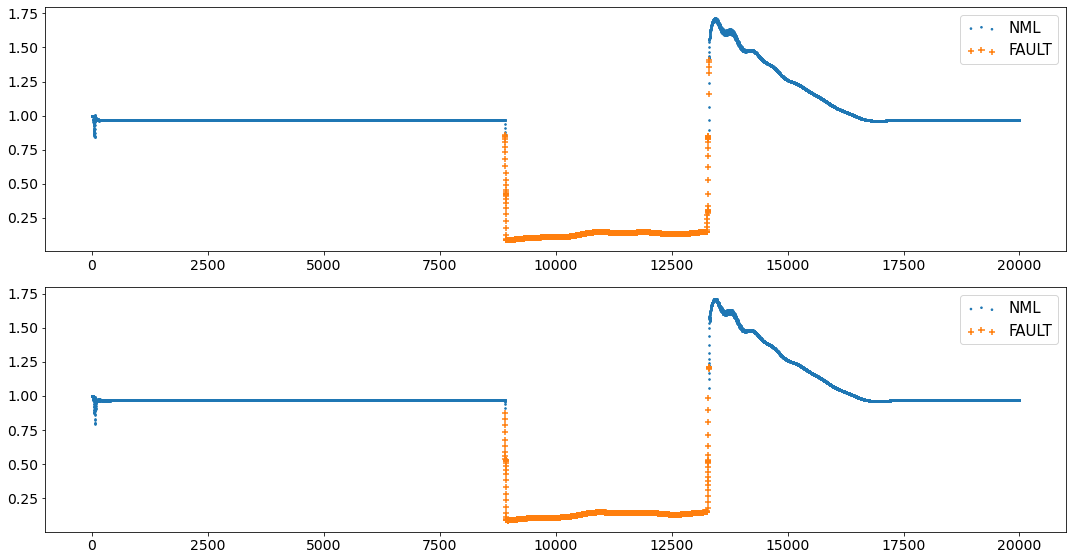

  Fault type Percentage
0        ABC      99.7%
1        ACG      0.23%
2        BCG      0.05%
3        ABG      0.02%


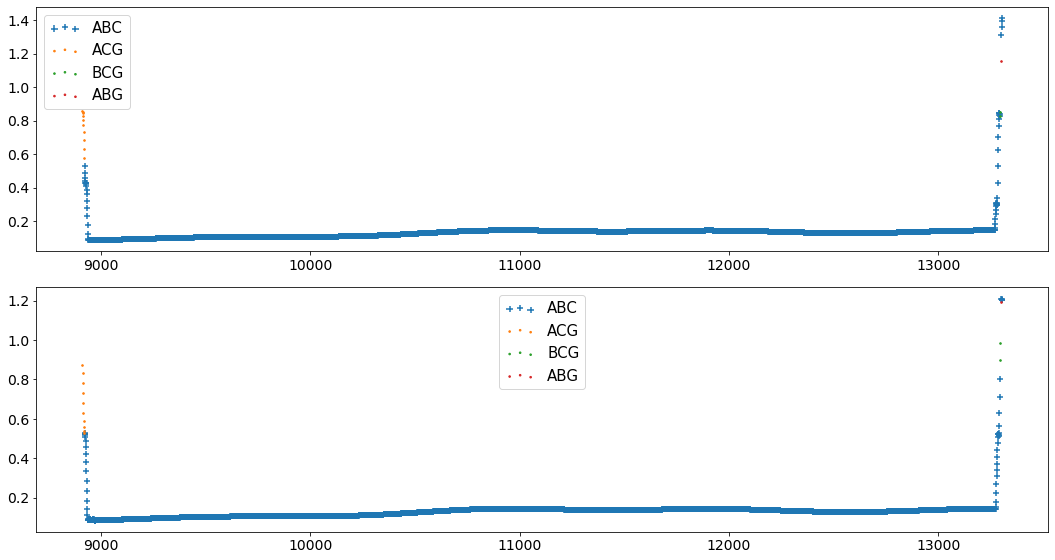


.
.
 3AB.csv
  Fault type Percentage
0        NML     94.18%
1      FAULT      5.82%


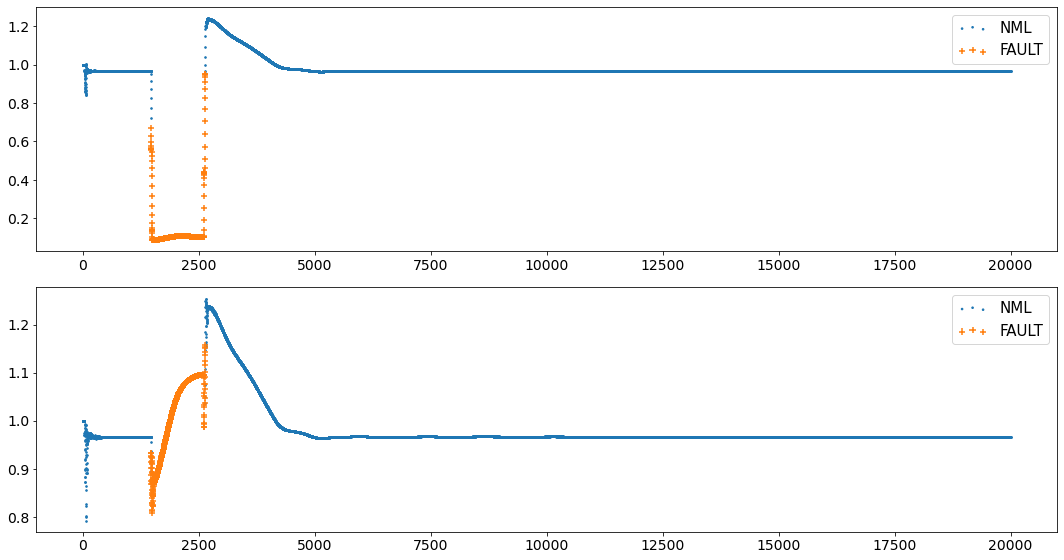

  Fault type Percentage
0         AB     99.83%
1        ABG      0.17%


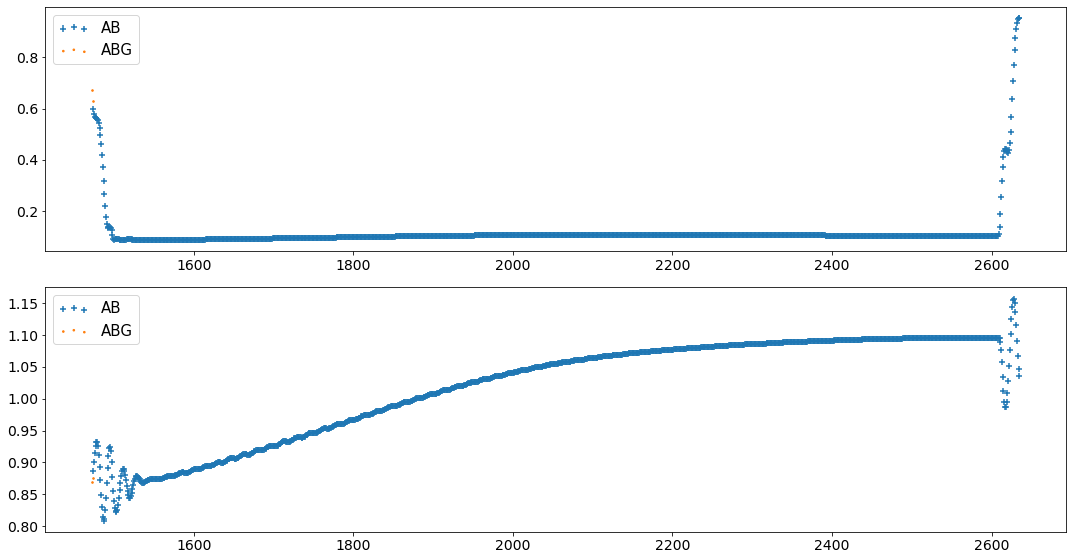


.
.
 3AC.csv
  Fault type Percentage
0        NML     84.81%
1      FAULT     15.19%


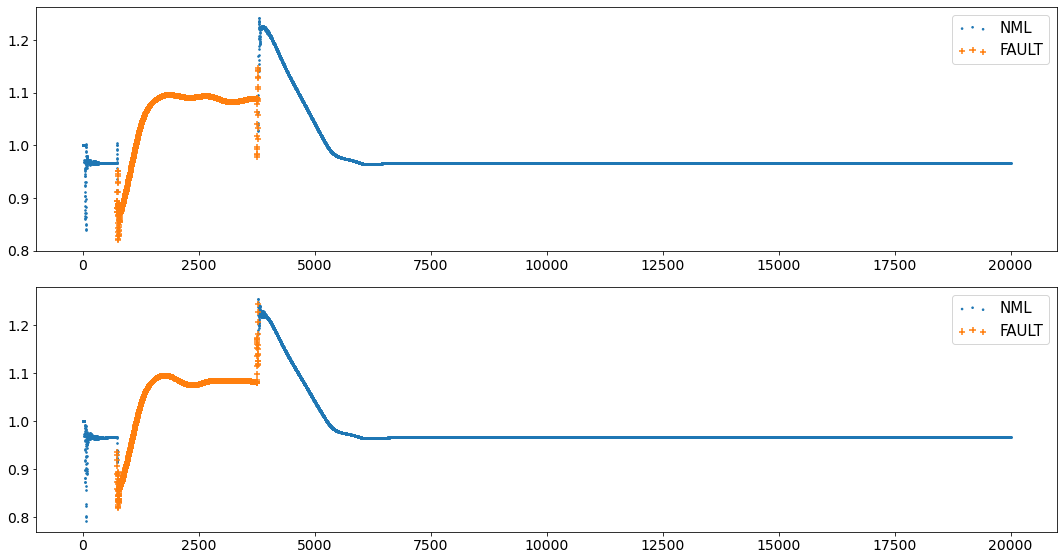

  Fault type Percentage
0         AC     99.84%
1        ACG      0.16%


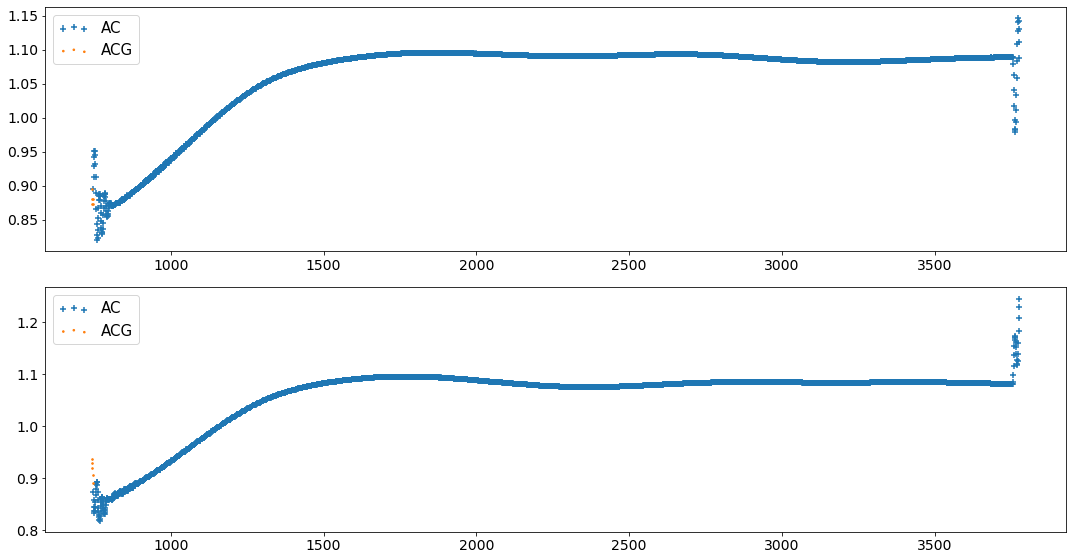


.
.
 4BCG.csv
  Fault type Percentage
0        NML     81.75%
1      FAULT     18.25%


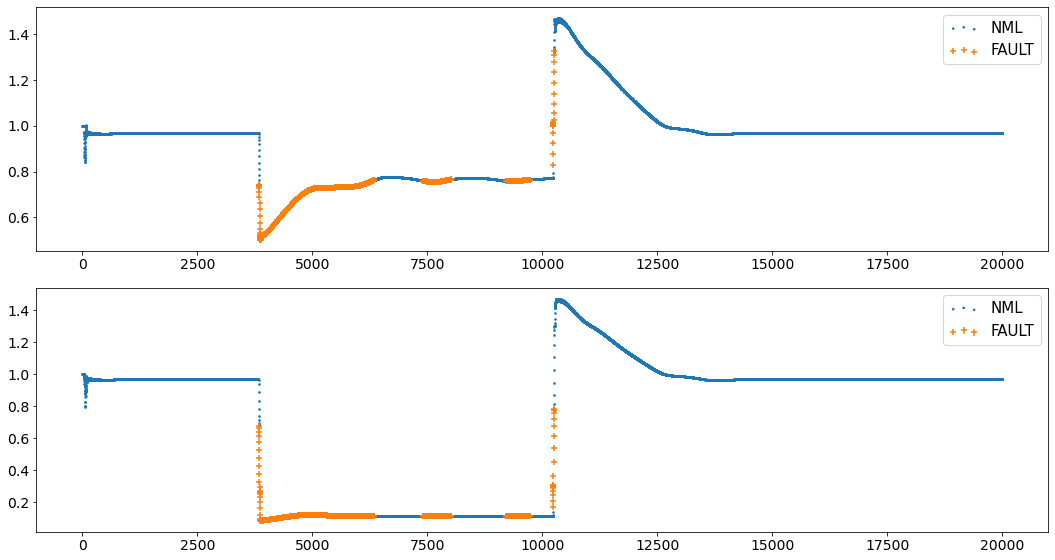

  Fault type Percentage
0        BCG     99.89%
1         BC      0.11%


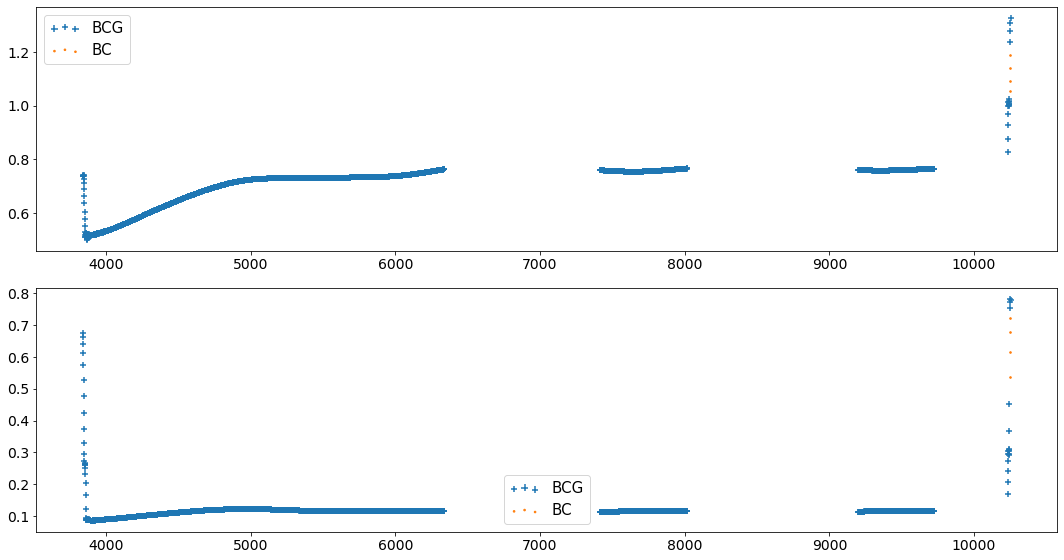


.
.
 7AG.csv
  Fault type Percentage
0        NML     90.01%
1      FAULT      9.99%


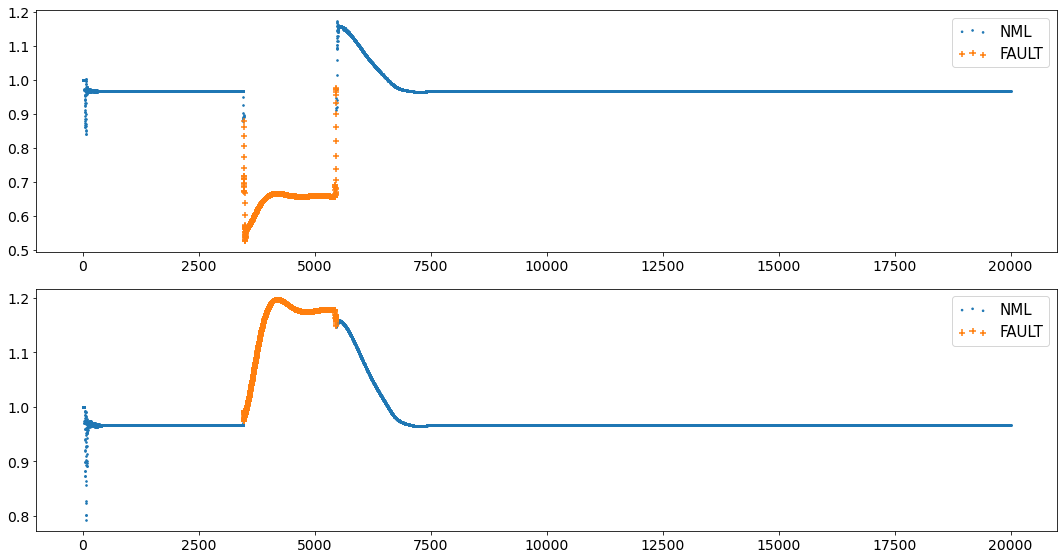

  Fault type Percentage
0         AG     100.0%


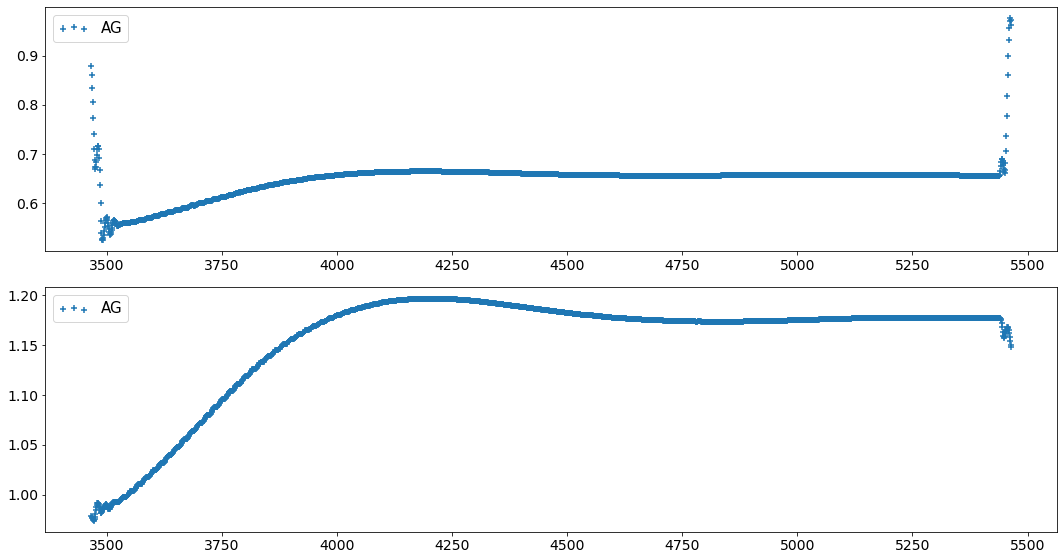


.
.
 8BCG.csv
  Fault type Percentage
0        NML     94.83%
1      FAULT      5.17%


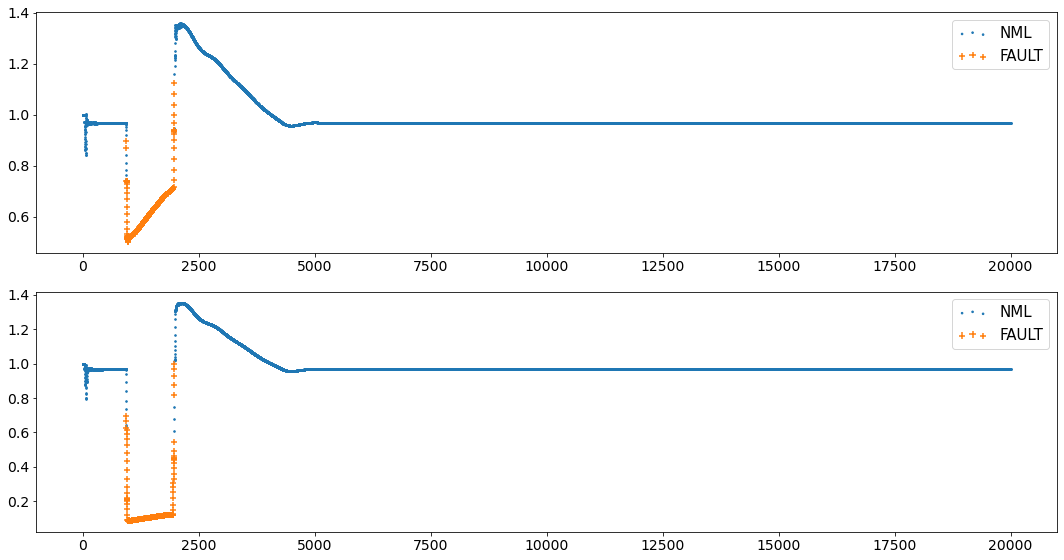

  Fault type Percentage
0        BCG     100.0%


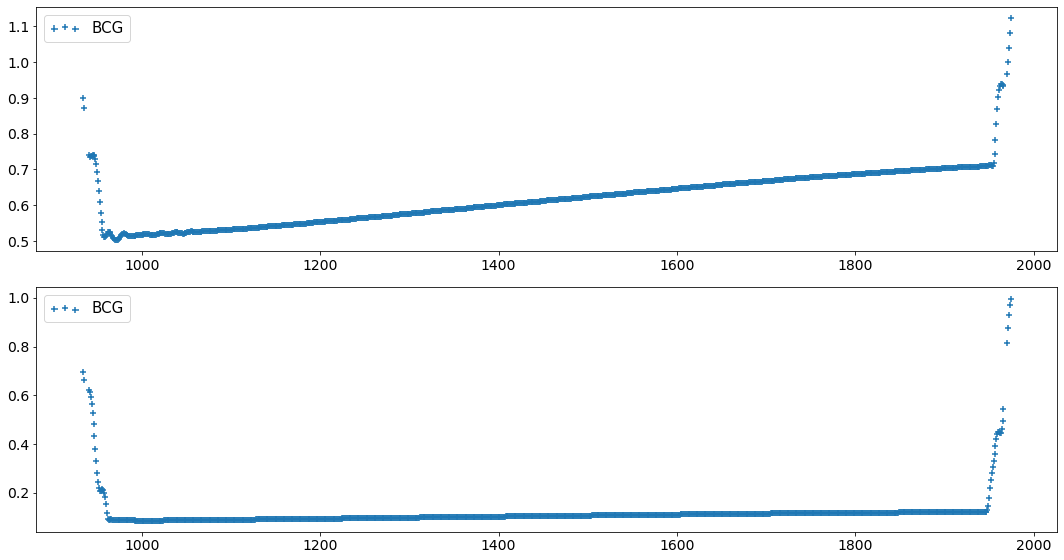

In [228]:
files_failing_the_test = []
files_passing_the_test = []

for each in file_list:
    print("\n.\n.\n",each)  
    temp = tester(ra,pd.read_csv('./RangeTrainingset/'+each))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    high = plotter(temp,multi_labels_list,2)
    if high == ''.join([i for i in each.split(".")[0] if not i.isdigit()]):
        files_passing_the_test.append(each)
    else:
        files_failing_the_test.append(each)


In [229]:
print(files_passing_the_test,"....\n\n....",files_failing_the_test)

['10ABG.csv', '3BC.csv', '3CG.csv', '1BCG.csv', '7BG.csv', '5BG.csv', '9ABG.csv', '1BC.csv', '1CG.csv', '5ABG.csv', '9AG.csv', '7ABC.csv', '7ACG.csv', '7ABG.csv', '9AC.csv', '1BG.csv', '5ABC.csv', '5ACG.csv', '9AB.csv', '9ACG.csv', '9ABC.csv', '5BC.csv', '5CG.csv', '7BC.csv', '7CG.csv', '10ACG.csv', '3BG.csv', '10ABC.csv', '3BCG.csv', '4BG.csv', '1ABC.csv', '1ACG.csv', '8AG.csv', '3ABG.csv', '10AC.csv', '7BCG.csv', '6BG.csv', '10AB.csv', '2BC.csv', '2CG.csv', '5BCG.csv', '2BG.csv', '6BC.csv', '6CG.csv', '9BCG.csv', '10AG.csv', '3ABC.csv', '3ACG.csv', '8AC.csv', '4BC.csv', '4CG.csv', '1ABG.csv', '8AB.csv', '10BCG.csv', '8CG.csv', '8BC.csv', '4AB.csv', '6ACG.csv', '6ABC.csv', '8ABG.csv', '4AC.csv', '4ABG.csv', '2AG.csv', '6AC.csv', '6AB.csv', '10BG.csv', '2AB.csv', '2BCG.csv', '10BC.csv', '10CG.csv', '6AG.csv', '2AC.csv', '4ACG.csv', '4ABC.csv', '8ABC.csv', '8ACG.csv', '4AG.csv', '6ABG.csv', '8BG.csv', '7AC.csv', '3AG.csv', '7AB.csv', '6BCG.csv', '5AB.csv', '9CG.csv', '9BC.csv', '2ABG.cs

In [ ]:
names = [''.join([i for i in each.split(".")[0] if not i.isdigit()]) for each in files_passing_the_test]

In [ ]:
Counter(names)

In [ ]:
temp = tester(binary_model,pd.read_csv('ml_test.csv'))
plotter(temp,binary_labels_list,2)
temp = tester(multi_model,temp[temp.label!=0])
high = plotter(temp,multi_labels_list,2)
print(high)

In [ ]:
files_failing_the_test = []
files_passing_the_test = []
for i in range(1,10):
    print("___________________________________________________________________")
    temp = tester(binary_model,pd.read_csv('./KMTrainingSet/'+str(i)+'ABC.csv'))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    high = plotter(temp,multi_labels_list,2)
    if high == ''.join([i for i in each.split(".")[0] if not i.isdigit()]):
        checker.append(str(i)+'ABC.csv')
    else:
        checker.append('incorrect')
    print("----------------------------------------------------------------")
    

In [ ]:
files_failing_model = [str(i)+'ABC.csv' for i in range(len(checker)) if checker[i]=='incorrect']

names = [''.join([i for i in each.split(".")[0] if not i.isdigit()]) for each in files_failing_model]

In [ ]:
Counter(names)

In [ ]:
data = pd.read_csv('./KMTrainingSet/1AG.csv')

In [ ]:
round(data['3V'])

In [ ]:
dat = Counter((round(data['3V'])/10))
matrics = sorted(zip([each for each in Counter(dat).keys()],Counter(dat).values() ), key=lambda x: x[0])





In [ ]:
data = pd.read_csv('KMTrainingset/2ABG.csv')

In [ ]:
features = data[data.columns[:-1]].values.tolist()
#true_labels = data['label'].values.tolist()

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [ ]:
scaled_features

In [ ]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=500,
    random_state=42
)

In [ ]:
kmeans.fit(scaled_features)

In [ ]:
kmeans.cluster_centers_

In [ ]:
labels = kmeans.fit_predict(features)


In [ ]:
#data['label']=labels
data.head()

In [ ]:
dic = Counter(labels)

In [ ]:
dic

In [ ]:
if dic[1]>dic[0]:
    print("1 = 0 , 0 =1")
    data['label']=[1 if i == 0 else 0 for i in labels]
else:
    print(True)

In [ ]:
dic = Counter(data['label'])

In [ ]:
data

In [ ]:
n_plots = 6
fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))
unique_labels = ['NML','Fault']
cols = data.columns[:-1]

for j in range(6):

    
    legend_list = []
    for i in list(set(data.label)):
        
        plo = data[data.label == i]
        temp = ax[j].scatter(plo.index,plo[cols[j]],marker='+',s=40)  


        legend_list.append(temp)

    ax[j].legend(legend_list,unique_labels,scatterpoints=3,ncol=1,fontsize=15)

fig.tight_layout()
plt.show()

In [ ]:
org = [0,1,0,1,1,1,0,0,1,0,1]
[1 if i == 0 else 0 for i in org]

In [ ]:
for x,y in zip(org,[1 if i == 0 else 0 for i in org]):
    print(x+y)